In [1]:
# PLCO Dataset
# Dataset have 176 features and 78209 instances
# is very imbalanced
# have missing values

In [2]:
# importing packages and Libraries
# For data analysis and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
 #For Ml models
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from collections import OrderedDict

In [3]:
# Importing dataset
PLCO = pd.read_csv('PLCO_data.csv')

In [4]:
#Data Analysis and preprocessing

In [5]:
# Checking the number of Features, instances and data types
print("Total rows",PLCO.shape[0])
print("Total number of features are ", PLCO.shape[1])
print("Data Types:", PLCO.dtypes)

Total rows 78209
Total number of features are  176
Data Types: breast_topography          object
breast_morphology         float64
breast_grade              float64
breast_behavior           float64
breast_cancer_first       float64
                           ...   
reconsent_outcome_days      int64
fstcan_exitstat             int64
fstcan_exitage              int64
fstcan_exitdays             int64
in_TGWAS_population         int64
Length: 176, dtype: object


0    73648
1     4561
Name: breast_cancer, dtype: int64


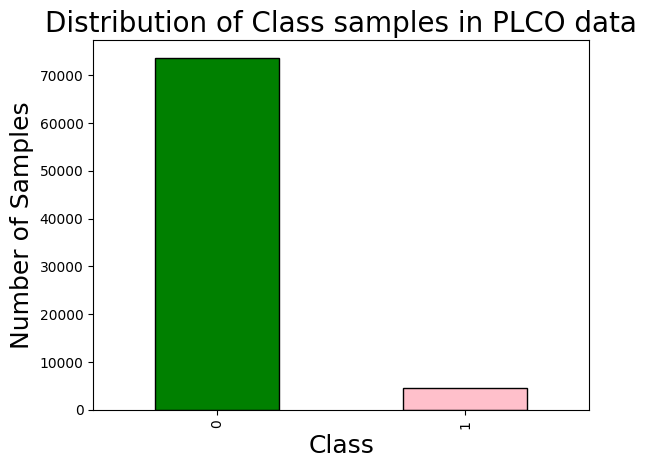

In [6]:
# Class labels and distribution
class_counts = PLCO['breast_cancer'].value_counts().sort_index() 
print(class_counts)
class_counts.plot(kind='bar', color=['green', 'pink'], edgecolor="black")
plt.xlabel("Class", fontsize=18)
plt.ylabel("Number of Samples", fontsize=18)
plt.title("Distribution of Class samples in PLCO data", fontsize=20)
plt.show()

In [7]:
# Missing values analysis
missing_values_per_feature = PLCO.isnull().sum()
print("Missing Values Per Feature:")
print(missing_values_per_feature)

Missing Values Per Feature:
breast_topography         73648
breast_morphology         73648
breast_grade              73648
breast_behavior           73648
breast_cancer_first       73648
                          ...  
reconsent_outcome_days        0
fstcan_exitstat               0
fstcan_exitage                0
fstcan_exitdays               0
in_TGWAS_population           0
Length: 176, dtype: int64


In [8]:
#dropping features with more than 60% missing values
threshold = PLCO.shape[0] * 0.6
features_removed = missing_values_per_feature[missing_values_per_feature > threshold].index
PLCO_filtered = PLCO.drop(columns=features_removed)
print("Removed features with more than 60% missing values:")
print(features_removed)
remaining_features = PLCO_filtered.shape[1]
print("Remaining number of features:", remaining_features)

Removed features with more than 60% missing values:
Index(['breast_topography', 'breast_morphology', 'breast_grade',
       'breast_behavior', 'breast_cancer_first', 'breast_seer',
       'breast_seercat', 'breast_annyr', 'breast_num_heslide_imgs',
       'breast_has_deliv_heslide_img', 'breast_num_ihcmarker_imgs',
       'breast_has_deliv_ihcmarker_img', 'breast_cancer_diagdays',
       'breast_resect_proc', 'breast_dxproc', 'breast_reason',
       'breast_stage_t', 'breast_stage_n', 'breast_stage_m',
       'breast_estrogen_quant', 'breast_progest_quant', 'breast_her2_stat',
       'breast_her2fish_ratio', 'breast_stage', 'breast_stage_7e',
       'breast_er_status', 'breast_pr_status', 'breast_her2summ',
       'breast_tmrsize', 'breast_hist_type', 'hystera', 'ssmokea_f',
       'breast_fh_age', 'd_codeath_cat', 'f_codeath_cat', 'd_cancersite',
       'f_cancersite', 'd_seer_death', 'f_seer_death', 'dth_days',
       'entryage_muq', 'ph_any_muq', 'ph_breast_muq', 'entrydays_muq'],
 

C:\Users\de_de\AppData\Local\Temp\ipykernel_93908\3335161888.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix =PLCO_filtered.corr()


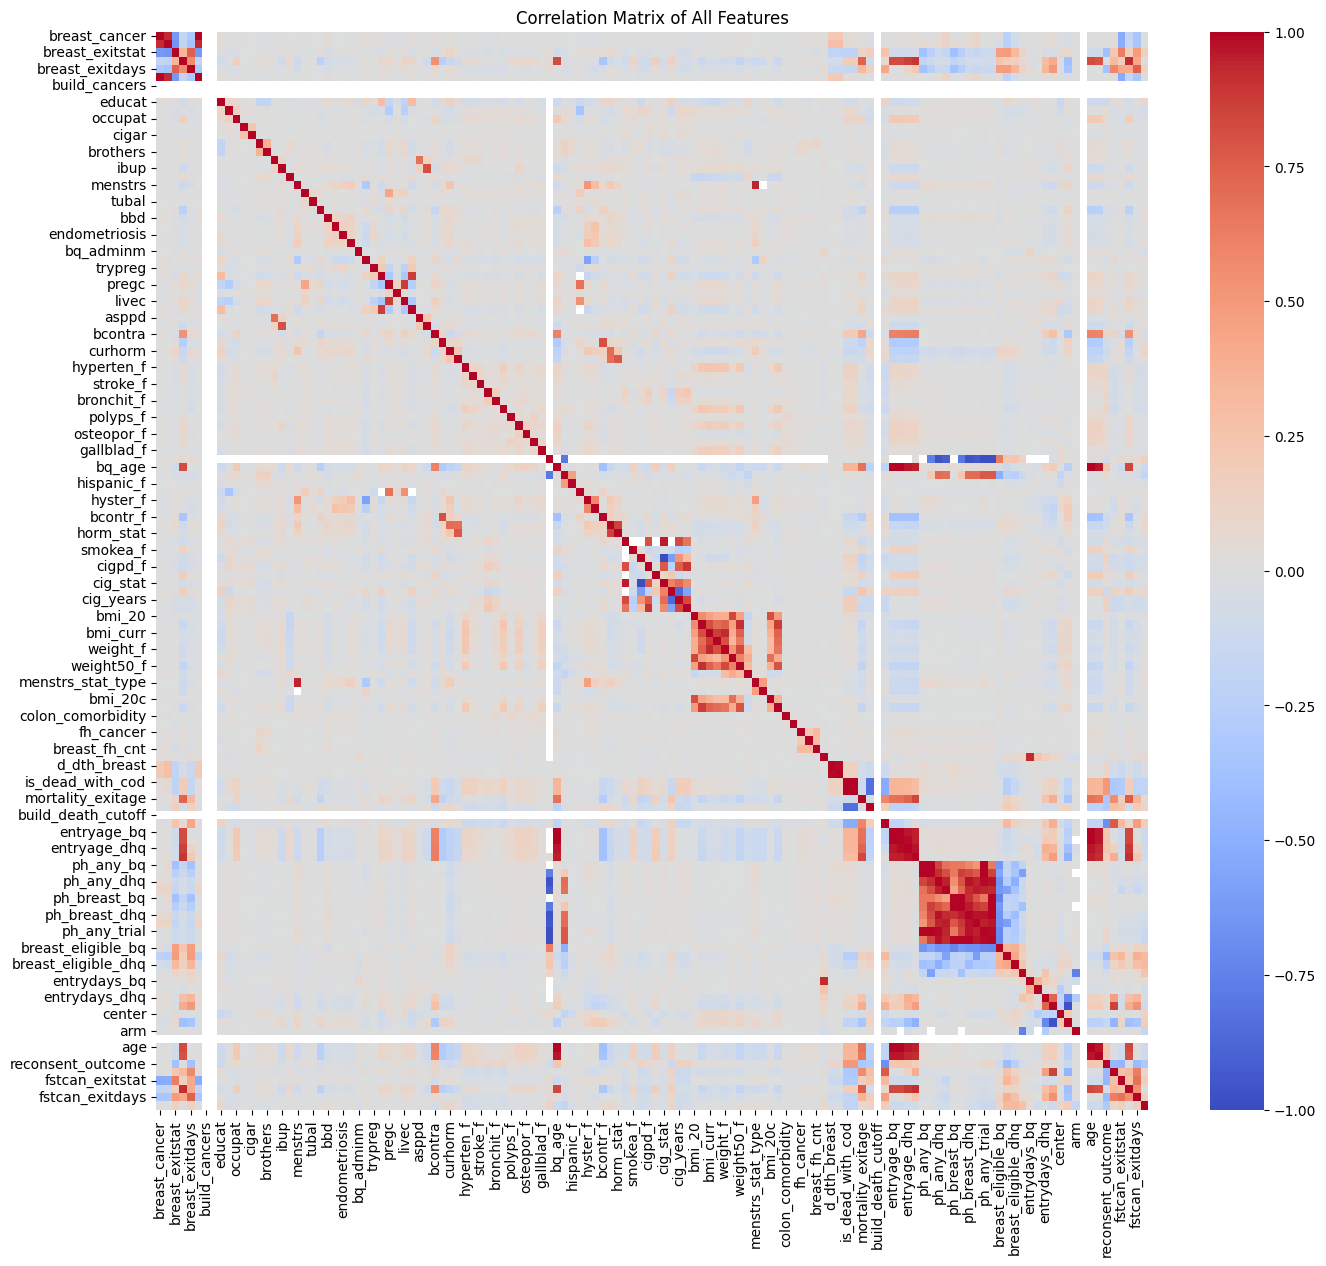

In [9]:
# Visulaizing remaining features correlation
correlation_matrix =PLCO_filtered.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()

In [10]:
# Extracting highly correlated features
correlation_threshold = 0.8
correlated_features = {}
for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2:
            correlation_value = correlation_matrix.loc[feature1, feature2]
            if abs(correlation_value) > correlation_threshold:
                if feature1 not in correlated_features:
                    correlated_features[feature1] = [feature2]
                else:
                    correlated_features[feature1].append(feature2)
for feature, correlated_list in correlated_features.items():
    print(f"{feature} is correlated with: {', '.join(correlated_list)}")

breast_cancer is correlated with: breast_num_cancers, has_bcs
breast_num_cancers is correlated with: breast_cancer, has_bcs
breast_exitage is correlated with: bq_age, entryage_bq, entryage_dqx, entryage_dhq, entryage_sqx, age, fstcan_exitage
has_bcs is correlated with: breast_cancer, breast_num_cancers
ibup is correlated with: ibuppd
menstrs is correlated with: menstrs_stat_type
prega is correlated with: fchilda
pregc is correlated with: livec
livec is correlated with: pregc
fchilda is correlated with: prega
ibuppd is correlated with: ibup
bcontrt is correlated with: bcontr_f
bq_returned is correlated with: ph_any_dhq, ph_any_sqx, ph_breast_dhq, ph_breast_sqx, ph_any_trial, ph_breast_trial
bq_age is correlated with: breast_exitage, entryage_bq, entryage_dqx, entryage_dhq, entryage_sqx, age, agelevel, fstcan_exitage
bcontr_f is correlated with: bcontrt
horm_f is correlated with: horm_stat
horm_stat is correlated with: horm_f
smoked_f is correlated with: cigpd_f, cig_stat, cig_years
rsmo

In [11]:
# selecting one and removing other highly correlated features
selected_features=PLCO_filtered.drop(['breast_num_cancers', 'has_bcs', 'fstcan_exitage', 'menstrs_stat_type','ph_any_dhq', 'ph_any_sqx', 'ph_breast_dhq', 'ph_breast_sqx',  'ph_any_trial', 'ph_breast_trial','entryage_bq', 'entryage_dqx', 'entryage_dhq', 'entryage_sqx','age','bq_age','smoked_f', 'rsmoker_f','weight50_f', 'weight_f', 'd_dth_breast','is_dead_with_cod','bmi_50','is_dead','mortality_exitage', 'fstcan_exitage','ph_any_dhq', 'ph_any_dqx', 'ph_any_sqx', 'ph_breast_dhq', 'ph_breast_sqx', 'ph_any_trial', 'ph_breast_trial', 'bq_compdays', 'entrydays_sqx',  'rndyear', 'reconsent_outcome_days'], axis=1)
remaining_feature_names = selected_features.columns.tolist()
print("Number of remaining features:", len(remaining_feature_names))
print("Remaining feature names:", remaining_feature_names)

Number of remaining features: 102
Remaining feature names: ['breast_cancer', 'breast_exitstat', 'breast_exitage', 'breast_exitdays', 'plco_id', 'build', 'build_cancers', 'build_incidence_cutoff', 'educat', 'marital', 'occupat', 'pipe', 'cigar', 'sisters', 'brothers', 'asp', 'ibup', 'fmenstr', 'menstrs', 'miscar', 'tubal', 'tuballig', 'bbd', 'benign_ovcyst', 'endometriosis', 'uterine_fib', 'bq_adminm', 'lmenstr', 'trypreg', 'prega', 'pregc', 'stillb', 'livec', 'fchilda', 'asppd', 'ibuppd', 'bcontra', 'bcontrt', 'curhorm', 'thorm', 'hyperten_f', 'hearta_f', 'stroke_f', 'emphys_f', 'bronchit_f', 'diabetes_f', 'polyps_f', 'arthrit_f', 'osteopor_f', 'divertic_f', 'gallblad_f', 'bq_returned', 'race7', 'hispanic_f', 'preg_f', 'hyster_f', 'ovariesr_f', 'bcontr_f', 'horm_f', 'horm_stat', 'smokea_f', 'cigpd_f', 'filtered_f', 'cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'bmi_20', 'bmi_curr', 'bmi_curc', 'weight20_f', 'height_f', 'post_menopausal', 'bmi_20c', 'bmi_50c', 'colon_comorbidity', 

In [12]:
# Removing features not related to breast questionnaire(BQ)
clean=selected_features.drop(['breast_exitstat','breast_exitage','breast_exitdays','plco_id', 'build', 'build_cancers', 'build_incidence_cutoff','bq_adminm','f_dth_breast','mortality_exitstat', 'build_death_cutoff', 'mortality_exitdays', 'ph_any_bq', 'ph_breast_bq', 'ph_breast_dqx','breast_eligible_sqx', 'breast_eligible_dhq', 'breast_eligible_dqx', 'entrydays_bq', 'entrydays_dqx', 'entrydays_dhq', 'center', 'arm','reconsent_outcome', 'fstcan_exitstat', 'fstcan_exitdays', 'in_TGWAS_population'], axis=1)
print("Remaining feature names:", clean.shape[1])
                        

Remaining feature names: 75


In [13]:
# Removing features that are answered by other questions in BQ
final_features= clean.drop(['sex','pipe', 'cigar', 'sisters', 'brothers','fmenstr','tubal','lmenstr','trypreg','pregc', 'stillb','asppd', 'ibuppd','hispanic_f', 'preg_f', 'hyster_f', 'ovariesr_f','educat','occupat', 'bcontr_f', 'horm_f','smokea_f',  'filtered_f','cig_years','cig_stop',  'pack_years','curhorm', 'bcontra', 'bmi_20','bmi_curr', 'weight20_f', 'height_f','bmi_20c', 'bmi_50c', ], axis=1)
print("Number of remaining features:", final_features.shape[1])
print("Remaining feature names:")
print(final_features.columns.tolist())

Number of remaining features: 41
Remaining feature names:
['breast_cancer', 'marital', 'asp', 'ibup', 'menstrs', 'miscar', 'tuballig', 'bbd', 'benign_ovcyst', 'endometriosis', 'uterine_fib', 'prega', 'livec', 'fchilda', 'bcontrt', 'thorm', 'hyperten_f', 'hearta_f', 'stroke_f', 'emphys_f', 'bronchit_f', 'diabetes_f', 'polyps_f', 'arthrit_f', 'osteopor_f', 'divertic_f', 'gallblad_f', 'bq_returned', 'race7', 'horm_stat', 'cigpd_f', 'cig_stat', 'bmi_curc', 'post_menopausal', 'colon_comorbidity', 'liver_comorbidity', 'fh_cancer', 'breast_fh', 'breast_fh_cnt', 'breast_eligible_bq', 'agelevel']


In [14]:
# Selecting eligible samples (i.e eligible for BQ and Returned BQ questionnaire)
eligible =final_features[(final_features['breast_eligible_bq'] == 1) & (final_features['bq_returned'] == 1)]
print("Number of remaining instances:", len(eligible))

Number of remaining instances: 73089


In [15]:
# remove unwanted features
clean=eligible.drop(['breast_eligible_bq', 'bq_returned'], axis=1)

In [16]:
#Data Split (80:20)
X =clean.drop('breast_cancer', axis=1)
y = clean['breast_cancer']
feature_names = X.columns
random_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [17]:
# Imputing missing values
mice_imputer = IterativeImputer(random_state=random_state)
X_train_imputed = mice_imputer.fit_transform(X_train)
X_test_imputed = mice_imputer.transform(X_test)

C:\Users\de_de\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [18]:
# Normalize data
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train_imputed)
X_test_scaled = sc.transform (X_test_imputed)

In [19]:
# Undersampling majority class to handle data imbalance
rus = RandomUnderSampler(random_state=random_state)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)
print("Train set class distribution after under-sampling:")
print(y_train_resampled.value_counts())
test_class_counts = y_test.value_counts()
print(test_class_counts)

Train set class distribution after under-sampling:
0    3481
1    3481
Name: breast_cancer, dtype: int64
0    13748
1      870
Name: breast_cancer, dtype: int64


In [20]:
# Ml Models Hyperparameter optimization, training ,testing, performance and Interpretability

In [21]:
# 1. Decision Tree
# # Hyperparameter optimization using Randomized search CV 
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 5, 10, 20], 
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4],
}


search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    param_distributions=dt_params,
    n_iter=50,  
    cv=5,
    scoring='f1',
    verbose=1
)

# training DT
search_dt.fit(X_train_resampled, y_train_resampled)
best_params_dt = search_dt.best_params_
print("Best Parameters:", best_params_dt)
print("Best f1 score for DT using undersampled data during training: ", search_dt.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'splitter': 'best', 'min_samples_split': 40, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy'}
Best f1 score for DT using undersampled data during training:  0.5588776647171436


In [22]:
# Testing DT
best_dt_model =search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test_scaled)
# DT performance Evaluation
print("\nEvaluation Metrics for dt:")
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_dt)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_dt)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_dt)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_dt, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test,best_dt_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for dt:
Accuracy: 0.5188124230400876
Precision: 0.07146829810901001
Recall: 0.5908045977011495
F1 Score: 0.12751178367650706
F2 Score: 0.24081709145427285
AUC: 0.5687231831422084


In [23]:
# Test set instance 1 would be used for local explainability
instance = X_test.iloc[0]
feature_dict = instance.to_dict()
print("Feature Dictionary:", feature_dict)

Feature Dictionary: {'marital': 2.0, 'asp': 0.0, 'ibup': 0.0, 'menstrs': 2.0, 'miscar': 0.0, 'tuballig': 1.0, 'bbd': 1.0, 'benign_ovcyst': 0.0, 'endometriosis': 0.0, 'uterine_fib': 1.0, 'prega': 3.0, 'livec': 2.0, 'fchilda': 3.0, 'bcontrt': 0.0, 'thorm': 0.0, 'hyperten_f': 0.0, 'hearta_f': 0.0, 'stroke_f': 0.0, 'emphys_f': 0.0, 'bronchit_f': 0.0, 'diabetes_f': 0.0, 'polyps_f': 0.0, 'arthrit_f': 1.0, 'osteopor_f': 1.0, 'divertic_f': 1.0, 'gallblad_f': 0.0, 'race7': 1.0, 'horm_stat': 0.0, 'cigpd_f': 3.0, 'cig_stat': 1.0, 'bmi_curc': 4.0, 'post_menopausal': 1.0, 'colon_comorbidity': 0.0, 'liver_comorbidity': 0.0, 'fh_cancer': 1.0, 'breast_fh': 0.0, 'breast_fh_cnt': 0.0, 'agelevel': 1.0}


In [24]:
# as standardized data was used for model training and testing, we need to define scaled data instance for explaianbility as well
instance_to_explain = X_test_scaled[0, :].reshape(1, -1) 

In [25]:
# Model prediction and feature relevance based on decision path - Interpretability
prediction = best_dt_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_relevance = OrderedDict({feature: 0 for feature in X_test.columns.tolist()})
decision_path = best_dt_model.decision_path(instance_to_explain).toarray()
nodes_in_path = np.where(decision_path[0] == 1)[0]

for node in nodes_in_path:
    feature_index = best_dt_model.tree_.feature[node]
    if feature_index != -1 and feature_index < len(X_test.columns):
        feature_name = X_test.columns[feature_index]
        feature_relevance[feature_name] += 1

Model Prediction: 1


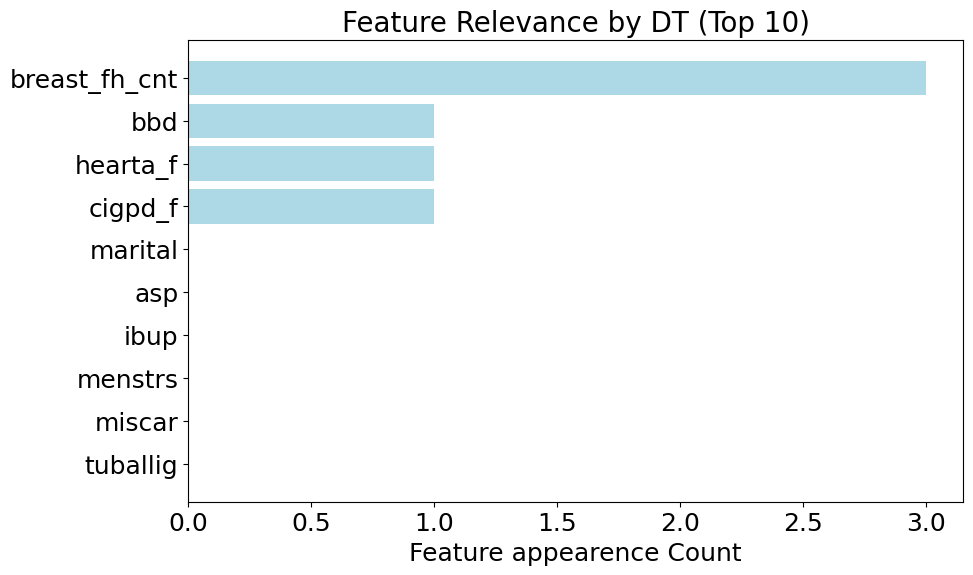

In [26]:
#visualising feature relevance by DT in descending order
sorted_feature_relevance = dict(sorted(feature_relevance.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_feature_relevance.keys())[:10]
feature_values = list(sorted_feature_relevance.values())[:10]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_values, color='lightblue')
plt.gca().tick_params(labelsize=18)
plt.xlabel('Feature appearence Count', fontsize=18)
plt.title('Feature Relevance by DT (Top 10)', fontsize=20)
plt.gca().invert_yaxis() 
plt.show()

In [27]:
# 2. Random forest
# Hyperparameter optimization using Randomized search CV 
rf_params= {
    'n_estimators': [10, 15, 20, 25, 30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4]
}
rf_classifier = RandomizedSearchCV(
    RandomForestClassifier(random_state=random_state),
    param_distributions=rf_params,
    n_iter=50,  
    cv=5,
    scoring='f1',
    verbose=1
)

# Training RF
rf_classifier.fit(X_train_resampled, y_train_resampled)

best_params_rf = rf_classifier.best_params_
print("Best Parameters:", best_params_rf)
print("Best f1-score for Rf using undersampled data during training: ", rf_classifier.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'gini'}
Best f1-score for Rf using undersampled data during training:  0.5364739796088963


In [28]:
# Testing RF
best_rf_model = rf_classifier.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Rf performance evaluation
print("\nEvaluation Metrics for Random Forest:")
accuracy= accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf)
print("Precision:", precision)
recall= recall_score(y_test, y_pred_rf)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_rf)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_rf, beta=2)
print("F2 Score:", f_beta)
auc= roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Random Forest:
Accuracy: 0.541182104255028
Precision: 0.07061939090775342
Recall: 0.5517241379310345
F1 Score: 0.12521194730663884
F2 Score: 0.2335311861438163
AUC: 0.5600154170805199


In [29]:
# Model prediction and Feature importance for feature relavence- Global Interpretability
prediction = best_rf_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_names = list(X_train.columns) 
num_features = len(feature_names)
rf_feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(rf_feature_importances)[::-1]
top_feature_indices = sorted_indices[:min(10, num_features)]
top_10_feature_names = [feature_names[idx] for idx in top_feature_indices]
top_10_feature_importances = [rf_feature_importances[idx] for idx in top_feature_indices]

Model Prediction: 1


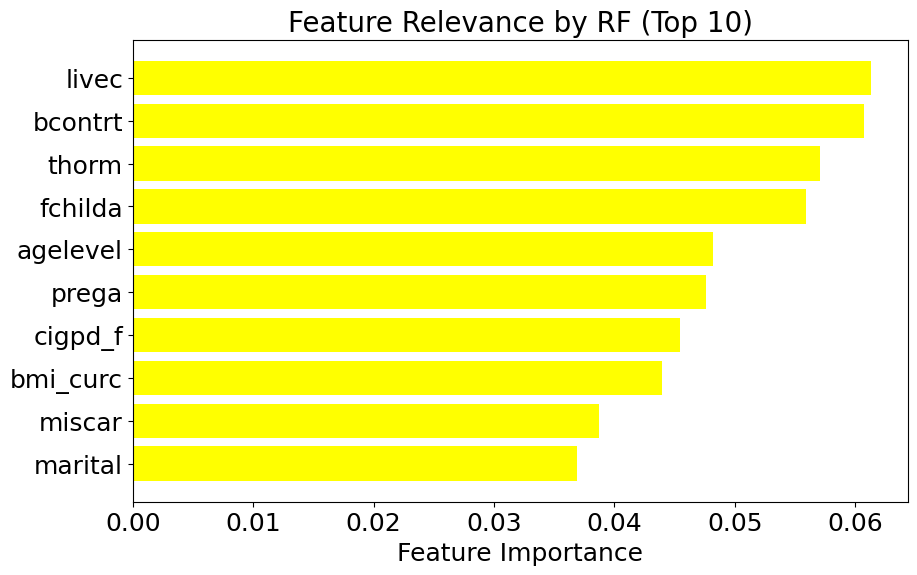

In [30]:
# Visualising the feature relevance by RF
plt.figure(figsize=(10, 6))
plt.barh(top_10_feature_names, top_10_feature_importances, color='yellow')  
plt.gca().tick_params(labelsize=18)  
plt.xlabel('Feature Importance', fontsize=18) 
plt.title('Feature Relevance by RF (Top 10)', fontsize=20)  
plt.gca().invert_yaxis()
plt.show()

In [31]:
# 3. TabNet

# Hyperparameter optimization
tabnet_params = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.3, 1.8],
    'lambda_sparse': [0.001, 0.005, 0.01,0.1],
   
}

search_tabnet = RandomizedSearchCV(
    TabNetClassifier(),
    param_distributions=tabnet_params,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# TabNet Training
search_tabnet.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test_imputed, y_test)],
    max_epochs=100,
    patience=15,  
    batch_size=20
)
best_params_tabnet = search_tabnet.best_params_
print("Best Parameters for TabNet:", best_params_tabnet)
print("Best f1-score for TabNet using undersampled data during training: ", search_tabnet.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71278 | val_0_auc: 0.52806 |  0:00:10s
epoch 1  | loss: 0.66906 | val_0_auc: 0.50504 |  0:00:20s
epoch 2  | loss: 0.66674 | val_0_auc: 0.54337 |  0:00:30s
epoch 3  | loss: 0.66425 | val_0_auc: 0.54189 |  0:00:40s
epoch 4  | loss: 0.66664 | val_0_auc: 0.52139 |  0:00:51s
epoch 5  | loss: 0.66369 | val_0_auc: 0.52852 |  0:01:01s
epoch 6  | loss: 0.66347 | val_0_auc: 0.53533 |  0:01:11s
epoch 7  | loss: 0.66127 | val_0_auc: 0.52518 |  0:01:22s
epoch 8  | loss: 0.66393 | val_0_auc: 0.54057 |  0:01:33s
epoch 9  | loss: 0.66355 | val_0_auc: 0.52831 |  0:01:44s
epoch 10 | loss: 0.66347 | val_0_auc: 0.49858 |  0:01:54s
epoch 11 | loss: 0.66388 | val_0_auc: 0.49662 |  0:02:05s
epoch 12 | loss: 0.66449 | val_0_auc: 0.51069 |  0:02:16s
epoch 13 | loss: 0.66437 | val_0_auc: 0.51204 |  0:02:28s
epoch 14 | loss: 0.66193 | val_0_auc: 0.51269 |  0:02:40s
epoch 15 | loss: 0.66108 | val_0_auc: 0.53205 |  0:02:52s
epoch 16 | loss: 0.66049 | val_0_auc: 0.53323 |  0:03:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71303 | val_0_auc: 0.53878 |  0:00:10s
epoch 1  | loss: 0.67203 | val_0_auc: 0.52354 |  0:00:21s
epoch 2  | loss: 0.66919 | val_0_auc: 0.52116 |  0:00:33s
epoch 3  | loss: 0.66539 | val_0_auc: 0.51338 |  0:00:44s
epoch 4  | loss: 0.66493 | val_0_auc: 0.52586 |  0:00:55s
epoch 5  | loss: 0.66381 | val_0_auc: 0.52997 |  0:01:06s
epoch 6  | loss: 0.66332 | val_0_auc: 0.54002 |  0:01:17s
epoch 7  | loss: 0.66195 | val_0_auc: 0.53495 |  0:01:28s
epoch 8  | loss: 0.66156 | val_0_auc: 0.53207 |  0:01:39s
epoch 9  | loss: 0.66247 | val_0_auc: 0.54105 |  0:01:51s
epoch 10 | loss: 0.66152 | val_0_auc: 0.54116 |  0:02:02s
epoch 11 | loss: 0.66019 | val_0_auc: 0.53179 |  0:02:13s
epoch 12 | loss: 0.66366 | val_0_auc: 0.53021 |  0:02:24s
epoch 13 | loss: 0.66284 | val_0_auc: 0.51705 |  0:02:35s
epoch 14 | loss: 0.66034 | val_0_auc: 0.5362  |  0:02:46s
epoch 15 | loss: 0.65957 | val_0_auc: 0.54397 |  0:02:57s
epoch 16 | loss: 0.66054 | val_0_auc: 0.52538 |  0:03:08s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73078 | val_0_auc: 0.50028 |  0:00:10s
epoch 1  | loss: 0.69712 | val_0_auc: 0.51401 |  0:00:21s
epoch 2  | loss: 0.69512 | val_0_auc: 0.50918 |  0:00:33s
epoch 3  | loss: 0.6952  | val_0_auc: 0.51052 |  0:00:43s
epoch 4  | loss: 0.69455 | val_0_auc: 0.51388 |  0:00:54s
epoch 5  | loss: 0.69357 | val_0_auc: 0.52628 |  0:01:05s
epoch 6  | loss: 0.69374 | val_0_auc: 0.51961 |  0:01:16s
epoch 7  | loss: 0.6937  | val_0_auc: 0.5074  |  0:01:27s
epoch 8  | loss: 0.69311 | val_0_auc: 0.52249 |  0:01:38s
epoch 9  | loss: 0.69263 | val_0_auc: 0.50721 |  0:01:49s
epoch 10 | loss: 0.69292 | val_0_auc: 0.49729 |  0:02:00s
epoch 11 | loss: 0.6951  | val_0_auc: 0.52535 |  0:02:10s
epoch 12 | loss: 0.693   | val_0_auc: 0.52259 |  0:02:21s
epoch 13 | loss: 0.69275 | val_0_auc: 0.53359 |  0:02:32s
epoch 14 | loss: 0.69183 | val_0_auc: 0.53245 |  0:02:43s
epoch 15 | loss: 0.69302 | val_0_auc: 0.53108 |  0:02:54s
epoch 16 | loss: 0.69192 | val_0_auc: 0.53041 |  0:03:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72142 | val_0_auc: 0.49371 |  0:00:10s
epoch 1  | loss: 0.67214 | val_0_auc: 0.49335 |  0:00:21s
epoch 2  | loss: 0.6657  | val_0_auc: 0.51285 |  0:00:32s
epoch 3  | loss: 0.66532 | val_0_auc: 0.50324 |  0:00:43s
epoch 4  | loss: 0.66368 | val_0_auc: 0.52039 |  0:00:54s
epoch 5  | loss: 0.66338 | val_0_auc: 0.51826 |  0:01:05s
epoch 6  | loss: 0.66347 | val_0_auc: 0.52849 |  0:01:16s
epoch 7  | loss: 0.66292 | val_0_auc: 0.52691 |  0:01:27s
epoch 8  | loss: 0.66177 | val_0_auc: 0.52628 |  0:01:38s
epoch 9  | loss: 0.66185 | val_0_auc: 0.52346 |  0:01:48s
epoch 10 | loss: 0.66249 | val_0_auc: 0.52016 |  0:01:59s
epoch 11 | loss: 0.66265 | val_0_auc: 0.51483 |  0:02:10s
epoch 12 | loss: 0.66233 | val_0_auc: 0.51923 |  0:02:21s
epoch 13 | loss: 0.66107 | val_0_auc: 0.5148  |  0:02:32s
epoch 14 | loss: 0.66117 | val_0_auc: 0.51663 |  0:02:43s
epoch 15 | loss: 0.66022 | val_0_auc: 0.53782 |  0:02:54s
epoch 16 | loss: 0.66163 | val_0_auc: 0.52602 |  0:03:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71612 | val_0_auc: 0.49913 |  0:00:10s
epoch 1  | loss: 0.67164 | val_0_auc: 0.52066 |  0:00:21s
epoch 2  | loss: 0.66707 | val_0_auc: 0.50957 |  0:00:32s
epoch 3  | loss: 0.66435 | val_0_auc: 0.53064 |  0:00:43s
epoch 4  | loss: 0.66275 | val_0_auc: 0.53398 |  0:00:54s
epoch 5  | loss: 0.66454 | val_0_auc: 0.53383 |  0:01:05s
epoch 6  | loss: 0.66289 | val_0_auc: 0.5301  |  0:01:16s
epoch 7  | loss: 0.6618  | val_0_auc: 0.54521 |  0:01:27s
epoch 8  | loss: 0.66116 | val_0_auc: 0.52926 |  0:01:38s
epoch 9  | loss: 0.66152 | val_0_auc: 0.54075 |  0:01:49s
epoch 10 | loss: 0.6629  | val_0_auc: 0.5359  |  0:01:59s
epoch 11 | loss: 0.66099 | val_0_auc: 0.53448 |  0:02:10s
epoch 12 | loss: 0.66133 | val_0_auc: 0.53751 |  0:02:21s
epoch 13 | loss: 0.66155 | val_0_auc: 0.55161 |  0:02:32s
epoch 14 | loss: 0.66207 | val_0_auc: 0.51753 |  0:02:43s
epoch 15 | loss: 0.66059 | val_0_auc: 0.52464 |  0:02:54s
epoch 16 | loss: 0.66189 | val_0_auc: 0.53299 |  0:03:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68947 | val_0_auc: 0.51416 |  0:00:10s
epoch 1  | loss: 0.66935 | val_0_auc: 0.50704 |  0:00:20s
epoch 2  | loss: 0.66673 | val_0_auc: 0.50294 |  0:00:31s
epoch 3  | loss: 0.66565 | val_0_auc: 0.52697 |  0:00:41s
epoch 4  | loss: 0.66374 | val_0_auc: 0.53829 |  0:00:51s
epoch 5  | loss: 0.66431 | val_0_auc: 0.53756 |  0:01:02s
epoch 6  | loss: 0.66311 | val_0_auc: 0.53668 |  0:01:12s
epoch 7  | loss: 0.66195 | val_0_auc: 0.53627 |  0:01:22s
epoch 8  | loss: 0.65999 | val_0_auc: 0.53131 |  0:01:33s
epoch 9  | loss: 0.66121 | val_0_auc: 0.5296  |  0:01:43s
epoch 10 | loss: 0.65928 | val_0_auc: 0.53788 |  0:01:54s
epoch 11 | loss: 0.66028 | val_0_auc: 0.52402 |  0:02:04s
epoch 12 | loss: 0.65937 | val_0_auc: 0.5366  |  0:02:14s
epoch 13 | loss: 0.65926 | val_0_auc: 0.53886 |  0:02:25s
epoch 14 | loss: 0.6584  | val_0_auc: 0.53925 |  0:02:35s
epoch 15 | loss: 0.65918 | val_0_auc: 0.55658 |  0:02:45s
epoch 16 | loss: 0.65899 | val_0_auc: 0.55923 |  0:02:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69234 | val_0_auc: 0.49888 |  0:00:10s
epoch 1  | loss: 0.67247 | val_0_auc: 0.50235 |  0:00:20s
epoch 2  | loss: 0.66746 | val_0_auc: 0.54643 |  0:00:31s
epoch 3  | loss: 0.66502 | val_0_auc: 0.48859 |  0:00:41s
epoch 4  | loss: 0.66422 | val_0_auc: 0.53471 |  0:00:51s
epoch 5  | loss: 0.66362 | val_0_auc: 0.5388  |  0:01:02s
epoch 6  | loss: 0.66211 | val_0_auc: 0.53766 |  0:01:12s
epoch 7  | loss: 0.66131 | val_0_auc: 0.53522 |  0:01:23s
epoch 8  | loss: 0.6608  | val_0_auc: 0.53667 |  0:01:33s
epoch 9  | loss: 0.66049 | val_0_auc: 0.54479 |  0:01:43s
epoch 10 | loss: 0.65947 | val_0_auc: 0.52894 |  0:01:54s
epoch 11 | loss: 0.66226 | val_0_auc: 0.55606 |  0:02:06s
epoch 12 | loss: 0.66052 | val_0_auc: 0.54117 |  0:02:17s
epoch 13 | loss: 0.66068 | val_0_auc: 0.55638 |  0:02:28s
epoch 14 | loss: 0.6589  | val_0_auc: 0.55148 |  0:02:39s
epoch 15 | loss: 0.6601  | val_0_auc: 0.54747 |  0:02:51s
epoch 16 | loss: 0.65921 | val_0_auc: 0.5486  |  0:03:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72849 | val_0_auc: 0.50166 |  0:00:10s
epoch 1  | loss: 0.69592 | val_0_auc: 0.49646 |  0:00:20s
epoch 2  | loss: 0.69567 | val_0_auc: 0.51392 |  0:00:31s
epoch 3  | loss: 0.69494 | val_0_auc: 0.50753 |  0:00:41s
epoch 4  | loss: 0.69558 | val_0_auc: 0.51276 |  0:00:51s
epoch 5  | loss: 0.69421 | val_0_auc: 0.51618 |  0:01:02s
epoch 6  | loss: 0.69395 | val_0_auc: 0.51573 |  0:01:12s
epoch 7  | loss: 0.69366 | val_0_auc: 0.51838 |  0:01:22s
epoch 8  | loss: 0.69482 | val_0_auc: 0.49436 |  0:01:33s
epoch 9  | loss: 0.69412 | val_0_auc: 0.5081  |  0:01:43s
epoch 10 | loss: 0.69417 | val_0_auc: 0.502   |  0:01:53s
epoch 11 | loss: 0.69389 | val_0_auc: 0.4966  |  0:02:04s
epoch 12 | loss: 0.69367 | val_0_auc: 0.51018 |  0:02:14s
epoch 13 | loss: 0.69359 | val_0_auc: 0.5043  |  0:02:24s
epoch 14 | loss: 0.69361 | val_0_auc: 0.50762 |  0:02:35s
epoch 15 | loss: 0.69352 | val_0_auc: 0.50037 |  0:02:45s
epoch 16 | loss: 0.69366 | val_0_auc: 0.50599 |  0:02:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69746 | val_0_auc: 0.50466 |  0:00:10s
epoch 1  | loss: 0.66884 | val_0_auc: 0.50039 |  0:00:20s
epoch 2  | loss: 0.66768 | val_0_auc: 0.5125  |  0:00:31s
epoch 3  | loss: 0.66522 | val_0_auc: 0.51812 |  0:00:41s
epoch 4  | loss: 0.66603 | val_0_auc: 0.4899  |  0:00:52s
epoch 5  | loss: 0.66501 | val_0_auc: 0.50049 |  0:01:02s
epoch 6  | loss: 0.6641  | val_0_auc: 0.52148 |  0:01:12s
epoch 7  | loss: 0.66471 | val_0_auc: 0.50368 |  0:01:23s
epoch 8  | loss: 0.66385 | val_0_auc: 0.51154 |  0:01:33s
epoch 9  | loss: 0.66316 | val_0_auc: 0.48944 |  0:01:44s
epoch 10 | loss: 0.66373 | val_0_auc: 0.51547 |  0:01:54s
epoch 11 | loss: 0.66332 | val_0_auc: 0.51424 |  0:02:05s
epoch 12 | loss: 0.66195 | val_0_auc: 0.52077 |  0:02:15s
epoch 13 | loss: 0.66342 | val_0_auc: 0.51693 |  0:02:25s
epoch 14 | loss: 0.66389 | val_0_auc: 0.51369 |  0:02:36s
epoch 15 | loss: 0.6631  | val_0_auc: 0.50198 |  0:02:46s
epoch 16 | loss: 0.66435 | val_0_auc: 0.50411 |  0:02:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69333 | val_0_auc: 0.48634 |  0:00:10s
epoch 1  | loss: 0.67061 | val_0_auc: 0.48266 |  0:00:20s
epoch 2  | loss: 0.66778 | val_0_auc: 0.49452 |  0:00:31s
epoch 3  | loss: 0.66591 | val_0_auc: 0.50283 |  0:00:41s
epoch 4  | loss: 0.66514 | val_0_auc: 0.49578 |  0:00:52s
epoch 5  | loss: 0.66459 | val_0_auc: 0.50392 |  0:01:02s
epoch 6  | loss: 0.66358 | val_0_auc: 0.4993  |  0:01:12s
epoch 7  | loss: 0.66448 | val_0_auc: 0.51123 |  0:01:23s
epoch 8  | loss: 0.66314 | val_0_auc: 0.52341 |  0:01:33s
epoch 9  | loss: 0.66236 | val_0_auc: 0.5201  |  0:01:44s
epoch 10 | loss: 0.66272 | val_0_auc: 0.52923 |  0:01:54s
epoch 11 | loss: 0.66339 | val_0_auc: 0.51547 |  0:02:05s
epoch 12 | loss: 0.66236 | val_0_auc: 0.52715 |  0:02:15s
epoch 13 | loss: 0.66408 | val_0_auc: 0.5096  |  0:02:26s
epoch 14 | loss: 0.66504 | val_0_auc: 0.51769 |  0:02:36s
epoch 15 | loss: 0.66233 | val_0_auc: 0.5077  |  0:02:47s
epoch 16 | loss: 0.66407 | val_0_auc: 0.51768 |  0:02:57s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88277 | val_0_auc: 0.50639 |  0:00:20s
epoch 1  | loss: 0.70445 | val_0_auc: 0.50325 |  0:00:41s
epoch 2  | loss: 0.67617 | val_0_auc: 0.49893 |  0:01:01s
epoch 3  | loss: 0.6747  | val_0_auc: 0.51288 |  0:01:23s
epoch 4  | loss: 0.67025 | val_0_auc: 0.51058 |  0:01:44s
epoch 5  | loss: 0.66703 | val_0_auc: 0.51272 |  0:02:05s
epoch 6  | loss: 0.66998 | val_0_auc: 0.51153 |  0:02:26s
epoch 7  | loss: 0.66661 | val_0_auc: 0.53336 |  0:02:46s
epoch 8  | loss: 0.66566 | val_0_auc: 0.5233  |  0:03:07s
epoch 9  | loss: 0.66586 | val_0_auc: 0.48933 |  0:03:28s
epoch 10 | loss: 0.66574 | val_0_auc: 0.51104 |  0:03:48s
epoch 11 | loss: 0.66664 | val_0_auc: 0.50786 |  0:04:09s
epoch 12 | loss: 0.66479 | val_0_auc: 0.52836 |  0:04:30s
epoch 13 | loss: 0.66331 | val_0_auc: 0.51645 |  0:04:50s
epoch 14 | loss: 0.6639  | val_0_auc: 0.52228 |  0:05:11s
epoch 15 | loss: 0.66372 | val_0_auc: 0.5197  |  0:05:32s
epoch 16 | loss: 0.66394 | val_0_auc: 0.51759 |  0:05:53s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89702 | val_0_auc: 0.50141 |  0:00:20s
epoch 1  | loss: 0.69825 | val_0_auc: 0.51206 |  0:00:41s
epoch 2  | loss: 0.67864 | val_0_auc: 0.51389 |  0:01:02s
epoch 3  | loss: 0.67498 | val_0_auc: 0.50408 |  0:01:23s
epoch 4  | loss: 0.66953 | val_0_auc: 0.50924 |  0:01:43s
epoch 5  | loss: 0.67057 | val_0_auc: 0.49661 |  0:02:04s
epoch 6  | loss: 0.66832 | val_0_auc: 0.52295 |  0:02:25s
epoch 7  | loss: 0.66612 | val_0_auc: 0.53239 |  0:02:45s
epoch 8  | loss: 0.66528 | val_0_auc: 0.53038 |  0:03:06s
epoch 9  | loss: 0.66527 | val_0_auc: 0.5313  |  0:03:27s
epoch 10 | loss: 0.66615 | val_0_auc: 0.52251 |  0:03:47s
epoch 11 | loss: 0.6671  | val_0_auc: 0.52373 |  0:04:09s
epoch 12 | loss: 0.66391 | val_0_auc: 0.5178  |  0:04:29s
epoch 13 | loss: 0.66537 | val_0_auc: 0.51839 |  0:04:50s
epoch 14 | loss: 0.66389 | val_0_auc: 0.5172  |  0:05:11s
epoch 15 | loss: 0.66357 | val_0_auc: 0.51353 |  0:05:32s
epoch 16 | loss: 0.66318 | val_0_auc: 0.52197 |  0:05:53s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92625 | val_0_auc: 0.52309 |  0:00:20s
epoch 1  | loss: 0.7378  | val_0_auc: 0.5201  |  0:00:41s
epoch 2  | loss: 0.70837 | val_0_auc: 0.50013 |  0:01:02s
epoch 3  | loss: 0.70138 | val_0_auc: 0.51014 |  0:01:23s
epoch 4  | loss: 0.69907 | val_0_auc: 0.52308 |  0:01:44s
epoch 5  | loss: 0.69882 | val_0_auc: 0.50911 |  0:02:04s
epoch 6  | loss: 0.69847 | val_0_auc: 0.50695 |  0:02:25s
epoch 7  | loss: 0.6977  | val_0_auc: 0.5051  |  0:02:46s
epoch 8  | loss: 0.69663 | val_0_auc: 0.49278 |  0:03:07s
epoch 9  | loss: 0.6962  | val_0_auc: 0.51467 |  0:03:28s
epoch 10 | loss: 0.69525 | val_0_auc: 0.50989 |  0:03:49s
epoch 11 | loss: 0.69448 | val_0_auc: 0.51797 |  0:04:10s
epoch 12 | loss: 0.694   | val_0_auc: 0.50333 |  0:04:30s
epoch 13 | loss: 0.69437 | val_0_auc: 0.51576 |  0:04:51s
epoch 14 | loss: 0.69444 | val_0_auc: 0.51247 |  0:05:12s
epoch 15 | loss: 0.69571 | val_0_auc: 0.51048 |  0:05:32s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8688  | val_0_auc: 0.52945 |  0:00:20s
epoch 1  | loss: 0.70144 | val_0_auc: 0.53201 |  0:00:41s
epoch 2  | loss: 0.67667 | val_0_auc: 0.54108 |  0:01:02s
epoch 3  | loss: 0.67427 | val_0_auc: 0.54428 |  0:01:22s
epoch 4  | loss: 0.67104 | val_0_auc: 0.53016 |  0:01:43s
epoch 5  | loss: 0.66769 | val_0_auc: 0.52837 |  0:02:04s
epoch 6  | loss: 0.66497 | val_0_auc: 0.51173 |  0:02:25s
epoch 7  | loss: 0.66611 | val_0_auc: 0.53921 |  0:02:45s
epoch 8  | loss: 0.66576 | val_0_auc: 0.54265 |  0:03:06s
epoch 9  | loss: 0.66629 | val_0_auc: 0.51497 |  0:03:27s
epoch 10 | loss: 0.66345 | val_0_auc: 0.51996 |  0:03:48s
epoch 11 | loss: 0.6656  | val_0_auc: 0.53205 |  0:04:09s
epoch 12 | loss: 0.66869 | val_0_auc: 0.50323 |  0:04:29s
epoch 13 | loss: 0.66593 | val_0_auc: 0.5084  |  0:04:50s
epoch 14 | loss: 0.66562 | val_0_auc: 0.51254 |  0:05:11s
epoch 15 | loss: 0.66494 | val_0_auc: 0.52659 |  0:05:31s
epoch 16 | loss: 0.66434 | val_0_auc: 0.50234 |  0:05:52s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90103 | val_0_auc: 0.52542 |  0:00:20s
epoch 1  | loss: 0.69999 | val_0_auc: 0.5089  |  0:00:41s
epoch 2  | loss: 0.67868 | val_0_auc: 0.51447 |  0:01:02s
epoch 3  | loss: 0.67718 | val_0_auc: 0.52573 |  0:01:23s
epoch 4  | loss: 0.67157 | val_0_auc: 0.5298  |  0:01:43s
epoch 5  | loss: 0.67041 | val_0_auc: 0.51406 |  0:02:04s
epoch 6  | loss: 0.66923 | val_0_auc: 0.51387 |  0:02:25s
epoch 7  | loss: 0.66901 | val_0_auc: 0.52211 |  0:02:45s
epoch 8  | loss: 0.67007 | val_0_auc: 0.53569 |  0:03:06s
epoch 9  | loss: 0.66647 | val_0_auc: 0.54236 |  0:03:27s
epoch 10 | loss: 0.66756 | val_0_auc: 0.51274 |  0:03:48s
epoch 11 | loss: 0.66521 | val_0_auc: 0.55181 |  0:04:08s
epoch 12 | loss: 0.66592 | val_0_auc: 0.54202 |  0:04:29s
epoch 13 | loss: 0.66401 | val_0_auc: 0.5375  |  0:04:50s
epoch 14 | loss: 0.66184 | val_0_auc: 0.54645 |  0:05:11s
epoch 15 | loss: 0.66203 | val_0_auc: 0.53683 |  0:05:32s
epoch 16 | loss: 0.66521 | val_0_auc: 0.50797 |  0:05:53s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70945 | val_0_auc: 0.48779 |  0:00:13s
epoch 1  | loss: 0.66925 | val_0_auc: 0.51956 |  0:00:27s
epoch 2  | loss: 0.66643 | val_0_auc: 0.54433 |  0:00:41s
epoch 3  | loss: 0.66526 | val_0_auc: 0.53382 |  0:00:55s
epoch 4  | loss: 0.66184 | val_0_auc: 0.53791 |  0:01:09s
epoch 5  | loss: 0.66148 | val_0_auc: 0.52133 |  0:01:23s
epoch 6  | loss: 0.66057 | val_0_auc: 0.54144 |  0:01:37s
epoch 7  | loss: 0.65967 | val_0_auc: 0.53975 |  0:01:51s
epoch 8  | loss: 0.65902 | val_0_auc: 0.53729 |  0:02:05s
epoch 9  | loss: 0.65831 | val_0_auc: 0.54473 |  0:02:20s
epoch 10 | loss: 0.66032 | val_0_auc: 0.53333 |  0:02:34s
epoch 11 | loss: 0.66368 | val_0_auc: 0.52674 |  0:02:50s
epoch 12 | loss: 0.66328 | val_0_auc: 0.53586 |  0:03:05s
epoch 13 | loss: 0.66096 | val_0_auc: 0.54154 |  0:03:21s
epoch 14 | loss: 0.6619  | val_0_auc: 0.54097 |  0:03:36s
epoch 15 | loss: 0.66077 | val_0_auc: 0.53844 |  0:03:52s
epoch 16 | loss: 0.6602  | val_0_auc: 0.54114 |  0:04:08s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70682 | val_0_auc: 0.50899 |  0:00:13s
epoch 1  | loss: 0.67079 | val_0_auc: 0.51068 |  0:00:28s
epoch 2  | loss: 0.66814 | val_0_auc: 0.53659 |  0:00:42s
epoch 3  | loss: 0.6644  | val_0_auc: 0.54516 |  0:00:56s
epoch 4  | loss: 0.6639  | val_0_auc: 0.56118 |  0:01:10s
epoch 5  | loss: 0.6628  | val_0_auc: 0.56404 |  0:01:23s
epoch 6  | loss: 0.6606  | val_0_auc: 0.56793 |  0:01:37s
epoch 7  | loss: 0.66005 | val_0_auc: 0.56943 |  0:01:51s
epoch 8  | loss: 0.65906 | val_0_auc: 0.57034 |  0:02:05s
epoch 9  | loss: 0.65855 | val_0_auc: 0.5673  |  0:02:19s
epoch 10 | loss: 0.66006 | val_0_auc: 0.56124 |  0:02:33s
epoch 11 | loss: 0.66029 | val_0_auc: 0.55543 |  0:02:47s
epoch 12 | loss: 0.66146 | val_0_auc: 0.55869 |  0:03:01s
epoch 13 | loss: 0.66018 | val_0_auc: 0.55586 |  0:03:14s
epoch 14 | loss: 0.65999 | val_0_auc: 0.55224 |  0:03:28s
epoch 15 | loss: 0.65903 | val_0_auc: 0.55401 |  0:03:42s
epoch 16 | loss: 0.65808 | val_0_auc: 0.55293 |  0:03:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74513 | val_0_auc: 0.49123 |  0:00:14s
epoch 1  | loss: 0.69688 | val_0_auc: 0.49398 |  0:00:28s
epoch 2  | loss: 0.69368 | val_0_auc: 0.54472 |  0:00:42s
epoch 3  | loss: 0.69459 | val_0_auc: 0.51764 |  0:00:56s
epoch 4  | loss: 0.69405 | val_0_auc: 0.52486 |  0:01:10s
epoch 5  | loss: 0.69404 | val_0_auc: 0.5029  |  0:01:24s
epoch 6  | loss: 0.69382 | val_0_auc: 0.48042 |  0:01:38s
epoch 7  | loss: 0.69357 | val_0_auc: 0.51551 |  0:01:51s
epoch 8  | loss: 0.69337 | val_0_auc: 0.4931  |  0:02:05s
epoch 9  | loss: 0.69365 | val_0_auc: 0.51619 |  0:02:19s
epoch 10 | loss: 0.69371 | val_0_auc: 0.51789 |  0:02:33s
epoch 11 | loss: 0.69352 | val_0_auc: 0.52915 |  0:02:47s
epoch 12 | loss: 0.69323 | val_0_auc: 0.52705 |  0:03:01s
epoch 13 | loss: 0.69335 | val_0_auc: 0.50547 |  0:03:15s
epoch 14 | loss: 0.69306 | val_0_auc: 0.5084  |  0:03:28s
epoch 15 | loss: 0.69314 | val_0_auc: 0.50205 |  0:03:42s
epoch 16 | loss: 0.69319 | val_0_auc: 0.49673 |  0:03:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71243 | val_0_auc: 0.50446 |  0:00:13s
epoch 1  | loss: 0.66951 | val_0_auc: 0.51073 |  0:00:27s
epoch 2  | loss: 0.66537 | val_0_auc: 0.51151 |  0:00:41s
epoch 3  | loss: 0.66463 | val_0_auc: 0.50014 |  0:00:55s
epoch 4  | loss: 0.66637 | val_0_auc: 0.50504 |  0:01:09s
epoch 5  | loss: 0.66563 | val_0_auc: 0.53544 |  0:01:23s
epoch 6  | loss: 0.65927 | val_0_auc: 0.53427 |  0:01:37s
epoch 7  | loss: 0.66135 | val_0_auc: 0.54113 |  0:01:51s
epoch 8  | loss: 0.66032 | val_0_auc: 0.54419 |  0:02:05s
epoch 9  | loss: 0.66004 | val_0_auc: 0.52492 |  0:02:19s
epoch 10 | loss: 0.6648  | val_0_auc: 0.53548 |  0:02:33s
epoch 11 | loss: 0.66342 | val_0_auc: 0.52779 |  0:02:46s
epoch 12 | loss: 0.66247 | val_0_auc: 0.52265 |  0:03:00s
epoch 13 | loss: 0.66298 | val_0_auc: 0.5297  |  0:03:14s
epoch 14 | loss: 0.66329 | val_0_auc: 0.52467 |  0:03:28s
epoch 15 | loss: 0.66301 | val_0_auc: 0.5296  |  0:03:42s
epoch 16 | loss: 0.66253 | val_0_auc: 0.51967 |  0:03:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70776 | val_0_auc: 0.49185 |  0:00:14s
epoch 1  | loss: 0.66985 | val_0_auc: 0.53841 |  0:00:28s
epoch 2  | loss: 0.66667 | val_0_auc: 0.50972 |  0:00:42s
epoch 3  | loss: 0.66424 | val_0_auc: 0.53209 |  0:00:56s
epoch 4  | loss: 0.6634  | val_0_auc: 0.5325  |  0:01:09s
epoch 5  | loss: 0.66484 | val_0_auc: 0.53898 |  0:01:23s
epoch 6  | loss: 0.66228 | val_0_auc: 0.52772 |  0:01:37s
epoch 7  | loss: 0.66402 | val_0_auc: 0.52616 |  0:01:51s
epoch 8  | loss: 0.66177 | val_0_auc: 0.54431 |  0:02:06s
epoch 9  | loss: 0.66102 | val_0_auc: 0.52756 |  0:02:20s
epoch 10 | loss: 0.66419 | val_0_auc: 0.49849 |  0:02:34s
epoch 11 | loss: 0.66372 | val_0_auc: 0.53936 |  0:02:48s
epoch 12 | loss: 0.66291 | val_0_auc: 0.5208  |  0:03:02s
epoch 13 | loss: 0.66268 | val_0_auc: 0.52014 |  0:03:16s
epoch 14 | loss: 0.66265 | val_0_auc: 0.53818 |  0:03:30s
epoch 15 | loss: 0.66202 | val_0_auc: 0.51878 |  0:03:44s
epoch 16 | loss: 0.66082 | val_0_auc: 0.53846 |  0:03:58s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69175 | val_0_auc: 0.50384 |  0:00:09s
epoch 1  | loss: 0.66622 | val_0_auc: 0.50196 |  0:00:18s
epoch 2  | loss: 0.66546 | val_0_auc: 0.51341 |  0:00:27s
epoch 3  | loss: 0.66559 | val_0_auc: 0.51979 |  0:00:36s
epoch 4  | loss: 0.66522 | val_0_auc: 0.51594 |  0:00:46s
epoch 5  | loss: 0.6641  | val_0_auc: 0.53136 |  0:00:55s
epoch 6  | loss: 0.66177 | val_0_auc: 0.53402 |  0:01:05s
epoch 7  | loss: 0.66207 | val_0_auc: 0.53816 |  0:01:14s
epoch 8  | loss: 0.66268 | val_0_auc: 0.51482 |  0:01:23s
epoch 9  | loss: 0.66317 | val_0_auc: 0.50384 |  0:01:33s
epoch 10 | loss: 0.66298 | val_0_auc: 0.52064 |  0:01:42s
epoch 11 | loss: 0.66211 | val_0_auc: 0.51218 |  0:01:51s
epoch 12 | loss: 0.66104 | val_0_auc: 0.52772 |  0:02:01s
epoch 13 | loss: 0.66092 | val_0_auc: 0.53514 |  0:02:10s
epoch 14 | loss: 0.66013 | val_0_auc: 0.53157 |  0:02:19s
epoch 15 | loss: 0.65919 | val_0_auc: 0.5488  |  0:02:29s
epoch 16 | loss: 0.65869 | val_0_auc: 0.54667 |  0:02:38s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69339 | val_0_auc: 0.49872 |  0:00:09s
epoch 1  | loss: 0.66612 | val_0_auc: 0.49115 |  0:00:18s
epoch 2  | loss: 0.66407 | val_0_auc: 0.53172 |  0:00:28s
epoch 3  | loss: 0.6629  | val_0_auc: 0.55278 |  0:00:37s
epoch 4  | loss: 0.66199 | val_0_auc: 0.55332 |  0:00:47s
epoch 5  | loss: 0.6607  | val_0_auc: 0.54878 |  0:00:56s
epoch 6  | loss: 0.6589  | val_0_auc: 0.54911 |  0:01:05s
epoch 7  | loss: 0.65968 | val_0_auc: 0.53726 |  0:01:15s
epoch 8  | loss: 0.66074 | val_0_auc: 0.55055 |  0:01:24s
epoch 9  | loss: 0.65858 | val_0_auc: 0.53747 |  0:01:33s
epoch 10 | loss: 0.66031 | val_0_auc: 0.54513 |  0:01:43s
epoch 11 | loss: 0.65815 | val_0_auc: 0.55233 |  0:01:52s
epoch 12 | loss: 0.65709 | val_0_auc: 0.55996 |  0:02:01s
epoch 13 | loss: 0.65943 | val_0_auc: 0.55065 |  0:02:10s
epoch 14 | loss: 0.66102 | val_0_auc: 0.55725 |  0:02:19s
epoch 15 | loss: 0.65842 | val_0_auc: 0.5583  |  0:02:29s
epoch 16 | loss: 0.65841 | val_0_auc: 0.55157 |  0:02:38s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7118  | val_0_auc: 0.49928 |  0:00:09s
epoch 1  | loss: 0.6945  | val_0_auc: 0.50167 |  0:00:18s
epoch 2  | loss: 0.69463 | val_0_auc: 0.52539 |  0:00:27s
epoch 3  | loss: 0.69387 | val_0_auc: 0.49388 |  0:00:36s
epoch 4  | loss: 0.6935  | val_0_auc: 0.50581 |  0:00:45s
epoch 5  | loss: 0.69377 | val_0_auc: 0.51143 |  0:00:55s
epoch 6  | loss: 0.69352 | val_0_auc: 0.51657 |  0:01:04s
epoch 7  | loss: 0.69339 | val_0_auc: 0.51101 |  0:01:13s
epoch 8  | loss: 0.69322 | val_0_auc: 0.51418 |  0:01:22s
epoch 9  | loss: 0.69311 | val_0_auc: 0.52473 |  0:01:31s
epoch 10 | loss: 0.69318 | val_0_auc: 0.53157 |  0:01:40s
epoch 11 | loss: 0.6933  | val_0_auc: 0.52337 |  0:01:49s
epoch 12 | loss: 0.69304 | val_0_auc: 0.52404 |  0:01:59s
epoch 13 | loss: 0.69285 | val_0_auc: 0.52133 |  0:02:08s
epoch 14 | loss: 0.69263 | val_0_auc: 0.52199 |  0:02:17s
epoch 15 | loss: 0.69275 | val_0_auc: 0.52479 |  0:02:26s
epoch 16 | loss: 0.69189 | val_0_auc: 0.53149 |  0:02:35s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68984 | val_0_auc: 0.5335  |  0:00:09s
epoch 1  | loss: 0.66365 | val_0_auc: 0.5242  |  0:00:18s
epoch 2  | loss: 0.66335 | val_0_auc: 0.53663 |  0:00:27s
epoch 3  | loss: 0.66505 | val_0_auc: 0.53849 |  0:00:36s
epoch 4  | loss: 0.66264 | val_0_auc: 0.53973 |  0:00:46s
epoch 5  | loss: 0.66216 | val_0_auc: 0.54578 |  0:00:55s
epoch 6  | loss: 0.66229 | val_0_auc: 0.54389 |  0:01:04s
epoch 7  | loss: 0.66146 | val_0_auc: 0.55073 |  0:01:13s
epoch 8  | loss: 0.66348 | val_0_auc: 0.54246 |  0:01:22s
epoch 9  | loss: 0.66137 | val_0_auc: 0.55057 |  0:01:32s
epoch 10 | loss: 0.65983 | val_0_auc: 0.54277 |  0:01:41s
epoch 11 | loss: 0.66121 | val_0_auc: 0.54124 |  0:01:50s
epoch 12 | loss: 0.66063 | val_0_auc: 0.54339 |  0:01:59s
epoch 13 | loss: 0.6597  | val_0_auc: 0.54125 |  0:02:09s
epoch 14 | loss: 0.65989 | val_0_auc: 0.55025 |  0:02:18s
epoch 15 | loss: 0.66096 | val_0_auc: 0.5323  |  0:02:27s
epoch 16 | loss: 0.66008 | val_0_auc: 0.53636 |  0:02:36s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68896 | val_0_auc: 0.50659 |  0:00:09s
epoch 1  | loss: 0.66656 | val_0_auc: 0.51537 |  0:00:18s
epoch 2  | loss: 0.66433 | val_0_auc: 0.54306 |  0:00:27s
epoch 3  | loss: 0.66553 | val_0_auc: 0.51863 |  0:00:36s
epoch 4  | loss: 0.66316 | val_0_auc: 0.5174  |  0:00:45s
epoch 5  | loss: 0.66468 | val_0_auc: 0.51654 |  0:00:55s
epoch 6  | loss: 0.6632  | val_0_auc: 0.49013 |  0:01:04s
epoch 7  | loss: 0.66221 | val_0_auc: 0.51858 |  0:01:13s
epoch 8  | loss: 0.66462 | val_0_auc: 0.51193 |  0:01:22s
epoch 9  | loss: 0.66295 | val_0_auc: 0.51589 |  0:01:31s
epoch 10 | loss: 0.66124 | val_0_auc: 0.53736 |  0:01:40s
epoch 11 | loss: 0.66169 | val_0_auc: 0.53678 |  0:01:50s
epoch 12 | loss: 0.66205 | val_0_auc: 0.51371 |  0:01:59s
epoch 13 | loss: 0.66415 | val_0_auc: 0.53477 |  0:02:08s
epoch 14 | loss: 0.66106 | val_0_auc: 0.54803 |  0:02:17s
epoch 15 | loss: 0.66191 | val_0_auc: 0.54831 |  0:02:26s
epoch 16 | loss: 0.66212 | val_0_auc: 0.54654 |  0:02:35s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81933 | val_0_auc: 0.49759 |  0:00:15s
epoch 1  | loss: 0.69095 | val_0_auc: 0.52067 |  0:00:31s
epoch 2  | loss: 0.67271 | val_0_auc: 0.51567 |  0:00:46s
epoch 3  | loss: 0.66773 | val_0_auc: 0.52294 |  0:01:02s
epoch 4  | loss: 0.66672 | val_0_auc: 0.54036 |  0:01:17s
epoch 5  | loss: 0.66859 | val_0_auc: 0.51861 |  0:01:33s
epoch 6  | loss: 0.66591 | val_0_auc: 0.52758 |  0:01:48s
epoch 7  | loss: 0.66831 | val_0_auc: 0.53215 |  0:02:04s
epoch 8  | loss: 0.66471 | val_0_auc: 0.52789 |  0:02:19s
epoch 9  | loss: 0.66588 | val_0_auc: 0.52682 |  0:02:35s
epoch 10 | loss: 0.66494 | val_0_auc: 0.53967 |  0:02:50s
epoch 11 | loss: 0.66384 | val_0_auc: 0.53304 |  0:03:06s
epoch 12 | loss: 0.6628  | val_0_auc: 0.53648 |  0:03:22s
epoch 13 | loss: 0.66289 | val_0_auc: 0.54185 |  0:03:37s
epoch 14 | loss: 0.66165 | val_0_auc: 0.53693 |  0:03:53s
epoch 15 | loss: 0.66142 | val_0_auc: 0.54212 |  0:04:08s
epoch 16 | loss: 0.6631  | val_0_auc: 0.54347 |  0:04:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81491 | val_0_auc: 0.50588 |  0:00:15s
epoch 1  | loss: 0.69665 | val_0_auc: 0.52462 |  0:00:31s
epoch 2  | loss: 0.67872 | val_0_auc: 0.51411 |  0:00:46s
epoch 3  | loss: 0.67229 | val_0_auc: 0.51183 |  0:01:02s
epoch 4  | loss: 0.6738  | val_0_auc: 0.52341 |  0:01:17s
epoch 5  | loss: 0.67221 | val_0_auc: 0.5391  |  0:01:33s
epoch 6  | loss: 0.6688  | val_0_auc: 0.51588 |  0:01:48s
epoch 7  | loss: 0.67011 | val_0_auc: 0.51501 |  0:02:04s
epoch 8  | loss: 0.66988 | val_0_auc: 0.50541 |  0:02:19s
epoch 9  | loss: 0.66495 | val_0_auc: 0.5061  |  0:02:35s
epoch 10 | loss: 0.66985 | val_0_auc: 0.50389 |  0:02:51s
epoch 11 | loss: 0.66505 | val_0_auc: 0.52084 |  0:03:07s
epoch 12 | loss: 0.66594 | val_0_auc: 0.52547 |  0:03:22s
epoch 13 | loss: 0.66516 | val_0_auc: 0.51104 |  0:03:38s
epoch 14 | loss: 0.66481 | val_0_auc: 0.52341 |  0:03:54s
epoch 15 | loss: 0.66408 | val_0_auc: 0.52077 |  0:04:09s
epoch 16 | loss: 0.66676 | val_0_auc: 0.52744 |  0:04:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85215 | val_0_auc: 0.51479 |  0:00:15s
epoch 1  | loss: 0.71395 | val_0_auc: 0.51809 |  0:00:31s
epoch 2  | loss: 0.7047  | val_0_auc: 0.49429 |  0:00:47s
epoch 3  | loss: 0.70178 | val_0_auc: 0.52938 |  0:01:02s
epoch 4  | loss: 0.70229 | val_0_auc: 0.48384 |  0:01:18s
epoch 5  | loss: 0.69996 | val_0_auc: 0.49587 |  0:01:33s
epoch 6  | loss: 0.69921 | val_0_auc: 0.49314 |  0:01:49s
epoch 7  | loss: 0.69887 | val_0_auc: 0.51323 |  0:02:04s
epoch 8  | loss: 0.69662 | val_0_auc: 0.4989  |  0:02:20s
epoch 9  | loss: 0.69654 | val_0_auc: 0.52304 |  0:02:36s
epoch 10 | loss: 0.69642 | val_0_auc: 0.49605 |  0:02:51s
epoch 11 | loss: 0.69527 | val_0_auc: 0.48    |  0:03:07s
epoch 12 | loss: 0.69519 | val_0_auc: 0.49509 |  0:03:22s
epoch 13 | loss: 0.69555 | val_0_auc: 0.51687 |  0:03:38s
epoch 14 | loss: 0.69507 | val_0_auc: 0.48673 |  0:03:53s
epoch 15 | loss: 0.69453 | val_0_auc: 0.49793 |  0:04:09s
epoch 16 | loss: 0.69565 | val_0_auc: 0.48007 |  0:04:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81053 | val_0_auc: 0.49596 |  0:00:15s
epoch 1  | loss: 0.69051 | val_0_auc: 0.52023 |  0:00:31s
epoch 2  | loss: 0.67526 | val_0_auc: 0.50463 |  0:00:47s
epoch 3  | loss: 0.67029 | val_0_auc: 0.51902 |  0:01:03s
epoch 4  | loss: 0.66769 | val_0_auc: 0.52248 |  0:01:18s
epoch 5  | loss: 0.66712 | val_0_auc: 0.49966 |  0:01:34s
epoch 6  | loss: 0.66817 | val_0_auc: 0.51615 |  0:01:50s
epoch 7  | loss: 0.66577 | val_0_auc: 0.50743 |  0:02:05s
epoch 8  | loss: 0.66536 | val_0_auc: 0.52464 |  0:02:21s
epoch 9  | loss: 0.66891 | val_0_auc: 0.52344 |  0:02:36s
epoch 10 | loss: 0.6658  | val_0_auc: 0.5224  |  0:02:51s
epoch 11 | loss: 0.66548 | val_0_auc: 0.51736 |  0:03:07s
epoch 12 | loss: 0.66393 | val_0_auc: 0.50494 |  0:03:22s
epoch 13 | loss: 0.66381 | val_0_auc: 0.52556 |  0:03:38s
epoch 14 | loss: 0.66385 | val_0_auc: 0.55448 |  0:03:54s
epoch 15 | loss: 0.66735 | val_0_auc: 0.55671 |  0:04:09s
epoch 16 | loss: 0.66395 | val_0_auc: 0.54467 |  0:04:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82207 | val_0_auc: 0.52084 |  0:00:17s
epoch 1  | loss: 0.68524 | val_0_auc: 0.52636 |  0:00:34s
epoch 2  | loss: 0.67403 | val_0_auc: 0.50289 |  0:00:52s
epoch 3  | loss: 0.67088 | val_0_auc: 0.53757 |  0:01:10s
epoch 4  | loss: 0.66935 | val_0_auc: 0.53361 |  0:01:28s
epoch 5  | loss: 0.66578 | val_0_auc: 0.52685 |  0:01:44s
epoch 6  | loss: 0.66544 | val_0_auc: 0.53696 |  0:01:59s
epoch 7  | loss: 0.66623 | val_0_auc: 0.54021 |  0:02:15s
epoch 8  | loss: 0.663   | val_0_auc: 0.51244 |  0:02:30s
epoch 9  | loss: 0.66325 | val_0_auc: 0.54653 |  0:02:46s
epoch 10 | loss: 0.66176 | val_0_auc: 0.5406  |  0:03:01s
epoch 11 | loss: 0.66203 | val_0_auc: 0.52371 |  0:03:16s
epoch 12 | loss: 0.66141 | val_0_auc: 0.52228 |  0:03:32s
epoch 13 | loss: 0.66223 | val_0_auc: 0.54256 |  0:03:47s
epoch 14 | loss: 0.66035 | val_0_auc: 0.53201 |  0:04:03s
epoch 15 | loss: 0.66277 | val_0_auc: 0.53886 |  0:04:18s
epoch 16 | loss: 0.66145 | val_0_auc: 0.55115 |  0:04:34s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70275 | val_0_auc: 0.5255  |  0:00:10s
epoch 1  | loss: 0.67359 | val_0_auc: 0.49847 |  0:00:21s
epoch 2  | loss: 0.67112 | val_0_auc: 0.48977 |  0:00:32s
epoch 3  | loss: 0.66698 | val_0_auc: 0.52034 |  0:00:43s
epoch 4  | loss: 0.66581 | val_0_auc: 0.52021 |  0:00:54s
epoch 5  | loss: 0.66616 | val_0_auc: 0.52223 |  0:01:05s
epoch 6  | loss: 0.66606 | val_0_auc: 0.51882 |  0:01:16s
epoch 7  | loss: 0.66303 | val_0_auc: 0.53051 |  0:01:27s
epoch 8  | loss: 0.66352 | val_0_auc: 0.52771 |  0:01:38s
epoch 9  | loss: 0.66399 | val_0_auc: 0.5195  |  0:01:49s
epoch 10 | loss: 0.66282 | val_0_auc: 0.52224 |  0:02:00s
epoch 11 | loss: 0.66265 | val_0_auc: 0.52665 |  0:02:11s
epoch 12 | loss: 0.66299 | val_0_auc: 0.5304  |  0:02:22s
epoch 13 | loss: 0.66168 | val_0_auc: 0.53506 |  0:02:33s
epoch 14 | loss: 0.66039 | val_0_auc: 0.52935 |  0:02:44s
epoch 15 | loss: 0.6611  | val_0_auc: 0.52738 |  0:02:55s
epoch 16 | loss: 0.66188 | val_0_auc: 0.53034 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69538 | val_0_auc: 0.50807 |  0:00:10s
epoch 1  | loss: 0.67209 | val_0_auc: 0.52373 |  0:00:21s
epoch 2  | loss: 0.66835 | val_0_auc: 0.54423 |  0:00:32s
epoch 3  | loss: 0.6669  | val_0_auc: 0.50799 |  0:00:43s
epoch 4  | loss: 0.66688 | val_0_auc: 0.52669 |  0:00:54s
epoch 5  | loss: 0.66498 | val_0_auc: 0.51951 |  0:01:05s
epoch 6  | loss: 0.66501 | val_0_auc: 0.54205 |  0:01:16s
epoch 7  | loss: 0.66382 | val_0_auc: 0.51109 |  0:01:27s
epoch 8  | loss: 0.66471 | val_0_auc: 0.49042 |  0:01:38s
epoch 9  | loss: 0.66345 | val_0_auc: 0.54275 |  0:01:49s
epoch 10 | loss: 0.66129 | val_0_auc: 0.53555 |  0:02:00s
epoch 11 | loss: 0.66303 | val_0_auc: 0.5531  |  0:02:11s
epoch 12 | loss: 0.66188 | val_0_auc: 0.54261 |  0:02:22s
epoch 13 | loss: 0.66037 | val_0_auc: 0.54304 |  0:02:33s
epoch 14 | loss: 0.66097 | val_0_auc: 0.54519 |  0:02:44s
epoch 15 | loss: 0.66004 | val_0_auc: 0.52567 |  0:02:55s
epoch 16 | loss: 0.66037 | val_0_auc: 0.53248 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72323 | val_0_auc: 0.5216  |  0:00:11s
epoch 1  | loss: 0.69739 | val_0_auc: 0.48938 |  0:00:21s
epoch 2  | loss: 0.69605 | val_0_auc: 0.51628 |  0:00:32s
epoch 3  | loss: 0.69427 | val_0_auc: 0.50518 |  0:00:43s
epoch 4  | loss: 0.69511 | val_0_auc: 0.5154  |  0:00:55s
epoch 5  | loss: 0.69454 | val_0_auc: 0.51022 |  0:01:06s
epoch 6  | loss: 0.69414 | val_0_auc: 0.50463 |  0:01:17s
epoch 7  | loss: 0.69349 | val_0_auc: 0.53308 |  0:01:27s
epoch 8  | loss: 0.69265 | val_0_auc: 0.54026 |  0:01:38s
epoch 9  | loss: 0.69239 | val_0_auc: 0.54263 |  0:01:49s
epoch 10 | loss: 0.6922  | val_0_auc: 0.53724 |  0:02:00s
epoch 11 | loss: 0.6921  | val_0_auc: 0.5342  |  0:02:11s
epoch 12 | loss: 0.69226 | val_0_auc: 0.516   |  0:02:22s
epoch 13 | loss: 0.69244 | val_0_auc: 0.52337 |  0:02:33s
epoch 14 | loss: 0.69187 | val_0_auc: 0.52848 |  0:02:44s
epoch 15 | loss: 0.69255 | val_0_auc: 0.51065 |  0:02:55s
epoch 16 | loss: 0.69144 | val_0_auc: 0.54254 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70398 | val_0_auc: 0.51824 |  0:00:10s
epoch 1  | loss: 0.67321 | val_0_auc: 0.53065 |  0:00:21s
epoch 2  | loss: 0.6669  | val_0_auc: 0.54013 |  0:00:32s
epoch 3  | loss: 0.66689 | val_0_auc: 0.52424 |  0:00:43s
epoch 4  | loss: 0.66424 | val_0_auc: 0.53828 |  0:00:54s
epoch 5  | loss: 0.66376 | val_0_auc: 0.53622 |  0:01:05s
epoch 6  | loss: 0.66074 | val_0_auc: 0.53608 |  0:01:16s
epoch 7  | loss: 0.66326 | val_0_auc: 0.53901 |  0:01:27s
epoch 8  | loss: 0.65989 | val_0_auc: 0.53924 |  0:01:38s
epoch 9  | loss: 0.66123 | val_0_auc: 0.54043 |  0:01:49s
epoch 10 | loss: 0.66004 | val_0_auc: 0.53275 |  0:02:00s
epoch 11 | loss: 0.66163 | val_0_auc: 0.54277 |  0:02:11s
epoch 12 | loss: 0.65997 | val_0_auc: 0.54677 |  0:02:22s
epoch 13 | loss: 0.65938 | val_0_auc: 0.53692 |  0:02:33s
epoch 14 | loss: 0.65875 | val_0_auc: 0.54463 |  0:02:44s
epoch 15 | loss: 0.66094 | val_0_auc: 0.54376 |  0:02:55s
epoch 16 | loss: 0.66132 | val_0_auc: 0.53472 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70237 | val_0_auc: 0.49308 |  0:00:11s
epoch 1  | loss: 0.6732  | val_0_auc: 0.50862 |  0:00:22s
epoch 2  | loss: 0.67164 | val_0_auc: 0.50546 |  0:00:33s
epoch 3  | loss: 0.66543 | val_0_auc: 0.52033 |  0:00:43s
epoch 4  | loss: 0.66371 | val_0_auc: 0.50987 |  0:00:54s
epoch 5  | loss: 0.66576 | val_0_auc: 0.5294  |  0:01:05s
epoch 6  | loss: 0.66265 | val_0_auc: 0.48857 |  0:01:17s
epoch 7  | loss: 0.66556 | val_0_auc: 0.54393 |  0:01:27s
epoch 8  | loss: 0.6637  | val_0_auc: 0.51176 |  0:01:38s
epoch 9  | loss: 0.66322 | val_0_auc: 0.53909 |  0:01:49s
epoch 10 | loss: 0.66322 | val_0_auc: 0.53536 |  0:02:00s
epoch 11 | loss: 0.66264 | val_0_auc: 0.54001 |  0:02:11s
epoch 12 | loss: 0.66132 | val_0_auc: 0.52872 |  0:02:22s
epoch 13 | loss: 0.66134 | val_0_auc: 0.52804 |  0:02:33s
epoch 14 | loss: 0.66158 | val_0_auc: 0.53119 |  0:02:44s
epoch 15 | loss: 0.66076 | val_0_auc: 0.54904 |  0:02:55s
epoch 16 | loss: 0.65824 | val_0_auc: 0.54842 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7594  | val_0_auc: 0.48791 |  0:00:19s
epoch 1  | loss: 0.67269 | val_0_auc: 0.50492 |  0:00:38s
epoch 2  | loss: 0.66539 | val_0_auc: 0.50831 |  0:00:57s
epoch 3  | loss: 0.66486 | val_0_auc: 0.50926 |  0:01:16s
epoch 4  | loss: 0.66447 | val_0_auc: 0.53089 |  0:01:35s
epoch 5  | loss: 0.66403 | val_0_auc: 0.52657 |  0:01:54s
epoch 6  | loss: 0.66256 | val_0_auc: 0.51051 |  0:02:14s
epoch 7  | loss: 0.66572 | val_0_auc: 0.52365 |  0:02:33s
epoch 8  | loss: 0.66338 | val_0_auc: 0.50352 |  0:02:52s
epoch 9  | loss: 0.66252 | val_0_auc: 0.50151 |  0:03:13s
epoch 10 | loss: 0.66717 | val_0_auc: 0.50554 |  0:03:34s
epoch 11 | loss: 0.663   | val_0_auc: 0.49222 |  0:03:55s
epoch 12 | loss: 0.66313 | val_0_auc: 0.51407 |  0:04:17s
epoch 13 | loss: 0.66288 | val_0_auc: 0.51631 |  0:04:39s
epoch 14 | loss: 0.66291 | val_0_auc: 0.51862 |  0:05:01s
epoch 15 | loss: 0.66233 | val_0_auc: 0.5225  |  0:05:21s
epoch 16 | loss: 0.66368 | val_0_auc: 0.49439 |  0:05:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75632 | val_0_auc: 0.48004 |  0:00:19s
epoch 1  | loss: 0.67219 | val_0_auc: 0.48269 |  0:00:38s
epoch 2  | loss: 0.66863 | val_0_auc: 0.54489 |  0:00:57s
epoch 3  | loss: 0.66521 | val_0_auc: 0.52897 |  0:01:16s
epoch 4  | loss: 0.66493 | val_0_auc: 0.52664 |  0:01:35s
epoch 5  | loss: 0.66334 | val_0_auc: 0.53908 |  0:01:54s
epoch 6  | loss: 0.6629  | val_0_auc: 0.5358  |  0:02:14s
epoch 7  | loss: 0.66555 | val_0_auc: 0.5208  |  0:02:33s
epoch 8  | loss: 0.66373 | val_0_auc: 0.50317 |  0:02:52s
epoch 9  | loss: 0.66309 | val_0_auc: 0.51873 |  0:03:11s
epoch 10 | loss: 0.66333 | val_0_auc: 0.53699 |  0:03:31s
epoch 11 | loss: 0.66156 | val_0_auc: 0.53303 |  0:03:50s
epoch 12 | loss: 0.66272 | val_0_auc: 0.542   |  0:04:09s
epoch 13 | loss: 0.66173 | val_0_auc: 0.53179 |  0:04:29s
epoch 14 | loss: 0.66186 | val_0_auc: 0.54259 |  0:04:48s
epoch 15 | loss: 0.66383 | val_0_auc: 0.54639 |  0:05:07s
epoch 16 | loss: 0.662   | val_0_auc: 0.52051 |  0:05:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76273 | val_0_auc: 0.50929 |  0:00:19s
epoch 1  | loss: 0.69723 | val_0_auc: 0.50052 |  0:00:39s
epoch 2  | loss: 0.69432 | val_0_auc: 0.50233 |  0:00:58s
epoch 3  | loss: 0.6938  | val_0_auc: 0.51901 |  0:01:17s
epoch 4  | loss: 0.69378 | val_0_auc: 0.50638 |  0:01:37s
epoch 5  | loss: 0.69333 | val_0_auc: 0.49277 |  0:01:56s
epoch 6  | loss: 0.69428 | val_0_auc: 0.4975  |  0:02:15s
epoch 7  | loss: 0.69329 | val_0_auc: 0.49244 |  0:02:35s
epoch 8  | loss: 0.69332 | val_0_auc: 0.49757 |  0:02:54s
epoch 9  | loss: 0.69335 | val_0_auc: 0.50274 |  0:03:13s
epoch 10 | loss: 0.69359 | val_0_auc: 0.49944 |  0:03:32s
epoch 11 | loss: 0.69362 | val_0_auc: 0.50124 |  0:03:52s
epoch 12 | loss: 0.6932  | val_0_auc: 0.50077 |  0:04:11s
epoch 13 | loss: 0.69319 | val_0_auc: 0.50076 |  0:04:31s
epoch 14 | loss: 0.69325 | val_0_auc: 0.50014 |  0:04:50s
epoch 15 | loss: 0.69323 | val_0_auc: 0.50407 |  0:05:10s
epoch 16 | loss: 0.69341 | val_0_auc: 0.49975 |  0:05:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75322 | val_0_auc: 0.50598 |  0:00:19s
epoch 1  | loss: 0.67381 | val_0_auc: 0.51696 |  0:00:38s
epoch 2  | loss: 0.66829 | val_0_auc: 0.48895 |  0:00:57s
epoch 3  | loss: 0.66672 | val_0_auc: 0.51898 |  0:01:17s
epoch 4  | loss: 0.66499 | val_0_auc: 0.53506 |  0:01:36s
epoch 5  | loss: 0.66441 | val_0_auc: 0.53031 |  0:01:55s
epoch 6  | loss: 0.66378 | val_0_auc: 0.537   |  0:02:15s
epoch 7  | loss: 0.66209 | val_0_auc: 0.52058 |  0:02:34s
epoch 8  | loss: 0.66102 | val_0_auc: 0.53661 |  0:02:53s
epoch 9  | loss: 0.66306 | val_0_auc: 0.5478  |  0:03:13s
epoch 10 | loss: 0.66004 | val_0_auc: 0.53634 |  0:03:32s
epoch 11 | loss: 0.66196 | val_0_auc: 0.54346 |  0:03:52s
epoch 12 | loss: 0.66018 | val_0_auc: 0.52934 |  0:04:11s
epoch 13 | loss: 0.66184 | val_0_auc: 0.53163 |  0:04:31s
epoch 14 | loss: 0.6599  | val_0_auc: 0.5385  |  0:04:50s
epoch 15 | loss: 0.6609  | val_0_auc: 0.53064 |  0:05:10s
epoch 16 | loss: 0.66017 | val_0_auc: 0.55104 |  0:05:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73684 | val_0_auc: 0.53035 |  0:00:19s
epoch 1  | loss: 0.67376 | val_0_auc: 0.52516 |  0:00:38s
epoch 2  | loss: 0.66559 | val_0_auc: 0.54287 |  0:00:58s
epoch 3  | loss: 0.66371 | val_0_auc: 0.51205 |  0:01:17s
epoch 4  | loss: 0.66204 | val_0_auc: 0.5192  |  0:01:36s
epoch 5  | loss: 0.66289 | val_0_auc: 0.52607 |  0:01:56s
epoch 6  | loss: 0.66184 | val_0_auc: 0.54271 |  0:02:15s
epoch 7  | loss: 0.66099 | val_0_auc: 0.53568 |  0:02:34s
epoch 8  | loss: 0.66001 | val_0_auc: 0.53614 |  0:02:54s
epoch 9  | loss: 0.66154 | val_0_auc: 0.54029 |  0:03:13s
epoch 10 | loss: 0.6603  | val_0_auc: 0.54638 |  0:03:32s
epoch 11 | loss: 0.66115 | val_0_auc: 0.55216 |  0:03:52s
epoch 12 | loss: 0.66164 | val_0_auc: 0.54133 |  0:04:11s
epoch 13 | loss: 0.66008 | val_0_auc: 0.52942 |  0:04:31s
epoch 14 | loss: 0.66079 | val_0_auc: 0.53672 |  0:04:50s
epoch 15 | loss: 0.6607  | val_0_auc: 0.54399 |  0:05:09s
epoch 16 | loss: 0.65994 | val_0_auc: 0.54342 |  0:05:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77556 | val_0_auc: 0.52147 |  0:00:20s
epoch 1  | loss: 0.68068 | val_0_auc: 0.49144 |  0:00:40s
epoch 2  | loss: 0.67431 | val_0_auc: 0.52058 |  0:01:00s
epoch 3  | loss: 0.67152 | val_0_auc: 0.53514 |  0:01:20s
epoch 4  | loss: 0.66774 | val_0_auc: 0.52539 |  0:01:40s
epoch 5  | loss: 0.66566 | val_0_auc: 0.51735 |  0:02:01s
epoch 6  | loss: 0.66334 | val_0_auc: 0.53929 |  0:02:21s
epoch 7  | loss: 0.66287 | val_0_auc: 0.52922 |  0:02:41s
epoch 8  | loss: 0.66208 | val_0_auc: 0.54818 |  0:03:00s
epoch 9  | loss: 0.66147 | val_0_auc: 0.53373 |  0:03:20s
epoch 10 | loss: 0.66063 | val_0_auc: 0.53996 |  0:03:40s
epoch 11 | loss: 0.66046 | val_0_auc: 0.54708 |  0:04:00s
epoch 12 | loss: 0.66008 | val_0_auc: 0.53682 |  0:04:20s
epoch 13 | loss: 0.66111 | val_0_auc: 0.53446 |  0:04:41s
epoch 14 | loss: 0.66062 | val_0_auc: 0.529   |  0:05:01s
epoch 15 | loss: 0.65962 | val_0_auc: 0.53946 |  0:05:21s
epoch 16 | loss: 0.66259 | val_0_auc: 0.54832 |  0:05:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75151 | val_0_auc: 0.50197 |  0:00:20s
epoch 1  | loss: 0.6721  | val_0_auc: 0.52181 |  0:00:40s
epoch 2  | loss: 0.67177 | val_0_auc: 0.51602 |  0:01:00s
epoch 3  | loss: 0.6661  | val_0_auc: 0.4953  |  0:01:20s
epoch 4  | loss: 0.66412 | val_0_auc: 0.49245 |  0:01:40s
epoch 5  | loss: 0.66496 | val_0_auc: 0.51673 |  0:02:00s
epoch 6  | loss: 0.66336 | val_0_auc: 0.5157  |  0:02:20s
epoch 7  | loss: 0.66451 | val_0_auc: 0.50949 |  0:02:40s
epoch 8  | loss: 0.66436 | val_0_auc: 0.52973 |  0:03:00s
epoch 9  | loss: 0.66253 | val_0_auc: 0.55579 |  0:03:21s
epoch 10 | loss: 0.66472 | val_0_auc: 0.54662 |  0:03:41s
epoch 11 | loss: 0.66338 | val_0_auc: 0.53226 |  0:04:01s
epoch 12 | loss: 0.66237 | val_0_auc: 0.53661 |  0:04:22s
epoch 13 | loss: 0.66399 | val_0_auc: 0.53629 |  0:04:42s
epoch 14 | loss: 0.66243 | val_0_auc: 0.55019 |  0:05:02s
epoch 15 | loss: 0.66058 | val_0_auc: 0.54306 |  0:05:22s
epoch 16 | loss: 0.66008 | val_0_auc: 0.54153 |  0:05:42s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80715 | val_0_auc: 0.52375 |  0:00:20s
epoch 1  | loss: 0.70037 | val_0_auc: 0.50094 |  0:00:40s
epoch 2  | loss: 0.69611 | val_0_auc: 0.50731 |  0:01:00s
epoch 3  | loss: 0.69534 | val_0_auc: 0.503   |  0:01:20s
epoch 4  | loss: 0.69502 | val_0_auc: 0.51114 |  0:01:41s
epoch 5  | loss: 0.69469 | val_0_auc: 0.51909 |  0:02:01s
epoch 6  | loss: 0.69292 | val_0_auc: 0.50179 |  0:02:21s
epoch 7  | loss: 0.69205 | val_0_auc: 0.51157 |  0:02:41s
epoch 8  | loss: 0.69235 | val_0_auc: 0.51293 |  0:03:01s
epoch 9  | loss: 0.6926  | val_0_auc: 0.52375 |  0:03:21s
epoch 10 | loss: 0.69409 | val_0_auc: 0.53886 |  0:03:41s
epoch 11 | loss: 0.69376 | val_0_auc: 0.52349 |  0:04:02s
epoch 12 | loss: 0.69458 | val_0_auc: 0.52078 |  0:04:23s
epoch 13 | loss: 0.69395 | val_0_auc: 0.52365 |  0:04:44s
epoch 14 | loss: 0.69332 | val_0_auc: 0.51964 |  0:05:06s
epoch 15 | loss: 0.69375 | val_0_auc: 0.5129  |  0:05:28s
epoch 16 | loss: 0.69564 | val_0_auc: 0.5081  |  0:05:51s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74993 | val_0_auc: 0.49728 |  0:00:19s
epoch 1  | loss: 0.67917 | val_0_auc: 0.51635 |  0:00:39s
epoch 2  | loss: 0.66911 | val_0_auc: 0.51293 |  0:00:59s
epoch 3  | loss: 0.66853 | val_0_auc: 0.48742 |  0:01:19s
epoch 4  | loss: 0.66686 | val_0_auc: 0.52825 |  0:01:39s
epoch 5  | loss: 0.66659 | val_0_auc: 0.53689 |  0:01:59s
epoch 6  | loss: 0.66569 | val_0_auc: 0.51828 |  0:02:19s
epoch 7  | loss: 0.66406 | val_0_auc: 0.52955 |  0:02:39s
epoch 8  | loss: 0.66403 | val_0_auc: 0.52573 |  0:03:00s
epoch 9  | loss: 0.66348 | val_0_auc: 0.55503 |  0:03:20s
epoch 10 | loss: 0.66186 | val_0_auc: 0.53644 |  0:03:40s
epoch 11 | loss: 0.66276 | val_0_auc: 0.52371 |  0:04:00s
epoch 12 | loss: 0.66236 | val_0_auc: 0.54715 |  0:04:20s
epoch 13 | loss: 0.66221 | val_0_auc: 0.54246 |  0:04:40s
epoch 14 | loss: 0.66078 | val_0_auc: 0.5433  |  0:05:00s
epoch 15 | loss: 0.66195 | val_0_auc: 0.55101 |  0:05:20s
epoch 16 | loss: 0.66025 | val_0_auc: 0.55156 |  0:05:40s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75813 | val_0_auc: 0.5276  |  0:00:20s
epoch 1  | loss: 0.67456 | val_0_auc: 0.49387 |  0:00:39s
epoch 2  | loss: 0.67067 | val_0_auc: 0.51292 |  0:01:00s
epoch 3  | loss: 0.67094 | val_0_auc: 0.50055 |  0:01:19s
epoch 4  | loss: 0.66709 | val_0_auc: 0.5161  |  0:01:39s
epoch 5  | loss: 0.6674  | val_0_auc: 0.52375 |  0:01:59s
epoch 6  | loss: 0.6668  | val_0_auc: 0.50236 |  0:02:19s
epoch 7  | loss: 0.66248 | val_0_auc: 0.51646 |  0:02:40s
epoch 8  | loss: 0.66724 | val_0_auc: 0.51148 |  0:03:00s
epoch 9  | loss: 0.66665 | val_0_auc: 0.53046 |  0:03:20s
epoch 10 | loss: 0.66399 | val_0_auc: 0.53738 |  0:03:41s
epoch 11 | loss: 0.66416 | val_0_auc: 0.5382  |  0:04:01s
epoch 12 | loss: 0.66448 | val_0_auc: 0.50403 |  0:04:21s
epoch 13 | loss: 0.66282 | val_0_auc: 0.49178 |  0:04:41s
epoch 14 | loss: 0.66306 | val_0_auc: 0.52555 |  0:05:01s
epoch 15 | loss: 0.66336 | val_0_auc: 0.51596 |  0:05:21s
epoch 16 | loss: 0.66369 | val_0_auc: 0.54011 |  0:05:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81666 | val_0_auc: 0.51285 |  0:00:18s
epoch 1  | loss: 0.67571 | val_0_auc: 0.5286  |  0:00:36s
epoch 2  | loss: 0.66813 | val_0_auc: 0.54274 |  0:00:55s
epoch 3  | loss: 0.66835 | val_0_auc: 0.53068 |  0:01:13s
epoch 4  | loss: 0.66518 | val_0_auc: 0.5289  |  0:01:32s
epoch 5  | loss: 0.66428 | val_0_auc: 0.50986 |  0:01:50s
epoch 6  | loss: 0.6628  | val_0_auc: 0.52947 |  0:02:09s
epoch 7  | loss: 0.66264 | val_0_auc: 0.54541 |  0:02:27s
epoch 8  | loss: 0.66394 | val_0_auc: 0.52231 |  0:02:45s
epoch 9  | loss: 0.66229 | val_0_auc: 0.53104 |  0:03:04s
epoch 10 | loss: 0.66275 | val_0_auc: 0.54735 |  0:03:22s
epoch 11 | loss: 0.66063 | val_0_auc: 0.55573 |  0:03:41s
epoch 12 | loss: 0.66162 | val_0_auc: 0.54564 |  0:03:59s
epoch 13 | loss: 0.66239 | val_0_auc: 0.53856 |  0:04:18s
epoch 14 | loss: 0.66178 | val_0_auc: 0.5275  |  0:04:36s
epoch 15 | loss: 0.66121 | val_0_auc: 0.54908 |  0:04:55s
epoch 16 | loss: 0.66083 | val_0_auc: 0.53047 |  0:05:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80757 | val_0_auc: 0.54407 |  0:00:18s
epoch 1  | loss: 0.67361 | val_0_auc: 0.48681 |  0:00:37s
epoch 2  | loss: 0.67352 | val_0_auc: 0.53722 |  0:00:55s
epoch 3  | loss: 0.66865 | val_0_auc: 0.5188  |  0:01:14s
epoch 4  | loss: 0.6662  | val_0_auc: 0.50324 |  0:01:32s
epoch 5  | loss: 0.66388 | val_0_auc: 0.53213 |  0:01:51s
epoch 6  | loss: 0.6628  | val_0_auc: 0.52506 |  0:02:09s
epoch 7  | loss: 0.66245 | val_0_auc: 0.53549 |  0:02:27s
epoch 8  | loss: 0.6652  | val_0_auc: 0.54542 |  0:02:46s
epoch 9  | loss: 0.66243 | val_0_auc: 0.54117 |  0:03:04s
epoch 10 | loss: 0.66279 | val_0_auc: 0.52981 |  0:03:22s
epoch 11 | loss: 0.66093 | val_0_auc: 0.55801 |  0:03:41s
epoch 12 | loss: 0.66418 | val_0_auc: 0.49426 |  0:03:59s
epoch 13 | loss: 0.66506 | val_0_auc: 0.52721 |  0:04:18s
epoch 14 | loss: 0.6639  | val_0_auc: 0.51279 |  0:04:36s
epoch 15 | loss: 0.66182 | val_0_auc: 0.53376 |  0:04:54s
epoch 16 | loss: 0.66042 | val_0_auc: 0.54801 |  0:05:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83937 | val_0_auc: 0.49307 |  0:00:18s
epoch 1  | loss: 0.70069 | val_0_auc: 0.48929 |  0:00:36s
epoch 2  | loss: 0.69662 | val_0_auc: 0.49306 |  0:00:55s
epoch 3  | loss: 0.69424 | val_0_auc: 0.50309 |  0:01:13s
epoch 4  | loss: 0.69477 | val_0_auc: 0.51826 |  0:01:32s
epoch 5  | loss: 0.69512 | val_0_auc: 0.48828 |  0:01:50s
epoch 6  | loss: 0.6941  | val_0_auc: 0.4691  |  0:02:09s
epoch 7  | loss: 0.69392 | val_0_auc: 0.50495 |  0:02:28s
epoch 8  | loss: 0.69487 | val_0_auc: 0.50437 |  0:02:48s
epoch 9  | loss: 0.69392 | val_0_auc: 0.51252 |  0:03:08s
epoch 10 | loss: 0.69551 | val_0_auc: 0.49348 |  0:03:28s
epoch 11 | loss: 0.6956  | val_0_auc: 0.50958 |  0:03:49s
epoch 12 | loss: 0.69427 | val_0_auc: 0.50649 |  0:04:10s
epoch 13 | loss: 0.69366 | val_0_auc: 0.51182 |  0:04:31s
epoch 14 | loss: 0.69393 | val_0_auc: 0.50973 |  0:04:50s
epoch 15 | loss: 0.69383 | val_0_auc: 0.51674 |  0:05:08s
epoch 16 | loss: 0.69494 | val_0_auc: 0.52475 |  0:05:27s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81201 | val_0_auc: 0.49182 |  0:00:18s
epoch 1  | loss: 0.67292 | val_0_auc: 0.48999 |  0:00:36s
epoch 2  | loss: 0.6714  | val_0_auc: 0.51159 |  0:00:55s
epoch 3  | loss: 0.66747 | val_0_auc: 0.52582 |  0:01:13s
epoch 4  | loss: 0.66471 | val_0_auc: 0.52059 |  0:01:31s
epoch 5  | loss: 0.66592 | val_0_auc: 0.51158 |  0:01:50s
epoch 6  | loss: 0.66423 | val_0_auc: 0.53354 |  0:02:08s
epoch 7  | loss: 0.66495 | val_0_auc: 0.5318  |  0:02:27s
epoch 8  | loss: 0.66581 | val_0_auc: 0.52478 |  0:02:45s
epoch 9  | loss: 0.66387 | val_0_auc: 0.5307  |  0:03:04s
epoch 10 | loss: 0.66343 | val_0_auc: 0.53069 |  0:03:22s
epoch 11 | loss: 0.66213 | val_0_auc: 0.52605 |  0:03:40s
epoch 12 | loss: 0.66447 | val_0_auc: 0.50706 |  0:03:59s
epoch 13 | loss: 0.6623  | val_0_auc: 0.52423 |  0:04:17s
epoch 14 | loss: 0.66294 | val_0_auc: 0.52538 |  0:04:36s
epoch 15 | loss: 0.66428 | val_0_auc: 0.52445 |  0:04:54s
epoch 16 | loss: 0.66248 | val_0_auc: 0.52624 |  0:05:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83204 | val_0_auc: 0.55629 |  0:00:18s
epoch 1  | loss: 0.67306 | val_0_auc: 0.51023 |  0:00:36s
epoch 2  | loss: 0.66807 | val_0_auc: 0.52169 |  0:00:55s
epoch 3  | loss: 0.66558 | val_0_auc: 0.51067 |  0:01:13s
epoch 4  | loss: 0.66386 | val_0_auc: 0.50945 |  0:01:31s
epoch 5  | loss: 0.66483 | val_0_auc: 0.54767 |  0:01:50s
epoch 6  | loss: 0.66241 | val_0_auc: 0.53587 |  0:02:08s
epoch 7  | loss: 0.66368 | val_0_auc: 0.54774 |  0:02:26s
epoch 8  | loss: 0.66311 | val_0_auc: 0.53463 |  0:02:45s
epoch 9  | loss: 0.66085 | val_0_auc: 0.53782 |  0:03:04s
epoch 10 | loss: 0.66196 | val_0_auc: 0.52864 |  0:03:22s
epoch 11 | loss: 0.66163 | val_0_auc: 0.5291  |  0:03:40s
epoch 12 | loss: 0.66165 | val_0_auc: 0.5166  |  0:03:59s
epoch 13 | loss: 0.66013 | val_0_auc: 0.5337  |  0:04:17s
epoch 14 | loss: 0.66513 | val_0_auc: 0.5375  |  0:04:36s
epoch 15 | loss: 0.66612 | val_0_auc: 0.51642 |  0:04:55s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71578 | val_0_auc: 0.50217 |  0:00:11s
epoch 1  | loss: 0.67274 | val_0_auc: 0.49825 |  0:00:22s
epoch 2  | loss: 0.67058 | val_0_auc: 0.50616 |  0:00:33s
epoch 3  | loss: 0.66748 | val_0_auc: 0.50551 |  0:00:44s
epoch 4  | loss: 0.66573 | val_0_auc: 0.53116 |  0:00:55s
epoch 5  | loss: 0.66419 | val_0_auc: 0.52014 |  0:01:06s
epoch 6  | loss: 0.66346 | val_0_auc: 0.50121 |  0:01:17s
epoch 7  | loss: 0.66309 | val_0_auc: 0.54374 |  0:01:28s
epoch 8  | loss: 0.66007 | val_0_auc: 0.52934 |  0:01:39s
epoch 9  | loss: 0.66379 | val_0_auc: 0.53373 |  0:01:50s
epoch 10 | loss: 0.66267 | val_0_auc: 0.54763 |  0:02:01s
epoch 11 | loss: 0.66122 | val_0_auc: 0.5379  |  0:02:12s
epoch 12 | loss: 0.66247 | val_0_auc: 0.54163 |  0:02:23s
epoch 13 | loss: 0.66025 | val_0_auc: 0.54746 |  0:02:34s
epoch 14 | loss: 0.66148 | val_0_auc: 0.54269 |  0:02:45s
epoch 15 | loss: 0.66028 | val_0_auc: 0.53042 |  0:02:56s
epoch 16 | loss: 0.66018 | val_0_auc: 0.52607 |  0:03:07s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70372 | val_0_auc: 0.50398 |  0:00:12s
epoch 1  | loss: 0.66894 | val_0_auc: 0.51257 |  0:00:24s
epoch 2  | loss: 0.66522 | val_0_auc: 0.52323 |  0:00:37s
epoch 3  | loss: 0.66413 | val_0_auc: 0.49748 |  0:00:50s
epoch 4  | loss: 0.66569 | val_0_auc: 0.49996 |  0:01:02s
epoch 5  | loss: 0.66494 | val_0_auc: 0.52267 |  0:01:16s
epoch 6  | loss: 0.66547 | val_0_auc: 0.51053 |  0:01:30s
epoch 7  | loss: 0.6627  | val_0_auc: 0.50334 |  0:01:45s
epoch 8  | loss: 0.66363 | val_0_auc: 0.505   |  0:02:01s
epoch 9  | loss: 0.66536 | val_0_auc: 0.50953 |  0:02:15s
epoch 10 | loss: 0.66515 | val_0_auc: 0.51993 |  0:02:29s
epoch 11 | loss: 0.66285 | val_0_auc: 0.51553 |  0:02:43s
epoch 12 | loss: 0.66531 | val_0_auc: 0.50573 |  0:02:58s
epoch 13 | loss: 0.66424 | val_0_auc: 0.51886 |  0:03:12s
epoch 14 | loss: 0.66323 | val_0_auc: 0.50734 |  0:03:26s
epoch 15 | loss: 0.66153 | val_0_auc: 0.50448 |  0:03:38s
epoch 16 | loss: 0.66207 | val_0_auc: 0.52142 |  0:03:51s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73336 | val_0_auc: 0.49722 |  0:00:12s
epoch 1  | loss: 0.69796 | val_0_auc: 0.5023  |  0:00:24s
epoch 2  | loss: 0.69535 | val_0_auc: 0.51617 |  0:00:36s
epoch 3  | loss: 0.69403 | val_0_auc: 0.50888 |  0:00:49s
epoch 4  | loss: 0.69394 | val_0_auc: 0.52769 |  0:01:02s
epoch 5  | loss: 0.69355 | val_0_auc: 0.51194 |  0:01:15s
epoch 6  | loss: 0.6944  | val_0_auc: 0.47985 |  0:01:27s
epoch 7  | loss: 0.69509 | val_0_auc: 0.51025 |  0:01:39s
epoch 8  | loss: 0.69427 | val_0_auc: 0.49492 |  0:01:51s
epoch 9  | loss: 0.69426 | val_0_auc: 0.4887  |  0:02:04s
epoch 10 | loss: 0.69442 | val_0_auc: 0.50319 |  0:02:17s
epoch 11 | loss: 0.69415 | val_0_auc: 0.511   |  0:02:29s
epoch 12 | loss: 0.69398 | val_0_auc: 0.51218 |  0:02:42s
epoch 13 | loss: 0.69335 | val_0_auc: 0.49152 |  0:02:54s
epoch 14 | loss: 0.69334 | val_0_auc: 0.49418 |  0:03:06s
epoch 15 | loss: 0.69325 | val_0_auc: 0.50152 |  0:03:19s
epoch 16 | loss: 0.69359 | val_0_auc: 0.49915 |  0:03:33s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71692 | val_0_auc: 0.51051 |  0:00:11s
epoch 1  | loss: 0.66897 | val_0_auc: 0.52923 |  0:00:23s
epoch 2  | loss: 0.6651  | val_0_auc: 0.50896 |  0:00:35s
epoch 3  | loss: 0.66357 | val_0_auc: 0.5464  |  0:00:47s
epoch 4  | loss: 0.66177 | val_0_auc: 0.54964 |  0:00:58s
epoch 5  | loss: 0.66285 | val_0_auc: 0.54923 |  0:01:10s
epoch 6  | loss: 0.66156 | val_0_auc: 0.55505 |  0:01:21s
epoch 7  | loss: 0.66047 | val_0_auc: 0.56209 |  0:01:32s
epoch 8  | loss: 0.66006 | val_0_auc: 0.56817 |  0:01:43s
epoch 9  | loss: 0.6588  | val_0_auc: 0.56788 |  0:01:54s
epoch 10 | loss: 0.65823 | val_0_auc: 0.56817 |  0:02:05s
epoch 11 | loss: 0.65941 | val_0_auc: 0.56176 |  0:02:16s
epoch 12 | loss: 0.66116 | val_0_auc: 0.52841 |  0:02:28s
epoch 13 | loss: 0.66243 | val_0_auc: 0.54304 |  0:02:39s
epoch 14 | loss: 0.66336 | val_0_auc: 0.54706 |  0:02:49s
epoch 15 | loss: 0.65922 | val_0_auc: 0.55451 |  0:03:01s
epoch 16 | loss: 0.65882 | val_0_auc: 0.56376 |  0:03:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72172 | val_0_auc: 0.51006 |  0:00:11s
epoch 1  | loss: 0.6722  | val_0_auc: 0.51558 |  0:00:22s
epoch 2  | loss: 0.6661  | val_0_auc: 0.51308 |  0:00:34s
epoch 3  | loss: 0.66695 | val_0_auc: 0.50094 |  0:00:46s
epoch 4  | loss: 0.66246 | val_0_auc: 0.50567 |  0:00:58s
epoch 5  | loss: 0.66466 | val_0_auc: 0.50282 |  0:01:10s
epoch 6  | loss: 0.66437 | val_0_auc: 0.50747 |  0:01:22s
epoch 7  | loss: 0.66195 | val_0_auc: 0.51041 |  0:01:34s
epoch 8  | loss: 0.66427 | val_0_auc: 0.52767 |  0:01:45s
epoch 9  | loss: 0.66312 | val_0_auc: 0.50656 |  0:01:57s
epoch 10 | loss: 0.66414 | val_0_auc: 0.51949 |  0:02:08s
epoch 11 | loss: 0.66202 | val_0_auc: 0.51174 |  0:02:19s
epoch 12 | loss: 0.6644  | val_0_auc: 0.50923 |  0:02:31s
epoch 13 | loss: 0.66392 | val_0_auc: 0.51757 |  0:02:42s
epoch 14 | loss: 0.66283 | val_0_auc: 0.51854 |  0:02:53s
epoch 15 | loss: 0.66164 | val_0_auc: 0.52523 |  0:03:04s
epoch 16 | loss: 0.66324 | val_0_auc: 0.49865 |  0:03:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78282 | val_0_auc: 0.4936  |  0:00:22s
epoch 1  | loss: 0.67467 | val_0_auc: 0.52484 |  0:00:44s
epoch 2  | loss: 0.67235 | val_0_auc: 0.49968 |  0:01:07s
epoch 3  | loss: 0.6709  | val_0_auc: 0.50725 |  0:01:29s
epoch 4  | loss: 0.66759 | val_0_auc: 0.53192 |  0:01:51s
epoch 5  | loss: 0.66487 | val_0_auc: 0.52144 |  0:02:13s
epoch 6  | loss: 0.66461 | val_0_auc: 0.54197 |  0:02:35s
epoch 7  | loss: 0.6653  | val_0_auc: 0.51878 |  0:02:58s
epoch 8  | loss: 0.66393 | val_0_auc: 0.51115 |  0:03:20s
epoch 9  | loss: 0.66473 | val_0_auc: 0.5383  |  0:03:43s
epoch 10 | loss: 0.6619  | val_0_auc: 0.52257 |  0:04:06s
epoch 11 | loss: 0.66039 | val_0_auc: 0.54667 |  0:04:29s
epoch 12 | loss: 0.66268 | val_0_auc: 0.53878 |  0:04:51s
epoch 13 | loss: 0.66225 | val_0_auc: 0.55085 |  0:05:14s
epoch 14 | loss: 0.65996 | val_0_auc: 0.52167 |  0:05:37s
epoch 15 | loss: 0.66029 | val_0_auc: 0.54897 |  0:06:00s
epoch 16 | loss: 0.66057 | val_0_auc: 0.55264 |  0:06:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78983 | val_0_auc: 0.50074 |  0:00:22s
epoch 1  | loss: 0.67502 | val_0_auc: 0.49954 |  0:00:45s
epoch 2  | loss: 0.66845 | val_0_auc: 0.50112 |  0:01:07s
epoch 3  | loss: 0.66686 | val_0_auc: 0.51602 |  0:01:29s
epoch 4  | loss: 0.66477 | val_0_auc: 0.50398 |  0:01:52s
epoch 5  | loss: 0.66613 | val_0_auc: 0.50923 |  0:02:14s
epoch 6  | loss: 0.66498 | val_0_auc: 0.53688 |  0:02:37s
epoch 7  | loss: 0.66475 | val_0_auc: 0.52155 |  0:02:59s
epoch 8  | loss: 0.66432 | val_0_auc: 0.51815 |  0:03:22s
epoch 9  | loss: 0.6652  | val_0_auc: 0.52559 |  0:03:44s
epoch 10 | loss: 0.66365 | val_0_auc: 0.52517 |  0:04:07s
epoch 11 | loss: 0.66141 | val_0_auc: 0.53977 |  0:04:29s
epoch 12 | loss: 0.66417 | val_0_auc: 0.51554 |  0:04:52s
epoch 13 | loss: 0.66344 | val_0_auc: 0.5366  |  0:05:15s
epoch 14 | loss: 0.66275 | val_0_auc: 0.51916 |  0:05:37s
epoch 15 | loss: 0.66211 | val_0_auc: 0.53691 |  0:06:01s
epoch 16 | loss: 0.66086 | val_0_auc: 0.5528  |  0:06:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82455 | val_0_auc: 0.48321 |  0:00:22s
epoch 1  | loss: 0.69886 | val_0_auc: 0.50158 |  0:00:44s
epoch 2  | loss: 0.69633 | val_0_auc: 0.48643 |  0:01:06s
epoch 3  | loss: 0.69532 | val_0_auc: 0.50613 |  0:01:28s
epoch 4  | loss: 0.6948  | val_0_auc: 0.5215  |  0:01:50s
epoch 5  | loss: 0.69464 | val_0_auc: 0.50513 |  0:02:13s
epoch 6  | loss: 0.69387 | val_0_auc: 0.49769 |  0:02:35s
epoch 7  | loss: 0.69378 | val_0_auc: 0.49962 |  0:02:58s
epoch 8  | loss: 0.69348 | val_0_auc: 0.49467 |  0:03:21s
epoch 9  | loss: 0.69319 | val_0_auc: 0.49494 |  0:03:44s
epoch 10 | loss: 0.69331 | val_0_auc: 0.49318 |  0:04:07s
epoch 11 | loss: 0.69278 | val_0_auc: 0.50312 |  0:04:30s
epoch 12 | loss: 0.69339 | val_0_auc: 0.49641 |  0:04:53s
epoch 13 | loss: 0.69342 | val_0_auc: 0.49332 |  0:05:15s
epoch 14 | loss: 0.69312 | val_0_auc: 0.5171  |  0:05:38s
epoch 15 | loss: 0.69523 | val_0_auc: 0.48695 |  0:06:00s
epoch 16 | loss: 0.69611 | val_0_auc: 0.48216 |  0:06:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78956 | val_0_auc: 0.48531 |  0:00:22s
epoch 1  | loss: 0.67332 | val_0_auc: 0.55577 |  0:00:45s
epoch 2  | loss: 0.66343 | val_0_auc: 0.55971 |  0:01:07s
epoch 3  | loss: 0.66279 | val_0_auc: 0.56192 |  0:01:30s
epoch 4  | loss: 0.66105 | val_0_auc: 0.56722 |  0:01:52s
epoch 5  | loss: 0.66233 | val_0_auc: 0.56454 |  0:02:15s
epoch 6  | loss: 0.66121 | val_0_auc: 0.56482 |  0:02:37s
epoch 7  | loss: 0.66164 | val_0_auc: 0.55606 |  0:03:00s
epoch 8  | loss: 0.66208 | val_0_auc: 0.55094 |  0:03:23s
epoch 9  | loss: 0.66033 | val_0_auc: 0.54883 |  0:03:45s
epoch 10 | loss: 0.65994 | val_0_auc: 0.56392 |  0:04:08s
epoch 11 | loss: 0.66096 | val_0_auc: 0.55176 |  0:04:31s
epoch 12 | loss: 0.66189 | val_0_auc: 0.55058 |  0:04:53s
epoch 13 | loss: 0.66172 | val_0_auc: 0.539   |  0:05:16s
epoch 14 | loss: 0.66027 | val_0_auc: 0.54389 |  0:05:38s
epoch 15 | loss: 0.65872 | val_0_auc: 0.54811 |  0:06:01s
epoch 16 | loss: 0.65752 | val_0_auc: 0.55436 |  0:06:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79495 | val_0_auc: 0.50717 |  0:00:22s
epoch 1  | loss: 0.67621 | val_0_auc: 0.50156 |  0:00:45s
epoch 2  | loss: 0.67019 | val_0_auc: 0.51704 |  0:01:08s
epoch 3  | loss: 0.66761 | val_0_auc: 0.51573 |  0:01:30s
epoch 4  | loss: 0.66766 | val_0_auc: 0.52661 |  0:01:53s
epoch 5  | loss: 0.66665 | val_0_auc: 0.5463  |  0:02:15s
epoch 6  | loss: 0.66471 | val_0_auc: 0.53478 |  0:02:38s
epoch 7  | loss: 0.6632  | val_0_auc: 0.53106 |  0:03:00s
epoch 8  | loss: 0.66655 | val_0_auc: 0.52984 |  0:03:23s
epoch 9  | loss: 0.66393 | val_0_auc: 0.52735 |  0:03:45s
epoch 10 | loss: 0.6621  | val_0_auc: 0.51829 |  0:04:08s
epoch 11 | loss: 0.66447 | val_0_auc: 0.54537 |  0:04:30s
epoch 12 | loss: 0.66271 | val_0_auc: 0.53615 |  0:04:53s
epoch 13 | loss: 0.66236 | val_0_auc: 0.54271 |  0:05:16s
epoch 14 | loss: 0.66124 | val_0_auc: 0.54545 |  0:05:38s
epoch 15 | loss: 0.6617  | val_0_auc: 0.50055 |  0:06:01s
epoch 16 | loss: 0.66061 | val_0_auc: 0.53353 |  0:06:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72137 | val_0_auc: 0.51216 |  0:00:10s
epoch 1  | loss: 0.67219 | val_0_auc: 0.47682 |  0:00:21s
epoch 2  | loss: 0.66784 | val_0_auc: 0.48881 |  0:00:32s
epoch 3  | loss: 0.66409 | val_0_auc: 0.52008 |  0:00:44s
epoch 4  | loss: 0.66531 | val_0_auc: 0.50901 |  0:00:54s
epoch 5  | loss: 0.66498 | val_0_auc: 0.51123 |  0:01:05s
epoch 6  | loss: 0.66531 | val_0_auc: 0.52243 |  0:01:16s
epoch 7  | loss: 0.66349 | val_0_auc: 0.50705 |  0:01:27s
epoch 8  | loss: 0.66339 | val_0_auc: 0.53524 |  0:01:39s
epoch 9  | loss: 0.6648  | val_0_auc: 0.50025 |  0:01:50s
epoch 10 | loss: 0.66572 | val_0_auc: 0.49709 |  0:02:01s
epoch 11 | loss: 0.6637  | val_0_auc: 0.50214 |  0:02:12s
epoch 12 | loss: 0.66401 | val_0_auc: 0.51688 |  0:02:23s
epoch 13 | loss: 0.66321 | val_0_auc: 0.51049 |  0:02:34s
epoch 14 | loss: 0.662   | val_0_auc: 0.51641 |  0:02:45s
epoch 15 | loss: 0.66198 | val_0_auc: 0.52573 |  0:02:56s
epoch 16 | loss: 0.66145 | val_0_auc: 0.5367  |  0:03:07s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71856 | val_0_auc: 0.52179 |  0:00:10s
epoch 1  | loss: 0.67044 | val_0_auc: 0.50898 |  0:00:21s
epoch 2  | loss: 0.66672 | val_0_auc: 0.52288 |  0:00:32s
epoch 3  | loss: 0.66559 | val_0_auc: 0.51467 |  0:00:43s
epoch 4  | loss: 0.66504 | val_0_auc: 0.5111  |  0:00:54s
epoch 5  | loss: 0.66328 | val_0_auc: 0.50764 |  0:01:05s
epoch 6  | loss: 0.66234 | val_0_auc: 0.51933 |  0:01:16s
epoch 7  | loss: 0.66099 | val_0_auc: 0.53663 |  0:01:27s
epoch 8  | loss: 0.66186 | val_0_auc: 0.52486 |  0:01:38s
epoch 9  | loss: 0.66155 | val_0_auc: 0.52777 |  0:01:49s
epoch 10 | loss: 0.66392 | val_0_auc: 0.5221  |  0:02:00s
epoch 11 | loss: 0.66329 | val_0_auc: 0.52657 |  0:02:11s
epoch 12 | loss: 0.66518 | val_0_auc: 0.51521 |  0:02:23s
epoch 13 | loss: 0.66397 | val_0_auc: 0.53107 |  0:02:34s
epoch 14 | loss: 0.66113 | val_0_auc: 0.54359 |  0:02:45s
epoch 15 | loss: 0.66004 | val_0_auc: 0.54013 |  0:02:56s
epoch 16 | loss: 0.6593  | val_0_auc: 0.55105 |  0:03:07s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7405  | val_0_auc: 0.48358 |  0:00:10s
epoch 1  | loss: 0.69905 | val_0_auc: 0.49002 |  0:00:21s
epoch 2  | loss: 0.69604 | val_0_auc: 0.495   |  0:00:32s
epoch 3  | loss: 0.69622 | val_0_auc: 0.49199 |  0:00:43s
epoch 4  | loss: 0.69463 | val_0_auc: 0.50828 |  0:00:54s
epoch 5  | loss: 0.6957  | val_0_auc: 0.50436 |  0:01:06s
epoch 6  | loss: 0.69515 | val_0_auc: 0.51395 |  0:01:17s
epoch 7  | loss: 0.69434 | val_0_auc: 0.52414 |  0:01:28s
epoch 8  | loss: 0.69443 | val_0_auc: 0.52207 |  0:01:38s
epoch 9  | loss: 0.69366 | val_0_auc: 0.50219 |  0:01:49s
epoch 10 | loss: 0.69432 | val_0_auc: 0.49843 |  0:02:00s
epoch 11 | loss: 0.69402 | val_0_auc: 0.51924 |  0:02:11s
epoch 12 | loss: 0.69364 | val_0_auc: 0.51604 |  0:02:22s
epoch 13 | loss: 0.6935  | val_0_auc: 0.50579 |  0:02:33s
epoch 14 | loss: 0.69314 | val_0_auc: 0.50874 |  0:02:44s
epoch 15 | loss: 0.69336 | val_0_auc: 0.48412 |  0:02:55s
epoch 16 | loss: 0.69335 | val_0_auc: 0.52209 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.722   | val_0_auc: 0.52912 |  0:00:10s
epoch 1  | loss: 0.67281 | val_0_auc: 0.51108 |  0:00:21s
epoch 2  | loss: 0.66353 | val_0_auc: 0.53136 |  0:00:32s
epoch 3  | loss: 0.6635  | val_0_auc: 0.53822 |  0:00:43s
epoch 4  | loss: 0.66207 | val_0_auc: 0.52477 |  0:00:54s
epoch 5  | loss: 0.66325 | val_0_auc: 0.54894 |  0:01:05s
epoch 6  | loss: 0.66325 | val_0_auc: 0.51758 |  0:01:16s
epoch 7  | loss: 0.66256 | val_0_auc: 0.51625 |  0:01:27s
epoch 8  | loss: 0.66268 | val_0_auc: 0.53455 |  0:01:38s
epoch 9  | loss: 0.66245 | val_0_auc: 0.52081 |  0:01:49s
epoch 10 | loss: 0.66193 | val_0_auc: 0.53932 |  0:02:00s
epoch 11 | loss: 0.66085 | val_0_auc: 0.53853 |  0:02:11s
epoch 12 | loss: 0.66026 | val_0_auc: 0.53257 |  0:02:22s
epoch 13 | loss: 0.66197 | val_0_auc: 0.55348 |  0:02:33s
epoch 14 | loss: 0.66    | val_0_auc: 0.54105 |  0:02:44s
epoch 15 | loss: 0.66196 | val_0_auc: 0.53104 |  0:02:55s
epoch 16 | loss: 0.66272 | val_0_auc: 0.53441 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71536 | val_0_auc: 0.51041 |  0:00:10s
epoch 1  | loss: 0.67205 | val_0_auc: 0.52349 |  0:00:21s
epoch 2  | loss: 0.66546 | val_0_auc: 0.54018 |  0:00:32s
epoch 3  | loss: 0.66578 | val_0_auc: 0.51725 |  0:00:43s
epoch 4  | loss: 0.664   | val_0_auc: 0.51722 |  0:00:54s
epoch 5  | loss: 0.66385 | val_0_auc: 0.49547 |  0:01:05s
epoch 6  | loss: 0.66587 | val_0_auc: 0.50637 |  0:01:16s
epoch 7  | loss: 0.66338 | val_0_auc: 0.52267 |  0:01:27s
epoch 8  | loss: 0.66285 | val_0_auc: 0.49935 |  0:01:39s
epoch 9  | loss: 0.663   | val_0_auc: 0.52264 |  0:01:50s
epoch 10 | loss: 0.66257 | val_0_auc: 0.51897 |  0:02:00s
epoch 11 | loss: 0.6631  | val_0_auc: 0.51366 |  0:02:11s
epoch 12 | loss: 0.66496 | val_0_auc: 0.51221 |  0:02:22s
epoch 13 | loss: 0.66385 | val_0_auc: 0.51997 |  0:02:33s
epoch 14 | loss: 0.6626  | val_0_auc: 0.53232 |  0:02:44s
epoch 15 | loss: 0.66178 | val_0_auc: 0.53156 |  0:02:55s
epoch 16 | loss: 0.66179 | val_0_auc: 0.52328 |  0:03:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76003 | val_0_auc: 0.50708 |  0:00:12s
epoch 1  | loss: 0.68287 | val_0_auc: 0.51206 |  0:00:24s
epoch 2  | loss: 0.67459 | val_0_auc: 0.5325  |  0:00:36s
epoch 3  | loss: 0.67074 | val_0_auc: 0.54214 |  0:00:49s
epoch 4  | loss: 0.66895 | val_0_auc: 0.5228  |  0:01:01s
epoch 5  | loss: 0.66758 | val_0_auc: 0.52117 |  0:01:13s
epoch 6  | loss: 0.66647 | val_0_auc: 0.53215 |  0:01:26s
epoch 7  | loss: 0.66432 | val_0_auc: 0.53591 |  0:01:38s
epoch 8  | loss: 0.66389 | val_0_auc: 0.54571 |  0:01:50s
epoch 9  | loss: 0.66347 | val_0_auc: 0.54751 |  0:02:02s
epoch 10 | loss: 0.66524 | val_0_auc: 0.51383 |  0:02:15s
epoch 11 | loss: 0.66199 | val_0_auc: 0.54615 |  0:02:27s
epoch 12 | loss: 0.66289 | val_0_auc: 0.54257 |  0:02:39s
epoch 13 | loss: 0.66169 | val_0_auc: 0.54721 |  0:02:51s
epoch 14 | loss: 0.66307 | val_0_auc: 0.53191 |  0:03:04s
epoch 15 | loss: 0.66177 | val_0_auc: 0.53299 |  0:03:16s
epoch 16 | loss: 0.6609  | val_0_auc: 0.54497 |  0:03:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7681  | val_0_auc: 0.52254 |  0:00:12s
epoch 1  | loss: 0.68417 | val_0_auc: 0.50676 |  0:00:24s
epoch 2  | loss: 0.67625 | val_0_auc: 0.50031 |  0:00:36s
epoch 3  | loss: 0.67133 | val_0_auc: 0.53221 |  0:00:49s
epoch 4  | loss: 0.67194 | val_0_auc: 0.51596 |  0:01:01s
epoch 5  | loss: 0.67053 | val_0_auc: 0.54826 |  0:01:13s
epoch 6  | loss: 0.66356 | val_0_auc: 0.54223 |  0:01:25s
epoch 7  | loss: 0.66372 | val_0_auc: 0.54801 |  0:01:37s
epoch 8  | loss: 0.66121 | val_0_auc: 0.546   |  0:01:50s
epoch 9  | loss: 0.66234 | val_0_auc: 0.54483 |  0:02:02s
epoch 10 | loss: 0.66148 | val_0_auc: 0.54465 |  0:02:14s
epoch 11 | loss: 0.66126 | val_0_auc: 0.51754 |  0:02:27s
epoch 12 | loss: 0.66073 | val_0_auc: 0.54328 |  0:02:39s
epoch 13 | loss: 0.6599  | val_0_auc: 0.54424 |  0:02:51s
epoch 14 | loss: 0.66253 | val_0_auc: 0.54699 |  0:03:03s
epoch 15 | loss: 0.662   | val_0_auc: 0.54816 |  0:03:16s
epoch 16 | loss: 0.6613  | val_0_auc: 0.50229 |  0:03:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77915 | val_0_auc: 0.49104 |  0:00:12s
epoch 1  | loss: 0.70728 | val_0_auc: 0.52291 |  0:00:24s
epoch 2  | loss: 0.70465 | val_0_auc: 0.49709 |  0:00:36s
epoch 3  | loss: 0.70291 | val_0_auc: 0.52641 |  0:00:48s
epoch 4  | loss: 0.70325 | val_0_auc: 0.50071 |  0:01:01s
epoch 5  | loss: 0.70008 | val_0_auc: 0.50347 |  0:01:13s
epoch 6  | loss: 0.69863 | val_0_auc: 0.53849 |  0:01:25s
epoch 7  | loss: 0.69716 | val_0_auc: 0.53188 |  0:01:38s
epoch 8  | loss: 0.69674 | val_0_auc: 0.5343  |  0:01:51s
epoch 9  | loss: 0.69644 | val_0_auc: 0.52269 |  0:02:04s
epoch 10 | loss: 0.69528 | val_0_auc: 0.52314 |  0:02:16s
epoch 11 | loss: 0.69621 | val_0_auc: 0.52155 |  0:02:29s
epoch 12 | loss: 0.69632 | val_0_auc: 0.5269  |  0:02:42s
epoch 13 | loss: 0.69482 | val_0_auc: 0.53314 |  0:02:55s
epoch 14 | loss: 0.69465 | val_0_auc: 0.52441 |  0:03:07s
epoch 15 | loss: 0.69299 | val_0_auc: 0.51964 |  0:03:19s
epoch 16 | loss: 0.69378 | val_0_auc: 0.52614 |  0:03:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76305 | val_0_auc: 0.511   |  0:00:12s
epoch 1  | loss: 0.68747 | val_0_auc: 0.52635 |  0:00:24s
epoch 2  | loss: 0.68033 | val_0_auc: 0.53277 |  0:00:37s
epoch 3  | loss: 0.67254 | val_0_auc: 0.53454 |  0:00:49s
epoch 4  | loss: 0.6702  | val_0_auc: 0.54704 |  0:01:02s
epoch 5  | loss: 0.66876 | val_0_auc: 0.50941 |  0:01:14s
epoch 6  | loss: 0.66942 | val_0_auc: 0.53503 |  0:01:26s
epoch 7  | loss: 0.66557 | val_0_auc: 0.52984 |  0:01:38s
epoch 8  | loss: 0.66291 | val_0_auc: 0.53722 |  0:01:51s
epoch 9  | loss: 0.66395 | val_0_auc: 0.52892 |  0:02:03s
epoch 10 | loss: 0.66311 | val_0_auc: 0.53258 |  0:02:16s
epoch 11 | loss: 0.6636  | val_0_auc: 0.53537 |  0:02:28s
epoch 12 | loss: 0.66295 | val_0_auc: 0.53625 |  0:02:40s
epoch 13 | loss: 0.66322 | val_0_auc: 0.53866 |  0:02:52s
epoch 14 | loss: 0.66106 | val_0_auc: 0.54032 |  0:03:05s
epoch 15 | loss: 0.66293 | val_0_auc: 0.5427  |  0:03:17s
epoch 16 | loss: 0.66288 | val_0_auc: 0.5354  |  0:03:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75165 | val_0_auc: 0.51772 |  0:00:12s
epoch 1  | loss: 0.68247 | val_0_auc: 0.51836 |  0:00:24s
epoch 2  | loss: 0.67198 | val_0_auc: 0.53172 |  0:00:36s
epoch 3  | loss: 0.6706  | val_0_auc: 0.509   |  0:00:49s
epoch 4  | loss: 0.66763 | val_0_auc: 0.53407 |  0:01:01s
epoch 5  | loss: 0.6679  | val_0_auc: 0.53979 |  0:01:13s
epoch 6  | loss: 0.66634 | val_0_auc: 0.54529 |  0:01:25s
epoch 7  | loss: 0.66326 | val_0_auc: 0.55295 |  0:01:37s
epoch 8  | loss: 0.66169 | val_0_auc: 0.54979 |  0:01:50s
epoch 9  | loss: 0.66238 | val_0_auc: 0.54576 |  0:02:02s
epoch 10 | loss: 0.66251 | val_0_auc: 0.53863 |  0:02:14s
epoch 11 | loss: 0.66036 | val_0_auc: 0.55522 |  0:02:27s
epoch 12 | loss: 0.66099 | val_0_auc: 0.55978 |  0:02:39s
epoch 13 | loss: 0.65942 | val_0_auc: 0.55523 |  0:02:52s
epoch 14 | loss: 0.65938 | val_0_auc: 0.55738 |  0:03:05s
epoch 15 | loss: 0.65757 | val_0_auc: 0.56212 |  0:03:17s
epoch 16 | loss: 0.65852 | val_0_auc: 0.53002 |  0:03:30s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74473 | val_0_auc: 0.48246 |  0:00:20s
epoch 1  | loss: 0.68468 | val_0_auc: 0.49487 |  0:00:41s
epoch 2  | loss: 0.67111 | val_0_auc: 0.51685 |  0:01:02s
epoch 3  | loss: 0.66953 | val_0_auc: 0.51387 |  0:01:23s
epoch 4  | loss: 0.66899 | val_0_auc: 0.5218  |  0:01:44s
epoch 5  | loss: 0.67062 | val_0_auc: 0.52702 |  0:02:05s
epoch 6  | loss: 0.66892 | val_0_auc: 0.5284  |  0:02:26s
epoch 7  | loss: 0.66715 | val_0_auc: 0.52984 |  0:02:47s
epoch 8  | loss: 0.66663 | val_0_auc: 0.54001 |  0:03:08s
epoch 9  | loss: 0.66522 | val_0_auc: 0.55265 |  0:03:29s
epoch 10 | loss: 0.6634  | val_0_auc: 0.54377 |  0:03:50s
epoch 11 | loss: 0.6637  | val_0_auc: 0.53687 |  0:04:11s
epoch 12 | loss: 0.6646  | val_0_auc: 0.54253 |  0:04:32s
epoch 13 | loss: 0.66357 | val_0_auc: 0.52925 |  0:04:53s
epoch 14 | loss: 0.66413 | val_0_auc: 0.54829 |  0:05:13s
epoch 15 | loss: 0.66401 | val_0_auc: 0.54844 |  0:05:34s
epoch 16 | loss: 0.66363 | val_0_auc: 0.54927 |  0:05:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73941 | val_0_auc: 0.47669 |  0:00:20s
epoch 1  | loss: 0.68421 | val_0_auc: 0.51655 |  0:00:41s
epoch 2  | loss: 0.67331 | val_0_auc: 0.50853 |  0:01:02s
epoch 3  | loss: 0.67202 | val_0_auc: 0.51794 |  0:01:23s
epoch 4  | loss: 0.67112 | val_0_auc: 0.51518 |  0:01:44s
epoch 5  | loss: 0.67238 | val_0_auc: 0.5121  |  0:02:05s
epoch 6  | loss: 0.66879 | val_0_auc: 0.50591 |  0:02:26s
epoch 7  | loss: 0.66469 | val_0_auc: 0.5151  |  0:02:47s
epoch 8  | loss: 0.665   | val_0_auc: 0.52251 |  0:03:08s
epoch 9  | loss: 0.66361 | val_0_auc: 0.5394  |  0:03:29s
epoch 10 | loss: 0.66399 | val_0_auc: 0.54249 |  0:03:50s
epoch 11 | loss: 0.66445 | val_0_auc: 0.52324 |  0:04:11s
epoch 12 | loss: 0.66398 | val_0_auc: 0.52912 |  0:04:32s
epoch 13 | loss: 0.6635  | val_0_auc: 0.53039 |  0:04:53s
epoch 14 | loss: 0.66191 | val_0_auc: 0.52627 |  0:05:14s
epoch 15 | loss: 0.66379 | val_0_auc: 0.53861 |  0:05:35s
epoch 16 | loss: 0.66287 | val_0_auc: 0.52983 |  0:05:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7641  | val_0_auc: 0.49217 |  0:00:20s
epoch 1  | loss: 0.70837 | val_0_auc: 0.51154 |  0:00:41s
epoch 2  | loss: 0.70252 | val_0_auc: 0.53629 |  0:01:02s
epoch 3  | loss: 0.6983  | val_0_auc: 0.52192 |  0:01:23s
epoch 4  | loss: 0.69631 | val_0_auc: 0.52629 |  0:01:44s
epoch 5  | loss: 0.69435 | val_0_auc: 0.51387 |  0:02:05s
epoch 6  | loss: 0.6949  | val_0_auc: 0.50942 |  0:02:26s
epoch 7  | loss: 0.69436 | val_0_auc: 0.52696 |  0:02:47s
epoch 8  | loss: 0.69413 | val_0_auc: 0.53255 |  0:03:08s
epoch 9  | loss: 0.69362 | val_0_auc: 0.53831 |  0:03:29s
epoch 10 | loss: 0.69386 | val_0_auc: 0.54182 |  0:03:50s
epoch 11 | loss: 0.69421 | val_0_auc: 0.54565 |  0:04:11s
epoch 12 | loss: 0.69432 | val_0_auc: 0.51378 |  0:04:32s
epoch 13 | loss: 0.69589 | val_0_auc: 0.52163 |  0:04:53s
epoch 14 | loss: 0.69414 | val_0_auc: 0.52415 |  0:05:14s
epoch 15 | loss: 0.69387 | val_0_auc: 0.50593 |  0:05:35s
epoch 16 | loss: 0.69346 | val_0_auc: 0.52241 |  0:05:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76187 | val_0_auc: 0.50819 |  0:00:20s
epoch 1  | loss: 0.6847  | val_0_auc: 0.50996 |  0:00:41s
epoch 2  | loss: 0.67251 | val_0_auc: 0.52916 |  0:01:02s
epoch 3  | loss: 0.67008 | val_0_auc: 0.52836 |  0:01:23s
epoch 4  | loss: 0.66646 | val_0_auc: 0.53116 |  0:01:44s
epoch 5  | loss: 0.66571 | val_0_auc: 0.55115 |  0:02:05s
epoch 6  | loss: 0.66509 | val_0_auc: 0.52555 |  0:02:26s
epoch 7  | loss: 0.66438 | val_0_auc: 0.54694 |  0:02:47s
epoch 8  | loss: 0.66384 | val_0_auc: 0.5253  |  0:03:08s
epoch 9  | loss: 0.66345 | val_0_auc: 0.52254 |  0:03:29s
epoch 10 | loss: 0.66247 | val_0_auc: 0.54806 |  0:03:50s
epoch 11 | loss: 0.66329 | val_0_auc: 0.54737 |  0:04:11s
epoch 12 | loss: 0.66254 | val_0_auc: 0.54721 |  0:04:32s
epoch 13 | loss: 0.66321 | val_0_auc: 0.50734 |  0:04:53s
epoch 14 | loss: 0.66342 | val_0_auc: 0.49547 |  0:05:14s
epoch 15 | loss: 0.66419 | val_0_auc: 0.53884 |  0:05:35s
epoch 16 | loss: 0.6642  | val_0_auc: 0.5189  |  0:05:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73549 | val_0_auc: 0.5062  |  0:00:20s
epoch 1  | loss: 0.68431 | val_0_auc: 0.50476 |  0:00:41s
epoch 2  | loss: 0.67653 | val_0_auc: 0.52636 |  0:01:02s
epoch 3  | loss: 0.67142 | val_0_auc: 0.53044 |  0:01:23s
epoch 4  | loss: 0.66823 | val_0_auc: 0.53967 |  0:01:45s
epoch 5  | loss: 0.66576 | val_0_auc: 0.53372 |  0:02:06s
epoch 6  | loss: 0.6647  | val_0_auc: 0.52392 |  0:02:27s
epoch 7  | loss: 0.66392 | val_0_auc: 0.53289 |  0:02:48s
epoch 8  | loss: 0.66322 | val_0_auc: 0.53608 |  0:03:09s
epoch 9  | loss: 0.66255 | val_0_auc: 0.5299  |  0:03:30s
epoch 10 | loss: 0.66213 | val_0_auc: 0.53141 |  0:03:50s
epoch 11 | loss: 0.66141 | val_0_auc: 0.53187 |  0:04:11s
epoch 12 | loss: 0.66274 | val_0_auc: 0.55762 |  0:04:32s
epoch 13 | loss: 0.66229 | val_0_auc: 0.5213  |  0:04:53s
epoch 14 | loss: 0.66167 | val_0_auc: 0.53344 |  0:05:15s
epoch 15 | loss: 0.66083 | val_0_auc: 0.53583 |  0:05:36s
epoch 16 | loss: 0.65937 | val_0_auc: 0.5314  |  0:05:57s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85518 | val_0_auc: 0.50095 |  0:00:18s
epoch 1  | loss: 0.68983 | val_0_auc: 0.53169 |  0:00:36s
epoch 2  | loss: 0.67538 | val_0_auc: 0.5289  |  0:00:55s
epoch 3  | loss: 0.67154 | val_0_auc: 0.49245 |  0:01:13s
epoch 4  | loss: 0.66701 | val_0_auc: 0.53034 |  0:01:32s
epoch 5  | loss: 0.66515 | val_0_auc: 0.54293 |  0:01:50s
epoch 6  | loss: 0.66382 | val_0_auc: 0.5548  |  0:02:08s
epoch 7  | loss: 0.66688 | val_0_auc: 0.53822 |  0:02:27s
epoch 8  | loss: 0.66695 | val_0_auc: 0.53859 |  0:02:45s
epoch 9  | loss: 0.66293 | val_0_auc: 0.54283 |  0:03:04s
epoch 10 | loss: 0.66229 | val_0_auc: 0.54878 |  0:03:22s
epoch 11 | loss: 0.66074 | val_0_auc: 0.54322 |  0:03:41s
epoch 12 | loss: 0.66043 | val_0_auc: 0.54323 |  0:03:59s
epoch 13 | loss: 0.65995 | val_0_auc: 0.55555 |  0:04:17s
epoch 14 | loss: 0.66106 | val_0_auc: 0.54665 |  0:04:36s
epoch 15 | loss: 0.66054 | val_0_auc: 0.53947 |  0:04:54s
epoch 16 | loss: 0.66334 | val_0_auc: 0.54498 |  0:05:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85146 | val_0_auc: 0.49567 |  0:00:18s
epoch 1  | loss: 0.69477 | val_0_auc: 0.50132 |  0:00:36s
epoch 2  | loss: 0.68522 | val_0_auc: 0.47914 |  0:00:54s
epoch 3  | loss: 0.67795 | val_0_auc: 0.51596 |  0:01:13s
epoch 4  | loss: 0.67308 | val_0_auc: 0.52675 |  0:01:31s
epoch 5  | loss: 0.67119 | val_0_auc: 0.50484 |  0:01:50s
epoch 6  | loss: 0.66862 | val_0_auc: 0.51123 |  0:02:08s
epoch 7  | loss: 0.66792 | val_0_auc: 0.49987 |  0:02:27s
epoch 8  | loss: 0.66741 | val_0_auc: 0.51293 |  0:02:45s
epoch 9  | loss: 0.67048 | val_0_auc: 0.52159 |  0:03:03s
epoch 10 | loss: 0.66702 | val_0_auc: 0.53887 |  0:03:22s
epoch 11 | loss: 0.66497 | val_0_auc: 0.52982 |  0:03:40s
epoch 12 | loss: 0.66554 | val_0_auc: 0.5135  |  0:03:58s
epoch 13 | loss: 0.66596 | val_0_auc: 0.52958 |  0:04:17s
epoch 14 | loss: 0.668   | val_0_auc: 0.50556 |  0:04:35s
epoch 15 | loss: 0.66562 | val_0_auc: 0.52601 |  0:04:54s
epoch 16 | loss: 0.66652 | val_0_auc: 0.5074  |  0:05:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88074 | val_0_auc: 0.49964 |  0:00:18s
epoch 1  | loss: 0.70748 | val_0_auc: 0.50219 |  0:00:36s
epoch 2  | loss: 0.70383 | val_0_auc: 0.51594 |  0:00:55s
epoch 3  | loss: 0.70182 | val_0_auc: 0.49185 |  0:01:13s
epoch 4  | loss: 0.69748 | val_0_auc: 0.51011 |  0:01:32s
epoch 5  | loss: 0.69518 | val_0_auc: 0.51528 |  0:01:50s
epoch 6  | loss: 0.69579 | val_0_auc: 0.52802 |  0:02:08s
epoch 7  | loss: 0.69692 | val_0_auc: 0.52874 |  0:02:26s
epoch 8  | loss: 0.69556 | val_0_auc: 0.53874 |  0:02:45s
epoch 9  | loss: 0.69304 | val_0_auc: 0.52239 |  0:03:03s
epoch 10 | loss: 0.6928  | val_0_auc: 0.52838 |  0:03:21s
epoch 11 | loss: 0.69299 | val_0_auc: 0.53383 |  0:03:40s
epoch 12 | loss: 0.69264 | val_0_auc: 0.53402 |  0:03:59s
epoch 13 | loss: 0.69263 | val_0_auc: 0.52576 |  0:04:17s
epoch 14 | loss: 0.69148 | val_0_auc: 0.54876 |  0:04:35s
epoch 15 | loss: 0.69173 | val_0_auc: 0.53055 |  0:04:54s
epoch 16 | loss: 0.69216 | val_0_auc: 0.53383 |  0:05:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8966  | val_0_auc: 0.49022 |  0:00:18s
epoch 1  | loss: 0.69231 | val_0_auc: 0.51377 |  0:00:36s
epoch 2  | loss: 0.6805  | val_0_auc: 0.5068  |  0:00:55s
epoch 3  | loss: 0.67358 | val_0_auc: 0.53398 |  0:01:13s
epoch 4  | loss: 0.67129 | val_0_auc: 0.52761 |  0:01:32s
epoch 5  | loss: 0.6676  | val_0_auc: 0.50223 |  0:01:50s
epoch 6  | loss: 0.66745 | val_0_auc: 0.51204 |  0:02:08s
epoch 7  | loss: 0.6661  | val_0_auc: 0.49972 |  0:02:27s
epoch 8  | loss: 0.66638 | val_0_auc: 0.53206 |  0:02:45s
epoch 9  | loss: 0.6639  | val_0_auc: 0.54103 |  0:03:03s
epoch 10 | loss: 0.66492 | val_0_auc: 0.52662 |  0:03:22s
epoch 11 | loss: 0.66432 | val_0_auc: 0.51986 |  0:03:40s
epoch 12 | loss: 0.66473 | val_0_auc: 0.5294  |  0:03:58s
epoch 13 | loss: 0.66454 | val_0_auc: 0.53466 |  0:04:17s
epoch 14 | loss: 0.66463 | val_0_auc: 0.5271  |  0:04:35s
epoch 15 | loss: 0.66524 | val_0_auc: 0.53268 |  0:04:53s
epoch 16 | loss: 0.66703 | val_0_auc: 0.52693 |  0:05:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88642 | val_0_auc: 0.50986 |  0:00:18s
epoch 1  | loss: 0.68605 | val_0_auc: 0.52974 |  0:00:36s
epoch 2  | loss: 0.67644 | val_0_auc: 0.50968 |  0:00:55s
epoch 3  | loss: 0.67221 | val_0_auc: 0.49835 |  0:01:13s
epoch 4  | loss: 0.67316 | val_0_auc: 0.52018 |  0:01:31s
epoch 5  | loss: 0.67173 | val_0_auc: 0.53019 |  0:01:50s
epoch 6  | loss: 0.66808 | val_0_auc: 0.52106 |  0:02:08s
epoch 7  | loss: 0.66907 | val_0_auc: 0.53102 |  0:02:27s
epoch 8  | loss: 0.66858 | val_0_auc: 0.52004 |  0:02:45s
epoch 9  | loss: 0.6656  | val_0_auc: 0.53284 |  0:03:04s
epoch 10 | loss: 0.66596 | val_0_auc: 0.5237  |  0:03:22s
epoch 11 | loss: 0.66533 | val_0_auc: 0.51874 |  0:03:41s
epoch 12 | loss: 0.66726 | val_0_auc: 0.5098  |  0:04:00s
epoch 13 | loss: 0.66571 | val_0_auc: 0.5265  |  0:04:19s
epoch 14 | loss: 0.66524 | val_0_auc: 0.52164 |  0:04:39s
epoch 15 | loss: 0.66512 | val_0_auc: 0.51297 |  0:04:58s
epoch 16 | loss: 0.66336 | val_0_auc: 0.51796 |  0:05:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72387 | val_0_auc: 0.50826 |  0:00:12s
epoch 1  | loss: 0.67005 | val_0_auc: 0.52117 |  0:00:24s
epoch 2  | loss: 0.66716 | val_0_auc: 0.50975 |  0:00:36s
epoch 3  | loss: 0.66337 | val_0_auc: 0.51934 |  0:00:48s
epoch 4  | loss: 0.66436 | val_0_auc: 0.53666 |  0:01:01s
epoch 5  | loss: 0.66331 | val_0_auc: 0.54237 |  0:01:13s
epoch 6  | loss: 0.66533 | val_0_auc: 0.54587 |  0:01:25s
epoch 7  | loss: 0.6622  | val_0_auc: 0.53668 |  0:01:37s
epoch 8  | loss: 0.6612  | val_0_auc: 0.53061 |  0:01:50s
epoch 9  | loss: 0.66152 | val_0_auc: 0.51774 |  0:02:02s
epoch 10 | loss: 0.66245 | val_0_auc: 0.51338 |  0:02:14s
epoch 11 | loss: 0.66128 | val_0_auc: 0.52502 |  0:02:26s
epoch 12 | loss: 0.66037 | val_0_auc: 0.5269  |  0:02:39s
epoch 13 | loss: 0.65924 | val_0_auc: 0.50066 |  0:02:51s
epoch 14 | loss: 0.66152 | val_0_auc: 0.50955 |  0:03:03s
epoch 15 | loss: 0.66127 | val_0_auc: 0.51992 |  0:03:15s
epoch 16 | loss: 0.66012 | val_0_auc: 0.52727 |  0:03:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72514 | val_0_auc: 0.50616 |  0:00:12s
epoch 1  | loss: 0.67143 | val_0_auc: 0.51955 |  0:00:24s
epoch 2  | loss: 0.66555 | val_0_auc: 0.53245 |  0:00:37s
epoch 3  | loss: 0.6649  | val_0_auc: 0.56182 |  0:00:49s
epoch 4  | loss: 0.66501 | val_0_auc: 0.52614 |  0:01:01s
epoch 5  | loss: 0.66446 | val_0_auc: 0.55795 |  0:01:14s
epoch 6  | loss: 0.66322 | val_0_auc: 0.55106 |  0:01:26s
epoch 7  | loss: 0.66188 | val_0_auc: 0.54689 |  0:01:38s
epoch 8  | loss: 0.65995 | val_0_auc: 0.56401 |  0:01:51s
epoch 9  | loss: 0.65883 | val_0_auc: 0.54423 |  0:02:03s
epoch 10 | loss: 0.65896 | val_0_auc: 0.52853 |  0:02:15s
epoch 11 | loss: 0.6611  | val_0_auc: 0.53283 |  0:02:28s
epoch 12 | loss: 0.6616  | val_0_auc: 0.53273 |  0:02:40s
epoch 13 | loss: 0.66029 | val_0_auc: 0.54481 |  0:02:52s
epoch 14 | loss: 0.66035 | val_0_auc: 0.54883 |  0:03:04s
epoch 15 | loss: 0.65848 | val_0_auc: 0.55068 |  0:03:17s
epoch 16 | loss: 0.65999 | val_0_auc: 0.54816 |  0:03:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74259 | val_0_auc: 0.51398 |  0:00:12s
epoch 1  | loss: 0.69695 | val_0_auc: 0.51762 |  0:00:24s
epoch 2  | loss: 0.69596 | val_0_auc: 0.51557 |  0:00:37s
epoch 3  | loss: 0.69468 | val_0_auc: 0.51808 |  0:00:49s
epoch 4  | loss: 0.69414 | val_0_auc: 0.51808 |  0:01:01s
epoch 5  | loss: 0.69322 | val_0_auc: 0.51035 |  0:01:13s
epoch 6  | loss: 0.69337 | val_0_auc: 0.50993 |  0:01:26s
epoch 7  | loss: 0.69218 | val_0_auc: 0.5215  |  0:01:38s
epoch 8  | loss: 0.69182 | val_0_auc: 0.53844 |  0:01:50s
epoch 9  | loss: 0.69284 | val_0_auc: 0.52414 |  0:02:03s
epoch 10 | loss: 0.69209 | val_0_auc: 0.52603 |  0:02:15s
epoch 11 | loss: 0.69168 | val_0_auc: 0.51959 |  0:02:27s
epoch 12 | loss: 0.69256 | val_0_auc: 0.49249 |  0:02:40s
epoch 13 | loss: 0.69367 | val_0_auc: 0.51227 |  0:02:52s
epoch 14 | loss: 0.69325 | val_0_auc: 0.52276 |  0:03:04s
epoch 15 | loss: 0.69357 | val_0_auc: 0.52778 |  0:03:16s
epoch 16 | loss: 0.69254 | val_0_auc: 0.52731 |  0:03:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72515 | val_0_auc: 0.53753 |  0:00:12s
epoch 1  | loss: 0.67241 | val_0_auc: 0.52189 |  0:00:24s
epoch 2  | loss: 0.66578 | val_0_auc: 0.50926 |  0:00:36s
epoch 3  | loss: 0.66407 | val_0_auc: 0.53253 |  0:00:49s
epoch 4  | loss: 0.66511 | val_0_auc: 0.50284 |  0:01:01s
epoch 5  | loss: 0.66281 | val_0_auc: 0.51853 |  0:01:13s
epoch 6  | loss: 0.66239 | val_0_auc: 0.5206  |  0:01:25s
epoch 7  | loss: 0.66153 | val_0_auc: 0.52659 |  0:01:38s
epoch 8  | loss: 0.65857 | val_0_auc: 0.53306 |  0:01:50s
epoch 9  | loss: 0.66158 | val_0_auc: 0.54311 |  0:02:02s
epoch 10 | loss: 0.65987 | val_0_auc: 0.52501 |  0:02:14s
epoch 11 | loss: 0.66211 | val_0_auc: 0.52459 |  0:02:27s
epoch 12 | loss: 0.66084 | val_0_auc: 0.55608 |  0:02:39s
epoch 13 | loss: 0.65878 | val_0_auc: 0.54422 |  0:02:51s
epoch 14 | loss: 0.66013 | val_0_auc: 0.56014 |  0:03:04s
epoch 15 | loss: 0.65832 | val_0_auc: 0.55028 |  0:03:16s
epoch 16 | loss: 0.65774 | val_0_auc: 0.5538  |  0:03:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72109 | val_0_auc: 0.50486 |  0:00:12s
epoch 1  | loss: 0.67218 | val_0_auc: 0.51191 |  0:00:24s
epoch 2  | loss: 0.66367 | val_0_auc: 0.54494 |  0:00:36s
epoch 3  | loss: 0.66225 | val_0_auc: 0.54907 |  0:00:49s
epoch 4  | loss: 0.66042 | val_0_auc: 0.54486 |  0:01:01s
epoch 5  | loss: 0.65982 | val_0_auc: 0.56794 |  0:01:13s
epoch 6  | loss: 0.66076 | val_0_auc: 0.56165 |  0:01:25s
epoch 7  | loss: 0.65849 | val_0_auc: 0.56126 |  0:01:38s
epoch 8  | loss: 0.65803 | val_0_auc: 0.55918 |  0:01:50s
epoch 9  | loss: 0.65959 | val_0_auc: 0.56293 |  0:02:02s
epoch 10 | loss: 0.65866 | val_0_auc: 0.5598  |  0:02:15s
epoch 11 | loss: 0.65868 | val_0_auc: 0.56059 |  0:02:27s
epoch 12 | loss: 0.65953 | val_0_auc: 0.56147 |  0:02:39s
epoch 13 | loss: 0.65663 | val_0_auc: 0.56206 |  0:02:52s
epoch 14 | loss: 0.65895 | val_0_auc: 0.55698 |  0:03:04s
epoch 15 | loss: 0.65672 | val_0_auc: 0.56711 |  0:03:16s
epoch 16 | loss: 0.65763 | val_0_auc: 0.56422 |  0:03:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72906 | val_0_auc: 0.5139  |  0:00:10s
epoch 1  | loss: 0.67288 | val_0_auc: 0.49663 |  0:00:21s
epoch 2  | loss: 0.66887 | val_0_auc: 0.50282 |  0:00:31s
epoch 3  | loss: 0.66557 | val_0_auc: 0.5172  |  0:00:42s
epoch 4  | loss: 0.66464 | val_0_auc: 0.4992  |  0:00:52s
epoch 5  | loss: 0.66615 | val_0_auc: 0.50661 |  0:01:02s
epoch 6  | loss: 0.66428 | val_0_auc: 0.52427 |  0:01:13s
epoch 7  | loss: 0.66443 | val_0_auc: 0.54066 |  0:01:23s
epoch 8  | loss: 0.6623  | val_0_auc: 0.51377 |  0:01:34s
epoch 9  | loss: 0.66367 | val_0_auc: 0.51845 |  0:01:44s
epoch 10 | loss: 0.66363 | val_0_auc: 0.53369 |  0:01:54s
epoch 11 | loss: 0.66209 | val_0_auc: 0.50866 |  0:02:05s
epoch 12 | loss: 0.66302 | val_0_auc: 0.53839 |  0:02:15s
epoch 13 | loss: 0.66148 | val_0_auc: 0.5275  |  0:02:26s
epoch 14 | loss: 0.66264 | val_0_auc: 0.53218 |  0:02:36s
epoch 15 | loss: 0.66149 | val_0_auc: 0.53792 |  0:02:47s
epoch 16 | loss: 0.66131 | val_0_auc: 0.5361  |  0:02:57s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72168 | val_0_auc: 0.51906 |  0:00:10s
epoch 1  | loss: 0.67143 | val_0_auc: 0.50902 |  0:00:20s
epoch 2  | loss: 0.66903 | val_0_auc: 0.47738 |  0:00:31s
epoch 3  | loss: 0.66614 | val_0_auc: 0.50036 |  0:00:41s
epoch 4  | loss: 0.66528 | val_0_auc: 0.5038  |  0:00:52s
epoch 5  | loss: 0.66245 | val_0_auc: 0.53509 |  0:01:02s
epoch 6  | loss: 0.66409 | val_0_auc: 0.5142  |  0:01:12s
epoch 7  | loss: 0.66472 | val_0_auc: 0.5064  |  0:01:23s
epoch 8  | loss: 0.66229 | val_0_auc: 0.52583 |  0:01:33s
epoch 9  | loss: 0.66224 | val_0_auc: 0.50973 |  0:01:44s
epoch 10 | loss: 0.6629  | val_0_auc: 0.52342 |  0:01:54s
epoch 11 | loss: 0.66143 | val_0_auc: 0.52479 |  0:02:05s
epoch 12 | loss: 0.66209 | val_0_auc: 0.53275 |  0:02:15s
epoch 13 | loss: 0.66231 | val_0_auc: 0.51106 |  0:02:25s
epoch 14 | loss: 0.66306 | val_0_auc: 0.52855 |  0:02:36s
epoch 15 | loss: 0.66198 | val_0_auc: 0.52809 |  0:02:46s
epoch 16 | loss: 0.66413 | val_0_auc: 0.53613 |  0:02:57s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77989 | val_0_auc: 0.50286 |  0:00:10s
epoch 1  | loss: 0.69779 | val_0_auc: 0.52128 |  0:00:20s
epoch 2  | loss: 0.69531 | val_0_auc: 0.52746 |  0:00:31s
epoch 3  | loss: 0.69406 | val_0_auc: 0.51009 |  0:00:41s
epoch 4  | loss: 0.69418 | val_0_auc: 0.50256 |  0:00:52s
epoch 5  | loss: 0.69616 | val_0_auc: 0.51288 |  0:01:02s
epoch 6  | loss: 0.69499 | val_0_auc: 0.52126 |  0:01:12s
epoch 7  | loss: 0.69425 | val_0_auc: 0.52652 |  0:01:23s
epoch 8  | loss: 0.69216 | val_0_auc: 0.51879 |  0:01:33s
epoch 9  | loss: 0.69306 | val_0_auc: 0.50377 |  0:01:43s
epoch 10 | loss: 0.69357 | val_0_auc: 0.52024 |  0:01:54s
epoch 11 | loss: 0.69448 | val_0_auc: 0.53372 |  0:02:04s
epoch 12 | loss: 0.69159 | val_0_auc: 0.52885 |  0:02:14s
epoch 13 | loss: 0.69235 | val_0_auc: 0.5366  |  0:02:25s
epoch 14 | loss: 0.69267 | val_0_auc: 0.53795 |  0:02:35s
epoch 15 | loss: 0.69241 | val_0_auc: 0.52924 |  0:02:46s
epoch 16 | loss: 0.69297 | val_0_auc: 0.5324  |  0:02:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73605 | val_0_auc: 0.51645 |  0:00:10s
epoch 1  | loss: 0.67641 | val_0_auc: 0.51317 |  0:00:20s
epoch 2  | loss: 0.66735 | val_0_auc: 0.52669 |  0:00:31s
epoch 3  | loss: 0.66485 | val_0_auc: 0.51383 |  0:00:41s
epoch 4  | loss: 0.6656  | val_0_auc: 0.50893 |  0:00:52s
epoch 5  | loss: 0.66363 | val_0_auc: 0.49763 |  0:01:02s
epoch 6  | loss: 0.6651  | val_0_auc: 0.51281 |  0:01:12s
epoch 7  | loss: 0.66477 | val_0_auc: 0.51546 |  0:01:23s
epoch 8  | loss: 0.66681 | val_0_auc: 0.51666 |  0:01:33s
epoch 9  | loss: 0.66352 | val_0_auc: 0.51531 |  0:01:44s
epoch 10 | loss: 0.66346 | val_0_auc: 0.5058  |  0:01:54s
epoch 11 | loss: 0.6642  | val_0_auc: 0.50716 |  0:02:05s
epoch 12 | loss: 0.66153 | val_0_auc: 0.49624 |  0:02:15s
epoch 13 | loss: 0.66391 | val_0_auc: 0.49617 |  0:02:25s
epoch 14 | loss: 0.66248 | val_0_auc: 0.51785 |  0:02:36s
epoch 15 | loss: 0.66385 | val_0_auc: 0.48531 |  0:02:46s
epoch 16 | loss: 0.66347 | val_0_auc: 0.52749 |  0:02:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74601 | val_0_auc: 0.49809 |  0:00:10s
epoch 1  | loss: 0.67652 | val_0_auc: 0.52474 |  0:00:20s
epoch 2  | loss: 0.66846 | val_0_auc: 0.50938 |  0:00:31s
epoch 3  | loss: 0.66437 | val_0_auc: 0.51503 |  0:00:41s
epoch 4  | loss: 0.66488 | val_0_auc: 0.52344 |  0:00:52s
epoch 5  | loss: 0.66185 | val_0_auc: 0.53065 |  0:01:02s
epoch 6  | loss: 0.6627  | val_0_auc: 0.51407 |  0:01:12s
epoch 7  | loss: 0.66357 | val_0_auc: 0.50958 |  0:01:23s
epoch 8  | loss: 0.66375 | val_0_auc: 0.53802 |  0:01:33s
epoch 9  | loss: 0.66171 | val_0_auc: 0.53351 |  0:01:44s
epoch 10 | loss: 0.66186 | val_0_auc: 0.52384 |  0:01:54s
epoch 11 | loss: 0.66195 | val_0_auc: 0.53137 |  0:02:04s
epoch 12 | loss: 0.66009 | val_0_auc: 0.5294  |  0:02:15s
epoch 13 | loss: 0.66125 | val_0_auc: 0.53011 |  0:02:25s
epoch 14 | loss: 0.66021 | val_0_auc: 0.53191 |  0:02:35s
epoch 15 | loss: 0.6627  | val_0_auc: 0.53183 |  0:02:46s
epoch 16 | loss: 0.66111 | val_0_auc: 0.53011 |  0:02:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69959 | val_0_auc: 0.517   |  0:00:13s
epoch 1  | loss: 0.66953 | val_0_auc: 0.499   |  0:00:27s
epoch 2  | loss: 0.66624 | val_0_auc: 0.49065 |  0:00:41s
epoch 3  | loss: 0.66759 | val_0_auc: 0.50655 |  0:00:55s
epoch 4  | loss: 0.66708 | val_0_auc: 0.51182 |  0:01:09s
epoch 5  | loss: 0.66419 | val_0_auc: 0.51073 |  0:01:23s
epoch 6  | loss: 0.66365 | val_0_auc: 0.50985 |  0:01:37s
epoch 7  | loss: 0.664   | val_0_auc: 0.50015 |  0:01:51s
epoch 8  | loss: 0.66672 | val_0_auc: 0.51092 |  0:02:05s
epoch 9  | loss: 0.6642  | val_0_auc: 0.53311 |  0:02:19s
epoch 10 | loss: 0.6641  | val_0_auc: 0.51317 |  0:02:32s
epoch 11 | loss: 0.66431 | val_0_auc: 0.52209 |  0:02:46s
epoch 12 | loss: 0.66541 | val_0_auc: 0.51205 |  0:03:00s
epoch 13 | loss: 0.66251 | val_0_auc: 0.52084 |  0:03:14s
epoch 14 | loss: 0.66362 | val_0_auc: 0.50325 |  0:03:28s
epoch 15 | loss: 0.66306 | val_0_auc: 0.51553 |  0:03:42s
epoch 16 | loss: 0.66319 | val_0_auc: 0.51161 |  0:03:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70677 | val_0_auc: 0.5172  |  0:00:13s
epoch 1  | loss: 0.66647 | val_0_auc: 0.49404 |  0:00:27s
epoch 2  | loss: 0.66609 | val_0_auc: 0.52876 |  0:00:41s
epoch 3  | loss: 0.66465 | val_0_auc: 0.52334 |  0:00:55s
epoch 4  | loss: 0.66247 | val_0_auc: 0.54095 |  0:01:09s
epoch 5  | loss: 0.66329 | val_0_auc: 0.54475 |  0:01:23s
epoch 6  | loss: 0.6629  | val_0_auc: 0.54144 |  0:01:37s
epoch 7  | loss: 0.66233 | val_0_auc: 0.54486 |  0:01:51s
epoch 8  | loss: 0.66198 | val_0_auc: 0.54469 |  0:02:05s
epoch 9  | loss: 0.66178 | val_0_auc: 0.54573 |  0:02:18s
epoch 10 | loss: 0.66183 | val_0_auc: 0.54401 |  0:02:32s
epoch 11 | loss: 0.66132 | val_0_auc: 0.53957 |  0:02:46s
epoch 12 | loss: 0.66354 | val_0_auc: 0.53636 |  0:03:00s
epoch 13 | loss: 0.66124 | val_0_auc: 0.53417 |  0:03:14s
epoch 14 | loss: 0.66208 | val_0_auc: 0.54973 |  0:03:28s
epoch 15 | loss: 0.6626  | val_0_auc: 0.55474 |  0:03:42s
epoch 16 | loss: 0.66198 | val_0_auc: 0.54271 |  0:03:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74344 | val_0_auc: 0.48306 |  0:00:13s
epoch 1  | loss: 0.69621 | val_0_auc: 0.51692 |  0:00:27s
epoch 2  | loss: 0.69541 | val_0_auc: 0.5294  |  0:00:41s
epoch 3  | loss: 0.69467 | val_0_auc: 0.47465 |  0:00:55s
epoch 4  | loss: 0.69383 | val_0_auc: 0.52536 |  0:01:09s
epoch 5  | loss: 0.69422 | val_0_auc: 0.50744 |  0:01:23s
epoch 6  | loss: 0.69369 | val_0_auc: 0.51312 |  0:01:37s
epoch 7  | loss: 0.6932  | val_0_auc: 0.51996 |  0:01:51s
epoch 8  | loss: 0.69399 | val_0_auc: 0.50477 |  0:02:05s
epoch 9  | loss: 0.69353 | val_0_auc: 0.49849 |  0:02:19s
epoch 10 | loss: 0.692   | val_0_auc: 0.52768 |  0:02:33s
epoch 11 | loss: 0.6941  | val_0_auc: 0.52649 |  0:02:47s
epoch 12 | loss: 0.69416 | val_0_auc: 0.52361 |  0:03:01s
epoch 13 | loss: 0.69335 | val_0_auc: 0.50601 |  0:03:15s
epoch 14 | loss: 0.69331 | val_0_auc: 0.51272 |  0:03:29s
epoch 15 | loss: 0.6932  | val_0_auc: 0.49996 |  0:03:44s
epoch 16 | loss: 0.69349 | val_0_auc: 0.5     |  0:04:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70574 | val_0_auc: 0.50062 |  0:00:15s
epoch 1  | loss: 0.67013 | val_0_auc: 0.53066 |  0:00:31s
epoch 2  | loss: 0.66576 | val_0_auc: 0.50797 |  0:00:46s
epoch 3  | loss: 0.66384 | val_0_auc: 0.50548 |  0:01:01s
epoch 4  | loss: 0.66298 | val_0_auc: 0.52317 |  0:01:15s
epoch 5  | loss: 0.66411 | val_0_auc: 0.53149 |  0:01:29s
epoch 6  | loss: 0.6617  | val_0_auc: 0.51698 |  0:01:43s
epoch 7  | loss: 0.66307 | val_0_auc: 0.51522 |  0:01:57s
epoch 8  | loss: 0.66305 | val_0_auc: 0.52081 |  0:02:11s
epoch 9  | loss: 0.66157 | val_0_auc: 0.51052 |  0:02:25s
epoch 10 | loss: 0.66372 | val_0_auc: 0.51483 |  0:02:39s
epoch 11 | loss: 0.66434 | val_0_auc: 0.51183 |  0:02:53s
epoch 12 | loss: 0.66323 | val_0_auc: 0.50988 |  0:03:07s
epoch 13 | loss: 0.6629  | val_0_auc: 0.50427 |  0:03:20s
epoch 14 | loss: 0.66447 | val_0_auc: 0.54469 |  0:03:34s
epoch 15 | loss: 0.66305 | val_0_auc: 0.52157 |  0:03:48s
epoch 16 | loss: 0.66241 | val_0_auc: 0.50564 |  0:04:02s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70472 | val_0_auc: 0.5068  |  0:00:13s
epoch 1  | loss: 0.67242 | val_0_auc: 0.4944  |  0:00:27s
epoch 2  | loss: 0.66882 | val_0_auc: 0.51451 |  0:00:41s
epoch 3  | loss: 0.66695 | val_0_auc: 0.52018 |  0:00:55s
epoch 4  | loss: 0.66468 | val_0_auc: 0.52093 |  0:01:09s
epoch 5  | loss: 0.66572 | val_0_auc: 0.48393 |  0:01:23s
epoch 6  | loss: 0.66388 | val_0_auc: 0.52398 |  0:01:37s
epoch 7  | loss: 0.66372 | val_0_auc: 0.48655 |  0:01:51s
epoch 8  | loss: 0.66184 | val_0_auc: 0.52092 |  0:02:05s
epoch 9  | loss: 0.66196 | val_0_auc: 0.51858 |  0:02:19s
epoch 10 | loss: 0.66405 | val_0_auc: 0.53851 |  0:02:33s
epoch 11 | loss: 0.6629  | val_0_auc: 0.48302 |  0:02:47s
epoch 12 | loss: 0.66353 | val_0_auc: 0.5418  |  0:03:01s
epoch 13 | loss: 0.66282 | val_0_auc: 0.50111 |  0:03:15s
epoch 14 | loss: 0.66415 | val_0_auc: 0.5293  |  0:03:28s
epoch 15 | loss: 0.66214 | val_0_auc: 0.53339 |  0:03:42s
epoch 16 | loss: 0.6629  | val_0_auc: 0.52808 |  0:03:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80796 | val_0_auc: 0.53373 |  0:00:21s
epoch 1  | loss: 0.68536 | val_0_auc: 0.5058  |  0:00:43s
epoch 2  | loss: 0.668   | val_0_auc: 0.52528 |  0:01:05s
epoch 3  | loss: 0.66985 | val_0_auc: 0.53725 |  0:01:27s
epoch 4  | loss: 0.66392 | val_0_auc: 0.535   |  0:01:49s
epoch 5  | loss: 0.66278 | val_0_auc: 0.54989 |  0:02:11s
epoch 6  | loss: 0.66531 | val_0_auc: 0.55096 |  0:02:33s
epoch 7  | loss: 0.66344 | val_0_auc: 0.55624 |  0:02:55s
epoch 8  | loss: 0.66027 | val_0_auc: 0.56053 |  0:03:17s
epoch 9  | loss: 0.66276 | val_0_auc: 0.5559  |  0:03:39s
epoch 10 | loss: 0.66215 | val_0_auc: 0.55867 |  0:04:01s
epoch 11 | loss: 0.66361 | val_0_auc: 0.55729 |  0:04:22s
epoch 12 | loss: 0.66122 | val_0_auc: 0.56909 |  0:04:44s
epoch 13 | loss: 0.65911 | val_0_auc: 0.56789 |  0:05:06s
epoch 14 | loss: 0.66065 | val_0_auc: 0.54786 |  0:05:28s
epoch 15 | loss: 0.66004 | val_0_auc: 0.55546 |  0:05:50s
epoch 16 | loss: 0.66106 | val_0_auc: 0.56724 |  0:06:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84719 | val_0_auc: 0.48176 |  0:00:21s
epoch 1  | loss: 0.68123 | val_0_auc: 0.51669 |  0:00:43s
epoch 2  | loss: 0.66948 | val_0_auc: 0.50498 |  0:01:05s
epoch 3  | loss: 0.66911 | val_0_auc: 0.53331 |  0:01:27s
epoch 4  | loss: 0.66456 | val_0_auc: 0.53451 |  0:01:49s
epoch 5  | loss: 0.6622  | val_0_auc: 0.5225  |  0:02:11s
epoch 6  | loss: 0.66444 | val_0_auc: 0.53186 |  0:02:33s
epoch 7  | loss: 0.66351 | val_0_auc: 0.52539 |  0:02:55s
epoch 8  | loss: 0.66164 | val_0_auc: 0.53036 |  0:03:16s
epoch 9  | loss: 0.66508 | val_0_auc: 0.50991 |  0:03:38s
epoch 10 | loss: 0.66246 | val_0_auc: 0.53744 |  0:04:00s
epoch 11 | loss: 0.66299 | val_0_auc: 0.51706 |  0:04:22s
epoch 12 | loss: 0.66416 | val_0_auc: 0.54438 |  0:04:44s
epoch 13 | loss: 0.66122 | val_0_auc: 0.54425 |  0:05:06s
epoch 14 | loss: 0.66301 | val_0_auc: 0.52977 |  0:05:27s
epoch 15 | loss: 0.66167 | val_0_auc: 0.54036 |  0:05:49s
epoch 16 | loss: 0.66187 | val_0_auc: 0.54045 |  0:06:11s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8467  | val_0_auc: 0.53048 |  0:00:23s
epoch 1  | loss: 0.70606 | val_0_auc: 0.51634 |  0:00:46s
epoch 2  | loss: 0.70188 | val_0_auc: 0.5034  |  0:01:10s
epoch 3  | loss: 0.7005  | val_0_auc: 0.48874 |  0:01:35s
epoch 4  | loss: 0.6977  | val_0_auc: 0.52161 |  0:01:58s
epoch 5  | loss: 0.69627 | val_0_auc: 0.54632 |  0:02:20s
epoch 6  | loss: 0.69446 | val_0_auc: 0.53545 |  0:02:41s
epoch 7  | loss: 0.69467 | val_0_auc: 0.51654 |  0:03:03s
epoch 8  | loss: 0.6934  | val_0_auc: 0.53194 |  0:03:25s
epoch 9  | loss: 0.69423 | val_0_auc: 0.52712 |  0:03:47s
epoch 10 | loss: 0.69387 | val_0_auc: 0.54086 |  0:04:09s
epoch 11 | loss: 0.69359 | val_0_auc: 0.54565 |  0:04:31s
epoch 12 | loss: 0.69283 | val_0_auc: 0.54126 |  0:04:52s
epoch 13 | loss: 0.69491 | val_0_auc: 0.55651 |  0:05:14s
epoch 14 | loss: 0.69339 | val_0_auc: 0.51056 |  0:05:36s
epoch 15 | loss: 0.69688 | val_0_auc: 0.47111 |  0:05:58s
epoch 16 | loss: 0.69583 | val_0_auc: 0.51326 |  0:06:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79522 | val_0_auc: 0.51021 |  0:00:21s
epoch 1  | loss: 0.68919 | val_0_auc: 0.50443 |  0:00:43s
epoch 2  | loss: 0.67532 | val_0_auc: 0.50783 |  0:01:05s
epoch 3  | loss: 0.67071 | val_0_auc: 0.50711 |  0:01:27s
epoch 4  | loss: 0.66933 | val_0_auc: 0.5076  |  0:01:49s
epoch 5  | loss: 0.66691 | val_0_auc: 0.52563 |  0:02:11s
epoch 6  | loss: 0.66799 | val_0_auc: 0.53924 |  0:02:33s
epoch 7  | loss: 0.66467 | val_0_auc: 0.54375 |  0:02:55s
epoch 8  | loss: 0.66443 | val_0_auc: 0.50876 |  0:03:17s
epoch 9  | loss: 0.66644 | val_0_auc: 0.51221 |  0:03:39s
epoch 10 | loss: 0.6641  | val_0_auc: 0.50264 |  0:04:01s
epoch 11 | loss: 0.66389 | val_0_auc: 0.51953 |  0:04:23s
epoch 12 | loss: 0.66361 | val_0_auc: 0.52703 |  0:04:45s
epoch 13 | loss: 0.66265 | val_0_auc: 0.53504 |  0:05:06s
epoch 14 | loss: 0.66191 | val_0_auc: 0.54156 |  0:05:28s
epoch 15 | loss: 0.66273 | val_0_auc: 0.53201 |  0:05:50s
epoch 16 | loss: 0.66366 | val_0_auc: 0.51473 |  0:06:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79783 | val_0_auc: 0.53047 |  0:00:21s
epoch 1  | loss: 0.69897 | val_0_auc: 0.51373 |  0:00:43s
epoch 2  | loss: 0.67343 | val_0_auc: 0.51906 |  0:01:05s
epoch 3  | loss: 0.66781 | val_0_auc: 0.5305  |  0:01:27s
epoch 4  | loss: 0.66926 | val_0_auc: 0.51192 |  0:01:49s
epoch 5  | loss: 0.66603 | val_0_auc: 0.50912 |  0:02:11s
epoch 6  | loss: 0.66363 | val_0_auc: 0.53372 |  0:02:33s
epoch 7  | loss: 0.66366 | val_0_auc: 0.51084 |  0:02:54s
epoch 8  | loss: 0.66528 | val_0_auc: 0.5291  |  0:03:16s
epoch 9  | loss: 0.66476 | val_0_auc: 0.51257 |  0:03:38s
epoch 10 | loss: 0.6667  | val_0_auc: 0.50918 |  0:04:00s
epoch 11 | loss: 0.66516 | val_0_auc: 0.50679 |  0:04:22s
epoch 12 | loss: 0.66385 | val_0_auc: 0.51128 |  0:04:44s
epoch 13 | loss: 0.66348 | val_0_auc: 0.51871 |  0:05:06s
epoch 14 | loss: 0.66249 | val_0_auc: 0.53669 |  0:05:28s
epoch 15 | loss: 0.66374 | val_0_auc: 0.53221 |  0:05:50s
epoch 16 | loss: 0.66622 | val_0_auc: 0.53179 |  0:06:12s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72787 | val_0_auc: 0.46224 |  0:00:19s
epoch 1  | loss: 0.67127 | val_0_auc: 0.51241 |  0:00:38s
epoch 2  | loss: 0.66857 | val_0_auc: 0.50088 |  0:00:57s
epoch 3  | loss: 0.66844 | val_0_auc: 0.51762 |  0:01:16s
epoch 4  | loss: 0.66838 | val_0_auc: 0.5174  |  0:01:36s
epoch 5  | loss: 0.66301 | val_0_auc: 0.51891 |  0:01:55s
epoch 6  | loss: 0.66229 | val_0_auc: 0.51604 |  0:02:14s
epoch 7  | loss: 0.6658  | val_0_auc: 0.51458 |  0:02:33s
epoch 8  | loss: 0.66273 | val_0_auc: 0.52379 |  0:02:52s
epoch 9  | loss: 0.66291 | val_0_auc: 0.51969 |  0:03:12s
epoch 10 | loss: 0.66284 | val_0_auc: 0.51469 |  0:03:31s
epoch 11 | loss: 0.66187 | val_0_auc: 0.52265 |  0:03:50s
epoch 12 | loss: 0.66279 | val_0_auc: 0.53287 |  0:04:09s
epoch 13 | loss: 0.66238 | val_0_auc: 0.51508 |  0:04:28s
epoch 14 | loss: 0.66251 | val_0_auc: 0.50555 |  0:04:47s
epoch 15 | loss: 0.66395 | val_0_auc: 0.50628 |  0:05:06s
epoch 16 | loss: 0.66231 | val_0_auc: 0.53101 |  0:05:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75001 | val_0_auc: 0.5104  |  0:00:19s
epoch 1  | loss: 0.66999 | val_0_auc: 0.51594 |  0:00:38s
epoch 2  | loss: 0.66778 | val_0_auc: 0.5139  |  0:00:57s
epoch 3  | loss: 0.66642 | val_0_auc: 0.52766 |  0:01:16s
epoch 4  | loss: 0.66418 | val_0_auc: 0.52231 |  0:01:35s
epoch 5  | loss: 0.66324 | val_0_auc: 0.51866 |  0:01:54s
epoch 6  | loss: 0.66148 | val_0_auc: 0.51415 |  0:02:13s
epoch 7  | loss: 0.66542 | val_0_auc: 0.52286 |  0:02:32s
epoch 8  | loss: 0.66246 | val_0_auc: 0.52876 |  0:02:52s
epoch 9  | loss: 0.66453 | val_0_auc: 0.54014 |  0:03:11s
epoch 10 | loss: 0.66106 | val_0_auc: 0.54875 |  0:03:30s
epoch 11 | loss: 0.66213 | val_0_auc: 0.5489  |  0:03:49s
epoch 12 | loss: 0.66201 | val_0_auc: 0.53028 |  0:04:08s
epoch 13 | loss: 0.66096 | val_0_auc: 0.53705 |  0:04:28s
epoch 14 | loss: 0.65962 | val_0_auc: 0.54334 |  0:04:47s
epoch 15 | loss: 0.66159 | val_0_auc: 0.52783 |  0:05:06s
epoch 16 | loss: 0.66132 | val_0_auc: 0.54908 |  0:05:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76426 | val_0_auc: 0.51452 |  0:00:19s
epoch 1  | loss: 0.6976  | val_0_auc: 0.52848 |  0:00:39s
epoch 2  | loss: 0.69499 | val_0_auc: 0.49867 |  0:00:58s
epoch 3  | loss: 0.69376 | val_0_auc: 0.48826 |  0:01:17s
epoch 4  | loss: 0.69369 | val_0_auc: 0.50883 |  0:01:36s
epoch 5  | loss: 0.69371 | val_0_auc: 0.48823 |  0:01:55s
epoch 6  | loss: 0.69386 | val_0_auc: 0.50737 |  0:02:15s
epoch 7  | loss: 0.69344 | val_0_auc: 0.50399 |  0:02:34s
epoch 8  | loss: 0.69515 | val_0_auc: 0.51367 |  0:02:53s
epoch 9  | loss: 0.69448 | val_0_auc: 0.50198 |  0:03:12s
epoch 10 | loss: 0.69377 | val_0_auc: 0.5024  |  0:03:31s
epoch 11 | loss: 0.69318 | val_0_auc: 0.50258 |  0:03:50s
epoch 12 | loss: 0.69336 | val_0_auc: 0.49914 |  0:04:09s
epoch 13 | loss: 0.69345 | val_0_auc: 0.51929 |  0:04:29s
epoch 14 | loss: 0.69299 | val_0_auc: 0.5042  |  0:04:48s
epoch 15 | loss: 0.69257 | val_0_auc: 0.51001 |  0:05:07s
epoch 16 | loss: 0.69339 | val_0_auc: 0.52404 |  0:05:26s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74944 | val_0_auc: 0.51271 |  0:00:19s
epoch 1  | loss: 0.6754  | val_0_auc: 0.51061 |  0:00:38s
epoch 2  | loss: 0.66637 | val_0_auc: 0.53663 |  0:00:57s
epoch 3  | loss: 0.66435 | val_0_auc: 0.51766 |  0:01:18s
epoch 4  | loss: 0.66334 | val_0_auc: 0.54582 |  0:01:38s
epoch 5  | loss: 0.66175 | val_0_auc: 0.53255 |  0:01:59s
epoch 6  | loss: 0.66461 | val_0_auc: 0.54358 |  0:02:20s
epoch 7  | loss: 0.66019 | val_0_auc: 0.54471 |  0:02:39s
epoch 8  | loss: 0.66144 | val_0_auc: 0.55026 |  0:02:59s
epoch 9  | loss: 0.66184 | val_0_auc: 0.5173  |  0:03:18s
epoch 10 | loss: 0.66058 | val_0_auc: 0.54254 |  0:03:38s
epoch 11 | loss: 0.66186 | val_0_auc: 0.54947 |  0:03:57s
epoch 12 | loss: 0.66225 | val_0_auc: 0.54201 |  0:04:16s
epoch 13 | loss: 0.66139 | val_0_auc: 0.54692 |  0:04:35s
epoch 14 | loss: 0.66081 | val_0_auc: 0.54983 |  0:04:54s
epoch 15 | loss: 0.66145 | val_0_auc: 0.55466 |  0:05:13s
epoch 16 | loss: 0.66063 | val_0_auc: 0.54076 |  0:05:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74081 | val_0_auc: 0.50835 |  0:00:19s
epoch 1  | loss: 0.67408 | val_0_auc: 0.51857 |  0:00:38s
epoch 2  | loss: 0.66728 | val_0_auc: 0.53946 |  0:00:57s
epoch 3  | loss: 0.6642  | val_0_auc: 0.50015 |  0:01:17s
epoch 4  | loss: 0.666   | val_0_auc: 0.51761 |  0:01:36s
epoch 5  | loss: 0.66395 | val_0_auc: 0.49639 |  0:01:55s
epoch 6  | loss: 0.66425 | val_0_auc: 0.52243 |  0:02:14s
epoch 7  | loss: 0.66421 | val_0_auc: 0.50482 |  0:02:34s
epoch 8  | loss: 0.66397 | val_0_auc: 0.5232  |  0:02:53s
epoch 9  | loss: 0.66474 | val_0_auc: 0.53568 |  0:03:12s
epoch 10 | loss: 0.66259 | val_0_auc: 0.52692 |  0:03:31s
epoch 11 | loss: 0.66345 | val_0_auc: 0.51883 |  0:03:50s
epoch 12 | loss: 0.66221 | val_0_auc: 0.50751 |  0:04:09s
epoch 13 | loss: 0.6637  | val_0_auc: 0.51744 |  0:04:29s
epoch 14 | loss: 0.66269 | val_0_auc: 0.50065 |  0:04:48s
epoch 15 | loss: 0.66233 | val_0_auc: 0.54682 |  0:05:07s
epoch 16 | loss: 0.66246 | val_0_auc: 0.54704 |  0:05:26s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76562 | val_0_auc: 0.49225 |  0:00:24s
epoch 1  | loss: 0.67845 | val_0_auc: 0.51094 |  0:00:48s
epoch 2  | loss: 0.67271 | val_0_auc: 0.52064 |  0:01:13s
epoch 3  | loss: 0.6686  | val_0_auc: 0.5345  |  0:01:37s
epoch 4  | loss: 0.66844 | val_0_auc: 0.53533 |  0:02:02s
epoch 5  | loss: 0.6645  | val_0_auc: 0.53577 |  0:02:26s
epoch 6  | loss: 0.66391 | val_0_auc: 0.54684 |  0:02:51s
epoch 7  | loss: 0.66347 | val_0_auc: 0.53841 |  0:03:15s
epoch 8  | loss: 0.66444 | val_0_auc: 0.51418 |  0:03:40s
epoch 9  | loss: 0.66314 | val_0_auc: 0.51046 |  0:04:04s
epoch 10 | loss: 0.66212 | val_0_auc: 0.51415 |  0:04:28s
epoch 11 | loss: 0.66356 | val_0_auc: 0.51109 |  0:04:53s
epoch 12 | loss: 0.66366 | val_0_auc: 0.53058 |  0:05:18s
epoch 13 | loss: 0.6627  | val_0_auc: 0.53114 |  0:05:43s
epoch 14 | loss: 0.66226 | val_0_auc: 0.5066  |  0:06:07s
epoch 15 | loss: 0.66234 | val_0_auc: 0.52987 |  0:06:31s
epoch 16 | loss: 0.66109 | val_0_auc: 0.54002 |  0:06:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8028  | val_0_auc: 0.50885 |  0:00:24s
epoch 1  | loss: 0.67878 | val_0_auc: 0.50884 |  0:00:49s
epoch 2  | loss: 0.67063 | val_0_auc: 0.51721 |  0:01:13s
epoch 3  | loss: 0.66911 | val_0_auc: 0.5075  |  0:01:38s
epoch 4  | loss: 0.67064 | val_0_auc: 0.50733 |  0:02:02s
epoch 5  | loss: 0.66693 | val_0_auc: 0.53075 |  0:02:26s
epoch 6  | loss: 0.66524 | val_0_auc: 0.54062 |  0:02:51s
epoch 7  | loss: 0.66281 | val_0_auc: 0.55353 |  0:03:15s
epoch 8  | loss: 0.66421 | val_0_auc: 0.55268 |  0:03:40s
epoch 9  | loss: 0.66424 | val_0_auc: 0.55598 |  0:04:04s
epoch 10 | loss: 0.66103 | val_0_auc: 0.55072 |  0:04:28s
epoch 11 | loss: 0.6636  | val_0_auc: 0.55622 |  0:04:53s
epoch 12 | loss: 0.66174 | val_0_auc: 0.5447  |  0:05:17s
epoch 13 | loss: 0.66177 | val_0_auc: 0.56439 |  0:05:42s
epoch 14 | loss: 0.66147 | val_0_auc: 0.55831 |  0:06:07s
epoch 15 | loss: 0.66067 | val_0_auc: 0.56617 |  0:06:31s
epoch 16 | loss: 0.65932 | val_0_auc: 0.56279 |  0:06:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80487 | val_0_auc: 0.50593 |  0:00:24s
epoch 1  | loss: 0.70497 | val_0_auc: 0.49892 |  0:00:48s
epoch 2  | loss: 0.69671 | val_0_auc: 0.5114  |  0:01:13s
epoch 3  | loss: 0.69559 | val_0_auc: 0.48528 |  0:01:37s
epoch 4  | loss: 0.6956  | val_0_auc: 0.5057  |  0:02:02s
epoch 5  | loss: 0.69487 | val_0_auc: 0.50908 |  0:02:26s
epoch 6  | loss: 0.69421 | val_0_auc: 0.50754 |  0:02:51s
epoch 7  | loss: 0.6945  | val_0_auc: 0.48826 |  0:03:15s
epoch 8  | loss: 0.69453 | val_0_auc: 0.49689 |  0:03:40s
epoch 9  | loss: 0.69501 | val_0_auc: 0.49616 |  0:04:04s
epoch 10 | loss: 0.69632 | val_0_auc: 0.51753 |  0:04:28s
epoch 11 | loss: 0.69746 | val_0_auc: 0.48992 |  0:04:53s
epoch 12 | loss: 0.69468 | val_0_auc: 0.4915  |  0:05:17s
epoch 13 | loss: 0.69426 | val_0_auc: 0.53591 |  0:05:42s
epoch 14 | loss: 0.69385 | val_0_auc: 0.51005 |  0:06:06s
epoch 15 | loss: 0.69231 | val_0_auc: 0.51717 |  0:06:30s
epoch 16 | loss: 0.69414 | val_0_auc: 0.53362 |  0:06:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76466 | val_0_auc: 0.51073 |  0:00:24s
epoch 1  | loss: 0.68535 | val_0_auc: 0.52051 |  0:00:48s
epoch 2  | loss: 0.67013 | val_0_auc: 0.51153 |  0:01:13s
epoch 3  | loss: 0.66423 | val_0_auc: 0.51487 |  0:01:37s
epoch 4  | loss: 0.6651  | val_0_auc: 0.52235 |  0:02:02s
epoch 5  | loss: 0.66526 | val_0_auc: 0.51538 |  0:02:26s
epoch 6  | loss: 0.66379 | val_0_auc: 0.53537 |  0:02:51s
epoch 7  | loss: 0.66236 | val_0_auc: 0.5374  |  0:03:15s
epoch 8  | loss: 0.6628  | val_0_auc: 0.51629 |  0:03:40s
epoch 9  | loss: 0.66234 | val_0_auc: 0.53402 |  0:04:04s
epoch 10 | loss: 0.6627  | val_0_auc: 0.53652 |  0:04:28s
epoch 11 | loss: 0.66275 | val_0_auc: 0.52447 |  0:04:53s
epoch 12 | loss: 0.66245 | val_0_auc: 0.52643 |  0:05:17s
epoch 13 | loss: 0.66157 | val_0_auc: 0.52707 |  0:05:42s
epoch 14 | loss: 0.6607  | val_0_auc: 0.51953 |  0:06:06s
epoch 15 | loss: 0.66267 | val_0_auc: 0.52429 |  0:06:30s
epoch 16 | loss: 0.66232 | val_0_auc: 0.51493 |  0:06:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76193 | val_0_auc: 0.51008 |  0:00:24s
epoch 1  | loss: 0.68688 | val_0_auc: 0.53231 |  0:00:49s
epoch 2  | loss: 0.67144 | val_0_auc: 0.52199 |  0:01:13s
epoch 3  | loss: 0.66969 | val_0_auc: 0.52294 |  0:01:38s
epoch 4  | loss: 0.66715 | val_0_auc: 0.53366 |  0:02:02s
epoch 5  | loss: 0.66494 | val_0_auc: 0.51103 |  0:02:26s
epoch 6  | loss: 0.66442 | val_0_auc: 0.53484 |  0:02:51s
epoch 7  | loss: 0.66367 | val_0_auc: 0.50091 |  0:03:15s
epoch 8  | loss: 0.66345 | val_0_auc: 0.51893 |  0:03:40s
epoch 9  | loss: 0.66358 | val_0_auc: 0.54743 |  0:04:04s
epoch 10 | loss: 0.66242 | val_0_auc: 0.53539 |  0:04:29s
epoch 11 | loss: 0.66349 | val_0_auc: 0.52614 |  0:04:53s
epoch 12 | loss: 0.66335 | val_0_auc: 0.51807 |  0:05:18s
epoch 13 | loss: 0.66314 | val_0_auc: 0.51962 |  0:05:42s
epoch 14 | loss: 0.66303 | val_0_auc: 0.5311  |  0:06:07s
epoch 15 | loss: 0.66426 | val_0_auc: 0.50378 |  0:06:31s
epoch 16 | loss: 0.66329 | val_0_auc: 0.51245 |  0:06:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74797 | val_0_auc: 0.54986 |  0:00:09s
epoch 1  | loss: 0.67833 | val_0_auc: 0.505   |  0:00:18s
epoch 2  | loss: 0.67007 | val_0_auc: 0.51675 |  0:00:27s
epoch 3  | loss: 0.67111 | val_0_auc: 0.53569 |  0:00:37s
epoch 4  | loss: 0.66952 | val_0_auc: 0.51847 |  0:00:46s
epoch 5  | loss: 0.66918 | val_0_auc: 0.52066 |  0:00:55s
epoch 6  | loss: 0.66534 | val_0_auc: 0.52605 |  0:01:04s
epoch 7  | loss: 0.66337 | val_0_auc: 0.52095 |  0:01:14s
epoch 8  | loss: 0.66385 | val_0_auc: 0.54001 |  0:01:23s
epoch 9  | loss: 0.66177 | val_0_auc: 0.52968 |  0:01:32s
epoch 10 | loss: 0.66313 | val_0_auc: 0.53148 |  0:01:41s
epoch 11 | loss: 0.66259 | val_0_auc: 0.5367  |  0:01:50s
epoch 12 | loss: 0.66286 | val_0_auc: 0.52759 |  0:02:00s
epoch 13 | loss: 0.66234 | val_0_auc: 0.53669 |  0:02:09s
epoch 14 | loss: 0.6629  | val_0_auc: 0.51252 |  0:02:18s
epoch 15 | loss: 0.66213 | val_0_auc: 0.53452 |  0:02:27s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74096 | val_0_auc: 0.5182  |  0:00:09s
epoch 1  | loss: 0.67529 | val_0_auc: 0.4996  |  0:00:18s
epoch 2  | loss: 0.67263 | val_0_auc: 0.52147 |  0:00:27s
epoch 3  | loss: 0.67232 | val_0_auc: 0.52335 |  0:00:37s
epoch 4  | loss: 0.67231 | val_0_auc: 0.51063 |  0:00:47s
epoch 5  | loss: 0.6692  | val_0_auc: 0.5033  |  0:00:56s
epoch 6  | loss: 0.66888 | val_0_auc: 0.52335 |  0:01:06s
epoch 7  | loss: 0.66747 | val_0_auc: 0.51471 |  0:01:16s
epoch 8  | loss: 0.66545 | val_0_auc: 0.51353 |  0:01:26s
epoch 9  | loss: 0.66473 | val_0_auc: 0.50834 |  0:01:36s
epoch 10 | loss: 0.66558 | val_0_auc: 0.51395 |  0:01:46s
epoch 11 | loss: 0.663   | val_0_auc: 0.51356 |  0:01:55s
epoch 12 | loss: 0.66355 | val_0_auc: 0.51836 |  0:02:04s
epoch 13 | loss: 0.6643  | val_0_auc: 0.51369 |  0:02:14s
epoch 14 | loss: 0.66455 | val_0_auc: 0.5204  |  0:02:23s
epoch 15 | loss: 0.66465 | val_0_auc: 0.49564 |  0:02:32s
epoch 16 | loss: 0.66381 | val_0_auc: 0.51788 |  0:02:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76378 | val_0_auc: 0.52403 |  0:00:09s
epoch 1  | loss: 0.70669 | val_0_auc: 0.52294 |  0:00:18s
epoch 2  | loss: 0.7019  | val_0_auc: 0.49447 |  0:00:27s
epoch 3  | loss: 0.6984  | val_0_auc: 0.51955 |  0:00:36s
epoch 4  | loss: 0.69668 | val_0_auc: 0.50733 |  0:00:46s
epoch 5  | loss: 0.69605 | val_0_auc: 0.48407 |  0:00:55s
epoch 6  | loss: 0.69605 | val_0_auc: 0.49972 |  0:01:04s
epoch 7  | loss: 0.69555 | val_0_auc: 0.48511 |  0:01:13s
epoch 8  | loss: 0.69499 | val_0_auc: 0.50106 |  0:01:23s
epoch 9  | loss: 0.69478 | val_0_auc: 0.50438 |  0:01:32s
epoch 10 | loss: 0.69511 | val_0_auc: 0.49808 |  0:01:41s
epoch 11 | loss: 0.69606 | val_0_auc: 0.49245 |  0:01:51s
epoch 12 | loss: 0.69509 | val_0_auc: 0.50133 |  0:02:00s
epoch 13 | loss: 0.69417 | val_0_auc: 0.49835 |  0:02:09s
epoch 14 | loss: 0.69438 | val_0_auc: 0.50096 |  0:02:18s
epoch 15 | loss: 0.69405 | val_0_auc: 0.50073 |  0:02:27s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74611 | val_0_auc: 0.50982 |  0:00:09s
epoch 1  | loss: 0.68236 | val_0_auc: 0.50482 |  0:00:18s
epoch 2  | loss: 0.67734 | val_0_auc: 0.49335 |  0:00:27s
epoch 3  | loss: 0.67065 | val_0_auc: 0.52119 |  0:00:37s
epoch 4  | loss: 0.66664 | val_0_auc: 0.51181 |  0:00:46s
epoch 5  | loss: 0.66751 | val_0_auc: 0.53907 |  0:00:55s
epoch 6  | loss: 0.66633 | val_0_auc: 0.52169 |  0:01:04s
epoch 7  | loss: 0.66524 | val_0_auc: 0.52518 |  0:01:14s
epoch 8  | loss: 0.66768 | val_0_auc: 0.5331  |  0:01:23s
epoch 9  | loss: 0.66587 | val_0_auc: 0.50528 |  0:01:32s
epoch 10 | loss: 0.66401 | val_0_auc: 0.50843 |  0:01:41s
epoch 11 | loss: 0.66586 | val_0_auc: 0.53254 |  0:01:51s
epoch 12 | loss: 0.66619 | val_0_auc: 0.52506 |  0:02:00s
epoch 13 | loss: 0.66514 | val_0_auc: 0.52152 |  0:02:10s
epoch 14 | loss: 0.66332 | val_0_auc: 0.50936 |  0:02:19s
epoch 15 | loss: 0.66386 | val_0_auc: 0.52514 |  0:02:28s
epoch 16 | loss: 0.66208 | val_0_auc: 0.54566 |  0:02:37s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74312 | val_0_auc: 0.49815 |  0:00:09s
epoch 1  | loss: 0.68094 | val_0_auc: 0.50282 |  0:00:18s
epoch 2  | loss: 0.67461 | val_0_auc: 0.51022 |  0:00:27s
epoch 3  | loss: 0.66916 | val_0_auc: 0.52797 |  0:00:37s
epoch 4  | loss: 0.66674 | val_0_auc: 0.52464 |  0:00:46s
epoch 5  | loss: 0.66629 | val_0_auc: 0.52089 |  0:00:55s
epoch 6  | loss: 0.66458 | val_0_auc: 0.53217 |  0:01:04s
epoch 7  | loss: 0.66488 | val_0_auc: 0.50884 |  0:01:13s
epoch 8  | loss: 0.66526 | val_0_auc: 0.52597 |  0:01:23s
epoch 9  | loss: 0.66236 | val_0_auc: 0.5299  |  0:01:32s
epoch 10 | loss: 0.66217 | val_0_auc: 0.52867 |  0:01:41s
epoch 11 | loss: 0.66472 | val_0_auc: 0.51362 |  0:01:50s
epoch 12 | loss: 0.66597 | val_0_auc: 0.50907 |  0:02:00s
epoch 13 | loss: 0.66525 | val_0_auc: 0.51008 |  0:02:09s
epoch 14 | loss: 0.66244 | val_0_auc: 0.52148 |  0:02:18s
epoch 15 | loss: 0.66418 | val_0_auc: 0.50494 |  0:02:28s
epoch 16 | loss: 0.66208 | val_0_auc: 0.51478 |  0:02:37s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69416 | val_0_auc: 0.50033 |  0:00:14s
epoch 1  | loss: 0.67177 | val_0_auc: 0.47836 |  0:00:28s
epoch 2  | loss: 0.66597 | val_0_auc: 0.53518 |  0:00:43s
epoch 3  | loss: 0.66662 | val_0_auc: 0.53535 |  0:00:57s
epoch 4  | loss: 0.66517 | val_0_auc: 0.53896 |  0:01:11s
epoch 5  | loss: 0.66346 | val_0_auc: 0.53344 |  0:01:26s
epoch 6  | loss: 0.66354 | val_0_auc: 0.55135 |  0:01:40s
epoch 7  | loss: 0.66298 | val_0_auc: 0.5522  |  0:01:54s
epoch 8  | loss: 0.66401 | val_0_auc: 0.53005 |  0:02:09s
epoch 9  | loss: 0.66339 | val_0_auc: 0.53383 |  0:02:23s
epoch 10 | loss: 0.6626  | val_0_auc: 0.52668 |  0:02:37s
epoch 11 | loss: 0.66322 | val_0_auc: 0.54218 |  0:02:52s
epoch 12 | loss: 0.66081 | val_0_auc: 0.55885 |  0:03:06s
epoch 13 | loss: 0.66208 | val_0_auc: 0.5524  |  0:03:21s
epoch 14 | loss: 0.66317 | val_0_auc: 0.53796 |  0:03:35s
epoch 15 | loss: 0.66269 | val_0_auc: 0.55142 |  0:03:49s
epoch 16 | loss: 0.66103 | val_0_auc: 0.53658 |  0:04:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68893 | val_0_auc: 0.5123  |  0:00:14s
epoch 1  | loss: 0.66826 | val_0_auc: 0.50727 |  0:00:28s
epoch 2  | loss: 0.66585 | val_0_auc: 0.50482 |  0:00:43s
epoch 3  | loss: 0.66396 | val_0_auc: 0.51555 |  0:00:57s
epoch 4  | loss: 0.66478 | val_0_auc: 0.51014 |  0:01:12s
epoch 5  | loss: 0.66419 | val_0_auc: 0.52019 |  0:01:26s
epoch 6  | loss: 0.66359 | val_0_auc: 0.5426  |  0:01:40s
epoch 7  | loss: 0.66203 | val_0_auc: 0.53597 |  0:01:55s
epoch 8  | loss: 0.66307 | val_0_auc: 0.49753 |  0:02:10s
epoch 9  | loss: 0.6627  | val_0_auc: 0.50134 |  0:02:24s
epoch 10 | loss: 0.66262 | val_0_auc: 0.49852 |  0:02:39s
epoch 11 | loss: 0.66388 | val_0_auc: 0.51753 |  0:02:53s
epoch 12 | loss: 0.66246 | val_0_auc: 0.50288 |  0:03:08s
epoch 13 | loss: 0.66283 | val_0_auc: 0.5175  |  0:03:22s
epoch 14 | loss: 0.66338 | val_0_auc: 0.5296  |  0:03:36s
epoch 15 | loss: 0.66288 | val_0_auc: 0.52146 |  0:03:51s
epoch 16 | loss: 0.66307 | val_0_auc: 0.50388 |  0:04:07s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72039 | val_0_auc: 0.49488 |  0:00:14s
epoch 1  | loss: 0.69551 | val_0_auc: 0.50562 |  0:00:28s
epoch 2  | loss: 0.69497 | val_0_auc: 0.53622 |  0:00:43s
epoch 3  | loss: 0.69435 | val_0_auc: 0.50601 |  0:00:58s
epoch 4  | loss: 0.6944  | val_0_auc: 0.4882  |  0:01:12s
epoch 5  | loss: 0.69358 | val_0_auc: 0.50215 |  0:01:26s
epoch 6  | loss: 0.69318 | val_0_auc: 0.52569 |  0:01:41s
epoch 7  | loss: 0.69337 | val_0_auc: 0.54722 |  0:01:55s
epoch 8  | loss: 0.69258 | val_0_auc: 0.55638 |  0:02:10s
epoch 9  | loss: 0.69323 | val_0_auc: 0.55035 |  0:02:24s
epoch 10 | loss: 0.6926  | val_0_auc: 0.54526 |  0:02:39s
epoch 11 | loss: 0.69206 | val_0_auc: 0.54492 |  0:02:53s
epoch 12 | loss: 0.69279 | val_0_auc: 0.51225 |  0:03:07s
epoch 13 | loss: 0.69261 | val_0_auc: 0.53924 |  0:03:22s
epoch 14 | loss: 0.69333 | val_0_auc: 0.53642 |  0:03:36s
epoch 15 | loss: 0.69253 | val_0_auc: 0.52268 |  0:03:51s
epoch 16 | loss: 0.69178 | val_0_auc: 0.53434 |  0:04:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69468 | val_0_auc: 0.51025 |  0:00:14s
epoch 1  | loss: 0.67092 | val_0_auc: 0.51659 |  0:00:28s
epoch 2  | loss: 0.66652 | val_0_auc: 0.50452 |  0:00:43s
epoch 3  | loss: 0.66544 | val_0_auc: 0.50949 |  0:00:57s
epoch 4  | loss: 0.66391 | val_0_auc: 0.50592 |  0:01:12s
epoch 5  | loss: 0.6634  | val_0_auc: 0.51319 |  0:01:26s
epoch 6  | loss: 0.66257 | val_0_auc: 0.5312  |  0:01:41s
epoch 7  | loss: 0.66302 | val_0_auc: 0.51467 |  0:01:55s
epoch 8  | loss: 0.66142 | val_0_auc: 0.51554 |  0:02:10s
epoch 9  | loss: 0.66112 | val_0_auc: 0.52674 |  0:02:24s
epoch 10 | loss: 0.66205 | val_0_auc: 0.53931 |  0:02:38s
epoch 11 | loss: 0.66231 | val_0_auc: 0.51665 |  0:02:53s
epoch 12 | loss: 0.66143 | val_0_auc: 0.52201 |  0:03:07s
epoch 13 | loss: 0.66046 | val_0_auc: 0.51529 |  0:03:22s
epoch 14 | loss: 0.6622  | val_0_auc: 0.52335 |  0:03:37s
epoch 15 | loss: 0.6607  | val_0_auc: 0.54108 |  0:03:51s
epoch 16 | loss: 0.66132 | val_0_auc: 0.54517 |  0:04:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70014 | val_0_auc: 0.52014 |  0:00:14s
epoch 1  | loss: 0.66779 | val_0_auc: 0.50721 |  0:00:28s
epoch 2  | loss: 0.66592 | val_0_auc: 0.51695 |  0:00:43s
epoch 3  | loss: 0.66683 | val_0_auc: 0.51408 |  0:00:57s
epoch 4  | loss: 0.66467 | val_0_auc: 0.51009 |  0:01:12s
epoch 5  | loss: 0.66529 | val_0_auc: 0.50903 |  0:01:26s
epoch 6  | loss: 0.66308 | val_0_auc: 0.50635 |  0:01:41s
epoch 7  | loss: 0.66134 | val_0_auc: 0.49215 |  0:01:55s
epoch 8  | loss: 0.66204 | val_0_auc: 0.51766 |  0:02:09s
epoch 9  | loss: 0.66186 | val_0_auc: 0.50012 |  0:02:24s
epoch 10 | loss: 0.66145 | val_0_auc: 0.52767 |  0:02:38s
epoch 11 | loss: 0.66148 | val_0_auc: 0.5253  |  0:02:53s
epoch 12 | loss: 0.6599  | val_0_auc: 0.52243 |  0:03:07s
epoch 13 | loss: 0.65981 | val_0_auc: 0.51703 |  0:03:22s
epoch 14 | loss: 0.65955 | val_0_auc: 0.5074  |  0:03:36s
epoch 15 | loss: 0.66051 | val_0_auc: 0.51888 |  0:03:50s
epoch 16 | loss: 0.66144 | val_0_auc: 0.52022 |  0:04:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75513 | val_0_auc: 0.49257 |  0:00:21s
epoch 1  | loss: 0.6815  | val_0_auc: 0.5175  |  0:00:42s
epoch 2  | loss: 0.67335 | val_0_auc: 0.51192 |  0:01:02s
epoch 3  | loss: 0.67061 | val_0_auc: 0.52619 |  0:01:23s
epoch 4  | loss: 0.66751 | val_0_auc: 0.52678 |  0:01:44s
epoch 5  | loss: 0.66811 | val_0_auc: 0.51308 |  0:02:05s
epoch 6  | loss: 0.66632 | val_0_auc: 0.53318 |  0:02:26s
epoch 7  | loss: 0.66403 | val_0_auc: 0.53371 |  0:02:47s
epoch 8  | loss: 0.66578 | val_0_auc: 0.52344 |  0:03:08s
epoch 9  | loss: 0.66456 | val_0_auc: 0.53739 |  0:03:29s
epoch 10 | loss: 0.66193 | val_0_auc: 0.53753 |  0:03:50s
epoch 11 | loss: 0.6624  | val_0_auc: 0.51839 |  0:04:11s
epoch 12 | loss: 0.66283 | val_0_auc: 0.5316  |  0:04:32s
epoch 13 | loss: 0.66219 | val_0_auc: 0.53983 |  0:04:53s
epoch 14 | loss: 0.6604  | val_0_auc: 0.53837 |  0:05:14s
epoch 15 | loss: 0.66123 | val_0_auc: 0.54345 |  0:05:35s
epoch 16 | loss: 0.6617  | val_0_auc: 0.52682 |  0:05:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76112 | val_0_auc: 0.51132 |  0:00:20s
epoch 1  | loss: 0.68943 | val_0_auc: 0.5012  |  0:00:42s
epoch 2  | loss: 0.67533 | val_0_auc: 0.51956 |  0:01:03s
epoch 3  | loss: 0.67269 | val_0_auc: 0.54114 |  0:01:24s
epoch 4  | loss: 0.67061 | val_0_auc: 0.53127 |  0:01:45s
epoch 5  | loss: 0.67048 | val_0_auc: 0.51756 |  0:02:05s
epoch 6  | loss: 0.66764 | val_0_auc: 0.52473 |  0:02:27s
epoch 7  | loss: 0.66827 | val_0_auc: 0.54144 |  0:02:47s
epoch 8  | loss: 0.66759 | val_0_auc: 0.54639 |  0:03:08s
epoch 9  | loss: 0.66599 | val_0_auc: 0.52253 |  0:03:29s
epoch 10 | loss: 0.66482 | val_0_auc: 0.53384 |  0:03:50s
epoch 11 | loss: 0.66455 | val_0_auc: 0.5152  |  0:04:11s
epoch 12 | loss: 0.66471 | val_0_auc: 0.52796 |  0:04:32s
epoch 13 | loss: 0.66539 | val_0_auc: 0.51425 |  0:04:53s
epoch 14 | loss: 0.66432 | val_0_auc: 0.51368 |  0:05:14s
epoch 15 | loss: 0.66361 | val_0_auc: 0.53768 |  0:05:35s
epoch 16 | loss: 0.66257 | val_0_auc: 0.53509 |  0:05:56s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78206 | val_0_auc: 0.5059  |  0:00:21s
epoch 1  | loss: 0.71099 | val_0_auc: 0.50678 |  0:00:42s
epoch 2  | loss: 0.70244 | val_0_auc: 0.52425 |  0:01:03s
epoch 3  | loss: 0.69883 | val_0_auc: 0.49254 |  0:01:24s
epoch 4  | loss: 0.698   | val_0_auc: 0.50049 |  0:01:45s
epoch 5  | loss: 0.69753 | val_0_auc: 0.50273 |  0:02:06s
epoch 6  | loss: 0.69744 | val_0_auc: 0.52045 |  0:02:27s
epoch 7  | loss: 0.69526 | val_0_auc: 0.50039 |  0:02:48s
epoch 8  | loss: 0.69529 | val_0_auc: 0.49571 |  0:03:09s
epoch 9  | loss: 0.69506 | val_0_auc: 0.50687 |  0:03:30s
epoch 10 | loss: 0.69563 | val_0_auc: 0.49843 |  0:03:51s
epoch 11 | loss: 0.69403 | val_0_auc: 0.5084  |  0:04:12s
epoch 12 | loss: 0.69457 | val_0_auc: 0.49911 |  0:04:33s
epoch 13 | loss: 0.69437 | val_0_auc: 0.49913 |  0:04:54s
epoch 14 | loss: 0.69389 | val_0_auc: 0.49864 |  0:05:15s
epoch 15 | loss: 0.69473 | val_0_auc: 0.49317 |  0:05:36s
epoch 16 | loss: 0.69421 | val_0_auc: 0.51288 |  0:05:57s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75615 | val_0_auc: 0.51749 |  0:00:21s
epoch 1  | loss: 0.68592 | val_0_auc: 0.53523 |  0:00:42s
epoch 2  | loss: 0.67382 | val_0_auc: 0.51729 |  0:01:02s
epoch 3  | loss: 0.67404 | val_0_auc: 0.51899 |  0:01:23s
epoch 4  | loss: 0.66859 | val_0_auc: 0.52667 |  0:01:45s
epoch 5  | loss: 0.6688  | val_0_auc: 0.51449 |  0:02:05s
epoch 6  | loss: 0.66919 | val_0_auc: 0.51393 |  0:02:26s
epoch 7  | loss: 0.66595 | val_0_auc: 0.53208 |  0:02:48s
epoch 8  | loss: 0.66662 | val_0_auc: 0.52579 |  0:03:09s
epoch 9  | loss: 0.66524 | val_0_auc: 0.51733 |  0:03:29s
epoch 10 | loss: 0.66616 | val_0_auc: 0.525   |  0:03:50s
epoch 11 | loss: 0.66466 | val_0_auc: 0.49591 |  0:04:11s
epoch 12 | loss: 0.66428 | val_0_auc: 0.52065 |  0:04:32s
epoch 13 | loss: 0.66282 | val_0_auc: 0.51287 |  0:04:53s
epoch 14 | loss: 0.66379 | val_0_auc: 0.53144 |  0:05:14s
epoch 15 | loss: 0.66389 | val_0_auc: 0.52099 |  0:05:35s
epoch 16 | loss: 0.66465 | val_0_auc: 0.53304 |  0:05:56s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75282 | val_0_auc: 0.51062 |  0:00:21s
epoch 1  | loss: 0.68902 | val_0_auc: 0.51148 |  0:00:42s
epoch 2  | loss: 0.68118 | val_0_auc: 0.49947 |  0:01:03s
epoch 3  | loss: 0.67448 | val_0_auc: 0.49455 |  0:01:24s
epoch 4  | loss: 0.6711  | val_0_auc: 0.49986 |  0:01:45s
epoch 5  | loss: 0.66895 | val_0_auc: 0.52296 |  0:02:06s
epoch 6  | loss: 0.66862 | val_0_auc: 0.49692 |  0:02:27s
epoch 7  | loss: 0.66747 | val_0_auc: 0.49744 |  0:02:48s
epoch 8  | loss: 0.66648 | val_0_auc: 0.51944 |  0:03:10s
epoch 9  | loss: 0.66466 | val_0_auc: 0.51247 |  0:03:31s
epoch 10 | loss: 0.66457 | val_0_auc: 0.52772 |  0:03:52s
epoch 11 | loss: 0.66319 | val_0_auc: 0.52885 |  0:04:13s
epoch 12 | loss: 0.66206 | val_0_auc: 0.54346 |  0:04:34s
epoch 13 | loss: 0.6631  | val_0_auc: 0.50919 |  0:04:55s
epoch 14 | loss: 0.66328 | val_0_auc: 0.49665 |  0:05:17s
epoch 15 | loss: 0.66388 | val_0_auc: 0.51545 |  0:05:37s
epoch 16 | loss: 0.66228 | val_0_auc: 0.51593 |  0:05:58s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75369 | val_0_auc: 0.49248 |  0:00:19s
epoch 1  | loss: 0.67616 | val_0_auc: 0.4913  |  0:00:39s
epoch 2  | loss: 0.67453 | val_0_auc: 0.55235 |  0:00:59s
epoch 3  | loss: 0.66999 | val_0_auc: 0.53068 |  0:01:19s
epoch 4  | loss: 0.66802 | val_0_auc: 0.5382  |  0:01:39s
epoch 5  | loss: 0.66725 | val_0_auc: 0.51227 |  0:01:59s
epoch 6  | loss: 0.66591 | val_0_auc: 0.53287 |  0:02:19s
epoch 7  | loss: 0.66347 | val_0_auc: 0.54959 |  0:02:39s
epoch 8  | loss: 0.66339 | val_0_auc: 0.5411  |  0:03:00s
epoch 9  | loss: 0.66002 | val_0_auc: 0.55809 |  0:03:20s
epoch 10 | loss: 0.65943 | val_0_auc: 0.55447 |  0:03:40s
epoch 11 | loss: 0.66198 | val_0_auc: 0.56389 |  0:04:00s
epoch 12 | loss: 0.66129 | val_0_auc: 0.53651 |  0:04:20s
epoch 13 | loss: 0.6614  | val_0_auc: 0.55053 |  0:04:40s
epoch 14 | loss: 0.65949 | val_0_auc: 0.53863 |  0:05:00s
epoch 15 | loss: 0.65745 | val_0_auc: 0.54083 |  0:05:20s
epoch 16 | loss: 0.65888 | val_0_auc: 0.53953 |  0:05:40s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78778 | val_0_auc: 0.48856 |  0:00:20s
epoch 1  | loss: 0.68092 | val_0_auc: 0.49262 |  0:00:40s
epoch 2  | loss: 0.6774  | val_0_auc: 0.50909 |  0:01:00s
epoch 3  | loss: 0.66704 | val_0_auc: 0.51716 |  0:01:20s
epoch 4  | loss: 0.66886 | val_0_auc: 0.51829 |  0:01:40s
epoch 5  | loss: 0.66774 | val_0_auc: 0.51732 |  0:02:00s
epoch 6  | loss: 0.66883 | val_0_auc: 0.52051 |  0:02:20s
epoch 7  | loss: 0.66464 | val_0_auc: 0.503   |  0:02:40s
epoch 8  | loss: 0.66652 | val_0_auc: 0.5452  |  0:03:00s
epoch 9  | loss: 0.66402 | val_0_auc: 0.53151 |  0:03:20s
epoch 10 | loss: 0.66395 | val_0_auc: 0.52541 |  0:03:40s
epoch 11 | loss: 0.66411 | val_0_auc: 0.54041 |  0:04:00s
epoch 12 | loss: 0.66415 | val_0_auc: 0.51659 |  0:04:20s
epoch 13 | loss: 0.66413 | val_0_auc: 0.53592 |  0:04:40s
epoch 14 | loss: 0.66371 | val_0_auc: 0.55142 |  0:05:00s
epoch 15 | loss: 0.66145 | val_0_auc: 0.5483  |  0:05:20s
epoch 16 | loss: 0.66135 | val_0_auc: 0.5358  |  0:05:40s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82917 | val_0_auc: 0.5031  |  0:00:20s
epoch 1  | loss: 0.70916 | val_0_auc: 0.48756 |  0:00:40s
epoch 2  | loss: 0.70118 | val_0_auc: 0.49873 |  0:01:01s
epoch 3  | loss: 0.69961 | val_0_auc: 0.51284 |  0:01:22s
epoch 4  | loss: 0.69836 | val_0_auc: 0.50181 |  0:01:44s
epoch 5  | loss: 0.69698 | val_0_auc: 0.48464 |  0:02:05s
epoch 6  | loss: 0.6968  | val_0_auc: 0.50398 |  0:02:27s
epoch 7  | loss: 0.69557 | val_0_auc: 0.49798 |  0:02:49s
epoch 8  | loss: 0.69623 | val_0_auc: 0.49804 |  0:03:11s
epoch 9  | loss: 0.69676 | val_0_auc: 0.50777 |  0:03:31s
epoch 10 | loss: 0.69529 | val_0_auc: 0.51768 |  0:03:51s
epoch 11 | loss: 0.69522 | val_0_auc: 0.50621 |  0:04:11s
epoch 12 | loss: 0.6957  | val_0_auc: 0.50342 |  0:04:31s
epoch 13 | loss: 0.69494 | val_0_auc: 0.50967 |  0:04:51s
epoch 14 | loss: 0.69531 | val_0_auc: 0.50355 |  0:05:11s
epoch 15 | loss: 0.69523 | val_0_auc: 0.50563 |  0:05:31s
epoch 16 | loss: 0.69515 | val_0_auc: 0.49839 |  0:05:50s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76935 | val_0_auc: 0.53604 |  0:00:19s
epoch 1  | loss: 0.68612 | val_0_auc: 0.50657 |  0:00:40s
epoch 2  | loss: 0.67207 | val_0_auc: 0.4935  |  0:01:00s
epoch 3  | loss: 0.67034 | val_0_auc: 0.51623 |  0:01:20s
epoch 4  | loss: 0.66728 | val_0_auc: 0.51808 |  0:01:40s
epoch 5  | loss: 0.66663 | val_0_auc: 0.53355 |  0:02:00s
epoch 6  | loss: 0.66733 | val_0_auc: 0.5188  |  0:02:20s
epoch 7  | loss: 0.6647  | val_0_auc: 0.50714 |  0:02:40s
epoch 8  | loss: 0.66555 | val_0_auc: 0.53246 |  0:03:01s
epoch 9  | loss: 0.66418 | val_0_auc: 0.54147 |  0:03:21s
epoch 10 | loss: 0.6638  | val_0_auc: 0.55091 |  0:03:41s
epoch 11 | loss: 0.66381 | val_0_auc: 0.53862 |  0:04:01s
epoch 12 | loss: 0.66446 | val_0_auc: 0.54461 |  0:04:21s
epoch 13 | loss: 0.66392 | val_0_auc: 0.53802 |  0:04:41s
epoch 14 | loss: 0.66406 | val_0_auc: 0.52903 |  0:05:01s
epoch 15 | loss: 0.66508 | val_0_auc: 0.56263 |  0:05:21s
epoch 16 | loss: 0.66343 | val_0_auc: 0.54082 |  0:05:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78602 | val_0_auc: 0.47997 |  0:00:20s
epoch 1  | loss: 0.68402 | val_0_auc: 0.50815 |  0:00:40s
epoch 2  | loss: 0.67721 | val_0_auc: 0.51307 |  0:01:00s
epoch 3  | loss: 0.67406 | val_0_auc: 0.53007 |  0:01:20s
epoch 4  | loss: 0.66975 | val_0_auc: 0.5471  |  0:01:40s
epoch 5  | loss: 0.66739 | val_0_auc: 0.5328  |  0:02:00s
epoch 6  | loss: 0.67014 | val_0_auc: 0.51973 |  0:02:22s
epoch 7  | loss: 0.66468 | val_0_auc: 0.51665 |  0:02:44s
epoch 8  | loss: 0.66511 | val_0_auc: 0.50967 |  0:03:04s
epoch 9  | loss: 0.66483 | val_0_auc: 0.52851 |  0:03:24s
epoch 10 | loss: 0.66457 | val_0_auc: 0.52545 |  0:03:44s
epoch 11 | loss: 0.66516 | val_0_auc: 0.53736 |  0:04:05s
epoch 12 | loss: 0.66441 | val_0_auc: 0.53088 |  0:04:25s
epoch 13 | loss: 0.66488 | val_0_auc: 0.52931 |  0:04:45s
epoch 14 | loss: 0.66308 | val_0_auc: 0.52545 |  0:05:06s
epoch 15 | loss: 0.66314 | val_0_auc: 0.52545 |  0:05:26s
epoch 16 | loss: 0.66275 | val_0_auc: 0.55688 |  0:05:46s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74057 | val_0_auc: 0.52646 |  0:00:14s
epoch 1  | loss: 0.6761  | val_0_auc: 0.52295 |  0:00:29s
epoch 2  | loss: 0.66656 | val_0_auc: 0.52581 |  0:00:43s
epoch 3  | loss: 0.6647  | val_0_auc: 0.52884 |  0:00:58s
epoch 4  | loss: 0.66345 | val_0_auc: 0.56037 |  0:01:12s
epoch 5  | loss: 0.66194 | val_0_auc: 0.54731 |  0:01:27s
epoch 6  | loss: 0.66297 | val_0_auc: 0.54759 |  0:01:41s
epoch 7  | loss: 0.66329 | val_0_auc: 0.56227 |  0:01:56s
epoch 8  | loss: 0.66257 | val_0_auc: 0.54084 |  0:02:10s
epoch 9  | loss: 0.66166 | val_0_auc: 0.52121 |  0:02:25s
epoch 10 | loss: 0.66131 | val_0_auc: 0.54514 |  0:02:39s
epoch 11 | loss: 0.66067 | val_0_auc: 0.5282  |  0:02:53s
epoch 12 | loss: 0.66397 | val_0_auc: 0.54137 |  0:03:08s
epoch 13 | loss: 0.6628  | val_0_auc: 0.54007 |  0:03:22s
epoch 14 | loss: 0.66313 | val_0_auc: 0.53772 |  0:03:36s
epoch 15 | loss: 0.66126 | val_0_auc: 0.51477 |  0:03:51s
epoch 16 | loss: 0.66004 | val_0_auc: 0.5327  |  0:04:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74476 | val_0_auc: 0.51045 |  0:00:14s
epoch 1  | loss: 0.67315 | val_0_auc: 0.5131  |  0:00:28s
epoch 2  | loss: 0.66907 | val_0_auc: 0.49565 |  0:00:43s
epoch 3  | loss: 0.66897 | val_0_auc: 0.47903 |  0:00:57s
epoch 4  | loss: 0.66533 | val_0_auc: 0.49838 |  0:01:12s
epoch 5  | loss: 0.66498 | val_0_auc: 0.51107 |  0:01:26s
epoch 6  | loss: 0.66497 | val_0_auc: 0.5316  |  0:01:41s
epoch 7  | loss: 0.6659  | val_0_auc: 0.51129 |  0:01:55s
epoch 8  | loss: 0.66356 | val_0_auc: 0.56084 |  0:02:10s
epoch 9  | loss: 0.66292 | val_0_auc: 0.51059 |  0:02:24s
epoch 10 | loss: 0.66425 | val_0_auc: 0.5451  |  0:02:38s
epoch 11 | loss: 0.66349 | val_0_auc: 0.52962 |  0:02:53s
epoch 12 | loss: 0.66235 | val_0_auc: 0.54364 |  0:03:07s
epoch 13 | loss: 0.66397 | val_0_auc: 0.52891 |  0:03:22s
epoch 14 | loss: 0.66283 | val_0_auc: 0.52746 |  0:03:36s
epoch 15 | loss: 0.66228 | val_0_auc: 0.51308 |  0:03:51s
epoch 16 | loss: 0.66153 | val_0_auc: 0.50857 |  0:04:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78503 | val_0_auc: 0.52858 |  0:00:14s
epoch 1  | loss: 0.69996 | val_0_auc: 0.50442 |  0:00:28s
epoch 2  | loss: 0.69664 | val_0_auc: 0.51221 |  0:00:43s
epoch 3  | loss: 0.69612 | val_0_auc: 0.50684 |  0:00:57s
epoch 4  | loss: 0.69471 | val_0_auc: 0.50805 |  0:01:12s
epoch 5  | loss: 0.69491 | val_0_auc: 0.48896 |  0:01:26s
epoch 6  | loss: 0.69435 | val_0_auc: 0.49654 |  0:01:41s
epoch 7  | loss: 0.69394 | val_0_auc: 0.50404 |  0:01:55s
epoch 8  | loss: 0.69387 | val_0_auc: 0.49459 |  0:02:10s
epoch 9  | loss: 0.69403 | val_0_auc: 0.49881 |  0:02:24s
epoch 10 | loss: 0.69427 | val_0_auc: 0.50578 |  0:02:38s
epoch 11 | loss: 0.69411 | val_0_auc: 0.50562 |  0:02:53s
epoch 12 | loss: 0.69518 | val_0_auc: 0.49658 |  0:03:07s
epoch 13 | loss: 0.69427 | val_0_auc: 0.5     |  0:03:22s
epoch 14 | loss: 0.69375 | val_0_auc: 0.50282 |  0:03:36s
epoch 15 | loss: 0.69371 | val_0_auc: 0.50164 |  0:03:50s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75992 | val_0_auc: 0.49633 |  0:00:14s
epoch 1  | loss: 0.66994 | val_0_auc: 0.5342  |  0:00:28s
epoch 2  | loss: 0.66944 | val_0_auc: 0.51922 |  0:00:43s
epoch 3  | loss: 0.66921 | val_0_auc: 0.49708 |  0:00:57s
epoch 4  | loss: 0.66673 | val_0_auc: 0.49106 |  0:01:12s
epoch 5  | loss: 0.66536 | val_0_auc: 0.496   |  0:01:26s
epoch 6  | loss: 0.66404 | val_0_auc: 0.50849 |  0:01:41s
epoch 7  | loss: 0.66379 | val_0_auc: 0.53354 |  0:01:55s
epoch 8  | loss: 0.66333 | val_0_auc: 0.51015 |  0:02:10s
epoch 9  | loss: 0.66366 | val_0_auc: 0.51514 |  0:02:24s
epoch 10 | loss: 0.66398 | val_0_auc: 0.52185 |  0:02:38s
epoch 11 | loss: 0.66287 | val_0_auc: 0.50509 |  0:02:53s
epoch 12 | loss: 0.66372 | val_0_auc: 0.52846 |  0:03:07s
epoch 13 | loss: 0.66507 | val_0_auc: 0.51552 |  0:03:22s
epoch 14 | loss: 0.66382 | val_0_auc: 0.51807 |  0:03:36s
epoch 15 | loss: 0.66297 | val_0_auc: 0.53514 |  0:03:51s
epoch 16 | loss: 0.66194 | val_0_auc: 0.53682 |  0:04:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74541 | val_0_auc: 0.49921 |  0:00:14s
epoch 1  | loss: 0.67225 | val_0_auc: 0.51276 |  0:00:28s
epoch 2  | loss: 0.67008 | val_0_auc: 0.51627 |  0:00:43s
epoch 3  | loss: 0.66777 | val_0_auc: 0.51201 |  0:00:57s
epoch 4  | loss: 0.66722 | val_0_auc: 0.51247 |  0:01:12s
epoch 5  | loss: 0.66532 | val_0_auc: 0.51297 |  0:01:26s
epoch 6  | loss: 0.66297 | val_0_auc: 0.52789 |  0:01:41s
epoch 7  | loss: 0.66437 | val_0_auc: 0.52746 |  0:01:55s
epoch 8  | loss: 0.66222 | val_0_auc: 0.5369  |  0:02:09s
epoch 9  | loss: 0.66274 | val_0_auc: 0.53227 |  0:02:24s
epoch 10 | loss: 0.66357 | val_0_auc: 0.53476 |  0:02:38s
epoch 11 | loss: 0.6632  | val_0_auc: 0.53899 |  0:02:52s
epoch 12 | loss: 0.66236 | val_0_auc: 0.52839 |  0:03:07s
epoch 13 | loss: 0.66424 | val_0_auc: 0.5185  |  0:03:21s
epoch 14 | loss: 0.66264 | val_0_auc: 0.5369  |  0:03:36s
epoch 15 | loss: 0.66306 | val_0_auc: 0.5375  |  0:03:50s
epoch 16 | loss: 0.66124 | val_0_auc: 0.52995 |  0:04:05s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69041 | val_0_auc: 0.48944 |  0:00:15s
epoch 1  | loss: 0.67123 | val_0_auc: 0.48182 |  0:00:31s
epoch 2  | loss: 0.66536 | val_0_auc: 0.52414 |  0:00:47s
epoch 3  | loss: 0.66474 | val_0_auc: 0.51828 |  0:01:03s
epoch 4  | loss: 0.66536 | val_0_auc: 0.54025 |  0:01:19s
epoch 5  | loss: 0.66418 | val_0_auc: 0.51754 |  0:01:34s
epoch 6  | loss: 0.66135 | val_0_auc: 0.55044 |  0:01:50s
epoch 7  | loss: 0.66065 | val_0_auc: 0.54471 |  0:02:06s
epoch 8  | loss: 0.66072 | val_0_auc: 0.53273 |  0:02:22s
epoch 9  | loss: 0.66292 | val_0_auc: 0.53584 |  0:02:37s
epoch 10 | loss: 0.66179 | val_0_auc: 0.52782 |  0:02:53s
epoch 11 | loss: 0.66242 | val_0_auc: 0.53967 |  0:03:09s
epoch 12 | loss: 0.6619  | val_0_auc: 0.53432 |  0:03:25s
epoch 13 | loss: 0.65931 | val_0_auc: 0.54255 |  0:03:40s
epoch 14 | loss: 0.66094 | val_0_auc: 0.53725 |  0:03:56s
epoch 15 | loss: 0.6617  | val_0_auc: 0.52063 |  0:04:12s
epoch 16 | loss: 0.66253 | val_0_auc: 0.52739 |  0:04:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68843 | val_0_auc: 0.51042 |  0:00:15s
epoch 1  | loss: 0.67318 | val_0_auc: 0.46423 |  0:00:31s
epoch 2  | loss: 0.66638 | val_0_auc: 0.5066  |  0:00:47s
epoch 3  | loss: 0.66626 | val_0_auc: 0.52215 |  0:01:02s
epoch 4  | loss: 0.66623 | val_0_auc: 0.54358 |  0:01:18s
epoch 5  | loss: 0.66629 | val_0_auc: 0.5229  |  0:01:34s
epoch 6  | loss: 0.66359 | val_0_auc: 0.53327 |  0:01:50s
epoch 7  | loss: 0.66432 | val_0_auc: 0.53578 |  0:02:06s
epoch 8  | loss: 0.66249 | val_0_auc: 0.52267 |  0:02:21s
epoch 9  | loss: 0.66417 | val_0_auc: 0.54091 |  0:02:37s
epoch 10 | loss: 0.66359 | val_0_auc: 0.5317  |  0:02:53s
epoch 11 | loss: 0.66305 | val_0_auc: 0.53557 |  0:03:08s
epoch 12 | loss: 0.66367 | val_0_auc: 0.52876 |  0:03:25s
epoch 13 | loss: 0.66263 | val_0_auc: 0.53706 |  0:03:41s
epoch 14 | loss: 0.66317 | val_0_auc: 0.5314  |  0:03:56s
epoch 15 | loss: 0.66373 | val_0_auc: 0.52937 |  0:04:12s
epoch 16 | loss: 0.66341 | val_0_auc: 0.52638 |  0:04:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72693 | val_0_auc: 0.49727 |  0:00:15s
epoch 1  | loss: 0.69561 | val_0_auc: 0.51165 |  0:00:31s
epoch 2  | loss: 0.69508 | val_0_auc: 0.49736 |  0:00:47s
epoch 3  | loss: 0.69391 | val_0_auc: 0.50653 |  0:01:03s
epoch 4  | loss: 0.69428 | val_0_auc: 0.51133 |  0:01:19s
epoch 5  | loss: 0.69444 | val_0_auc: 0.48041 |  0:01:34s
epoch 6  | loss: 0.69402 | val_0_auc: 0.5204  |  0:01:50s
epoch 7  | loss: 0.69344 | val_0_auc: 0.54061 |  0:02:06s
epoch 8  | loss: 0.69343 | val_0_auc: 0.51353 |  0:02:22s
epoch 9  | loss: 0.69311 | val_0_auc: 0.53817 |  0:02:38s
epoch 10 | loss: 0.69268 | val_0_auc: 0.4676  |  0:02:54s
epoch 11 | loss: 0.69333 | val_0_auc: 0.49357 |  0:03:10s
epoch 12 | loss: 0.69347 | val_0_auc: 0.50664 |  0:03:25s
epoch 13 | loss: 0.69293 | val_0_auc: 0.51957 |  0:03:41s
epoch 14 | loss: 0.69327 | val_0_auc: 0.50317 |  0:03:57s
epoch 15 | loss: 0.69331 | val_0_auc: 0.4716  |  0:04:13s
epoch 16 | loss: 0.69372 | val_0_auc: 0.50208 |  0:04:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71136 | val_0_auc: 0.48213 |  0:00:15s
epoch 1  | loss: 0.67283 | val_0_auc: 0.51694 |  0:00:31s
epoch 2  | loss: 0.66739 | val_0_auc: 0.49636 |  0:00:47s
epoch 3  | loss: 0.66585 | val_0_auc: 0.53124 |  0:01:03s
epoch 4  | loss: 0.6645  | val_0_auc: 0.52519 |  0:01:19s
epoch 5  | loss: 0.6632  | val_0_auc: 0.53806 |  0:01:34s
epoch 6  | loss: 0.66425 | val_0_auc: 0.54365 |  0:01:50s
epoch 7  | loss: 0.66407 | val_0_auc: 0.51117 |  0:02:06s
epoch 8  | loss: 0.66201 | val_0_auc: 0.49268 |  0:02:22s
epoch 9  | loss: 0.66383 | val_0_auc: 0.50863 |  0:02:38s
epoch 10 | loss: 0.66318 | val_0_auc: 0.52052 |  0:02:54s
epoch 11 | loss: 0.6652  | val_0_auc: 0.52771 |  0:03:09s
epoch 12 | loss: 0.66319 | val_0_auc: 0.55209 |  0:03:25s
epoch 13 | loss: 0.66349 | val_0_auc: 0.54002 |  0:03:41s
epoch 14 | loss: 0.66142 | val_0_auc: 0.54174 |  0:03:57s
epoch 15 | loss: 0.6616  | val_0_auc: 0.53864 |  0:04:12s
epoch 16 | loss: 0.66253 | val_0_auc: 0.53838 |  0:04:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71473 | val_0_auc: 0.52098 |  0:00:16s
epoch 1  | loss: 0.66978 | val_0_auc: 0.50946 |  0:00:32s
epoch 2  | loss: 0.66616 | val_0_auc: 0.51864 |  0:00:47s
epoch 3  | loss: 0.66629 | val_0_auc: 0.51415 |  0:01:03s
epoch 4  | loss: 0.66496 | val_0_auc: 0.51685 |  0:01:19s
epoch 5  | loss: 0.66484 | val_0_auc: 0.51437 |  0:01:35s
epoch 6  | loss: 0.66313 | val_0_auc: 0.51762 |  0:01:50s
epoch 7  | loss: 0.66501 | val_0_auc: 0.51549 |  0:02:06s
epoch 8  | loss: 0.66281 | val_0_auc: 0.51135 |  0:02:22s
epoch 9  | loss: 0.66387 | val_0_auc: 0.52399 |  0:02:38s
epoch 10 | loss: 0.66226 | val_0_auc: 0.52881 |  0:02:54s
epoch 11 | loss: 0.663   | val_0_auc: 0.52865 |  0:03:10s
epoch 12 | loss: 0.66383 | val_0_auc: 0.51838 |  0:03:26s
epoch 13 | loss: 0.66282 | val_0_auc: 0.51855 |  0:03:42s
epoch 14 | loss: 0.66351 | val_0_auc: 0.51391 |  0:03:57s
epoch 15 | loss: 0.66276 | val_0_auc: 0.50245 |  0:04:13s
epoch 16 | loss: 0.66178 | val_0_auc: 0.51095 |  0:04:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81826 | val_0_auc: 0.48383 |  0:00:19s
epoch 1  | loss: 0.67747 | val_0_auc: 0.50425 |  0:00:38s
epoch 2  | loss: 0.67146 | val_0_auc: 0.53404 |  0:00:57s
epoch 3  | loss: 0.66424 | val_0_auc: 0.51887 |  0:01:17s
epoch 4  | loss: 0.66843 | val_0_auc: 0.51604 |  0:01:36s
epoch 5  | loss: 0.66516 | val_0_auc: 0.51502 |  0:01:55s
epoch 6  | loss: 0.66544 | val_0_auc: 0.52886 |  0:02:15s
epoch 7  | loss: 0.66431 | val_0_auc: 0.53164 |  0:02:34s
epoch 8  | loss: 0.66224 | val_0_auc: 0.51523 |  0:02:53s
epoch 9  | loss: 0.66384 | val_0_auc: 0.519   |  0:03:12s
epoch 10 | loss: 0.66477 | val_0_auc: 0.49366 |  0:03:32s
epoch 11 | loss: 0.66199 | val_0_auc: 0.52372 |  0:03:51s
epoch 12 | loss: 0.66449 | val_0_auc: 0.50765 |  0:04:10s
epoch 13 | loss: 0.66262 | val_0_auc: 0.52233 |  0:04:30s
epoch 14 | loss: 0.66276 | val_0_auc: 0.50016 |  0:04:49s
epoch 15 | loss: 0.66288 | val_0_auc: 0.49692 |  0:05:08s
epoch 16 | loss: 0.6653  | val_0_auc: 0.49598 |  0:05:28s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77857 | val_0_auc: 0.52251 |  0:00:19s
epoch 1  | loss: 0.67391 | val_0_auc: 0.4964  |  0:00:38s
epoch 2  | loss: 0.66861 | val_0_auc: 0.51059 |  0:00:57s
epoch 3  | loss: 0.66728 | val_0_auc: 0.51705 |  0:01:17s
epoch 4  | loss: 0.66582 | val_0_auc: 0.50286 |  0:01:36s
epoch 5  | loss: 0.66458 | val_0_auc: 0.51378 |  0:01:56s
epoch 6  | loss: 0.66492 | val_0_auc: 0.51653 |  0:02:15s
epoch 7  | loss: 0.66484 | val_0_auc: 0.51124 |  0:02:34s
epoch 8  | loss: 0.66376 | val_0_auc: 0.51082 |  0:02:55s
epoch 9  | loss: 0.66538 | val_0_auc: 0.51955 |  0:03:15s
epoch 10 | loss: 0.66466 | val_0_auc: 0.51055 |  0:03:36s
epoch 11 | loss: 0.66229 | val_0_auc: 0.54237 |  0:03:58s
epoch 12 | loss: 0.66374 | val_0_auc: 0.52232 |  0:04:19s
epoch 13 | loss: 0.66187 | val_0_auc: 0.509   |  0:04:41s
epoch 14 | loss: 0.66234 | val_0_auc: 0.48531 |  0:05:03s
epoch 15 | loss: 0.66343 | val_0_auc: 0.52097 |  0:05:23s
epoch 16 | loss: 0.66068 | val_0_auc: 0.53381 |  0:05:42s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80835 | val_0_auc: 0.47443 |  0:00:19s
epoch 1  | loss: 0.70153 | val_0_auc: 0.51594 |  0:00:38s
epoch 2  | loss: 0.69669 | val_0_auc: 0.51294 |  0:00:58s
epoch 3  | loss: 0.69528 | val_0_auc: 0.48375 |  0:01:17s
epoch 4  | loss: 0.69568 | val_0_auc: 0.49403 |  0:01:37s
epoch 5  | loss: 0.69542 | val_0_auc: 0.48563 |  0:01:56s
epoch 6  | loss: 0.69427 | val_0_auc: 0.50138 |  0:02:15s
epoch 7  | loss: 0.69426 | val_0_auc: 0.52905 |  0:02:35s
epoch 8  | loss: 0.69394 | val_0_auc: 0.5076  |  0:02:54s
epoch 9  | loss: 0.69404 | val_0_auc: 0.49569 |  0:03:15s
epoch 10 | loss: 0.69337 | val_0_auc: 0.52395 |  0:03:35s
epoch 11 | loss: 0.69385 | val_0_auc: 0.49921 |  0:03:55s
epoch 12 | loss: 0.69382 | val_0_auc: 0.52322 |  0:04:14s
epoch 13 | loss: 0.69499 | val_0_auc: 0.52617 |  0:04:34s
epoch 14 | loss: 0.69477 | val_0_auc: 0.50384 |  0:04:53s
epoch 15 | loss: 0.69518 | val_0_auc: 0.50301 |  0:05:13s
epoch 16 | loss: 0.69383 | val_0_auc: 0.48909 |  0:05:33s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77551 | val_0_auc: 0.51288 |  0:00:19s
epoch 1  | loss: 0.67651 | val_0_auc: 0.5098  |  0:00:39s
epoch 2  | loss: 0.67085 | val_0_auc: 0.54591 |  0:00:59s
epoch 3  | loss: 0.66639 | val_0_auc: 0.53203 |  0:01:19s
epoch 4  | loss: 0.66445 | val_0_auc: 0.51887 |  0:01:39s
epoch 5  | loss: 0.66363 | val_0_auc: 0.53684 |  0:01:59s
epoch 6  | loss: 0.66355 | val_0_auc: 0.53786 |  0:02:18s
epoch 7  | loss: 0.66293 | val_0_auc: 0.53232 |  0:02:38s
epoch 8  | loss: 0.66268 | val_0_auc: 0.56056 |  0:02:57s
epoch 9  | loss: 0.66155 | val_0_auc: 0.54187 |  0:03:17s
epoch 10 | loss: 0.66338 | val_0_auc: 0.54956 |  0:03:37s
epoch 11 | loss: 0.66127 | val_0_auc: 0.53293 |  0:03:56s
epoch 12 | loss: 0.66378 | val_0_auc: 0.53394 |  0:04:16s
epoch 13 | loss: 0.66141 | val_0_auc: 0.55499 |  0:04:35s
epoch 14 | loss: 0.66048 | val_0_auc: 0.54547 |  0:04:55s
epoch 15 | loss: 0.66011 | val_0_auc: 0.53663 |  0:05:15s
epoch 16 | loss: 0.66181 | val_0_auc: 0.54715 |  0:05:34s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79436 | val_0_auc: 0.51603 |  0:00:19s
epoch 1  | loss: 0.67959 | val_0_auc: 0.52337 |  0:00:39s
epoch 2  | loss: 0.67099 | val_0_auc: 0.52904 |  0:00:59s
epoch 3  | loss: 0.66786 | val_0_auc: 0.4994  |  0:01:18s
epoch 4  | loss: 0.66519 | val_0_auc: 0.50394 |  0:01:38s
epoch 5  | loss: 0.6651  | val_0_auc: 0.51268 |  0:01:57s
epoch 6  | loss: 0.6636  | val_0_auc: 0.51568 |  0:02:17s
epoch 7  | loss: 0.66455 | val_0_auc: 0.5002  |  0:02:36s
epoch 8  | loss: 0.66468 | val_0_auc: 0.52111 |  0:02:56s
epoch 9  | loss: 0.66391 | val_0_auc: 0.53983 |  0:03:16s
epoch 10 | loss: 0.66255 | val_0_auc: 0.53648 |  0:03:35s
epoch 11 | loss: 0.66219 | val_0_auc: 0.54193 |  0:03:55s
epoch 12 | loss: 0.66354 | val_0_auc: 0.52441 |  0:04:15s
epoch 13 | loss: 0.66299 | val_0_auc: 0.53414 |  0:04:35s
epoch 14 | loss: 0.66177 | val_0_auc: 0.53599 |  0:04:55s
epoch 15 | loss: 0.65893 | val_0_auc: 0.55489 |  0:05:15s
epoch 16 | loss: 0.66041 | val_0_auc: 0.54346 |  0:05:35s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74691 | val_0_auc: 0.51675 |  0:00:19s
epoch 1  | loss: 0.67134 | val_0_auc: 0.5174  |  0:00:39s
epoch 2  | loss: 0.6682  | val_0_auc: 0.49933 |  0:00:59s
epoch 3  | loss: 0.66521 | val_0_auc: 0.52398 |  0:01:19s
epoch 4  | loss: 0.66444 | val_0_auc: 0.51708 |  0:01:39s
epoch 5  | loss: 0.66202 | val_0_auc: 0.54264 |  0:01:59s
epoch 6  | loss: 0.66117 | val_0_auc: 0.54296 |  0:02:19s
epoch 7  | loss: 0.6608  | val_0_auc: 0.53625 |  0:02:39s
epoch 8  | loss: 0.65961 | val_0_auc: 0.53584 |  0:02:58s
epoch 9  | loss: 0.65989 | val_0_auc: 0.54104 |  0:03:18s
epoch 10 | loss: 0.65964 | val_0_auc: 0.559   |  0:03:38s
epoch 11 | loss: 0.65876 | val_0_auc: 0.54762 |  0:03:57s
epoch 12 | loss: 0.65886 | val_0_auc: 0.55973 |  0:04:17s
epoch 13 | loss: 0.65769 | val_0_auc: 0.55194 |  0:04:37s
epoch 14 | loss: 0.65791 | val_0_auc: 0.55323 |  0:04:57s
epoch 15 | loss: 0.65828 | val_0_auc: 0.53819 |  0:05:16s
epoch 16 | loss: 0.6601  | val_0_auc: 0.5448  |  0:05:36s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80979 | val_0_auc: 0.50548 |  0:00:19s
epoch 1  | loss: 0.67423 | val_0_auc: 0.52053 |  0:00:39s
epoch 2  | loss: 0.66932 | val_0_auc: 0.50846 |  0:00:59s
epoch 3  | loss: 0.66673 | val_0_auc: 0.50674 |  0:01:19s
epoch 4  | loss: 0.66734 | val_0_auc: 0.52447 |  0:01:39s
epoch 5  | loss: 0.66718 | val_0_auc: 0.54842 |  0:01:59s
epoch 6  | loss: 0.66374 | val_0_auc: 0.52537 |  0:02:18s
epoch 7  | loss: 0.66456 | val_0_auc: 0.47856 |  0:02:38s
epoch 8  | loss: 0.66376 | val_0_auc: 0.53208 |  0:02:57s
epoch 9  | loss: 0.66285 | val_0_auc: 0.56315 |  0:03:17s
epoch 10 | loss: 0.66304 | val_0_auc: 0.53281 |  0:03:37s
epoch 11 | loss: 0.66339 | val_0_auc: 0.49205 |  0:03:56s
epoch 12 | loss: 0.66485 | val_0_auc: 0.53392 |  0:04:16s
epoch 13 | loss: 0.66344 | val_0_auc: 0.51649 |  0:04:36s
epoch 14 | loss: 0.66275 | val_0_auc: 0.53011 |  0:04:56s
epoch 15 | loss: 0.66227 | val_0_auc: 0.53538 |  0:05:16s
epoch 16 | loss: 0.66223 | val_0_auc: 0.51993 |  0:05:36s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78965 | val_0_auc: 0.52027 |  0:00:19s
epoch 1  | loss: 0.70407 | val_0_auc: 0.52694 |  0:00:39s
epoch 2  | loss: 0.69657 | val_0_auc: 0.51422 |  0:00:59s
epoch 3  | loss: 0.69498 | val_0_auc: 0.49368 |  0:01:18s
epoch 4  | loss: 0.69518 | val_0_auc: 0.50931 |  0:01:38s
epoch 5  | loss: 0.69379 | val_0_auc: 0.53448 |  0:01:58s
epoch 6  | loss: 0.69361 | val_0_auc: 0.51592 |  0:02:17s
epoch 7  | loss: 0.69394 | val_0_auc: 0.50823 |  0:02:37s
epoch 8  | loss: 0.69381 | val_0_auc: 0.5155  |  0:02:57s
epoch 9  | loss: 0.69409 | val_0_auc: 0.50249 |  0:03:16s
epoch 10 | loss: 0.6934  | val_0_auc: 0.50635 |  0:03:36s
epoch 11 | loss: 0.69333 | val_0_auc: 0.50434 |  0:03:56s
epoch 12 | loss: 0.69305 | val_0_auc: 0.51251 |  0:04:15s
epoch 13 | loss: 0.69329 | val_0_auc: 0.51965 |  0:04:35s
epoch 14 | loss: 0.69438 | val_0_auc: 0.52326 |  0:04:55s
epoch 15 | loss: 0.69375 | val_0_auc: 0.50646 |  0:05:15s
epoch 16 | loss: 0.69547 | val_0_auc: 0.50908 |  0:05:34s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76795 | val_0_auc: 0.5228  |  0:00:19s
epoch 1  | loss: 0.6749  | val_0_auc: 0.51657 |  0:00:40s
epoch 2  | loss: 0.66862 | val_0_auc: 0.53048 |  0:01:00s
epoch 3  | loss: 0.66547 | val_0_auc: 0.52915 |  0:01:19s
epoch 4  | loss: 0.66389 | val_0_auc: 0.54799 |  0:01:39s
epoch 5  | loss: 0.6627  | val_0_auc: 0.49142 |  0:01:59s
epoch 6  | loss: 0.66325 | val_0_auc: 0.5268  |  0:02:18s
epoch 7  | loss: 0.66182 | val_0_auc: 0.54908 |  0:02:38s
epoch 8  | loss: 0.6617  | val_0_auc: 0.52551 |  0:02:58s
epoch 9  | loss: 0.66335 | val_0_auc: 0.53419 |  0:03:17s
epoch 10 | loss: 0.66191 | val_0_auc: 0.53142 |  0:03:37s
epoch 11 | loss: 0.6622  | val_0_auc: 0.532   |  0:03:57s
epoch 12 | loss: 0.66294 | val_0_auc: 0.54896 |  0:04:16s
epoch 13 | loss: 0.66401 | val_0_auc: 0.53313 |  0:04:36s
epoch 14 | loss: 0.66272 | val_0_auc: 0.55111 |  0:04:56s
epoch 15 | loss: 0.66293 | val_0_auc: 0.54184 |  0:05:16s
epoch 16 | loss: 0.66329 | val_0_auc: 0.53914 |  0:05:36s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75785 | val_0_auc: 0.51419 |  0:00:19s
epoch 1  | loss: 0.67454 | val_0_auc: 0.52507 |  0:00:39s
epoch 2  | loss: 0.66881 | val_0_auc: 0.48108 |  0:00:59s
epoch 3  | loss: 0.66556 | val_0_auc: 0.50421 |  0:01:18s
epoch 4  | loss: 0.66461 | val_0_auc: 0.541   |  0:01:38s
epoch 5  | loss: 0.6639  | val_0_auc: 0.52436 |  0:01:58s
epoch 6  | loss: 0.66342 | val_0_auc: 0.5462  |  0:02:17s
epoch 7  | loss: 0.66552 | val_0_auc: 0.52476 |  0:02:37s
epoch 8  | loss: 0.66273 | val_0_auc: 0.51106 |  0:02:58s
epoch 9  | loss: 0.66226 | val_0_auc: 0.53161 |  0:03:19s
epoch 10 | loss: 0.66426 | val_0_auc: 0.53698 |  0:03:41s
epoch 11 | loss: 0.66167 | val_0_auc: 0.53373 |  0:04:04s
epoch 12 | loss: 0.66351 | val_0_auc: 0.5122  |  0:04:27s
epoch 13 | loss: 0.66269 | val_0_auc: 0.5136  |  0:04:50s
epoch 14 | loss: 0.66428 | val_0_auc: 0.52428 |  0:05:13s
epoch 15 | loss: 0.66293 | val_0_auc: 0.52328 |  0:05:32s
epoch 16 | loss: 0.66482 | val_0_auc: 0.53463 |  0:05:52s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88162 | val_0_auc: 0.46843 |  0:00:21s
epoch 1  | loss: 0.68617 | val_0_auc: 0.53247 |  0:00:42s
epoch 2  | loss: 0.67757 | val_0_auc: 0.50377 |  0:01:03s
epoch 3  | loss: 0.67494 | val_0_auc: 0.52007 |  0:01:24s
epoch 4  | loss: 0.66915 | val_0_auc: 0.55627 |  0:01:45s
epoch 5  | loss: 0.66765 | val_0_auc: 0.53136 |  0:02:07s
epoch 6  | loss: 0.66442 | val_0_auc: 0.53382 |  0:02:28s
epoch 7  | loss: 0.66426 | val_0_auc: 0.52274 |  0:02:49s
epoch 8  | loss: 0.66415 | val_0_auc: 0.53411 |  0:03:11s
epoch 9  | loss: 0.6622  | val_0_auc: 0.53017 |  0:03:32s
epoch 10 | loss: 0.66108 | val_0_auc: 0.53731 |  0:03:54s
epoch 11 | loss: 0.66407 | val_0_auc: 0.55358 |  0:04:16s
epoch 12 | loss: 0.66349 | val_0_auc: 0.52385 |  0:04:37s
epoch 13 | loss: 0.66401 | val_0_auc: 0.54415 |  0:04:58s
epoch 14 | loss: 0.66343 | val_0_auc: 0.53794 |  0:05:20s
epoch 15 | loss: 0.66068 | val_0_auc: 0.54265 |  0:05:41s
epoch 16 | loss: 0.66252 | val_0_auc: 0.53427 |  0:06:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93213 | val_0_auc: 0.4929  |  0:00:21s
epoch 1  | loss: 0.69385 | val_0_auc: 0.50279 |  0:00:43s
epoch 2  | loss: 0.6801  | val_0_auc: 0.50362 |  0:01:04s
epoch 3  | loss: 0.67092 | val_0_auc: 0.51745 |  0:01:25s
epoch 4  | loss: 0.67087 | val_0_auc: 0.51014 |  0:01:47s
epoch 5  | loss: 0.67119 | val_0_auc: 0.52597 |  0:02:08s
epoch 6  | loss: 0.66755 | val_0_auc: 0.51833 |  0:02:29s
epoch 7  | loss: 0.67083 | val_0_auc: 0.52118 |  0:02:51s
epoch 8  | loss: 0.66764 | val_0_auc: 0.50851 |  0:03:12s
epoch 9  | loss: 0.66445 | val_0_auc: 0.50993 |  0:03:34s
epoch 10 | loss: 0.66317 | val_0_auc: 0.50494 |  0:03:56s
epoch 11 | loss: 0.66578 | val_0_auc: 0.50689 |  0:04:17s
epoch 12 | loss: 0.66417 | val_0_auc: 0.50624 |  0:04:40s
epoch 13 | loss: 0.66391 | val_0_auc: 0.5017  |  0:05:01s
epoch 14 | loss: 0.66431 | val_0_auc: 0.49808 |  0:05:23s
epoch 15 | loss: 0.6629  | val_0_auc: 0.50835 |  0:05:44s
epoch 16 | loss: 0.66298 | val_0_auc: 0.50823 |  0:06:06s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01476 | val_0_auc: 0.48697 |  0:00:21s
epoch 1  | loss: 0.72341 | val_0_auc: 0.51308 |  0:00:42s
epoch 2  | loss: 0.70711 | val_0_auc: 0.5062  |  0:01:04s
epoch 3  | loss: 0.70391 | val_0_auc: 0.49056 |  0:01:25s
epoch 4  | loss: 0.70057 | val_0_auc: 0.49958 |  0:01:47s
epoch 5  | loss: 0.69747 | val_0_auc: 0.50597 |  0:02:08s
epoch 6  | loss: 0.69604 | val_0_auc: 0.52311 |  0:02:30s
epoch 7  | loss: 0.69548 | val_0_auc: 0.51864 |  0:02:51s
epoch 8  | loss: 0.69528 | val_0_auc: 0.50909 |  0:03:13s
epoch 9  | loss: 0.69593 | val_0_auc: 0.50948 |  0:03:34s
epoch 10 | loss: 0.69606 | val_0_auc: 0.52989 |  0:03:55s
epoch 11 | loss: 0.69675 | val_0_auc: 0.49292 |  0:04:17s
epoch 12 | loss: 0.69617 | val_0_auc: 0.49567 |  0:04:38s
epoch 13 | loss: 0.6968  | val_0_auc: 0.5009  |  0:04:59s
epoch 14 | loss: 0.69532 | val_0_auc: 0.51991 |  0:05:21s
epoch 15 | loss: 0.69528 | val_0_auc: 0.52073 |  0:05:42s
epoch 16 | loss: 0.69448 | val_0_auc: 0.53631 |  0:06:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99957 | val_0_auc: 0.54076 |  0:00:21s
epoch 1  | loss: 0.69039 | val_0_auc: 0.50912 |  0:00:43s
epoch 2  | loss: 0.67955 | val_0_auc: 0.52194 |  0:01:04s
epoch 3  | loss: 0.67621 | val_0_auc: 0.51147 |  0:01:26s
epoch 4  | loss: 0.67011 | val_0_auc: 0.52569 |  0:01:47s
epoch 5  | loss: 0.66856 | val_0_auc: 0.54698 |  0:02:08s
epoch 6  | loss: 0.66649 | val_0_auc: 0.5296  |  0:02:30s
epoch 7  | loss: 0.66871 | val_0_auc: 0.49885 |  0:02:51s
epoch 8  | loss: 0.66767 | val_0_auc: 0.52598 |  0:03:12s
epoch 9  | loss: 0.66618 | val_0_auc: 0.53413 |  0:03:34s
epoch 10 | loss: 0.66588 | val_0_auc: 0.52758 |  0:03:55s
epoch 11 | loss: 0.66384 | val_0_auc: 0.48943 |  0:04:16s
epoch 12 | loss: 0.66605 | val_0_auc: 0.53223 |  0:04:38s
epoch 13 | loss: 0.66666 | val_0_auc: 0.51919 |  0:04:59s
epoch 14 | loss: 0.66529 | val_0_auc: 0.50889 |  0:05:21s
epoch 15 | loss: 0.66546 | val_0_auc: 0.51763 |  0:05:42s
epoch 16 | loss: 0.66396 | val_0_auc: 0.52319 |  0:06:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99545 | val_0_auc: 0.48015 |  0:00:21s
epoch 1  | loss: 0.69201 | val_0_auc: 0.5196  |  0:00:42s
epoch 2  | loss: 0.67163 | val_0_auc: 0.55126 |  0:01:04s
epoch 3  | loss: 0.67178 | val_0_auc: 0.54128 |  0:01:26s
epoch 4  | loss: 0.66679 | val_0_auc: 0.53584 |  0:01:47s
epoch 5  | loss: 0.66714 | val_0_auc: 0.53628 |  0:02:09s
epoch 6  | loss: 0.66634 | val_0_auc: 0.5352  |  0:02:31s
epoch 7  | loss: 0.66419 | val_0_auc: 0.53407 |  0:02:52s
epoch 8  | loss: 0.6657  | val_0_auc: 0.51765 |  0:03:13s
epoch 9  | loss: 0.66757 | val_0_auc: 0.54942 |  0:03:35s
epoch 10 | loss: 0.66406 | val_0_auc: 0.55527 |  0:03:56s
epoch 11 | loss: 0.66249 | val_0_auc: 0.54843 |  0:04:17s
epoch 12 | loss: 0.66273 | val_0_auc: 0.54605 |  0:04:38s
epoch 13 | loss: 0.66532 | val_0_auc: 0.53674 |  0:05:00s
epoch 14 | loss: 0.66849 | val_0_auc: 0.56058 |  0:05:21s
epoch 15 | loss: 0.6637  | val_0_auc: 0.54072 |  0:05:43s
epoch 16 | loss: 0.66285 | val_0_auc: 0.54015 |  0:06:04s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71917 | val_0_auc: 0.49772 |  0:00:10s
epoch 1  | loss: 0.67282 | val_0_auc: 0.50538 |  0:00:20s
epoch 2  | loss: 0.66614 | val_0_auc: 0.49485 |  0:00:30s
epoch 3  | loss: 0.66657 | val_0_auc: 0.51158 |  0:00:41s
epoch 4  | loss: 0.66576 | val_0_auc: 0.50627 |  0:00:51s
epoch 5  | loss: 0.66492 | val_0_auc: 0.53436 |  0:01:01s
epoch 6  | loss: 0.66245 | val_0_auc: 0.52461 |  0:01:12s
epoch 7  | loss: 0.66087 | val_0_auc: 0.55507 |  0:01:22s
epoch 8  | loss: 0.66187 | val_0_auc: 0.54812 |  0:01:32s
epoch 9  | loss: 0.66047 | val_0_auc: 0.53248 |  0:01:43s
epoch 10 | loss: 0.66244 | val_0_auc: 0.54467 |  0:01:54s
epoch 11 | loss: 0.66197 | val_0_auc: 0.52789 |  0:02:04s
epoch 12 | loss: 0.66424 | val_0_auc: 0.50382 |  0:02:14s
epoch 13 | loss: 0.66198 | val_0_auc: 0.50735 |  0:02:24s
epoch 14 | loss: 0.6623  | val_0_auc: 0.50645 |  0:02:35s
epoch 15 | loss: 0.66256 | val_0_auc: 0.51291 |  0:02:45s
epoch 16 | loss: 0.66111 | val_0_auc: 0.54448 |  0:02:55s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72339 | val_0_auc: 0.49049 |  0:00:10s
epoch 1  | loss: 0.67077 | val_0_auc: 0.50624 |  0:00:20s
epoch 2  | loss: 0.66823 | val_0_auc: 0.52148 |  0:00:31s
epoch 3  | loss: 0.66511 | val_0_auc: 0.51719 |  0:00:41s
epoch 4  | loss: 0.66557 | val_0_auc: 0.50994 |  0:00:51s
epoch 5  | loss: 0.66582 | val_0_auc: 0.51937 |  0:01:01s
epoch 6  | loss: 0.66402 | val_0_auc: 0.5264  |  0:01:11s
epoch 7  | loss: 0.66366 | val_0_auc: 0.52414 |  0:01:22s
epoch 8  | loss: 0.66272 | val_0_auc: 0.51613 |  0:01:32s
epoch 9  | loss: 0.66377 | val_0_auc: 0.53477 |  0:01:42s
epoch 10 | loss: 0.66536 | val_0_auc: 0.51277 |  0:01:52s
epoch 11 | loss: 0.66279 | val_0_auc: 0.55193 |  0:02:02s
epoch 12 | loss: 0.6623  | val_0_auc: 0.52576 |  0:02:13s
epoch 13 | loss: 0.66296 | val_0_auc: 0.54012 |  0:02:23s
epoch 14 | loss: 0.66154 | val_0_auc: 0.54378 |  0:02:33s
epoch 15 | loss: 0.6614  | val_0_auc: 0.53194 |  0:02:43s
epoch 16 | loss: 0.66152 | val_0_auc: 0.50839 |  0:02:54s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7349  | val_0_auc: 0.49902 |  0:00:10s
epoch 1  | loss: 0.69856 | val_0_auc: 0.52318 |  0:00:20s
epoch 2  | loss: 0.69665 | val_0_auc: 0.51933 |  0:00:30s
epoch 3  | loss: 0.69507 | val_0_auc: 0.53792 |  0:00:41s
epoch 4  | loss: 0.69487 | val_0_auc: 0.51651 |  0:00:51s
epoch 5  | loss: 0.69377 | val_0_auc: 0.52647 |  0:01:01s
epoch 6  | loss: 0.69388 | val_0_auc: 0.54002 |  0:01:11s
epoch 7  | loss: 0.69356 | val_0_auc: 0.5231  |  0:01:22s
epoch 8  | loss: 0.69251 | val_0_auc: 0.52728 |  0:01:32s
epoch 9  | loss: 0.69119 | val_0_auc: 0.55991 |  0:01:42s
epoch 10 | loss: 0.69183 | val_0_auc: 0.55108 |  0:01:52s
epoch 11 | loss: 0.69129 | val_0_auc: 0.54615 |  0:02:03s
epoch 12 | loss: 0.69002 | val_0_auc: 0.53848 |  0:02:13s
epoch 13 | loss: 0.69222 | val_0_auc: 0.52102 |  0:02:23s
epoch 14 | loss: 0.69245 | val_0_auc: 0.52865 |  0:02:33s
epoch 15 | loss: 0.69073 | val_0_auc: 0.52228 |  0:02:43s
epoch 16 | loss: 0.69023 | val_0_auc: 0.51997 |  0:02:54s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70075 | val_0_auc: 0.5192  |  0:00:10s
epoch 1  | loss: 0.66632 | val_0_auc: 0.52824 |  0:00:20s
epoch 2  | loss: 0.66601 | val_0_auc: 0.50792 |  0:00:31s
epoch 3  | loss: 0.66323 | val_0_auc: 0.53068 |  0:00:41s
epoch 4  | loss: 0.6621  | val_0_auc: 0.52263 |  0:00:51s
epoch 5  | loss: 0.66314 | val_0_auc: 0.52609 |  0:01:01s
epoch 6  | loss: 0.66072 | val_0_auc: 0.53054 |  0:01:11s
epoch 7  | loss: 0.65999 | val_0_auc: 0.5466  |  0:01:22s
epoch 8  | loss: 0.65985 | val_0_auc: 0.55492 |  0:01:32s
epoch 9  | loss: 0.65564 | val_0_auc: 0.54591 |  0:01:42s
epoch 10 | loss: 0.65753 | val_0_auc: 0.54889 |  0:01:52s
epoch 11 | loss: 0.66036 | val_0_auc: 0.56021 |  0:02:02s
epoch 12 | loss: 0.656   | val_0_auc: 0.55841 |  0:02:13s
epoch 13 | loss: 0.65802 | val_0_auc: 0.56438 |  0:02:23s
epoch 14 | loss: 0.66032 | val_0_auc: 0.56086 |  0:02:33s
epoch 15 | loss: 0.65885 | val_0_auc: 0.5577  |  0:02:43s
epoch 16 | loss: 0.65865 | val_0_auc: 0.55536 |  0:02:53s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70758 | val_0_auc: 0.54183 |  0:00:10s
epoch 1  | loss: 0.67077 | val_0_auc: 0.5263  |  0:00:20s
epoch 2  | loss: 0.66681 | val_0_auc: 0.50054 |  0:00:31s
epoch 3  | loss: 0.665   | val_0_auc: 0.54577 |  0:00:41s
epoch 4  | loss: 0.66324 | val_0_auc: 0.55845 |  0:00:52s
epoch 5  | loss: 0.66282 | val_0_auc: 0.5448  |  0:01:02s
epoch 6  | loss: 0.66371 | val_0_auc: 0.52946 |  0:01:12s
epoch 7  | loss: 0.66299 | val_0_auc: 0.53962 |  0:01:23s
epoch 8  | loss: 0.66114 | val_0_auc: 0.52277 |  0:01:33s
epoch 9  | loss: 0.66182 | val_0_auc: 0.54564 |  0:01:44s
epoch 10 | loss: 0.66153 | val_0_auc: 0.55189 |  0:01:55s
epoch 11 | loss: 0.66281 | val_0_auc: 0.52064 |  0:02:05s
epoch 12 | loss: 0.66129 | val_0_auc: 0.51918 |  0:02:16s
epoch 13 | loss: 0.66207 | val_0_auc: 0.52826 |  0:02:26s
epoch 14 | loss: 0.66152 | val_0_auc: 0.53773 |  0:02:37s
epoch 15 | loss: 0.66108 | val_0_auc: 0.54474 |  0:02:47s
epoch 16 | loss: 0.66218 | val_0_auc: 0.54338 |  0:02:58s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74061 | val_0_auc: 0.49062 |  0:00:17s
epoch 1  | loss: 0.678   | val_0_auc: 0.51152 |  0:00:34s
epoch 2  | loss: 0.67235 | val_0_auc: 0.50524 |  0:00:51s
epoch 3  | loss: 0.66997 | val_0_auc: 0.50258 |  0:01:08s
epoch 4  | loss: 0.66795 | val_0_auc: 0.49947 |  0:01:25s
epoch 5  | loss: 0.66842 | val_0_auc: 0.50176 |  0:01:42s
epoch 6  | loss: 0.66516 | val_0_auc: 0.48497 |  0:01:59s
epoch 7  | loss: 0.66556 | val_0_auc: 0.5012  |  0:02:15s
epoch 8  | loss: 0.66499 | val_0_auc: 0.50667 |  0:02:32s
epoch 9  | loss: 0.66402 | val_0_auc: 0.51061 |  0:02:49s
epoch 10 | loss: 0.66797 | val_0_auc: 0.50359 |  0:03:06s
epoch 11 | loss: 0.66577 | val_0_auc: 0.4984  |  0:03:23s
epoch 12 | loss: 0.66564 | val_0_auc: 0.49129 |  0:03:40s
epoch 13 | loss: 0.66483 | val_0_auc: 0.49941 |  0:03:57s
epoch 14 | loss: 0.66446 | val_0_auc: 0.50307 |  0:04:14s
epoch 15 | loss: 0.66501 | val_0_auc: 0.50359 |  0:04:30s
epoch 16 | loss: 0.66614 | val_0_auc: 0.50579 |  0:04:47s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75812 | val_0_auc: 0.49748 |  0:00:16s
epoch 1  | loss: 0.68423 | val_0_auc: 0.51604 |  0:00:33s
epoch 2  | loss: 0.67857 | val_0_auc: 0.51211 |  0:00:50s
epoch 3  | loss: 0.67261 | val_0_auc: 0.49415 |  0:01:07s
epoch 4  | loss: 0.66896 | val_0_auc: 0.52092 |  0:01:24s
epoch 5  | loss: 0.66896 | val_0_auc: 0.4988  |  0:01:41s
epoch 6  | loss: 0.66742 | val_0_auc: 0.50965 |  0:01:58s
epoch 7  | loss: 0.6647  | val_0_auc: 0.52325 |  0:02:16s
epoch 8  | loss: 0.6655  | val_0_auc: 0.48922 |  0:02:33s
epoch 9  | loss: 0.66599 | val_0_auc: 0.50286 |  0:02:50s
epoch 10 | loss: 0.66444 | val_0_auc: 0.52419 |  0:03:07s
epoch 11 | loss: 0.66504 | val_0_auc: 0.53467 |  0:03:23s
epoch 12 | loss: 0.66482 | val_0_auc: 0.53062 |  0:03:40s
epoch 13 | loss: 0.6644  | val_0_auc: 0.53817 |  0:03:57s
epoch 14 | loss: 0.66359 | val_0_auc: 0.48789 |  0:04:14s
epoch 15 | loss: 0.66478 | val_0_auc: 0.51878 |  0:04:30s
epoch 16 | loss: 0.66325 | val_0_auc: 0.52234 |  0:04:47s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79768 | val_0_auc: 0.49828 |  0:00:19s
epoch 1  | loss: 0.70897 | val_0_auc: 0.4926  |  0:00:38s
epoch 2  | loss: 0.70312 | val_0_auc: 0.49322 |  0:00:56s
epoch 3  | loss: 0.70018 | val_0_auc: 0.51642 |  0:01:13s
epoch 4  | loss: 0.69931 | val_0_auc: 0.51337 |  0:01:29s
epoch 5  | loss: 0.69863 | val_0_auc: 0.51007 |  0:01:46s
epoch 6  | loss: 0.69594 | val_0_auc: 0.51604 |  0:02:02s
epoch 7  | loss: 0.69476 | val_0_auc: 0.50741 |  0:02:19s
epoch 8  | loss: 0.69423 | val_0_auc: 0.5092  |  0:02:35s
epoch 9  | loss: 0.69462 | val_0_auc: 0.51215 |  0:02:51s
epoch 10 | loss: 0.69375 | val_0_auc: 0.50747 |  0:03:08s
epoch 11 | loss: 0.69379 | val_0_auc: 0.51238 |  0:03:24s
epoch 12 | loss: 0.69352 | val_0_auc: 0.50968 |  0:03:40s
epoch 13 | loss: 0.69304 | val_0_auc: 0.51192 |  0:03:57s
epoch 14 | loss: 0.6944  | val_0_auc: 0.51052 |  0:04:13s
epoch 15 | loss: 0.69432 | val_0_auc: 0.50787 |  0:04:29s
epoch 16 | loss: 0.69377 | val_0_auc: 0.51024 |  0:04:46s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7688  | val_0_auc: 0.50626 |  0:00:16s
epoch 1  | loss: 0.67961 | val_0_auc: 0.48432 |  0:00:32s
epoch 2  | loss: 0.6747  | val_0_auc: 0.52455 |  0:00:49s
epoch 3  | loss: 0.67092 | val_0_auc: 0.55558 |  0:01:05s
epoch 4  | loss: 0.66631 | val_0_auc: 0.5502  |  0:01:22s
epoch 5  | loss: 0.67148 | val_0_auc: 0.53405 |  0:01:39s
epoch 6  | loss: 0.66928 | val_0_auc: 0.50565 |  0:01:55s
epoch 7  | loss: 0.66582 | val_0_auc: 0.53566 |  0:02:13s
epoch 8  | loss: 0.66366 | val_0_auc: 0.53473 |  0:02:29s
epoch 9  | loss: 0.66377 | val_0_auc: 0.52833 |  0:02:46s
epoch 10 | loss: 0.66553 | val_0_auc: 0.53564 |  0:03:02s
epoch 11 | loss: 0.66349 | val_0_auc: 0.51791 |  0:03:19s
epoch 12 | loss: 0.66305 | val_0_auc: 0.52981 |  0:03:35s
epoch 13 | loss: 0.66354 | val_0_auc: 0.52324 |  0:03:52s
epoch 14 | loss: 0.66389 | val_0_auc: 0.5187  |  0:04:09s
epoch 15 | loss: 0.66416 | val_0_auc: 0.4865  |  0:04:26s
epoch 16 | loss: 0.664   | val_0_auc: 0.51126 |  0:04:44s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76208 | val_0_auc: 0.49328 |  0:00:17s
epoch 1  | loss: 0.68411 | val_0_auc: 0.50946 |  0:00:34s
epoch 2  | loss: 0.67074 | val_0_auc: 0.54278 |  0:00:51s
epoch 3  | loss: 0.66927 | val_0_auc: 0.53074 |  0:01:08s
epoch 4  | loss: 0.66757 | val_0_auc: 0.53232 |  0:01:25s
epoch 5  | loss: 0.66913 | val_0_auc: 0.52857 |  0:01:42s
epoch 6  | loss: 0.66807 | val_0_auc: 0.52442 |  0:01:58s
epoch 7  | loss: 0.66612 | val_0_auc: 0.52756 |  0:02:15s
epoch 8  | loss: 0.66627 | val_0_auc: 0.53188 |  0:02:31s
epoch 9  | loss: 0.66585 | val_0_auc: 0.53619 |  0:02:48s
epoch 10 | loss: 0.66397 | val_0_auc: 0.5251  |  0:03:04s
epoch 11 | loss: 0.66281 | val_0_auc: 0.53619 |  0:03:21s
epoch 12 | loss: 0.66331 | val_0_auc: 0.53205 |  0:03:37s
epoch 13 | loss: 0.66336 | val_0_auc: 0.52467 |  0:03:53s
epoch 14 | loss: 0.66323 | val_0_auc: 0.5106  |  0:04:10s
epoch 15 | loss: 0.66353 | val_0_auc: 0.52276 |  0:04:26s
epoch 16 | loss: 0.6639  | val_0_auc: 0.52952 |  0:04:43s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83704 | val_0_auc: 0.49545 |  0:00:22s
epoch 1  | loss: 0.68184 | val_0_auc: 0.51525 |  0:00:44s
epoch 2  | loss: 0.67156 | val_0_auc: 0.4985  |  0:01:06s
epoch 3  | loss: 0.67091 | val_0_auc: 0.50905 |  0:01:29s
epoch 4  | loss: 0.66563 | val_0_auc: 0.51094 |  0:01:51s
epoch 5  | loss: 0.66715 | val_0_auc: 0.51175 |  0:02:12s
epoch 6  | loss: 0.66567 | val_0_auc: 0.50528 |  0:02:34s
epoch 7  | loss: 0.66405 | val_0_auc: 0.51808 |  0:02:56s
epoch 8  | loss: 0.66337 | val_0_auc: 0.51135 |  0:03:18s
epoch 9  | loss: 0.66326 | val_0_auc: 0.5177  |  0:03:40s
epoch 10 | loss: 0.66247 | val_0_auc: 0.51284 |  0:04:02s
epoch 11 | loss: 0.66476 | val_0_auc: 0.5125  |  0:04:24s
epoch 12 | loss: 0.66156 | val_0_auc: 0.53333 |  0:04:46s
epoch 13 | loss: 0.66193 | val_0_auc: 0.52485 |  0:05:08s
epoch 14 | loss: 0.66181 | val_0_auc: 0.52024 |  0:05:31s
epoch 15 | loss: 0.66336 | val_0_auc: 0.53054 |  0:05:53s
epoch 16 | loss: 0.66386 | val_0_auc: 0.51723 |  0:06:15s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84182 | val_0_auc: 0.5128  |  0:00:22s
epoch 1  | loss: 0.67938 | val_0_auc: 0.53125 |  0:00:44s
epoch 2  | loss: 0.674   | val_0_auc: 0.52463 |  0:01:05s
epoch 3  | loss: 0.66785 | val_0_auc: 0.53206 |  0:01:27s
epoch 4  | loss: 0.66912 | val_0_auc: 0.50744 |  0:01:49s
epoch 5  | loss: 0.66776 | val_0_auc: 0.48443 |  0:02:11s
epoch 6  | loss: 0.66555 | val_0_auc: 0.50548 |  0:02:33s
epoch 7  | loss: 0.66425 | val_0_auc: 0.51098 |  0:02:55s
epoch 8  | loss: 0.66384 | val_0_auc: 0.49611 |  0:03:18s
epoch 9  | loss: 0.6642  | val_0_auc: 0.48503 |  0:03:40s
epoch 10 | loss: 0.66332 | val_0_auc: 0.49386 |  0:04:02s
epoch 11 | loss: 0.66367 | val_0_auc: 0.50206 |  0:04:25s
epoch 12 | loss: 0.66329 | val_0_auc: 0.52799 |  0:04:49s
epoch 13 | loss: 0.66291 | val_0_auc: 0.50866 |  0:05:12s
epoch 14 | loss: 0.66363 | val_0_auc: 0.50855 |  0:05:36s
epoch 15 | loss: 0.66689 | val_0_auc: 0.52434 |  0:06:00s
epoch 16 | loss: 0.66185 | val_0_auc: 0.53403 |  0:06:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85351 | val_0_auc: 0.49107 |  0:00:22s
epoch 1  | loss: 0.70328 | val_0_auc: 0.49824 |  0:00:44s
epoch 2  | loss: 0.69866 | val_0_auc: 0.50845 |  0:01:06s
epoch 3  | loss: 0.6951  | val_0_auc: 0.50624 |  0:01:28s
epoch 4  | loss: 0.69397 | val_0_auc: 0.52089 |  0:01:50s
epoch 5  | loss: 0.6938  | val_0_auc: 0.52459 |  0:02:12s
epoch 6  | loss: 0.69354 | val_0_auc: 0.50583 |  0:02:34s
epoch 7  | loss: 0.6955  | val_0_auc: 0.53264 |  0:02:57s
epoch 8  | loss: 0.69563 | val_0_auc: 0.54498 |  0:03:19s
epoch 9  | loss: 0.69275 | val_0_auc: 0.5355  |  0:03:41s
epoch 10 | loss: 0.69469 | val_0_auc: 0.50475 |  0:04:03s
epoch 11 | loss: 0.6921  | val_0_auc: 0.52945 |  0:04:26s
epoch 12 | loss: 0.69296 | val_0_auc: 0.52971 |  0:04:48s
epoch 13 | loss: 0.69579 | val_0_auc: 0.55164 |  0:05:10s
epoch 14 | loss: 0.69469 | val_0_auc: 0.536   |  0:05:32s
epoch 15 | loss: 0.69407 | val_0_auc: 0.54925 |  0:05:54s
epoch 16 | loss: 0.69372 | val_0_auc: 0.53841 |  0:06:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82042 | val_0_auc: 0.52481 |  0:00:22s
epoch 1  | loss: 0.67713 | val_0_auc: 0.51602 |  0:00:44s
epoch 2  | loss: 0.67195 | val_0_auc: 0.50762 |  0:01:06s
epoch 3  | loss: 0.66595 | val_0_auc: 0.51953 |  0:01:28s
epoch 4  | loss: 0.66541 | val_0_auc: 0.52055 |  0:01:51s
epoch 5  | loss: 0.66514 | val_0_auc: 0.53485 |  0:02:13s
epoch 6  | loss: 0.66297 | val_0_auc: 0.52974 |  0:02:35s
epoch 7  | loss: 0.66148 | val_0_auc: 0.54874 |  0:02:57s
epoch 8  | loss: 0.66263 | val_0_auc: 0.54049 |  0:03:19s
epoch 9  | loss: 0.66189 | val_0_auc: 0.52663 |  0:03:43s
epoch 10 | loss: 0.66065 | val_0_auc: 0.52696 |  0:04:07s
epoch 11 | loss: 0.66056 | val_0_auc: 0.53394 |  0:04:30s
epoch 12 | loss: 0.66098 | val_0_auc: 0.54536 |  0:04:52s
epoch 13 | loss: 0.66038 | val_0_auc: 0.54155 |  0:05:14s
epoch 14 | loss: 0.65934 | val_0_auc: 0.53796 |  0:05:36s
epoch 15 | loss: 0.66157 | val_0_auc: 0.54692 |  0:05:59s
epoch 16 | loss: 0.66196 | val_0_auc: 0.50014 |  0:06:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85592 | val_0_auc: 0.49608 |  0:00:24s
epoch 1  | loss: 0.6775  | val_0_auc: 0.52042 |  0:00:48s
epoch 2  | loss: 0.66912 | val_0_auc: 0.54078 |  0:01:11s
epoch 3  | loss: 0.66558 | val_0_auc: 0.52868 |  0:01:33s
epoch 4  | loss: 0.66376 | val_0_auc: 0.5488  |  0:01:55s
epoch 5  | loss: 0.66437 | val_0_auc: 0.52626 |  0:02:17s
epoch 6  | loss: 0.66281 | val_0_auc: 0.52451 |  0:02:39s
epoch 7  | loss: 0.66137 | val_0_auc: 0.55356 |  0:03:00s
epoch 8  | loss: 0.66086 | val_0_auc: 0.53358 |  0:03:22s
epoch 9  | loss: 0.65943 | val_0_auc: 0.53188 |  0:03:44s
epoch 10 | loss: 0.66176 | val_0_auc: 0.53941 |  0:04:06s
epoch 11 | loss: 0.66096 | val_0_auc: 0.55421 |  0:04:28s
epoch 12 | loss: 0.66037 | val_0_auc: 0.54351 |  0:04:50s
epoch 13 | loss: 0.6604  | val_0_auc: 0.54505 |  0:05:12s
epoch 14 | loss: 0.6572  | val_0_auc: 0.53654 |  0:05:34s
epoch 15 | loss: 0.65985 | val_0_auc: 0.55549 |  0:05:56s
epoch 16 | loss: 0.66118 | val_0_auc: 0.55877 |  0:06:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72682 | val_0_auc: 0.52972 |  0:00:10s
epoch 1  | loss: 0.68064 | val_0_auc: 0.49912 |  0:00:21s
epoch 2  | loss: 0.67468 | val_0_auc: 0.53425 |  0:00:31s
epoch 3  | loss: 0.67038 | val_0_auc: 0.56518 |  0:00:41s
epoch 4  | loss: 0.66627 | val_0_auc: 0.56611 |  0:00:52s
epoch 5  | loss: 0.66442 | val_0_auc: 0.55805 |  0:01:03s
epoch 6  | loss: 0.66327 | val_0_auc: 0.55284 |  0:01:13s
epoch 7  | loss: 0.66215 | val_0_auc: 0.54465 |  0:01:24s
epoch 8  | loss: 0.66516 | val_0_auc: 0.5389  |  0:01:34s
epoch 9  | loss: 0.66389 | val_0_auc: 0.48065 |  0:01:45s
epoch 10 | loss: 0.66179 | val_0_auc: 0.53242 |  0:01:55s
epoch 11 | loss: 0.6626  | val_0_auc: 0.53807 |  0:02:06s
epoch 12 | loss: 0.66239 | val_0_auc: 0.51878 |  0:02:16s
epoch 13 | loss: 0.66183 | val_0_auc: 0.52354 |  0:02:27s
epoch 14 | loss: 0.66217 | val_0_auc: 0.52117 |  0:02:38s
epoch 15 | loss: 0.66452 | val_0_auc: 0.5381  |  0:02:49s
epoch 16 | loss: 0.66364 | val_0_auc: 0.53605 |  0:03:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72707 | val_0_auc: 0.50184 |  0:00:10s
epoch 1  | loss: 0.68096 | val_0_auc: 0.51464 |  0:00:21s
epoch 2  | loss: 0.67495 | val_0_auc: 0.50887 |  0:00:32s
epoch 3  | loss: 0.67046 | val_0_auc: 0.5022  |  0:00:42s
epoch 4  | loss: 0.66954 | val_0_auc: 0.49678 |  0:00:53s
epoch 5  | loss: 0.6694  | val_0_auc: 0.49042 |  0:01:04s
epoch 6  | loss: 0.66732 | val_0_auc: 0.49255 |  0:01:14s
epoch 7  | loss: 0.66632 | val_0_auc: 0.49933 |  0:01:25s
epoch 8  | loss: 0.66389 | val_0_auc: 0.48794 |  0:01:36s
epoch 9  | loss: 0.66471 | val_0_auc: 0.49781 |  0:01:46s
epoch 10 | loss: 0.66352 | val_0_auc: 0.50317 |  0:01:57s
epoch 11 | loss: 0.66302 | val_0_auc: 0.53023 |  0:02:08s
epoch 12 | loss: 0.66326 | val_0_auc: 0.53225 |  0:02:18s
epoch 13 | loss: 0.66423 | val_0_auc: 0.53091 |  0:02:29s
epoch 14 | loss: 0.66254 | val_0_auc: 0.52593 |  0:02:39s
epoch 15 | loss: 0.66298 | val_0_auc: 0.52501 |  0:02:50s
epoch 16 | loss: 0.66206 | val_0_auc: 0.52775 |  0:03:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75324 | val_0_auc: 0.51375 |  0:00:10s
epoch 1  | loss: 0.70632 | val_0_auc: 0.50278 |  0:00:21s
epoch 2  | loss: 0.70171 | val_0_auc: 0.51211 |  0:00:32s
epoch 3  | loss: 0.69895 | val_0_auc: 0.50333 |  0:00:42s
epoch 4  | loss: 0.69981 | val_0_auc: 0.48815 |  0:00:53s
epoch 5  | loss: 0.6995  | val_0_auc: 0.48599 |  0:01:04s
epoch 6  | loss: 0.69856 | val_0_auc: 0.49801 |  0:01:14s
epoch 7  | loss: 0.69665 | val_0_auc: 0.49836 |  0:01:25s
epoch 8  | loss: 0.69672 | val_0_auc: 0.50232 |  0:01:36s
epoch 9  | loss: 0.69569 | val_0_auc: 0.49574 |  0:01:46s
epoch 10 | loss: 0.69571 | val_0_auc: 0.49469 |  0:01:57s
epoch 11 | loss: 0.69568 | val_0_auc: 0.51535 |  0:02:08s
epoch 12 | loss: 0.69626 | val_0_auc: 0.51195 |  0:02:18s
epoch 13 | loss: 0.69513 | val_0_auc: 0.51221 |  0:02:29s
epoch 14 | loss: 0.69418 | val_0_auc: 0.48974 |  0:02:39s
epoch 15 | loss: 0.69426 | val_0_auc: 0.51102 |  0:02:50s
epoch 16 | loss: 0.69381 | val_0_auc: 0.51313 |  0:03:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72446 | val_0_auc: 0.49125 |  0:00:10s
epoch 1  | loss: 0.67936 | val_0_auc: 0.50883 |  0:00:21s
epoch 2  | loss: 0.67355 | val_0_auc: 0.50385 |  0:00:31s
epoch 3  | loss: 0.66777 | val_0_auc: 0.49601 |  0:00:42s
epoch 4  | loss: 0.66786 | val_0_auc: 0.48909 |  0:00:52s
epoch 5  | loss: 0.66621 | val_0_auc: 0.49278 |  0:01:03s
epoch 6  | loss: 0.66506 | val_0_auc: 0.49856 |  0:01:13s
epoch 7  | loss: 0.66449 | val_0_auc: 0.48699 |  0:01:24s
epoch 8  | loss: 0.66429 | val_0_auc: 0.50558 |  0:01:34s
epoch 9  | loss: 0.66526 | val_0_auc: 0.50185 |  0:01:45s
epoch 10 | loss: 0.6649  | val_0_auc: 0.50354 |  0:01:55s
epoch 11 | loss: 0.66479 | val_0_auc: 0.48098 |  0:02:06s
epoch 12 | loss: 0.66489 | val_0_auc: 0.49836 |  0:02:17s
epoch 13 | loss: 0.66376 | val_0_auc: 0.49842 |  0:02:28s
epoch 14 | loss: 0.6654  | val_0_auc: 0.49707 |  0:02:38s
epoch 15 | loss: 0.66375 | val_0_auc: 0.48626 |  0:02:49s
epoch 16 | loss: 0.66387 | val_0_auc: 0.4878  |  0:03:00s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71449 | val_0_auc: 0.52895 |  0:00:10s
epoch 1  | loss: 0.67525 | val_0_auc: 0.50243 |  0:00:21s
epoch 2  | loss: 0.67275 | val_0_auc: 0.52433 |  0:00:32s
epoch 3  | loss: 0.6697  | val_0_auc: 0.50856 |  0:00:42s
epoch 4  | loss: 0.66715 | val_0_auc: 0.50202 |  0:00:53s
epoch 5  | loss: 0.66547 | val_0_auc: 0.50029 |  0:01:04s
epoch 6  | loss: 0.66539 | val_0_auc: 0.50915 |  0:01:14s
epoch 7  | loss: 0.6642  | val_0_auc: 0.50752 |  0:01:25s
epoch 8  | loss: 0.66582 | val_0_auc: 0.50815 |  0:01:36s
epoch 9  | loss: 0.66478 | val_0_auc: 0.51119 |  0:01:46s
epoch 10 | loss: 0.66348 | val_0_auc: 0.51037 |  0:01:57s
epoch 11 | loss: 0.66404 | val_0_auc: 0.51981 |  0:02:08s
epoch 12 | loss: 0.66302 | val_0_auc: 0.51949 |  0:02:18s
epoch 13 | loss: 0.66335 | val_0_auc: 0.5151  |  0:02:29s
epoch 14 | loss: 0.66509 | val_0_auc: 0.52183 |  0:02:40s
epoch 15 | loss: 0.66387 | val_0_auc: 0.49519 |  0:02:50s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69183 | val_0_auc: 0.52478 |  0:00:18s
epoch 1  | loss: 0.67163 | val_0_auc: 0.51723 |  0:00:37s
epoch 2  | loss: 0.66938 | val_0_auc: 0.52978 |  0:00:56s
epoch 3  | loss: 0.6698  | val_0_auc: 0.50188 |  0:01:15s
epoch 4  | loss: 0.66546 | val_0_auc: 0.49555 |  0:01:34s
epoch 5  | loss: 0.66419 | val_0_auc: 0.51104 |  0:01:53s
epoch 6  | loss: 0.66486 | val_0_auc: 0.50618 |  0:02:12s
epoch 7  | loss: 0.66397 | val_0_auc: 0.52041 |  0:02:30s
epoch 8  | loss: 0.66579 | val_0_auc: 0.54267 |  0:02:49s
epoch 9  | loss: 0.66042 | val_0_auc: 0.54509 |  0:03:09s
epoch 10 | loss: 0.6615  | val_0_auc: 0.50603 |  0:03:29s
epoch 11 | loss: 0.66325 | val_0_auc: 0.52352 |  0:03:51s
epoch 12 | loss: 0.66343 | val_0_auc: 0.53161 |  0:04:12s
epoch 13 | loss: 0.66473 | val_0_auc: 0.521   |  0:04:33s
epoch 14 | loss: 0.66157 | val_0_auc: 0.52204 |  0:04:53s
epoch 15 | loss: 0.66238 | val_0_auc: 0.5146  |  0:05:13s
epoch 16 | loss: 0.66324 | val_0_auc: 0.5179  |  0:05:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71672 | val_0_auc: 0.49062 |  0:00:18s
epoch 1  | loss: 0.6729  | val_0_auc: 0.51534 |  0:00:37s
epoch 2  | loss: 0.66827 | val_0_auc: 0.51534 |  0:00:56s
epoch 3  | loss: 0.66829 | val_0_auc: 0.52451 |  0:01:14s
epoch 4  | loss: 0.66524 | val_0_auc: 0.5117  |  0:01:33s
epoch 5  | loss: 0.66447 | val_0_auc: 0.5157  |  0:01:52s
epoch 6  | loss: 0.66487 | val_0_auc: 0.5195  |  0:02:11s
epoch 7  | loss: 0.66373 | val_0_auc: 0.52199 |  0:02:30s
epoch 8  | loss: 0.66405 | val_0_auc: 0.5132  |  0:02:49s
epoch 9  | loss: 0.66373 | val_0_auc: 0.50473 |  0:03:08s
epoch 10 | loss: 0.66426 | val_0_auc: 0.50366 |  0:03:27s
epoch 11 | loss: 0.66364 | val_0_auc: 0.50662 |  0:03:45s
epoch 12 | loss: 0.66346 | val_0_auc: 0.50878 |  0:04:04s
epoch 13 | loss: 0.6636  | val_0_auc: 0.49272 |  0:04:23s
epoch 14 | loss: 0.66243 | val_0_auc: 0.50756 |  0:04:41s
epoch 15 | loss: 0.66256 | val_0_auc: 0.5026  |  0:05:00s
epoch 16 | loss: 0.66328 | val_0_auc: 0.49583 |  0:05:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72254 | val_0_auc: 0.50558 |  0:00:18s
epoch 1  | loss: 0.69736 | val_0_auc: 0.49843 |  0:00:37s
epoch 2  | loss: 0.696   | val_0_auc: 0.51678 |  0:00:56s
epoch 3  | loss: 0.69551 | val_0_auc: 0.5072  |  0:01:15s
epoch 4  | loss: 0.69403 | val_0_auc: 0.50177 |  0:01:34s
epoch 5  | loss: 0.69388 | val_0_auc: 0.51856 |  0:01:53s
epoch 6  | loss: 0.6941  | val_0_auc: 0.50606 |  0:02:12s
epoch 7  | loss: 0.69348 | val_0_auc: 0.51243 |  0:02:31s
epoch 8  | loss: 0.69375 | val_0_auc: 0.50343 |  0:02:49s
epoch 9  | loss: 0.69266 | val_0_auc: 0.50469 |  0:03:08s
epoch 10 | loss: 0.69355 | val_0_auc: 0.50497 |  0:03:26s
epoch 11 | loss: 0.69406 | val_0_auc: 0.52978 |  0:03:45s
epoch 12 | loss: 0.69266 | val_0_auc: 0.51655 |  0:04:04s
epoch 13 | loss: 0.69214 | val_0_auc: 0.49534 |  0:04:23s
epoch 14 | loss: 0.69355 | val_0_auc: 0.50121 |  0:04:41s
epoch 15 | loss: 0.69444 | val_0_auc: 0.47778 |  0:05:00s
epoch 16 | loss: 0.69362 | val_0_auc: 0.50117 |  0:05:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7126  | val_0_auc: 0.53436 |  0:00:18s
epoch 1  | loss: 0.67249 | val_0_auc: 0.5144  |  0:00:37s
epoch 2  | loss: 0.67194 | val_0_auc: 0.5057  |  0:00:55s
epoch 3  | loss: 0.66662 | val_0_auc: 0.52117 |  0:01:14s
epoch 4  | loss: 0.66491 | val_0_auc: 0.52606 |  0:01:33s
epoch 5  | loss: 0.66532 | val_0_auc: 0.50535 |  0:01:52s
epoch 6  | loss: 0.66548 | val_0_auc: 0.53984 |  0:02:11s
epoch 7  | loss: 0.66366 | val_0_auc: 0.4746  |  0:02:30s
epoch 8  | loss: 0.66398 | val_0_auc: 0.49682 |  0:02:49s
epoch 9  | loss: 0.6643  | val_0_auc: 0.53469 |  0:03:07s
epoch 10 | loss: 0.66253 | val_0_auc: 0.52985 |  0:03:27s
epoch 11 | loss: 0.66363 | val_0_auc: 0.50754 |  0:03:46s
epoch 12 | loss: 0.6636  | val_0_auc: 0.49302 |  0:04:04s
epoch 13 | loss: 0.66168 | val_0_auc: 0.53164 |  0:04:23s
epoch 14 | loss: 0.66275 | val_0_auc: 0.54378 |  0:04:42s
epoch 15 | loss: 0.66256 | val_0_auc: 0.54051 |  0:05:00s
epoch 16 | loss: 0.66101 | val_0_auc: 0.5386  |  0:05:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70779 | val_0_auc: 0.51642 |  0:00:18s
epoch 1  | loss: 0.67395 | val_0_auc: 0.49525 |  0:00:37s
epoch 2  | loss: 0.66847 | val_0_auc: 0.53621 |  0:00:56s
epoch 3  | loss: 0.66755 | val_0_auc: 0.507   |  0:01:15s
epoch 4  | loss: 0.66599 | val_0_auc: 0.51101 |  0:01:33s
epoch 5  | loss: 0.66566 | val_0_auc: 0.51633 |  0:01:52s
epoch 6  | loss: 0.66526 | val_0_auc: 0.51179 |  0:02:11s
epoch 7  | loss: 0.66403 | val_0_auc: 0.52259 |  0:02:29s
epoch 8  | loss: 0.66636 | val_0_auc: 0.50288 |  0:02:48s
epoch 9  | loss: 0.66523 | val_0_auc: 0.51436 |  0:03:07s
epoch 10 | loss: 0.66454 | val_0_auc: 0.49911 |  0:03:25s
epoch 11 | loss: 0.66419 | val_0_auc: 0.48311 |  0:03:44s
epoch 12 | loss: 0.66415 | val_0_auc: 0.49728 |  0:04:03s
epoch 13 | loss: 0.66405 | val_0_auc: 0.49513 |  0:04:21s
epoch 14 | loss: 0.66463 | val_0_auc: 0.50018 |  0:04:40s
epoch 15 | loss: 0.66369 | val_0_auc: 0.49337 |  0:04:59s
epoch 16 | loss: 0.66401 | val_0_auc: 0.48132 |  0:05:17s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76363 | val_0_auc: 0.5056  |  0:00:16s
epoch 1  | loss: 0.6827  | val_0_auc: 0.54741 |  0:00:33s
epoch 2  | loss: 0.67643 | val_0_auc: 0.50284 |  0:00:49s
epoch 3  | loss: 0.672   | val_0_auc: 0.49479 |  0:01:06s
epoch 4  | loss: 0.67047 | val_0_auc: 0.50908 |  0:01:22s
epoch 5  | loss: 0.66722 | val_0_auc: 0.52263 |  0:01:40s
epoch 6  | loss: 0.66664 | val_0_auc: 0.53913 |  0:01:56s
epoch 7  | loss: 0.66665 | val_0_auc: 0.52368 |  0:02:13s
epoch 8  | loss: 0.66617 | val_0_auc: 0.52521 |  0:02:30s
epoch 9  | loss: 0.66542 | val_0_auc: 0.50803 |  0:02:47s
epoch 10 | loss: 0.66396 | val_0_auc: 0.51745 |  0:03:04s
epoch 11 | loss: 0.66343 | val_0_auc: 0.52553 |  0:03:20s
epoch 12 | loss: 0.66406 | val_0_auc: 0.53504 |  0:03:37s
epoch 13 | loss: 0.66305 | val_0_auc: 0.52248 |  0:03:54s
epoch 14 | loss: 0.66309 | val_0_auc: 0.50616 |  0:04:10s
epoch 15 | loss: 0.66164 | val_0_auc: 0.52772 |  0:04:27s
epoch 16 | loss: 0.66318 | val_0_auc: 0.52776 |  0:04:43s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77135 | val_0_auc: 0.5212  |  0:00:16s
epoch 1  | loss: 0.68667 | val_0_auc: 0.52312 |  0:00:33s
epoch 2  | loss: 0.6758  | val_0_auc: 0.51781 |  0:00:49s
epoch 3  | loss: 0.67402 | val_0_auc: 0.52433 |  0:01:06s
epoch 4  | loss: 0.6718  | val_0_auc: 0.51209 |  0:01:23s
epoch 5  | loss: 0.66861 | val_0_auc: 0.51712 |  0:01:40s
epoch 6  | loss: 0.66679 | val_0_auc: 0.52162 |  0:01:56s
epoch 7  | loss: 0.6668  | val_0_auc: 0.49112 |  0:02:13s
epoch 8  | loss: 0.66623 | val_0_auc: 0.4904  |  0:02:30s
epoch 9  | loss: 0.66691 | val_0_auc: 0.49829 |  0:02:47s
epoch 10 | loss: 0.66558 | val_0_auc: 0.48327 |  0:03:03s
epoch 11 | loss: 0.66521 | val_0_auc: 0.51443 |  0:03:20s
epoch 12 | loss: 0.66512 | val_0_auc: 0.48575 |  0:03:37s
epoch 13 | loss: 0.66484 | val_0_auc: 0.50007 |  0:03:54s
epoch 14 | loss: 0.66402 | val_0_auc: 0.51948 |  0:04:10s
epoch 15 | loss: 0.66435 | val_0_auc: 0.51296 |  0:04:27s
epoch 16 | loss: 0.66461 | val_0_auc: 0.51674 |  0:04:43s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80684 | val_0_auc: 0.48453 |  0:00:16s
epoch 1  | loss: 0.7131  | val_0_auc: 0.53268 |  0:00:32s
epoch 2  | loss: 0.70423 | val_0_auc: 0.49352 |  0:00:49s
epoch 3  | loss: 0.70148 | val_0_auc: 0.54447 |  0:01:05s
epoch 4  | loss: 0.69842 | val_0_auc: 0.51059 |  0:01:22s
epoch 5  | loss: 0.69796 | val_0_auc: 0.53577 |  0:01:38s
epoch 6  | loss: 0.69835 | val_0_auc: 0.51745 |  0:01:55s
epoch 7  | loss: 0.69577 | val_0_auc: 0.53178 |  0:02:11s
epoch 8  | loss: 0.69665 | val_0_auc: 0.52689 |  0:02:28s
epoch 9  | loss: 0.69625 | val_0_auc: 0.51813 |  0:02:45s
epoch 10 | loss: 0.69495 | val_0_auc: 0.50903 |  0:03:01s
epoch 11 | loss: 0.69517 | val_0_auc: 0.52775 |  0:03:18s
epoch 12 | loss: 0.69415 | val_0_auc: 0.51501 |  0:03:35s
epoch 13 | loss: 0.69468 | val_0_auc: 0.50891 |  0:03:52s
epoch 14 | loss: 0.69444 | val_0_auc: 0.5289  |  0:04:09s
epoch 15 | loss: 0.69442 | val_0_auc: 0.52398 |  0:04:26s
epoch 16 | loss: 0.69381 | val_0_auc: 0.51135 |  0:04:43s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77952 | val_0_auc: 0.48601 |  0:00:16s
epoch 1  | loss: 0.68625 | val_0_auc: 0.52503 |  0:00:33s
epoch 2  | loss: 0.67547 | val_0_auc: 0.5003  |  0:00:50s
epoch 3  | loss: 0.67314 | val_0_auc: 0.52319 |  0:01:06s
epoch 4  | loss: 0.66741 | val_0_auc: 0.53153 |  0:01:23s
epoch 5  | loss: 0.67146 | val_0_auc: 0.52426 |  0:01:39s
epoch 6  | loss: 0.66878 | val_0_auc: 0.52698 |  0:01:56s
epoch 7  | loss: 0.6673  | val_0_auc: 0.51817 |  0:02:12s
epoch 8  | loss: 0.66737 | val_0_auc: 0.52391 |  0:02:29s
epoch 9  | loss: 0.66683 | val_0_auc: 0.52225 |  0:02:45s
epoch 10 | loss: 0.66627 | val_0_auc: 0.52618 |  0:03:02s
epoch 11 | loss: 0.66484 | val_0_auc: 0.50485 |  0:03:19s
epoch 12 | loss: 0.66439 | val_0_auc: 0.51756 |  0:03:35s
epoch 13 | loss: 0.6642  | val_0_auc: 0.52886 |  0:03:52s
epoch 14 | loss: 0.66458 | val_0_auc: 0.52666 |  0:04:09s
epoch 15 | loss: 0.66447 | val_0_auc: 0.52713 |  0:04:26s
epoch 16 | loss: 0.66406 | val_0_auc: 0.53635 |  0:04:43s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7713  | val_0_auc: 0.52425 |  0:00:16s
epoch 1  | loss: 0.68529 | val_0_auc: 0.49573 |  0:00:33s
epoch 2  | loss: 0.67725 | val_0_auc: 0.48172 |  0:00:50s
epoch 3  | loss: 0.67648 | val_0_auc: 0.54637 |  0:01:06s
epoch 4  | loss: 0.6699  | val_0_auc: 0.54303 |  0:01:23s
epoch 5  | loss: 0.66829 | val_0_auc: 0.50731 |  0:01:40s
epoch 6  | loss: 0.66758 | val_0_auc: 0.536   |  0:01:57s
epoch 7  | loss: 0.66678 | val_0_auc: 0.51999 |  0:02:13s
epoch 8  | loss: 0.66682 | val_0_auc: 0.5226  |  0:02:30s
epoch 9  | loss: 0.66613 | val_0_auc: 0.54067 |  0:02:47s
epoch 10 | loss: 0.66549 | val_0_auc: 0.52349 |  0:03:04s
epoch 11 | loss: 0.66533 | val_0_auc: 0.52322 |  0:03:21s
epoch 12 | loss: 0.66347 | val_0_auc: 0.52891 |  0:03:37s
epoch 13 | loss: 0.66403 | val_0_auc: 0.52072 |  0:03:54s
epoch 14 | loss: 0.66446 | val_0_auc: 0.52199 |  0:04:11s
epoch 15 | loss: 0.66323 | val_0_auc: 0.48002 |  0:04:27s
epoch 16 | loss: 0.66268 | val_0_auc: 0.5313  |  0:04:44s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79977 | val_0_auc: 0.51295 |  0:00:22s
epoch 1  | loss: 0.67934 | val_0_auc: 0.49949 |  0:00:44s
epoch 2  | loss: 0.66985 | val_0_auc: 0.52473 |  0:01:07s
epoch 3  | loss: 0.6661  | val_0_auc: 0.53437 |  0:01:29s
epoch 4  | loss: 0.66624 | val_0_auc: 0.51687 |  0:01:51s
epoch 5  | loss: 0.66672 | val_0_auc: 0.51431 |  0:02:14s
epoch 6  | loss: 0.66713 | val_0_auc: 0.5095  |  0:02:36s
epoch 7  | loss: 0.66499 | val_0_auc: 0.53363 |  0:02:59s
epoch 8  | loss: 0.66531 | val_0_auc: 0.4995  |  0:03:21s
epoch 9  | loss: 0.66401 | val_0_auc: 0.52752 |  0:03:43s
epoch 10 | loss: 0.66177 | val_0_auc: 0.52213 |  0:04:05s
epoch 11 | loss: 0.66255 | val_0_auc: 0.52456 |  0:04:28s
epoch 12 | loss: 0.66326 | val_0_auc: 0.5276  |  0:04:50s
epoch 13 | loss: 0.66184 | val_0_auc: 0.53402 |  0:05:12s
epoch 14 | loss: 0.66105 | val_0_auc: 0.53496 |  0:05:35s
epoch 15 | loss: 0.6611  | val_0_auc: 0.54093 |  0:05:57s
epoch 16 | loss: 0.66028 | val_0_auc: 0.52245 |  0:06:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79026 | val_0_auc: 0.50653 |  0:00:22s
epoch 1  | loss: 0.67433 | val_0_auc: 0.50343 |  0:00:44s
epoch 2  | loss: 0.67108 | val_0_auc: 0.51789 |  0:01:07s
epoch 3  | loss: 0.66865 | val_0_auc: 0.51456 |  0:01:29s
epoch 4  | loss: 0.66684 | val_0_auc: 0.52029 |  0:01:51s
epoch 5  | loss: 0.66581 | val_0_auc: 0.50847 |  0:02:13s
epoch 6  | loss: 0.66475 | val_0_auc: 0.52474 |  0:02:35s
epoch 7  | loss: 0.66512 | val_0_auc: 0.52943 |  0:02:57s
epoch 8  | loss: 0.66262 | val_0_auc: 0.52679 |  0:03:20s
epoch 9  | loss: 0.66479 | val_0_auc: 0.53474 |  0:03:42s
epoch 10 | loss: 0.66349 | val_0_auc: 0.50477 |  0:04:05s
epoch 11 | loss: 0.66266 | val_0_auc: 0.52754 |  0:04:27s
epoch 12 | loss: 0.66413 | val_0_auc: 0.49183 |  0:04:49s
epoch 13 | loss: 0.66275 | val_0_auc: 0.54838 |  0:05:12s
epoch 14 | loss: 0.66188 | val_0_auc: 0.51884 |  0:05:34s
epoch 15 | loss: 0.66293 | val_0_auc: 0.51725 |  0:05:56s
epoch 16 | loss: 0.66272 | val_0_auc: 0.52673 |  0:06:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87085 | val_0_auc: 0.51175 |  0:00:22s
epoch 1  | loss: 0.69932 | val_0_auc: 0.5304  |  0:00:44s
epoch 2  | loss: 0.69597 | val_0_auc: 0.49792 |  0:01:06s
epoch 3  | loss: 0.69522 | val_0_auc: 0.52713 |  0:01:29s
epoch 4  | loss: 0.69462 | val_0_auc: 0.50906 |  0:01:51s
epoch 5  | loss: 0.6943  | val_0_auc: 0.48943 |  0:02:13s
epoch 6  | loss: 0.69396 | val_0_auc: 0.49965 |  0:02:36s
epoch 7  | loss: 0.69515 | val_0_auc: 0.51383 |  0:02:58s
epoch 8  | loss: 0.69392 | val_0_auc: 0.51668 |  0:03:20s
epoch 9  | loss: 0.69388 | val_0_auc: 0.50529 |  0:03:43s
epoch 10 | loss: 0.69377 | val_0_auc: 0.51633 |  0:04:05s
epoch 11 | loss: 0.69399 | val_0_auc: 0.51082 |  0:04:28s
epoch 12 | loss: 0.69398 | val_0_auc: 0.50736 |  0:04:50s
epoch 13 | loss: 0.69441 | val_0_auc: 0.50464 |  0:05:13s
epoch 14 | loss: 0.69431 | val_0_auc: 0.51205 |  0:05:35s
epoch 15 | loss: 0.69435 | val_0_auc: 0.50483 |  0:05:58s
epoch 16 | loss: 0.69336 | val_0_auc: 0.51203 |  0:06:20s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81528 | val_0_auc: 0.50136 |  0:00:22s
epoch 1  | loss: 0.675   | val_0_auc: 0.51918 |  0:00:44s
epoch 2  | loss: 0.66763 | val_0_auc: 0.5207  |  0:01:06s
epoch 3  | loss: 0.6697  | val_0_auc: 0.53527 |  0:01:29s
epoch 4  | loss: 0.66675 | val_0_auc: 0.51817 |  0:01:51s
epoch 5  | loss: 0.66489 | val_0_auc: 0.5274  |  0:02:14s
epoch 6  | loss: 0.66368 | val_0_auc: 0.51796 |  0:02:36s
epoch 7  | loss: 0.66292 | val_0_auc: 0.54668 |  0:02:58s
epoch 8  | loss: 0.6619  | val_0_auc: 0.54338 |  0:03:21s
epoch 9  | loss: 0.6624  | val_0_auc: 0.51907 |  0:03:43s
epoch 10 | loss: 0.66298 | val_0_auc: 0.52172 |  0:04:06s
epoch 11 | loss: 0.66199 | val_0_auc: 0.54365 |  0:04:28s
epoch 12 | loss: 0.65969 | val_0_auc: 0.53941 |  0:04:50s
epoch 13 | loss: 0.6618  | val_0_auc: 0.52587 |  0:05:13s
epoch 14 | loss: 0.662   | val_0_auc: 0.51318 |  0:05:35s
epoch 15 | loss: 0.66357 | val_0_auc: 0.55156 |  0:05:57s
epoch 16 | loss: 0.66183 | val_0_auc: 0.55901 |  0:06:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79772 | val_0_auc: 0.4974  |  0:00:22s
epoch 1  | loss: 0.6751  | val_0_auc: 0.53029 |  0:00:44s
epoch 2  | loss: 0.67026 | val_0_auc: 0.50441 |  0:01:07s
epoch 3  | loss: 0.66595 | val_0_auc: 0.52671 |  0:01:29s
epoch 4  | loss: 0.66519 | val_0_auc: 0.51501 |  0:01:52s
epoch 5  | loss: 0.6654  | val_0_auc: 0.53418 |  0:02:15s
epoch 6  | loss: 0.66259 | val_0_auc: 0.52093 |  0:02:38s
epoch 7  | loss: 0.66164 | val_0_auc: 0.53327 |  0:03:00s
epoch 8  | loss: 0.66206 | val_0_auc: 0.53646 |  0:03:23s
epoch 9  | loss: 0.66169 | val_0_auc: 0.53739 |  0:03:46s
epoch 10 | loss: 0.65993 | val_0_auc: 0.54922 |  0:04:08s
epoch 11 | loss: 0.66019 | val_0_auc: 0.54058 |  0:04:31s
epoch 12 | loss: 0.65979 | val_0_auc: 0.55339 |  0:04:53s
epoch 13 | loss: 0.66176 | val_0_auc: 0.5398  |  0:05:16s
epoch 14 | loss: 0.66095 | val_0_auc: 0.55111 |  0:05:38s
epoch 15 | loss: 0.65942 | val_0_auc: 0.54615 |  0:06:00s
epoch 16 | loss: 0.65862 | val_0_auc: 0.55726 |  0:06:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76974 | val_0_auc: 0.51559 |  0:00:15s
epoch 1  | loss: 0.67536 | val_0_auc: 0.49189 |  0:00:31s
epoch 2  | loss: 0.67154 | val_0_auc: 0.49852 |  0:00:47s
epoch 3  | loss: 0.66714 | val_0_auc: 0.50563 |  0:01:03s
epoch 4  | loss: 0.66577 | val_0_auc: 0.52286 |  0:01:20s
epoch 5  | loss: 0.66571 | val_0_auc: 0.53076 |  0:01:36s
epoch 6  | loss: 0.66452 | val_0_auc: 0.52314 |  0:01:52s
epoch 7  | loss: 0.66487 | val_0_auc: 0.53268 |  0:02:08s
epoch 8  | loss: 0.66136 | val_0_auc: 0.54543 |  0:02:24s
epoch 9  | loss: 0.66337 | val_0_auc: 0.49497 |  0:02:40s
epoch 10 | loss: 0.66301 | val_0_auc: 0.50996 |  0:02:56s
epoch 11 | loss: 0.66395 | val_0_auc: 0.5216  |  0:03:12s
epoch 12 | loss: 0.66134 | val_0_auc: 0.5167  |  0:03:28s
epoch 13 | loss: 0.66283 | val_0_auc: 0.50168 |  0:03:44s
epoch 14 | loss: 0.66356 | val_0_auc: 0.50491 |  0:04:00s
epoch 15 | loss: 0.66158 | val_0_auc: 0.5145  |  0:04:16s
epoch 16 | loss: 0.66229 | val_0_auc: 0.51818 |  0:04:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76694 | val_0_auc: 0.49685 |  0:00:16s
epoch 1  | loss: 0.68147 | val_0_auc: 0.52031 |  0:00:31s
epoch 2  | loss: 0.67121 | val_0_auc: 0.5244  |  0:00:47s
epoch 3  | loss: 0.66891 | val_0_auc: 0.52093 |  0:01:03s
epoch 4  | loss: 0.66434 | val_0_auc: 0.50272 |  0:01:19s
epoch 5  | loss: 0.66756 | val_0_auc: 0.49844 |  0:01:35s
epoch 6  | loss: 0.6646  | val_0_auc: 0.49094 |  0:01:51s
epoch 7  | loss: 0.66421 | val_0_auc: 0.5014  |  0:02:07s
epoch 8  | loss: 0.66378 | val_0_auc: 0.50135 |  0:02:23s
epoch 9  | loss: 0.66396 | val_0_auc: 0.50974 |  0:02:39s
epoch 10 | loss: 0.66289 | val_0_auc: 0.49784 |  0:02:55s
epoch 11 | loss: 0.66546 | val_0_auc: 0.50772 |  0:03:10s
epoch 12 | loss: 0.6658  | val_0_auc: 0.52883 |  0:03:26s
epoch 13 | loss: 0.6648  | val_0_auc: 0.51228 |  0:03:42s
epoch 14 | loss: 0.66399 | val_0_auc: 0.51084 |  0:03:58s
epoch 15 | loss: 0.6627  | val_0_auc: 0.5132  |  0:04:14s
epoch 16 | loss: 0.66302 | val_0_auc: 0.52583 |  0:04:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83297 | val_0_auc: 0.48563 |  0:00:15s
epoch 1  | loss: 0.70023 | val_0_auc: 0.51497 |  0:00:31s
epoch 2  | loss: 0.69681 | val_0_auc: 0.48798 |  0:00:47s
epoch 3  | loss: 0.69613 | val_0_auc: 0.49339 |  0:01:03s
epoch 4  | loss: 0.69375 | val_0_auc: 0.48611 |  0:01:19s
epoch 5  | loss: 0.69451 | val_0_auc: 0.50237 |  0:01:35s
epoch 6  | loss: 0.69499 | val_0_auc: 0.51239 |  0:01:51s
epoch 7  | loss: 0.69395 | val_0_auc: 0.53346 |  0:02:07s
epoch 8  | loss: 0.69488 | val_0_auc: 0.53478 |  0:02:22s
epoch 9  | loss: 0.69301 | val_0_auc: 0.51446 |  0:02:39s
epoch 10 | loss: 0.69123 | val_0_auc: 0.52968 |  0:02:55s
epoch 11 | loss: 0.6924  | val_0_auc: 0.5202  |  0:03:10s
epoch 12 | loss: 0.69226 | val_0_auc: 0.52797 |  0:03:26s
epoch 13 | loss: 0.69344 | val_0_auc: 0.50751 |  0:03:42s
epoch 14 | loss: 0.69242 | val_0_auc: 0.52141 |  0:03:57s
epoch 15 | loss: 0.6925  | val_0_auc: 0.52679 |  0:04:13s
epoch 16 | loss: 0.69245 | val_0_auc: 0.52991 |  0:04:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78038 | val_0_auc: 0.50696 |  0:00:16s
epoch 1  | loss: 0.67867 | val_0_auc: 0.51441 |  0:00:32s
epoch 2  | loss: 0.66806 | val_0_auc: 0.47781 |  0:00:47s
epoch 3  | loss: 0.66712 | val_0_auc: 0.50982 |  0:01:03s
epoch 4  | loss: 0.66465 | val_0_auc: 0.5301  |  0:01:19s
epoch 5  | loss: 0.66327 | val_0_auc: 0.53179 |  0:01:35s
epoch 6  | loss: 0.66536 | val_0_auc: 0.52789 |  0:01:51s
epoch 7  | loss: 0.66262 | val_0_auc: 0.52932 |  0:02:07s
epoch 8  | loss: 0.66313 | val_0_auc: 0.53616 |  0:02:23s
epoch 9  | loss: 0.66615 | val_0_auc: 0.53871 |  0:02:38s
epoch 10 | loss: 0.66456 | val_0_auc: 0.5166  |  0:02:54s
epoch 11 | loss: 0.66342 | val_0_auc: 0.54639 |  0:03:10s
epoch 12 | loss: 0.66335 | val_0_auc: 0.53552 |  0:03:26s
epoch 13 | loss: 0.66208 | val_0_auc: 0.53135 |  0:03:42s
epoch 14 | loss: 0.66115 | val_0_auc: 0.53541 |  0:03:58s
epoch 15 | loss: 0.66393 | val_0_auc: 0.51597 |  0:04:13s
epoch 16 | loss: 0.66325 | val_0_auc: 0.52321 |  0:04:29s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79568 | val_0_auc: 0.49293 |  0:00:15s
epoch 1  | loss: 0.67729 | val_0_auc: 0.50585 |  0:00:31s
epoch 2  | loss: 0.66541 | val_0_auc: 0.51269 |  0:00:47s
epoch 3  | loss: 0.66772 | val_0_auc: 0.50157 |  0:01:03s
epoch 4  | loss: 0.6654  | val_0_auc: 0.53458 |  0:01:19s
epoch 5  | loss: 0.66233 | val_0_auc: 0.49994 |  0:01:35s
epoch 6  | loss: 0.66834 | val_0_auc: 0.51578 |  0:01:51s
epoch 7  | loss: 0.66277 | val_0_auc: 0.53086 |  0:02:07s
epoch 8  | loss: 0.66127 | val_0_auc: 0.54009 |  0:02:23s
epoch 9  | loss: 0.66201 | val_0_auc: 0.52324 |  0:02:39s
epoch 10 | loss: 0.66036 | val_0_auc: 0.536   |  0:02:55s
epoch 11 | loss: 0.65995 | val_0_auc: 0.53941 |  0:03:11s
epoch 12 | loss: 0.6607  | val_0_auc: 0.5436  |  0:03:27s
epoch 13 | loss: 0.66034 | val_0_auc: 0.54365 |  0:03:43s
epoch 14 | loss: 0.66172 | val_0_auc: 0.53755 |  0:03:59s
epoch 15 | loss: 0.66162 | val_0_auc: 0.55458 |  0:04:15s
epoch 16 | loss: 0.66014 | val_0_auc: 0.54566 |  0:04:31s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70106 | val_0_auc: 0.49164 |  0:00:19s
epoch 1  | loss: 0.67225 | val_0_auc: 0.51805 |  0:00:38s
epoch 2  | loss: 0.6703  | val_0_auc: 0.5372  |  0:00:57s
epoch 3  | loss: 0.66723 | val_0_auc: 0.52101 |  0:01:16s
epoch 4  | loss: 0.66552 | val_0_auc: 0.5234  |  0:01:35s
epoch 5  | loss: 0.66096 | val_0_auc: 0.52396 |  0:01:54s
epoch 6  | loss: 0.66309 | val_0_auc: 0.5256  |  0:02:13s
epoch 7  | loss: 0.66111 | val_0_auc: 0.55259 |  0:02:32s
epoch 8  | loss: 0.66374 | val_0_auc: 0.55514 |  0:02:51s
epoch 9  | loss: 0.66185 | val_0_auc: 0.54241 |  0:03:10s
epoch 10 | loss: 0.66158 | val_0_auc: 0.54536 |  0:03:29s
epoch 11 | loss: 0.66121 | val_0_auc: 0.53774 |  0:03:48s
epoch 12 | loss: 0.66003 | val_0_auc: 0.52629 |  0:04:07s
epoch 13 | loss: 0.66032 | val_0_auc: 0.54146 |  0:04:26s
epoch 14 | loss: 0.65777 | val_0_auc: 0.54315 |  0:04:45s
epoch 15 | loss: 0.66052 | val_0_auc: 0.54425 |  0:05:04s
epoch 16 | loss: 0.66107 | val_0_auc: 0.54171 |  0:05:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70179 | val_0_auc: 0.49177 |  0:00:18s
epoch 1  | loss: 0.67353 | val_0_auc: 0.50136 |  0:00:38s
epoch 2  | loss: 0.66965 | val_0_auc: 0.51355 |  0:00:57s
epoch 3  | loss: 0.66687 | val_0_auc: 0.52524 |  0:01:15s
epoch 4  | loss: 0.66806 | val_0_auc: 0.5239  |  0:01:34s
epoch 5  | loss: 0.66508 | val_0_auc: 0.5329  |  0:01:53s
epoch 6  | loss: 0.66431 | val_0_auc: 0.54114 |  0:02:12s
epoch 7  | loss: 0.66402 | val_0_auc: 0.53829 |  0:02:32s
epoch 8  | loss: 0.66448 | val_0_auc: 0.54251 |  0:02:51s
epoch 9  | loss: 0.66285 | val_0_auc: 0.52684 |  0:03:10s
epoch 10 | loss: 0.66355 | val_0_auc: 0.53487 |  0:03:29s
epoch 11 | loss: 0.66159 | val_0_auc: 0.54024 |  0:03:49s
epoch 12 | loss: 0.66113 | val_0_auc: 0.53424 |  0:04:08s
epoch 13 | loss: 0.66342 | val_0_auc: 0.52693 |  0:04:28s
epoch 14 | loss: 0.66212 | val_0_auc: 0.52421 |  0:04:49s
epoch 15 | loss: 0.66202 | val_0_auc: 0.51711 |  0:05:11s
epoch 16 | loss: 0.66271 | val_0_auc: 0.5208  |  0:05:32s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73932 | val_0_auc: 0.49415 |  0:00:18s
epoch 1  | loss: 0.6972  | val_0_auc: 0.49512 |  0:00:37s
epoch 2  | loss: 0.69543 | val_0_auc: 0.52628 |  0:00:55s
epoch 3  | loss: 0.69566 | val_0_auc: 0.48861 |  0:01:14s
epoch 4  | loss: 0.69428 | val_0_auc: 0.51431 |  0:01:32s
epoch 5  | loss: 0.69383 | val_0_auc: 0.52002 |  0:01:51s
epoch 6  | loss: 0.69395 | val_0_auc: 0.50112 |  0:02:10s
epoch 7  | loss: 0.69376 | val_0_auc: 0.53183 |  0:02:29s
epoch 8  | loss: 0.69385 | val_0_auc: 0.5015  |  0:02:48s
epoch 9  | loss: 0.69383 | val_0_auc: 0.51468 |  0:03:08s
epoch 10 | loss: 0.69371 | val_0_auc: 0.5141  |  0:03:28s
epoch 11 | loss: 0.69396 | val_0_auc: 0.49159 |  0:03:49s
epoch 12 | loss: 0.69333 | val_0_auc: 0.50225 |  0:04:08s
epoch 13 | loss: 0.69432 | val_0_auc: 0.50065 |  0:04:27s
epoch 14 | loss: 0.69344 | val_0_auc: 0.52623 |  0:04:46s
epoch 15 | loss: 0.6944  | val_0_auc: 0.52763 |  0:05:05s
epoch 16 | loss: 0.6936  | val_0_auc: 0.53564 |  0:05:23s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71173 | val_0_auc: 0.50727 |  0:00:19s
epoch 1  | loss: 0.671   | val_0_auc: 0.51129 |  0:00:37s
epoch 2  | loss: 0.66836 | val_0_auc: 0.52573 |  0:00:56s
epoch 3  | loss: 0.66842 | val_0_auc: 0.53094 |  0:01:15s
epoch 4  | loss: 0.66302 | val_0_auc: 0.53554 |  0:01:34s
epoch 5  | loss: 0.664   | val_0_auc: 0.51231 |  0:01:53s
epoch 6  | loss: 0.66424 | val_0_auc: 0.5186  |  0:02:11s
epoch 7  | loss: 0.66259 | val_0_auc: 0.51011 |  0:02:30s
epoch 8  | loss: 0.66409 | val_0_auc: 0.5012  |  0:02:49s
epoch 9  | loss: 0.66153 | val_0_auc: 0.53677 |  0:03:09s
epoch 10 | loss: 0.65953 | val_0_auc: 0.53703 |  0:03:28s
epoch 11 | loss: 0.66122 | val_0_auc: 0.51868 |  0:03:48s
epoch 12 | loss: 0.6611  | val_0_auc: 0.5423  |  0:04:07s
epoch 13 | loss: 0.66071 | val_0_auc: 0.52992 |  0:04:27s
epoch 14 | loss: 0.6624  | val_0_auc: 0.51673 |  0:04:46s
epoch 15 | loss: 0.66243 | val_0_auc: 0.52945 |  0:05:06s
epoch 16 | loss: 0.66257 | val_0_auc: 0.53263 |  0:05:24s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71654 | val_0_auc: 0.5127  |  0:00:19s
epoch 1  | loss: 0.67243 | val_0_auc: 0.50997 |  0:00:39s
epoch 2  | loss: 0.66718 | val_0_auc: 0.52794 |  0:00:58s
epoch 3  | loss: 0.66885 | val_0_auc: 0.52011 |  0:01:17s
epoch 4  | loss: 0.66474 | val_0_auc: 0.53049 |  0:01:36s
epoch 5  | loss: 0.66489 | val_0_auc: 0.53219 |  0:01:55s
epoch 6  | loss: 0.66203 | val_0_auc: 0.53301 |  0:02:14s
epoch 7  | loss: 0.66203 | val_0_auc: 0.52451 |  0:02:32s
epoch 8  | loss: 0.66455 | val_0_auc: 0.54084 |  0:02:51s
epoch 9  | loss: 0.66317 | val_0_auc: 0.55055 |  0:03:10s
epoch 10 | loss: 0.66078 | val_0_auc: 0.52984 |  0:03:28s
epoch 11 | loss: 0.66225 | val_0_auc: 0.54044 |  0:03:47s
epoch 12 | loss: 0.66273 | val_0_auc: 0.54578 |  0:04:06s
epoch 13 | loss: 0.66168 | val_0_auc: 0.54393 |  0:04:26s
epoch 14 | loss: 0.66219 | val_0_auc: 0.54769 |  0:04:45s
epoch 15 | loss: 0.66    | val_0_auc: 0.52939 |  0:05:05s
epoch 16 | loss: 0.66186 | val_0_auc: 0.53964 |  0:05:25s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79958 | val_0_auc: 0.51667 |  0:00:18s
epoch 1  | loss: 0.67289 | val_0_auc: 0.50867 |  0:00:36s
epoch 2  | loss: 0.66876 | val_0_auc: 0.50103 |  0:00:55s
epoch 3  | loss: 0.66942 | val_0_auc: 0.53024 |  0:01:13s
epoch 4  | loss: 0.66621 | val_0_auc: 0.53556 |  0:01:32s
epoch 5  | loss: 0.66603 | val_0_auc: 0.50447 |  0:01:51s
epoch 6  | loss: 0.66333 | val_0_auc: 0.52482 |  0:02:10s
epoch 7  | loss: 0.66304 | val_0_auc: 0.53579 |  0:02:29s
epoch 8  | loss: 0.66267 | val_0_auc: 0.52997 |  0:02:48s
epoch 9  | loss: 0.66106 | val_0_auc: 0.52402 |  0:03:07s
epoch 10 | loss: 0.66184 | val_0_auc: 0.53618 |  0:03:26s
epoch 11 | loss: 0.66119 | val_0_auc: 0.53119 |  0:03:46s
epoch 12 | loss: 0.66031 | val_0_auc: 0.53958 |  0:04:04s
epoch 13 | loss: 0.66194 | val_0_auc: 0.53823 |  0:04:23s
epoch 14 | loss: 0.66275 | val_0_auc: 0.5262  |  0:04:42s
epoch 15 | loss: 0.66016 | val_0_auc: 0.52484 |  0:05:00s
epoch 16 | loss: 0.66206 | val_0_auc: 0.54534 |  0:05:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8003  | val_0_auc: 0.50355 |  0:00:19s
epoch 1  | loss: 0.67533 | val_0_auc: 0.50064 |  0:00:37s
epoch 2  | loss: 0.66988 | val_0_auc: 0.50921 |  0:00:56s
epoch 3  | loss: 0.66709 | val_0_auc: 0.53778 |  0:01:15s
epoch 4  | loss: 0.66462 | val_0_auc: 0.55756 |  0:01:34s
epoch 5  | loss: 0.66264 | val_0_auc: 0.52654 |  0:01:53s
epoch 6  | loss: 0.66482 | val_0_auc: 0.54864 |  0:02:11s
epoch 7  | loss: 0.66137 | val_0_auc: 0.55769 |  0:02:30s
epoch 8  | loss: 0.66068 | val_0_auc: 0.54072 |  0:02:49s
epoch 9  | loss: 0.66068 | val_0_auc: 0.5554  |  0:03:08s
epoch 10 | loss: 0.66182 | val_0_auc: 0.55662 |  0:03:27s
epoch 11 | loss: 0.66327 | val_0_auc: 0.54499 |  0:03:46s
epoch 12 | loss: 0.66117 | val_0_auc: 0.55436 |  0:04:05s
epoch 13 | loss: 0.65985 | val_0_auc: 0.54315 |  0:04:24s
epoch 14 | loss: 0.65925 | val_0_auc: 0.56061 |  0:04:44s
epoch 15 | loss: 0.65779 | val_0_auc: 0.56748 |  0:05:03s
epoch 16 | loss: 0.65809 | val_0_auc: 0.5612  |  0:05:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86739 | val_0_auc: 0.51202 |  0:00:18s
epoch 1  | loss: 0.69949 | val_0_auc: 0.50727 |  0:00:36s
epoch 2  | loss: 0.69695 | val_0_auc: 0.52929 |  0:00:55s
epoch 3  | loss: 0.69659 | val_0_auc: 0.50722 |  0:01:13s
epoch 4  | loss: 0.69502 | val_0_auc: 0.50829 |  0:01:31s
epoch 5  | loss: 0.69433 | val_0_auc: 0.50019 |  0:01:50s
epoch 6  | loss: 0.69501 | val_0_auc: 0.51917 |  0:02:08s
epoch 7  | loss: 0.69365 | val_0_auc: 0.5077  |  0:02:27s
epoch 8  | loss: 0.6932  | val_0_auc: 0.50405 |  0:02:45s
epoch 9  | loss: 0.6931  | val_0_auc: 0.51181 |  0:03:04s
epoch 10 | loss: 0.69275 | val_0_auc: 0.49753 |  0:03:23s
epoch 11 | loss: 0.69566 | val_0_auc: 0.47813 |  0:03:43s
epoch 12 | loss: 0.69443 | val_0_auc: 0.49715 |  0:04:03s
epoch 13 | loss: 0.69374 | val_0_auc: 0.50247 |  0:04:23s
epoch 14 | loss: 0.69373 | val_0_auc: 0.51168 |  0:04:43s
epoch 15 | loss: 0.6932  | val_0_auc: 0.51658 |  0:05:02s
epoch 16 | loss: 0.69304 | val_0_auc: 0.50687 |  0:05:21s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85984 | val_0_auc: 0.50336 |  0:00:18s
epoch 1  | loss: 0.67185 | val_0_auc: 0.53043 |  0:00:36s
epoch 2  | loss: 0.66921 | val_0_auc: 0.54623 |  0:00:55s
epoch 3  | loss: 0.66716 | val_0_auc: 0.5497  |  0:01:13s
epoch 4  | loss: 0.66456 | val_0_auc: 0.54559 |  0:01:31s
epoch 5  | loss: 0.66375 | val_0_auc: 0.52754 |  0:01:50s
epoch 6  | loss: 0.66344 | val_0_auc: 0.54171 |  0:02:08s
epoch 7  | loss: 0.66515 | val_0_auc: 0.53247 |  0:02:27s
epoch 8  | loss: 0.66486 | val_0_auc: 0.5385  |  0:02:46s
epoch 9  | loss: 0.6631  | val_0_auc: 0.53529 |  0:03:05s
epoch 10 | loss: 0.66284 | val_0_auc: 0.52537 |  0:03:24s
epoch 11 | loss: 0.6632  | val_0_auc: 0.51077 |  0:03:43s
epoch 12 | loss: 0.66387 | val_0_auc: 0.52133 |  0:04:03s
epoch 13 | loss: 0.66468 | val_0_auc: 0.53644 |  0:04:22s
epoch 14 | loss: 0.66392 | val_0_auc: 0.52224 |  0:04:41s
epoch 15 | loss: 0.66353 | val_0_auc: 0.52459 |  0:05:00s
epoch 16 | loss: 0.66238 | val_0_auc: 0.5086  |  0:05:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84522 | val_0_auc: 0.53363 |  0:00:18s
epoch 1  | loss: 0.67405 | val_0_auc: 0.48305 |  0:00:37s
epoch 2  | loss: 0.66683 | val_0_auc: 0.5426  |  0:00:55s
epoch 3  | loss: 0.66562 | val_0_auc: 0.5245  |  0:01:14s
epoch 4  | loss: 0.6653  | val_0_auc: 0.52777 |  0:01:33s
epoch 5  | loss: 0.66481 | val_0_auc: 0.50916 |  0:01:52s
epoch 6  | loss: 0.66326 | val_0_auc: 0.52343 |  0:02:10s
epoch 7  | loss: 0.66211 | val_0_auc: 0.5278  |  0:02:29s
epoch 8  | loss: 0.66238 | val_0_auc: 0.54125 |  0:02:48s
epoch 9  | loss: 0.66275 | val_0_auc: 0.49667 |  0:03:07s
epoch 10 | loss: 0.66443 | val_0_auc: 0.53514 |  0:03:26s
epoch 11 | loss: 0.6628  | val_0_auc: 0.54741 |  0:03:44s
epoch 12 | loss: 0.66201 | val_0_auc: 0.55426 |  0:04:03s
epoch 13 | loss: 0.66256 | val_0_auc: 0.53882 |  0:04:22s
epoch 14 | loss: 0.6622  | val_0_auc: 0.53518 |  0:04:41s
epoch 15 | loss: 0.66622 | val_0_auc: 0.50907 |  0:04:59s
epoch 16 | loss: 0.66482 | val_0_auc: 0.53577 |  0:05:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77734 | val_0_auc: 0.50233 |  0:00:10s
epoch 1  | loss: 0.68086 | val_0_auc: 0.54432 |  0:00:21s
epoch 2  | loss: 0.67158 | val_0_auc: 0.52191 |  0:00:31s
epoch 3  | loss: 0.66928 | val_0_auc: 0.53876 |  0:00:42s
epoch 4  | loss: 0.66699 | val_0_auc: 0.53686 |  0:00:53s
epoch 5  | loss: 0.66703 | val_0_auc: 0.53049 |  0:01:03s
epoch 6  | loss: 0.66818 | val_0_auc: 0.53524 |  0:01:14s
epoch 7  | loss: 0.66904 | val_0_auc: 0.53452 |  0:01:24s
epoch 8  | loss: 0.66635 | val_0_auc: 0.52375 |  0:01:35s
epoch 9  | loss: 0.66554 | val_0_auc: 0.53106 |  0:01:46s
epoch 10 | loss: 0.66458 | val_0_auc: 0.52516 |  0:01:56s
epoch 11 | loss: 0.6645  | val_0_auc: 0.53805 |  0:02:07s
epoch 12 | loss: 0.66583 | val_0_auc: 0.54524 |  0:02:17s
epoch 13 | loss: 0.66281 | val_0_auc: 0.54409 |  0:02:28s
epoch 14 | loss: 0.66324 | val_0_auc: 0.53591 |  0:02:39s
epoch 15 | loss: 0.66082 | val_0_auc: 0.5422  |  0:02:49s
epoch 16 | loss: 0.66083 | val_0_auc: 0.55384 |  0:03:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77139 | val_0_auc: 0.46918 |  0:00:10s
epoch 1  | loss: 0.68668 | val_0_auc: 0.49256 |  0:00:21s
epoch 2  | loss: 0.6743  | val_0_auc: 0.49344 |  0:00:31s
epoch 3  | loss: 0.66908 | val_0_auc: 0.50333 |  0:00:42s
epoch 4  | loss: 0.66728 | val_0_auc: 0.50375 |  0:00:53s
epoch 5  | loss: 0.66758 | val_0_auc: 0.52286 |  0:01:03s
epoch 6  | loss: 0.66542 | val_0_auc: 0.51625 |  0:01:14s
epoch 7  | loss: 0.66732 | val_0_auc: 0.51047 |  0:01:25s
epoch 8  | loss: 0.66479 | val_0_auc: 0.50467 |  0:01:35s
epoch 9  | loss: 0.66838 | val_0_auc: 0.50276 |  0:01:46s
epoch 10 | loss: 0.66732 | val_0_auc: 0.50814 |  0:01:56s
epoch 11 | loss: 0.66679 | val_0_auc: 0.48624 |  0:02:07s
epoch 12 | loss: 0.66848 | val_0_auc: 0.49391 |  0:02:18s
epoch 13 | loss: 0.66509 | val_0_auc: 0.49698 |  0:02:28s
epoch 14 | loss: 0.66579 | val_0_auc: 0.49857 |  0:02:39s
epoch 15 | loss: 0.66628 | val_0_auc: 0.49997 |  0:02:49s
epoch 16 | loss: 0.6652  | val_0_auc: 0.49144 |  0:03:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81733 | val_0_auc: 0.49448 |  0:00:10s
epoch 1  | loss: 0.71279 | val_0_auc: 0.49918 |  0:00:21s
epoch 2  | loss: 0.70234 | val_0_auc: 0.49542 |  0:00:31s
epoch 3  | loss: 0.70066 | val_0_auc: 0.48985 |  0:00:42s
epoch 4  | loss: 0.69988 | val_0_auc: 0.53422 |  0:00:53s
epoch 5  | loss: 0.69659 | val_0_auc: 0.49867 |  0:01:04s
epoch 6  | loss: 0.69582 | val_0_auc: 0.49324 |  0:01:15s
epoch 7  | loss: 0.69604 | val_0_auc: 0.50473 |  0:01:26s
epoch 8  | loss: 0.69635 | val_0_auc: 0.50594 |  0:01:36s
epoch 9  | loss: 0.69536 | val_0_auc: 0.50479 |  0:01:47s
epoch 10 | loss: 0.69543 | val_0_auc: 0.51021 |  0:01:57s
epoch 11 | loss: 0.69731 | val_0_auc: 0.51291 |  0:02:08s
epoch 12 | loss: 0.69305 | val_0_auc: 0.52998 |  0:02:18s
epoch 13 | loss: 0.69317 | val_0_auc: 0.53718 |  0:02:29s
epoch 14 | loss: 0.69353 | val_0_auc: 0.50988 |  0:02:40s
epoch 15 | loss: 0.69404 | val_0_auc: 0.52699 |  0:02:50s
epoch 16 | loss: 0.69362 | val_0_auc: 0.52117 |  0:03:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80457 | val_0_auc: 0.53014 |  0:00:10s
epoch 1  | loss: 0.68905 | val_0_auc: 0.49625 |  0:00:21s
epoch 2  | loss: 0.6753  | val_0_auc: 0.50621 |  0:00:32s
epoch 3  | loss: 0.67509 | val_0_auc: 0.47859 |  0:00:42s
epoch 4  | loss: 0.66931 | val_0_auc: 0.504   |  0:00:53s
epoch 5  | loss: 0.66641 | val_0_auc: 0.51221 |  0:01:04s
epoch 6  | loss: 0.66729 | val_0_auc: 0.50555 |  0:01:14s
epoch 7  | loss: 0.66653 | val_0_auc: 0.5095  |  0:01:25s
epoch 8  | loss: 0.66586 | val_0_auc: 0.49908 |  0:01:35s
epoch 9  | loss: 0.66688 | val_0_auc: 0.51372 |  0:01:46s
epoch 10 | loss: 0.66823 | val_0_auc: 0.51117 |  0:01:56s
epoch 11 | loss: 0.66597 | val_0_auc: 0.50348 |  0:02:07s
epoch 12 | loss: 0.66501 | val_0_auc: 0.51623 |  0:02:18s
epoch 13 | loss: 0.66395 | val_0_auc: 0.50516 |  0:02:28s
epoch 14 | loss: 0.66376 | val_0_auc: 0.51661 |  0:02:39s
epoch 15 | loss: 0.66531 | val_0_auc: 0.519   |  0:02:49s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78971 | val_0_auc: 0.50661 |  0:00:10s
epoch 1  | loss: 0.68728 | val_0_auc: 0.49911 |  0:00:21s
epoch 2  | loss: 0.67586 | val_0_auc: 0.51931 |  0:00:31s
epoch 3  | loss: 0.67383 | val_0_auc: 0.52111 |  0:00:42s
epoch 4  | loss: 0.67037 | val_0_auc: 0.51811 |  0:00:53s
epoch 5  | loss: 0.66814 | val_0_auc: 0.50385 |  0:01:03s
epoch 6  | loss: 0.66898 | val_0_auc: 0.49048 |  0:01:14s
epoch 7  | loss: 0.66758 | val_0_auc: 0.51632 |  0:01:25s
epoch 8  | loss: 0.6678  | val_0_auc: 0.50143 |  0:01:35s
epoch 9  | loss: 0.6656  | val_0_auc: 0.51808 |  0:01:46s
epoch 10 | loss: 0.66454 | val_0_auc: 0.51568 |  0:01:57s
epoch 11 | loss: 0.66469 | val_0_auc: 0.52583 |  0:02:07s
epoch 12 | loss: 0.66259 | val_0_auc: 0.53413 |  0:02:18s
epoch 13 | loss: 0.66391 | val_0_auc: 0.51314 |  0:02:29s
epoch 14 | loss: 0.6636  | val_0_auc: 0.51893 |  0:02:39s
epoch 15 | loss: 0.66281 | val_0_auc: 0.5104  |  0:02:50s
epoch 16 | loss: 0.66496 | val_0_auc: 0.52713 |  0:03:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82061 | val_0_auc: 0.49713 |  0:00:17s
epoch 1  | loss: 0.67313 | val_0_auc: 0.51959 |  0:00:33s
epoch 2  | loss: 0.66818 | val_0_auc: 0.50439 |  0:00:50s
epoch 3  | loss: 0.66647 | val_0_auc: 0.52844 |  0:01:07s
epoch 4  | loss: 0.66394 | val_0_auc: 0.52786 |  0:01:24s
epoch 5  | loss: 0.66396 | val_0_auc: 0.52558 |  0:01:40s
epoch 6  | loss: 0.66346 | val_0_auc: 0.51196 |  0:01:57s
epoch 7  | loss: 0.6643  | val_0_auc: 0.52981 |  0:02:14s
epoch 8  | loss: 0.66443 | val_0_auc: 0.4829  |  0:02:31s
epoch 9  | loss: 0.6626  | val_0_auc: 0.53789 |  0:02:47s
epoch 10 | loss: 0.66258 | val_0_auc: 0.49563 |  0:03:04s
epoch 11 | loss: 0.66259 | val_0_auc: 0.53637 |  0:03:21s
epoch 12 | loss: 0.66342 | val_0_auc: 0.55027 |  0:03:38s
epoch 13 | loss: 0.66053 | val_0_auc: 0.54446 |  0:03:54s
epoch 14 | loss: 0.66134 | val_0_auc: 0.53379 |  0:04:11s
epoch 15 | loss: 0.66165 | val_0_auc: 0.53147 |  0:04:28s
epoch 16 | loss: 0.66087 | val_0_auc: 0.51255 |  0:04:45s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80249 | val_0_auc: 0.53335 |  0:00:17s
epoch 1  | loss: 0.67198 | val_0_auc: 0.52832 |  0:00:34s
epoch 2  | loss: 0.66696 | val_0_auc: 0.52203 |  0:00:51s
epoch 3  | loss: 0.66739 | val_0_auc: 0.53441 |  0:01:07s
epoch 4  | loss: 0.6653  | val_0_auc: 0.52612 |  0:01:24s
epoch 5  | loss: 0.66406 | val_0_auc: 0.51859 |  0:01:41s
epoch 6  | loss: 0.65937 | val_0_auc: 0.53665 |  0:01:58s
epoch 7  | loss: 0.66259 | val_0_auc: 0.54237 |  0:02:14s
epoch 8  | loss: 0.66176 | val_0_auc: 0.50112 |  0:02:31s
epoch 9  | loss: 0.66274 | val_0_auc: 0.53856 |  0:02:48s
epoch 10 | loss: 0.66361 | val_0_auc: 0.54623 |  0:03:05s
epoch 11 | loss: 0.66249 | val_0_auc: 0.52147 |  0:03:22s
epoch 12 | loss: 0.66128 | val_0_auc: 0.54014 |  0:03:39s
epoch 13 | loss: 0.6609  | val_0_auc: 0.55059 |  0:03:56s
epoch 14 | loss: 0.66146 | val_0_auc: 0.52978 |  0:04:13s
epoch 15 | loss: 0.65968 | val_0_auc: 0.53293 |  0:04:29s
epoch 16 | loss: 0.66006 | val_0_auc: 0.52658 |  0:04:47s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82615 | val_0_auc: 0.51671 |  0:00:16s
epoch 1  | loss: 0.70263 | val_0_auc: 0.52146 |  0:00:33s
epoch 2  | loss: 0.69503 | val_0_auc: 0.5005  |  0:00:50s
epoch 3  | loss: 0.6958  | val_0_auc: 0.48496 |  0:01:07s
epoch 4  | loss: 0.69278 | val_0_auc: 0.54088 |  0:01:23s
epoch 5  | loss: 0.69696 | val_0_auc: 0.52724 |  0:01:40s
epoch 6  | loss: 0.69349 | val_0_auc: 0.52161 |  0:01:57s
epoch 7  | loss: 0.69394 | val_0_auc: 0.4913  |  0:02:14s
epoch 8  | loss: 0.69266 | val_0_auc: 0.52746 |  0:02:30s
epoch 9  | loss: 0.69369 | val_0_auc: 0.52729 |  0:02:47s
epoch 10 | loss: 0.69427 | val_0_auc: 0.51994 |  0:03:04s
epoch 11 | loss: 0.69544 | val_0_auc: 0.52371 |  0:03:21s
epoch 12 | loss: 0.69155 | val_0_auc: 0.54441 |  0:03:37s
epoch 13 | loss: 0.69105 | val_0_auc: 0.5627  |  0:03:54s
epoch 14 | loss: 0.69159 | val_0_auc: 0.52964 |  0:04:11s
epoch 15 | loss: 0.69322 | val_0_auc: 0.52897 |  0:04:28s
epoch 16 | loss: 0.69348 | val_0_auc: 0.53018 |  0:04:45s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80327 | val_0_auc: 0.50109 |  0:00:16s
epoch 1  | loss: 0.67497 | val_0_auc: 0.50873 |  0:00:33s
epoch 2  | loss: 0.66906 | val_0_auc: 0.50407 |  0:00:50s
epoch 3  | loss: 0.66715 | val_0_auc: 0.50603 |  0:01:06s
epoch 4  | loss: 0.66305 | val_0_auc: 0.51821 |  0:01:23s
epoch 5  | loss: 0.66472 | val_0_auc: 0.52406 |  0:01:40s
epoch 6  | loss: 0.66152 | val_0_auc: 0.50063 |  0:01:57s
epoch 7  | loss: 0.66242 | val_0_auc: 0.53191 |  0:02:14s
epoch 8  | loss: 0.66194 | val_0_auc: 0.52747 |  0:02:30s
epoch 9  | loss: 0.66508 | val_0_auc: 0.52211 |  0:02:47s
epoch 10 | loss: 0.66132 | val_0_auc: 0.52399 |  0:03:04s
epoch 11 | loss: 0.66205 | val_0_auc: 0.51135 |  0:03:21s
epoch 12 | loss: 0.66293 | val_0_auc: 0.51916 |  0:03:38s
epoch 13 | loss: 0.662   | val_0_auc: 0.52096 |  0:03:55s
epoch 14 | loss: 0.66102 | val_0_auc: 0.52447 |  0:04:11s
epoch 15 | loss: 0.66212 | val_0_auc: 0.53987 |  0:04:28s
epoch 16 | loss: 0.66029 | val_0_auc: 0.53642 |  0:04:45s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79281 | val_0_auc: 0.5259  |  0:00:16s
epoch 1  | loss: 0.67552 | val_0_auc: 0.51288 |  0:00:33s
epoch 2  | loss: 0.67023 | val_0_auc: 0.50744 |  0:00:50s
epoch 3  | loss: 0.66825 | val_0_auc: 0.50896 |  0:01:07s
epoch 4  | loss: 0.66385 | val_0_auc: 0.52541 |  0:01:24s
epoch 5  | loss: 0.66505 | val_0_auc: 0.50005 |  0:01:40s
epoch 6  | loss: 0.66363 | val_0_auc: 0.51791 |  0:01:57s
epoch 7  | loss: 0.6644  | val_0_auc: 0.51366 |  0:02:15s
epoch 8  | loss: 0.6648  | val_0_auc: 0.51066 |  0:02:32s
epoch 9  | loss: 0.66398 | val_0_auc: 0.51553 |  0:02:48s
epoch 10 | loss: 0.66226 | val_0_auc: 0.52067 |  0:03:05s
epoch 11 | loss: 0.66331 | val_0_auc: 0.53069 |  0:03:22s
epoch 12 | loss: 0.66411 | val_0_auc: 0.54015 |  0:03:39s
epoch 13 | loss: 0.66375 | val_0_auc: 0.53    |  0:03:55s
epoch 14 | loss: 0.66325 | val_0_auc: 0.51264 |  0:04:12s
epoch 15 | loss: 0.66459 | val_0_auc: 0.51297 |  0:04:28s
epoch 16 | loss: 0.66336 | val_0_auc: 0.49158 |  0:04:45s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86128 | val_0_auc: 0.50502 |  0:00:21s
epoch 1  | loss: 0.67775 | val_0_auc: 0.53215 |  0:00:42s
epoch 2  | loss: 0.67171 | val_0_auc: 0.53392 |  0:01:03s
epoch 3  | loss: 0.66914 | val_0_auc: 0.55522 |  0:01:25s
epoch 4  | loss: 0.6655  | val_0_auc: 0.5264  |  0:01:46s
epoch 5  | loss: 0.66291 | val_0_auc: 0.54981 |  0:02:07s
epoch 6  | loss: 0.66257 | val_0_auc: 0.54301 |  0:02:32s
epoch 7  | loss: 0.66263 | val_0_auc: 0.54875 |  0:02:58s
epoch 8  | loss: 0.66239 | val_0_auc: 0.53743 |  0:03:21s
epoch 9  | loss: 0.66267 | val_0_auc: 0.52515 |  0:03:44s
epoch 10 | loss: 0.66316 | val_0_auc: 0.54818 |  0:04:07s
epoch 11 | loss: 0.66634 | val_0_auc: 0.52718 |  0:04:30s
epoch 12 | loss: 0.66125 | val_0_auc: 0.54035 |  0:04:52s
epoch 13 | loss: 0.66064 | val_0_auc: 0.53495 |  0:05:15s
epoch 14 | loss: 0.66207 | val_0_auc: 0.55246 |  0:05:37s
epoch 15 | loss: 0.66115 | val_0_auc: 0.54313 |  0:05:58s
epoch 16 | loss: 0.66048 | val_0_auc: 0.54503 |  0:06:20s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90742 | val_0_auc: 0.51101 |  0:00:21s
epoch 1  | loss: 0.67863 | val_0_auc: 0.49026 |  0:00:42s
epoch 2  | loss: 0.67139 | val_0_auc: 0.5233  |  0:01:03s
epoch 3  | loss: 0.67125 | val_0_auc: 0.52688 |  0:01:25s
epoch 4  | loss: 0.66631 | val_0_auc: 0.52294 |  0:01:46s
epoch 5  | loss: 0.66659 | val_0_auc: 0.52461 |  0:02:07s
epoch 6  | loss: 0.66547 | val_0_auc: 0.52736 |  0:02:28s
epoch 7  | loss: 0.66486 | val_0_auc: 0.52094 |  0:02:49s
epoch 8  | loss: 0.66217 | val_0_auc: 0.51669 |  0:03:10s
epoch 9  | loss: 0.66227 | val_0_auc: 0.55157 |  0:03:32s
epoch 10 | loss: 0.66084 | val_0_auc: 0.53124 |  0:03:53s
epoch 11 | loss: 0.66635 | val_0_auc: 0.51398 |  0:04:14s
epoch 12 | loss: 0.66467 | val_0_auc: 0.51139 |  0:04:35s
epoch 13 | loss: 0.66413 | val_0_auc: 0.51506 |  0:04:57s
epoch 14 | loss: 0.66323 | val_0_auc: 0.52401 |  0:05:18s
epoch 15 | loss: 0.66228 | val_0_auc: 0.53297 |  0:05:40s
epoch 16 | loss: 0.66363 | val_0_auc: 0.52811 |  0:06:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93936 | val_0_auc: 0.4988  |  0:00:21s
epoch 1  | loss: 0.70005 | val_0_auc: 0.54944 |  0:00:42s
epoch 2  | loss: 0.69988 | val_0_auc: 0.51949 |  0:01:03s
epoch 3  | loss: 0.69623 | val_0_auc: 0.51895 |  0:01:24s
epoch 4  | loss: 0.69266 | val_0_auc: 0.53356 |  0:01:46s
epoch 5  | loss: 0.6945  | val_0_auc: 0.52449 |  0:02:07s
epoch 6  | loss: 0.69426 | val_0_auc: 0.48346 |  0:02:28s
epoch 7  | loss: 0.69451 | val_0_auc: 0.48513 |  0:02:49s
epoch 8  | loss: 0.69501 | val_0_auc: 0.51769 |  0:03:10s
epoch 9  | loss: 0.69438 | val_0_auc: 0.49761 |  0:03:31s
epoch 10 | loss: 0.694   | val_0_auc: 0.51023 |  0:03:53s
epoch 11 | loss: 0.69389 | val_0_auc: 0.50681 |  0:04:14s
epoch 12 | loss: 0.69453 | val_0_auc: 0.5208  |  0:04:35s
epoch 13 | loss: 0.69521 | val_0_auc: 0.52153 |  0:04:56s
epoch 14 | loss: 0.69449 | val_0_auc: 0.49988 |  0:05:17s
epoch 15 | loss: 0.69454 | val_0_auc: 0.49867 |  0:05:39s
epoch 16 | loss: 0.69526 | val_0_auc: 0.482   |  0:06:00s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02413 | val_0_auc: 0.48873 |  0:00:21s
epoch 1  | loss: 0.68595 | val_0_auc: 0.49493 |  0:00:42s
epoch 2  | loss: 0.67689 | val_0_auc: 0.50786 |  0:01:03s
epoch 3  | loss: 0.67039 | val_0_auc: 0.52187 |  0:01:24s
epoch 4  | loss: 0.66682 | val_0_auc: 0.52063 |  0:01:46s
epoch 5  | loss: 0.6685  | val_0_auc: 0.51609 |  0:02:07s
epoch 6  | loss: 0.6663  | val_0_auc: 0.47759 |  0:02:28s
epoch 7  | loss: 0.66559 | val_0_auc: 0.51247 |  0:02:49s
epoch 8  | loss: 0.66488 | val_0_auc: 0.51976 |  0:03:10s
epoch 9  | loss: 0.6643  | val_0_auc: 0.52136 |  0:03:32s
epoch 10 | loss: 0.66379 | val_0_auc: 0.52949 |  0:03:53s
epoch 11 | loss: 0.66419 | val_0_auc: 0.53487 |  0:04:14s
epoch 12 | loss: 0.66445 | val_0_auc: 0.50929 |  0:04:35s
epoch 13 | loss: 0.66452 | val_0_auc: 0.53839 |  0:04:56s
epoch 14 | loss: 0.66328 | val_0_auc: 0.51988 |  0:05:18s
epoch 15 | loss: 0.66388 | val_0_auc: 0.54194 |  0:05:39s
epoch 16 | loss: 0.66325 | val_0_auc: 0.5507  |  0:06:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95289 | val_0_auc: 0.51175 |  0:00:21s
epoch 1  | loss: 0.68439 | val_0_auc: 0.53662 |  0:00:42s
epoch 2  | loss: 0.67093 | val_0_auc: 0.51417 |  0:01:03s
epoch 3  | loss: 0.67037 | val_0_auc: 0.51946 |  0:01:24s
epoch 4  | loss: 0.66582 | val_0_auc: 0.50395 |  0:01:45s
epoch 5  | loss: 0.66588 | val_0_auc: 0.4957  |  0:02:06s
epoch 6  | loss: 0.66577 | val_0_auc: 0.50754 |  0:02:28s
epoch 7  | loss: 0.66475 | val_0_auc: 0.53138 |  0:02:49s
epoch 8  | loss: 0.66597 | val_0_auc: 0.49014 |  0:03:10s
epoch 9  | loss: 0.66522 | val_0_auc: 0.52889 |  0:03:31s
epoch 10 | loss: 0.66493 | val_0_auc: 0.49952 |  0:03:52s
epoch 11 | loss: 0.66357 | val_0_auc: 0.51731 |  0:04:14s
epoch 12 | loss: 0.66549 | val_0_auc: 0.533   |  0:04:35s
epoch 13 | loss: 0.66696 | val_0_auc: 0.51878 |  0:04:56s
epoch 14 | loss: 0.66438 | val_0_auc: 0.52514 |  0:05:17s
epoch 15 | loss: 0.66371 | val_0_auc: 0.52933 |  0:05:39s
epoch 16 | loss: 0.66371 | val_0_auc: 0.50498 |  0:06:00s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82541 | val_0_auc: 0.51126 |  0:00:22s
epoch 1  | loss: 0.68534 | val_0_auc: 0.50942 |  0:00:44s
epoch 2  | loss: 0.67093 | val_0_auc: 0.52614 |  0:01:06s
epoch 3  | loss: 0.6709  | val_0_auc: 0.52982 |  0:01:29s
epoch 4  | loss: 0.66803 | val_0_auc: 0.5185  |  0:01:51s
epoch 5  | loss: 0.66732 | val_0_auc: 0.52476 |  0:02:13s
epoch 6  | loss: 0.6661  | val_0_auc: 0.5373  |  0:02:36s
epoch 7  | loss: 0.66783 | val_0_auc: 0.54699 |  0:02:59s
epoch 8  | loss: 0.6669  | val_0_auc: 0.54511 |  0:03:21s
epoch 9  | loss: 0.66482 | val_0_auc: 0.54409 |  0:03:44s
epoch 10 | loss: 0.66145 | val_0_auc: 0.54218 |  0:04:07s
epoch 11 | loss: 0.66161 | val_0_auc: 0.52013 |  0:04:29s
epoch 12 | loss: 0.66341 | val_0_auc: 0.55272 |  0:04:51s
epoch 13 | loss: 0.66023 | val_0_auc: 0.54894 |  0:05:14s
epoch 14 | loss: 0.65993 | val_0_auc: 0.54854 |  0:05:36s
epoch 15 | loss: 0.66166 | val_0_auc: 0.52838 |  0:05:59s
epoch 16 | loss: 0.6627  | val_0_auc: 0.5464  |  0:06:22s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84408 | val_0_auc: 0.49003 |  0:00:21s
epoch 1  | loss: 0.68573 | val_0_auc: 0.49023 |  0:00:44s
epoch 2  | loss: 0.67013 | val_0_auc: 0.5336  |  0:01:06s
epoch 3  | loss: 0.6698  | val_0_auc: 0.49635 |  0:01:28s
epoch 4  | loss: 0.66651 | val_0_auc: 0.4941  |  0:01:51s
epoch 5  | loss: 0.66991 | val_0_auc: 0.50201 |  0:02:14s
epoch 6  | loss: 0.66629 | val_0_auc: 0.53371 |  0:02:36s
epoch 7  | loss: 0.66574 | val_0_auc: 0.52934 |  0:02:59s
epoch 8  | loss: 0.66581 | val_0_auc: 0.48606 |  0:03:21s
epoch 9  | loss: 0.66772 | val_0_auc: 0.48142 |  0:03:43s
epoch 10 | loss: 0.66534 | val_0_auc: 0.53042 |  0:04:06s
epoch 11 | loss: 0.66344 | val_0_auc: 0.53553 |  0:04:28s
epoch 12 | loss: 0.66416 | val_0_auc: 0.53376 |  0:04:50s
epoch 13 | loss: 0.66368 | val_0_auc: 0.53769 |  0:05:12s
epoch 14 | loss: 0.664   | val_0_auc: 0.54591 |  0:05:35s
epoch 15 | loss: 0.66176 | val_0_auc: 0.51712 |  0:05:57s
epoch 16 | loss: 0.66119 | val_0_auc: 0.53125 |  0:06:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94992 | val_0_auc: 0.48747 |  0:00:22s
epoch 1  | loss: 0.70561 | val_0_auc: 0.51416 |  0:00:44s
epoch 2  | loss: 0.70187 | val_0_auc: 0.52326 |  0:01:07s
epoch 3  | loss: 0.69939 | val_0_auc: 0.51823 |  0:01:29s
epoch 4  | loss: 0.69821 | val_0_auc: 0.50899 |  0:01:51s
epoch 5  | loss: 0.6973  | val_0_auc: 0.49834 |  0:02:14s
epoch 6  | loss: 0.69575 | val_0_auc: 0.52364 |  0:02:36s
epoch 7  | loss: 0.69627 | val_0_auc: 0.51899 |  0:02:58s
epoch 8  | loss: 0.69544 | val_0_auc: 0.50952 |  0:03:21s
epoch 9  | loss: 0.69499 | val_0_auc: 0.49186 |  0:03:43s
epoch 10 | loss: 0.69554 | val_0_auc: 0.4896  |  0:04:05s
epoch 11 | loss: 0.69607 | val_0_auc: 0.50674 |  0:04:27s
epoch 12 | loss: 0.69506 | val_0_auc: 0.51997 |  0:04:50s
epoch 13 | loss: 0.6945  | val_0_auc: 0.5064  |  0:05:12s
epoch 14 | loss: 0.69415 | val_0_auc: 0.50482 |  0:05:34s
epoch 15 | loss: 0.69447 | val_0_auc: 0.50918 |  0:05:56s
epoch 16 | loss: 0.69425 | val_0_auc: 0.5097  |  0:06:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83015 | val_0_auc: 0.53103 |  0:00:22s
epoch 1  | loss: 0.6778  | val_0_auc: 0.5145  |  0:00:44s
epoch 2  | loss: 0.67013 | val_0_auc: 0.55065 |  0:01:07s
epoch 3  | loss: 0.66975 | val_0_auc: 0.52991 |  0:01:29s
epoch 4  | loss: 0.66659 | val_0_auc: 0.52771 |  0:01:51s
epoch 5  | loss: 0.66468 | val_0_auc: 0.52941 |  0:02:14s
epoch 6  | loss: 0.66404 | val_0_auc: 0.53817 |  0:02:36s
epoch 7  | loss: 0.66348 | val_0_auc: 0.53355 |  0:02:58s
epoch 8  | loss: 0.66279 | val_0_auc: 0.5358  |  0:03:20s
epoch 9  | loss: 0.66359 | val_0_auc: 0.52936 |  0:03:42s
epoch 10 | loss: 0.66138 | val_0_auc: 0.53128 |  0:04:04s
epoch 11 | loss: 0.66228 | val_0_auc: 0.52744 |  0:04:26s
epoch 12 | loss: 0.66361 | val_0_auc: 0.51347 |  0:04:49s
epoch 13 | loss: 0.66331 | val_0_auc: 0.50457 |  0:05:11s
epoch 14 | loss: 0.66318 | val_0_auc: 0.52251 |  0:05:34s
epoch 15 | loss: 0.66344 | val_0_auc: 0.50643 |  0:05:56s
epoch 16 | loss: 0.66208 | val_0_auc: 0.52518 |  0:06:19s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81948 | val_0_auc: 0.51272 |  0:00:22s
epoch 1  | loss: 0.68184 | val_0_auc: 0.54425 |  0:00:44s
epoch 2  | loss: 0.67377 | val_0_auc: 0.52422 |  0:01:06s
epoch 3  | loss: 0.66884 | val_0_auc: 0.53434 |  0:01:28s
epoch 4  | loss: 0.66651 | val_0_auc: 0.53    |  0:01:51s
epoch 5  | loss: 0.66711 | val_0_auc: 0.54799 |  0:02:13s
epoch 6  | loss: 0.66451 | val_0_auc: 0.55274 |  0:02:35s
epoch 7  | loss: 0.66189 | val_0_auc: 0.55951 |  0:02:57s
epoch 8  | loss: 0.66402 | val_0_auc: 0.55011 |  0:03:20s
epoch 9  | loss: 0.66323 | val_0_auc: 0.53791 |  0:03:42s
epoch 10 | loss: 0.66266 | val_0_auc: 0.54009 |  0:04:04s
epoch 11 | loss: 0.66241 | val_0_auc: 0.54336 |  0:04:26s
epoch 12 | loss: 0.66192 | val_0_auc: 0.54648 |  0:04:49s
epoch 13 | loss: 0.66234 | val_0_auc: 0.54568 |  0:05:11s
epoch 14 | loss: 0.66083 | val_0_auc: 0.53985 |  0:05:33s
epoch 15 | loss: 0.66093 | val_0_auc: 0.54977 |  0:05:56s
epoch 16 | loss: 0.65855 | val_0_auc: 0.54676 |  0:06:18s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72017 | val_0_auc: 0.49691 |  0:00:23s
epoch 1  | loss: 0.67318 | val_0_auc: 0.50896 |  0:00:47s
epoch 2  | loss: 0.66959 | val_0_auc: 0.52962 |  0:01:11s
epoch 3  | loss: 0.66355 | val_0_auc: 0.53753 |  0:01:35s
epoch 4  | loss: 0.66364 | val_0_auc: 0.5477  |  0:02:00s
epoch 5  | loss: 0.66553 | val_0_auc: 0.54373 |  0:02:23s
epoch 6  | loss: 0.66046 | val_0_auc: 0.55837 |  0:02:44s
epoch 7  | loss: 0.66325 | val_0_auc: 0.54697 |  0:03:04s
epoch 8  | loss: 0.66069 | val_0_auc: 0.55728 |  0:03:25s
epoch 9  | loss: 0.66047 | val_0_auc: 0.54891 |  0:03:46s
epoch 10 | loss: 0.66138 | val_0_auc: 0.54239 |  0:04:07s
epoch 11 | loss: 0.65877 | val_0_auc: 0.56056 |  0:04:28s
epoch 12 | loss: 0.65903 | val_0_auc: 0.56045 |  0:04:48s
epoch 13 | loss: 0.6596  | val_0_auc: 0.56676 |  0:05:09s
epoch 14 | loss: 0.65772 | val_0_auc: 0.55798 |  0:05:30s
epoch 15 | loss: 0.65947 | val_0_auc: 0.56753 |  0:05:51s
epoch 16 | loss: 0.65874 | val_0_auc: 0.55002 |  0:06:13s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7193  | val_0_auc: 0.49121 |  0:00:21s
epoch 1  | loss: 0.67171 | val_0_auc: 0.4928  |  0:00:43s
epoch 2  | loss: 0.66987 | val_0_auc: 0.50906 |  0:01:04s
epoch 3  | loss: 0.6646  | val_0_auc: 0.52202 |  0:01:26s
epoch 4  | loss: 0.66398 | val_0_auc: 0.51683 |  0:01:47s
epoch 5  | loss: 0.66784 | val_0_auc: 0.53341 |  0:02:09s
epoch 6  | loss: 0.66436 | val_0_auc: 0.53282 |  0:02:30s
epoch 7  | loss: 0.66443 | val_0_auc: 0.52097 |  0:02:51s
epoch 8  | loss: 0.66368 | val_0_auc: 0.54594 |  0:03:13s
epoch 9  | loss: 0.66304 | val_0_auc: 0.51936 |  0:03:34s
epoch 10 | loss: 0.66332 | val_0_auc: 0.52547 |  0:03:55s
epoch 11 | loss: 0.66196 | val_0_auc: 0.52314 |  0:04:17s
epoch 12 | loss: 0.66214 | val_0_auc: 0.52504 |  0:04:38s
epoch 13 | loss: 0.6639  | val_0_auc: 0.51631 |  0:04:59s
epoch 14 | loss: 0.66266 | val_0_auc: 0.52355 |  0:05:21s
epoch 15 | loss: 0.66227 | val_0_auc: 0.51613 |  0:05:42s
epoch 16 | loss: 0.66298 | val_0_auc: 0.53592 |  0:06:03s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7255  | val_0_auc: 0.50433 |  0:00:21s
epoch 1  | loss: 0.69912 | val_0_auc: 0.51245 |  0:00:42s
epoch 2  | loss: 0.69629 | val_0_auc: 0.4968  |  0:01:03s
epoch 3  | loss: 0.69531 | val_0_auc: 0.51986 |  0:01:25s
epoch 4  | loss: 0.69372 | val_0_auc: 0.51029 |  0:01:46s
epoch 5  | loss: 0.69358 | val_0_auc: 0.53199 |  0:02:07s
epoch 6  | loss: 0.69213 | val_0_auc: 0.51804 |  0:02:28s
epoch 7  | loss: 0.6935  | val_0_auc: 0.53882 |  0:02:49s
epoch 8  | loss: 0.69246 | val_0_auc: 0.53511 |  0:03:10s
epoch 9  | loss: 0.69253 | val_0_auc: 0.54456 |  0:03:31s
epoch 10 | loss: 0.69233 | val_0_auc: 0.50329 |  0:03:53s
epoch 11 | loss: 0.69236 | val_0_auc: 0.54315 |  0:04:14s
epoch 12 | loss: 0.69182 | val_0_auc: 0.54242 |  0:04:35s
epoch 13 | loss: 0.69268 | val_0_auc: 0.53374 |  0:04:57s
epoch 14 | loss: 0.69195 | val_0_auc: 0.53977 |  0:05:18s
epoch 15 | loss: 0.69214 | val_0_auc: 0.53091 |  0:05:39s
epoch 16 | loss: 0.69246 | val_0_auc: 0.53199 |  0:06:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7247  | val_0_auc: 0.49602 |  0:00:21s
epoch 1  | loss: 0.67434 | val_0_auc: 0.52088 |  0:00:42s
epoch 2  | loss: 0.6718  | val_0_auc: 0.51123 |  0:01:04s
epoch 3  | loss: 0.66902 | val_0_auc: 0.51626 |  0:01:25s
epoch 4  | loss: 0.66597 | val_0_auc: 0.50624 |  0:01:47s
epoch 5  | loss: 0.66658 | val_0_auc: 0.52051 |  0:02:08s
epoch 6  | loss: 0.66416 | val_0_auc: 0.52501 |  0:02:29s
epoch 7  | loss: 0.6656  | val_0_auc: 0.53405 |  0:02:50s
epoch 8  | loss: 0.66559 | val_0_auc: 0.50542 |  0:03:12s
epoch 9  | loss: 0.66479 | val_0_auc: 0.53782 |  0:03:33s
epoch 10 | loss: 0.66502 | val_0_auc: 0.52633 |  0:03:54s
epoch 11 | loss: 0.66341 | val_0_auc: 0.5234  |  0:04:15s
epoch 12 | loss: 0.66306 | val_0_auc: 0.53265 |  0:04:36s
epoch 13 | loss: 0.6626  | val_0_auc: 0.53103 |  0:04:57s
epoch 14 | loss: 0.66218 | val_0_auc: 0.51955 |  0:05:19s
epoch 15 | loss: 0.66281 | val_0_auc: 0.52826 |  0:05:40s
epoch 16 | loss: 0.66207 | val_0_auc: 0.52979 |  0:06:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7116  | val_0_auc: 0.50806 |  0:00:20s
epoch 1  | loss: 0.67986 | val_0_auc: 0.51661 |  0:00:42s
epoch 2  | loss: 0.66793 | val_0_auc: 0.53888 |  0:01:03s
epoch 3  | loss: 0.66769 | val_0_auc: 0.51705 |  0:01:24s
epoch 4  | loss: 0.66449 | val_0_auc: 0.49635 |  0:01:46s
epoch 5  | loss: 0.66384 | val_0_auc: 0.50297 |  0:02:07s
epoch 6  | loss: 0.66357 | val_0_auc: 0.50459 |  0:02:28s
epoch 7  | loss: 0.66268 | val_0_auc: 0.51082 |  0:02:49s
epoch 8  | loss: 0.66362 | val_0_auc: 0.51558 |  0:03:11s
epoch 9  | loss: 0.66163 | val_0_auc: 0.5173  |  0:03:32s
epoch 10 | loss: 0.6633  | val_0_auc: 0.51601 |  0:03:53s
epoch 11 | loss: 0.66188 | val_0_auc: 0.51437 |  0:04:15s
epoch 12 | loss: 0.66331 | val_0_auc: 0.5189  |  0:04:36s
epoch 13 | loss: 0.66169 | val_0_auc: 0.51621 |  0:04:57s
epoch 14 | loss: 0.66185 | val_0_auc: 0.52218 |  0:05:18s
epoch 15 | loss: 0.66285 | val_0_auc: 0.52751 |  0:05:40s
epoch 16 | loss: 0.66102 | val_0_auc: 0.52407 |  0:06:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75859 | val_0_auc: 0.50815 |  0:00:10s
epoch 1  | loss: 0.68443 | val_0_auc: 0.50087 |  0:00:19s
epoch 2  | loss: 0.67788 | val_0_auc: 0.49715 |  0:00:29s
epoch 3  | loss: 0.66984 | val_0_auc: 0.50638 |  0:00:40s
epoch 4  | loss: 0.66939 | val_0_auc: 0.51673 |  0:00:50s
epoch 5  | loss: 0.67    | val_0_auc: 0.48501 |  0:01:00s
epoch 6  | loss: 0.66723 | val_0_auc: 0.51893 |  0:01:10s
epoch 7  | loss: 0.66616 | val_0_auc: 0.49135 |  0:01:20s
epoch 8  | loss: 0.66525 | val_0_auc: 0.53098 |  0:01:30s
epoch 9  | loss: 0.66445 | val_0_auc: 0.51705 |  0:01:40s
epoch 10 | loss: 0.66576 | val_0_auc: 0.53237 |  0:01:50s
epoch 11 | loss: 0.66353 | val_0_auc: 0.51385 |  0:02:00s
epoch 12 | loss: 0.66407 | val_0_auc: 0.51695 |  0:02:10s
epoch 13 | loss: 0.66406 | val_0_auc: 0.51536 |  0:02:20s
epoch 14 | loss: 0.66318 | val_0_auc: 0.51237 |  0:02:30s
epoch 15 | loss: 0.66331 | val_0_auc: 0.51814 |  0:02:40s
epoch 16 | loss: 0.6642  | val_0_auc: 0.51665 |  0:02:50s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75604 | val_0_auc: 0.51668 |  0:00:10s
epoch 1  | loss: 0.68031 | val_0_auc: 0.51775 |  0:00:20s
epoch 2  | loss: 0.67368 | val_0_auc: 0.52623 |  0:00:30s
epoch 3  | loss: 0.67037 | val_0_auc: 0.51174 |  0:00:40s
epoch 4  | loss: 0.66747 | val_0_auc: 0.50885 |  0:00:50s
epoch 5  | loss: 0.6674  | val_0_auc: 0.50928 |  0:01:00s
epoch 6  | loss: 0.66733 | val_0_auc: 0.51498 |  0:01:11s
epoch 7  | loss: 0.66508 | val_0_auc: 0.50202 |  0:01:21s
epoch 8  | loss: 0.66511 | val_0_auc: 0.50149 |  0:01:31s
epoch 9  | loss: 0.66519 | val_0_auc: 0.50858 |  0:01:41s
epoch 10 | loss: 0.66478 | val_0_auc: 0.52121 |  0:01:51s
epoch 11 | loss: 0.66419 | val_0_auc: 0.50467 |  0:02:01s
epoch 12 | loss: 0.66286 | val_0_auc: 0.49427 |  0:02:11s
epoch 13 | loss: 0.66384 | val_0_auc: 0.49731 |  0:02:21s
epoch 14 | loss: 0.66322 | val_0_auc: 0.49903 |  0:02:31s
epoch 15 | loss: 0.6629  | val_0_auc: 0.49213 |  0:02:41s
epoch 16 | loss: 0.66442 | val_0_auc: 0.50357 |  0:02:51s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77992 | val_0_auc: 0.51303 |  0:00:09s
epoch 1  | loss: 0.70914 | val_0_auc: 0.50547 |  0:00:19s
epoch 2  | loss: 0.70318 | val_0_auc: 0.50425 |  0:00:29s
epoch 3  | loss: 0.70042 | val_0_auc: 0.48993 |  0:00:39s
epoch 4  | loss: 0.69846 | val_0_auc: 0.4975  |  0:00:49s
epoch 5  | loss: 0.69698 | val_0_auc: 0.50055 |  0:01:00s
epoch 6  | loss: 0.69743 | val_0_auc: 0.50201 |  0:01:10s
epoch 7  | loss: 0.69561 | val_0_auc: 0.49859 |  0:01:20s
epoch 8  | loss: 0.69536 | val_0_auc: 0.49751 |  0:01:30s
epoch 9  | loss: 0.69509 | val_0_auc: 0.50254 |  0:01:40s
epoch 10 | loss: 0.69561 | val_0_auc: 0.50111 |  0:01:50s
epoch 11 | loss: 0.69525 | val_0_auc: 0.50542 |  0:02:00s
epoch 12 | loss: 0.69647 | val_0_auc: 0.50924 |  0:02:11s
epoch 13 | loss: 0.69503 | val_0_auc: 0.49805 |  0:02:21s
epoch 14 | loss: 0.69507 | val_0_auc: 0.49461 |  0:02:31s
epoch 15 | loss: 0.69471 | val_0_auc: 0.49951 |  0:02:41s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75021 | val_0_auc: 0.47671 |  0:00:10s
epoch 1  | loss: 0.68125 | val_0_auc: 0.50266 |  0:00:20s
epoch 2  | loss: 0.67337 | val_0_auc: 0.4961  |  0:00:30s
epoch 3  | loss: 0.67407 | val_0_auc: 0.51343 |  0:00:40s
epoch 4  | loss: 0.66731 | val_0_auc: 0.51829 |  0:00:50s
epoch 5  | loss: 0.66707 | val_0_auc: 0.52375 |  0:01:00s
epoch 6  | loss: 0.6688  | val_0_auc: 0.49984 |  0:01:10s
epoch 7  | loss: 0.66605 | val_0_auc: 0.52622 |  0:01:21s
epoch 8  | loss: 0.66751 | val_0_auc: 0.52626 |  0:01:31s
epoch 9  | loss: 0.66487 | val_0_auc: 0.53286 |  0:01:41s
epoch 10 | loss: 0.66518 | val_0_auc: 0.52187 |  0:01:51s
epoch 11 | loss: 0.66606 | val_0_auc: 0.52041 |  0:02:01s
epoch 12 | loss: 0.66282 | val_0_auc: 0.51411 |  0:02:11s
epoch 13 | loss: 0.6636  | val_0_auc: 0.50926 |  0:02:21s
epoch 14 | loss: 0.66338 | val_0_auc: 0.51523 |  0:02:31s
epoch 15 | loss: 0.66172 | val_0_auc: 0.51817 |  0:02:41s
epoch 16 | loss: 0.66265 | val_0_auc: 0.51906 |  0:02:51s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75254 | val_0_auc: 0.51128 |  0:00:10s
epoch 1  | loss: 0.68247 | val_0_auc: 0.53144 |  0:00:20s
epoch 2  | loss: 0.67372 | val_0_auc: 0.53077 |  0:00:30s
epoch 3  | loss: 0.672   | val_0_auc: 0.52324 |  0:00:40s
epoch 4  | loss: 0.66999 | val_0_auc: 0.50509 |  0:00:50s
epoch 5  | loss: 0.66918 | val_0_auc: 0.54703 |  0:01:00s
epoch 6  | loss: 0.66645 | val_0_auc: 0.52042 |  0:01:10s
epoch 7  | loss: 0.66464 | val_0_auc: 0.54341 |  0:01:20s
epoch 8  | loss: 0.66379 | val_0_auc: 0.53329 |  0:01:30s
epoch 9  | loss: 0.6611  | val_0_auc: 0.53378 |  0:01:40s
epoch 10 | loss: 0.66224 | val_0_auc: 0.53891 |  0:01:50s
epoch 11 | loss: 0.66262 | val_0_auc: 0.54102 |  0:02:00s
epoch 12 | loss: 0.66409 | val_0_auc: 0.53395 |  0:02:10s
epoch 13 | loss: 0.66229 | val_0_auc: 0.53896 |  0:02:20s
epoch 14 | loss: 0.66225 | val_0_auc: 0.53011 |  0:02:30s
epoch 15 | loss: 0.66161 | val_0_auc: 0.52025 |  0:02:40s
epoch 16 | loss: 0.66247 | val_0_auc: 0.52107 |  0:02:50s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68842 | val_0_auc: 0.51551 |  0:00:09s
epoch 1  | loss: 0.66465 | val_0_auc: 0.54726 |  0:00:18s
epoch 2  | loss: 0.66324 | val_0_auc: 0.5355  |  0:00:28s
epoch 3  | loss: 0.66626 | val_0_auc: 0.52174 |  0:00:37s
epoch 4  | loss: 0.66804 | val_0_auc: 0.51626 |  0:00:46s
epoch 5  | loss: 0.6653  | val_0_auc: 0.52842 |  0:00:56s
epoch 6  | loss: 0.66314 | val_0_auc: 0.53021 |  0:01:05s
epoch 7  | loss: 0.66356 | val_0_auc: 0.53916 |  0:01:15s
epoch 8  | loss: 0.66252 | val_0_auc: 0.53472 |  0:01:24s
epoch 9  | loss: 0.66152 | val_0_auc: 0.53042 |  0:01:34s
epoch 10 | loss: 0.6615  | val_0_auc: 0.52972 |  0:01:43s
epoch 11 | loss: 0.66355 | val_0_auc: 0.53159 |  0:01:52s
epoch 12 | loss: 0.66392 | val_0_auc: 0.52523 |  0:02:02s
epoch 13 | loss: 0.66304 | val_0_auc: 0.53903 |  0:02:11s
epoch 14 | loss: 0.6631  | val_0_auc: 0.53314 |  0:02:21s
epoch 15 | loss: 0.66235 | val_0_auc: 0.52696 |  0:02:30s
epoch 16 | loss: 0.6627  | val_0_auc: 0.54348 |  0:02:40s

Early stoppin

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69155 | val_0_auc: 0.49592 |  0:00:09s
epoch 1  | loss: 0.66697 | val_0_auc: 0.49969 |  0:00:19s
epoch 2  | loss: 0.66529 | val_0_auc: 0.51848 |  0:00:28s
epoch 3  | loss: 0.6658  | val_0_auc: 0.5044  |  0:00:38s
epoch 4  | loss: 0.66611 | val_0_auc: 0.50293 |  0:00:47s
epoch 5  | loss: 0.66419 | val_0_auc: 0.53287 |  0:00:57s
epoch 6  | loss: 0.66259 | val_0_auc: 0.51092 |  0:01:06s
epoch 7  | loss: 0.66472 | val_0_auc: 0.53019 |  0:01:16s
epoch 8  | loss: 0.66233 | val_0_auc: 0.52337 |  0:01:25s
epoch 9  | loss: 0.6622  | val_0_auc: 0.5242  |  0:01:35s
epoch 10 | loss: 0.6628  | val_0_auc: 0.5297  |  0:01:44s
epoch 11 | loss: 0.66311 | val_0_auc: 0.53143 |  0:01:54s
epoch 12 | loss: 0.66123 | val_0_auc: 0.52877 |  0:02:03s
epoch 13 | loss: 0.66082 | val_0_auc: 0.51767 |  0:02:13s
epoch 14 | loss: 0.66196 | val_0_auc: 0.51408 |  0:02:22s
epoch 15 | loss: 0.66243 | val_0_auc: 0.53712 |  0:02:32s
epoch 16 | loss: 0.66235 | val_0_auc: 0.53376 |  0:02:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71744 | val_0_auc: 0.50878 |  0:00:09s
epoch 1  | loss: 0.69395 | val_0_auc: 0.51382 |  0:00:18s
epoch 2  | loss: 0.69392 | val_0_auc: 0.51863 |  0:00:28s
epoch 3  | loss: 0.69298 | val_0_auc: 0.51098 |  0:00:37s
epoch 4  | loss: 0.69331 | val_0_auc: 0.51648 |  0:00:47s
epoch 5  | loss: 0.69335 | val_0_auc: 0.51434 |  0:00:56s
epoch 6  | loss: 0.69327 | val_0_auc: 0.52044 |  0:01:05s
epoch 7  | loss: 0.69318 | val_0_auc: 0.51675 |  0:01:15s
epoch 8  | loss: 0.69289 | val_0_auc: 0.51451 |  0:01:24s
epoch 9  | loss: 0.69314 | val_0_auc: 0.52147 |  0:01:34s
epoch 10 | loss: 0.69248 | val_0_auc: 0.51377 |  0:01:43s
epoch 11 | loss: 0.69207 | val_0_auc: 0.51703 |  0:01:52s
epoch 12 | loss: 0.692   | val_0_auc: 0.51899 |  0:02:02s
epoch 13 | loss: 0.69247 | val_0_auc: 0.53072 |  0:02:11s
epoch 14 | loss: 0.69192 | val_0_auc: 0.53022 |  0:02:20s
epoch 15 | loss: 0.69055 | val_0_auc: 0.53145 |  0:02:30s
epoch 16 | loss: 0.69147 | val_0_auc: 0.53985 |  0:02:39s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68958 | val_0_auc: 0.50568 |  0:00:09s
epoch 1  | loss: 0.66605 | val_0_auc: 0.5264  |  0:00:18s
epoch 2  | loss: 0.66534 | val_0_auc: 0.54275 |  0:00:28s
epoch 3  | loss: 0.66445 | val_0_auc: 0.53091 |  0:00:37s
epoch 4  | loss: 0.66141 | val_0_auc: 0.53444 |  0:00:47s
epoch 5  | loss: 0.66183 | val_0_auc: 0.53974 |  0:00:56s
epoch 6  | loss: 0.66139 | val_0_auc: 0.54127 |  0:01:06s
epoch 7  | loss: 0.66194 | val_0_auc: 0.52861 |  0:01:15s
epoch 8  | loss: 0.66181 | val_0_auc: 0.53041 |  0:01:25s
epoch 9  | loss: 0.66026 | val_0_auc: 0.54334 |  0:01:34s
epoch 10 | loss: 0.65954 | val_0_auc: 0.5353  |  0:01:44s
epoch 11 | loss: 0.6622  | val_0_auc: 0.53055 |  0:01:53s
epoch 12 | loss: 0.66172 | val_0_auc: 0.53875 |  0:02:03s
epoch 13 | loss: 0.66112 | val_0_auc: 0.53053 |  0:02:12s
epoch 14 | loss: 0.65878 | val_0_auc: 0.5433  |  0:02:22s
epoch 15 | loss: 0.65907 | val_0_auc: 0.55355 |  0:02:31s
epoch 16 | loss: 0.65801 | val_0_auc: 0.54643 |  0:02:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69061 | val_0_auc: 0.52096 |  0:00:09s
epoch 1  | loss: 0.66891 | val_0_auc: 0.47895 |  0:00:18s
epoch 2  | loss: 0.66713 | val_0_auc: 0.51096 |  0:00:28s
epoch 3  | loss: 0.66705 | val_0_auc: 0.51646 |  0:00:37s
epoch 4  | loss: 0.66363 | val_0_auc: 0.53468 |  0:00:47s
epoch 5  | loss: 0.66463 | val_0_auc: 0.49079 |  0:00:56s
epoch 6  | loss: 0.66365 | val_0_auc: 0.52665 |  0:01:06s
epoch 7  | loss: 0.66344 | val_0_auc: 0.52942 |  0:01:15s
epoch 8  | loss: 0.66459 | val_0_auc: 0.52875 |  0:01:25s
epoch 9  | loss: 0.66224 | val_0_auc: 0.52343 |  0:01:34s
epoch 10 | loss: 0.66151 | val_0_auc: 0.50454 |  0:01:43s
epoch 11 | loss: 0.66405 | val_0_auc: 0.50524 |  0:01:53s
epoch 12 | loss: 0.66338 | val_0_auc: 0.50279 |  0:02:02s
epoch 13 | loss: 0.66352 | val_0_auc: 0.50943 |  0:02:11s
epoch 14 | loss: 0.66196 | val_0_auc: 0.51315 |  0:02:21s
epoch 15 | loss: 0.66356 | val_0_auc: 0.51208 |  0:02:30s
epoch 16 | loss: 0.66258 | val_0_auc: 0.51633 |  0:02:39s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68979 | val_0_auc: 0.5257  |  0:00:09s
epoch 1  | loss: 0.6652  | val_0_auc: 0.50979 |  0:00:18s
epoch 2  | loss: 0.66481 | val_0_auc: 0.50229 |  0:00:28s
epoch 3  | loss: 0.66557 | val_0_auc: 0.52377 |  0:00:37s
epoch 4  | loss: 0.66637 | val_0_auc: 0.51427 |  0:00:47s
epoch 5  | loss: 0.66531 | val_0_auc: 0.51018 |  0:00:57s
epoch 6  | loss: 0.66442 | val_0_auc: 0.49642 |  0:01:06s
epoch 7  | loss: 0.66415 | val_0_auc: 0.51685 |  0:01:15s
epoch 8  | loss: 0.66285 | val_0_auc: 0.51422 |  0:01:25s
epoch 9  | loss: 0.6614  | val_0_auc: 0.52122 |  0:01:34s
epoch 10 | loss: 0.66233 | val_0_auc: 0.5235  |  0:01:44s
epoch 11 | loss: 0.66175 | val_0_auc: 0.54063 |  0:01:53s
epoch 12 | loss: 0.66109 | val_0_auc: 0.53785 |  0:02:03s
epoch 13 | loss: 0.65946 | val_0_auc: 0.54232 |  0:02:12s
epoch 14 | loss: 0.65975 | val_0_auc: 0.549   |  0:02:22s
epoch 15 | loss: 0.66149 | val_0_auc: 0.55457 |  0:02:31s
epoch 16 | loss: 0.66039 | val_0_auc: 0.54482 |  0:02:41s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69503 | val_0_auc: 0.50744 |  0:00:09s
epoch 1  | loss: 0.66619 | val_0_auc: 0.52183 |  0:00:18s
epoch 2  | loss: 0.666   | val_0_auc: 0.537   |  0:00:28s
epoch 3  | loss: 0.66701 | val_0_auc: 0.51887 |  0:00:37s
epoch 4  | loss: 0.66455 | val_0_auc: 0.51503 |  0:00:47s
epoch 5  | loss: 0.66374 | val_0_auc: 0.52823 |  0:00:56s
epoch 6  | loss: 0.66294 | val_0_auc: 0.54778 |  0:01:05s
epoch 7  | loss: 0.66201 | val_0_auc: 0.56157 |  0:01:15s
epoch 8  | loss: 0.66252 | val_0_auc: 0.55328 |  0:01:24s
epoch 9  | loss: 0.66164 | val_0_auc: 0.53295 |  0:01:34s
epoch 10 | loss: 0.66214 | val_0_auc: 0.54524 |  0:01:43s
epoch 11 | loss: 0.66267 | val_0_auc: 0.54232 |  0:01:53s
epoch 12 | loss: 0.66209 | val_0_auc: 0.54167 |  0:02:02s
epoch 13 | loss: 0.66271 | val_0_auc: 0.53934 |  0:02:12s
epoch 14 | loss: 0.66298 | val_0_auc: 0.52913 |  0:02:21s
epoch 15 | loss: 0.66213 | val_0_auc: 0.5338  |  0:02:31s
epoch 16 | loss: 0.66264 | val_0_auc: 0.52693 |  0:02:40s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71459 | val_0_auc: 0.5195  |  0:00:09s
epoch 1  | loss: 0.6942  | val_0_auc: 0.51199 |  0:00:18s
epoch 2  | loss: 0.6942  | val_0_auc: 0.52192 |  0:00:27s
epoch 3  | loss: 0.694   | val_0_auc: 0.51025 |  0:00:37s
epoch 4  | loss: 0.69246 | val_0_auc: 0.52687 |  0:00:46s
epoch 5  | loss: 0.69337 | val_0_auc: 0.54386 |  0:00:55s
epoch 6  | loss: 0.69272 | val_0_auc: 0.54279 |  0:01:05s
epoch 7  | loss: 0.69255 | val_0_auc: 0.52868 |  0:01:14s
epoch 8  | loss: 0.69322 | val_0_auc: 0.52137 |  0:01:24s
epoch 9  | loss: 0.69326 | val_0_auc: 0.52527 |  0:01:33s
epoch 10 | loss: 0.69251 | val_0_auc: 0.52885 |  0:01:42s
epoch 11 | loss: 0.69255 | val_0_auc: 0.50694 |  0:01:52s
epoch 12 | loss: 0.69289 | val_0_auc: 0.4936  |  0:02:01s
epoch 13 | loss: 0.69351 | val_0_auc: 0.51223 |  0:02:10s
epoch 14 | loss: 0.69337 | val_0_auc: 0.49313 |  0:02:20s
epoch 15 | loss: 0.69313 | val_0_auc: 0.50768 |  0:02:29s
epoch 16 | loss: 0.69314 | val_0_auc: 0.51557 |  0:02:39s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68816 | val_0_auc: 0.5185  |  0:00:09s
epoch 1  | loss: 0.66542 | val_0_auc: 0.51581 |  0:00:18s
epoch 2  | loss: 0.6641  | val_0_auc: 0.52902 |  0:00:28s
epoch 3  | loss: 0.66279 | val_0_auc: 0.51292 |  0:00:37s
epoch 4  | loss: 0.66043 | val_0_auc: 0.52906 |  0:00:47s
epoch 5  | loss: 0.66197 | val_0_auc: 0.54881 |  0:00:56s
epoch 6  | loss: 0.66154 | val_0_auc: 0.55585 |  0:01:06s
epoch 7  | loss: 0.65999 | val_0_auc: 0.55955 |  0:01:15s
epoch 8  | loss: 0.66159 | val_0_auc: 0.55317 |  0:01:25s
epoch 9  | loss: 0.66006 | val_0_auc: 0.54046 |  0:01:34s
epoch 10 | loss: 0.66013 | val_0_auc: 0.54432 |  0:01:44s
epoch 11 | loss: 0.66095 | val_0_auc: 0.5488  |  0:01:53s
epoch 12 | loss: 0.65847 | val_0_auc: 0.55493 |  0:02:02s
epoch 13 | loss: 0.6592  | val_0_auc: 0.54682 |  0:02:12s
epoch 14 | loss: 0.65867 | val_0_auc: 0.55511 |  0:02:21s
epoch 15 | loss: 0.66076 | val_0_auc: 0.53779 |  0:02:31s
epoch 16 | loss: 0.65972 | val_0_auc: 0.55158 |  0:02:40s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69446 | val_0_auc: 0.50606 |  0:00:09s
epoch 1  | loss: 0.66871 | val_0_auc: 0.51053 |  0:00:19s
epoch 2  | loss: 0.66689 | val_0_auc: 0.52268 |  0:00:28s
epoch 3  | loss: 0.66491 | val_0_auc: 0.52219 |  0:00:38s
epoch 4  | loss: 0.66235 | val_0_auc: 0.51882 |  0:00:47s
epoch 5  | loss: 0.66154 | val_0_auc: 0.49858 |  0:00:58s
epoch 6  | loss: 0.66243 | val_0_auc: 0.50589 |  0:01:09s
epoch 7  | loss: 0.66347 | val_0_auc: 0.50475 |  0:01:18s
epoch 8  | loss: 0.66372 | val_0_auc: 0.54247 |  0:01:28s
epoch 9  | loss: 0.66458 | val_0_auc: 0.52908 |  0:01:37s
epoch 10 | loss: 0.66181 | val_0_auc: 0.52939 |  0:01:47s
epoch 11 | loss: 0.66258 | val_0_auc: 0.52294 |  0:01:56s
epoch 12 | loss: 0.66276 | val_0_auc: 0.53594 |  0:02:06s
epoch 13 | loss: 0.66156 | val_0_auc: 0.52878 |  0:02:15s
epoch 14 | loss: 0.66089 | val_0_auc: 0.54004 |  0:02:25s
epoch 15 | loss: 0.66188 | val_0_auc: 0.53348 |  0:02:34s
epoch 16 | loss: 0.66093 | val_0_auc: 0.54189 |  0:02:43s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68843 | val_0_auc: 0.49407 |  0:00:10s
epoch 1  | loss: 0.667   | val_0_auc: 0.50908 |  0:00:20s
epoch 2  | loss: 0.66704 | val_0_auc: 0.53265 |  0:00:31s
epoch 3  | loss: 0.66507 | val_0_auc: 0.52679 |  0:00:41s
epoch 4  | loss: 0.66106 | val_0_auc: 0.54131 |  0:00:52s
epoch 5  | loss: 0.66425 | val_0_auc: 0.54596 |  0:01:02s
epoch 6  | loss: 0.66345 | val_0_auc: 0.5348  |  0:01:13s
epoch 7  | loss: 0.6631  | val_0_auc: 0.55953 |  0:01:23s
epoch 8  | loss: 0.65935 | val_0_auc: 0.55297 |  0:01:34s
epoch 9  | loss: 0.66311 | val_0_auc: 0.54004 |  0:01:44s
epoch 10 | loss: 0.6607  | val_0_auc: 0.53292 |  0:01:54s
epoch 11 | loss: 0.66295 | val_0_auc: 0.55012 |  0:02:05s
epoch 12 | loss: 0.66117 | val_0_auc: 0.53979 |  0:02:15s
epoch 13 | loss: 0.66238 | val_0_auc: 0.54513 |  0:02:26s
epoch 14 | loss: 0.66087 | val_0_auc: 0.52647 |  0:02:36s
epoch 15 | loss: 0.6618  | val_0_auc: 0.53322 |  0:02:47s
epoch 16 | loss: 0.66039 | val_0_auc: 0.54396 |  0:02:57s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68584 | val_0_auc: 0.5294  |  0:00:10s
epoch 1  | loss: 0.66922 | val_0_auc: 0.52699 |  0:00:21s
epoch 2  | loss: 0.66615 | val_0_auc: 0.53945 |  0:00:32s
epoch 3  | loss: 0.66596 | val_0_auc: 0.51464 |  0:00:42s
epoch 4  | loss: 0.6619  | val_0_auc: 0.5226  |  0:00:53s
epoch 5  | loss: 0.6646  | val_0_auc: 0.51603 |  0:01:04s
epoch 6  | loss: 0.66335 | val_0_auc: 0.52829 |  0:01:14s
epoch 7  | loss: 0.66113 | val_0_auc: 0.55718 |  0:01:25s
epoch 8  | loss: 0.65879 | val_0_auc: 0.56122 |  0:01:36s
epoch 9  | loss: 0.65773 | val_0_auc: 0.54943 |  0:01:46s
epoch 10 | loss: 0.6575  | val_0_auc: 0.52488 |  0:01:57s
epoch 11 | loss: 0.66084 | val_0_auc: 0.55047 |  0:02:07s
epoch 12 | loss: 0.65881 | val_0_auc: 0.54574 |  0:02:18s
epoch 13 | loss: 0.6598  | val_0_auc: 0.55002 |  0:02:28s
epoch 14 | loss: 0.65865 | val_0_auc: 0.52317 |  0:02:39s
epoch 15 | loss: 0.65937 | val_0_auc: 0.54257 |  0:02:49s
epoch 16 | loss: 0.65886 | val_0_auc: 0.56393 |  0:03:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7136  | val_0_auc: 0.52111 |  0:00:10s
epoch 1  | loss: 0.69479 | val_0_auc: 0.51008 |  0:00:20s
epoch 2  | loss: 0.69378 | val_0_auc: 0.52022 |  0:00:31s
epoch 3  | loss: 0.69352 | val_0_auc: 0.51435 |  0:00:42s
epoch 4  | loss: 0.69332 | val_0_auc: 0.49532 |  0:00:52s
epoch 5  | loss: 0.6927  | val_0_auc: 0.51074 |  0:01:03s
epoch 6  | loss: 0.69262 | val_0_auc: 0.5135  |  0:01:14s
epoch 7  | loss: 0.69177 | val_0_auc: 0.53813 |  0:01:24s
epoch 8  | loss: 0.69249 | val_0_auc: 0.53251 |  0:01:35s
epoch 9  | loss: 0.69203 | val_0_auc: 0.53803 |  0:01:46s
epoch 10 | loss: 0.691   | val_0_auc: 0.54047 |  0:01:56s
epoch 11 | loss: 0.69194 | val_0_auc: 0.51906 |  0:02:07s
epoch 12 | loss: 0.69317 | val_0_auc: 0.53563 |  0:02:17s
epoch 13 | loss: 0.69174 | val_0_auc: 0.54083 |  0:02:28s
epoch 14 | loss: 0.69126 | val_0_auc: 0.52211 |  0:02:38s
epoch 15 | loss: 0.69363 | val_0_auc: 0.50274 |  0:02:49s
epoch 16 | loss: 0.69372 | val_0_auc: 0.52152 |  0:02:59s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69983 | val_0_auc: 0.50464 |  0:00:10s
epoch 1  | loss: 0.66748 | val_0_auc: 0.49877 |  0:00:21s
epoch 2  | loss: 0.66688 | val_0_auc: 0.49797 |  0:00:32s
epoch 3  | loss: 0.66424 | val_0_auc: 0.50634 |  0:00:42s
epoch 4  | loss: 0.66486 | val_0_auc: 0.51254 |  0:00:53s
epoch 5  | loss: 0.66421 | val_0_auc: 0.51118 |  0:01:04s
epoch 6  | loss: 0.66371 | val_0_auc: 0.507   |  0:01:14s
epoch 7  | loss: 0.66369 | val_0_auc: 0.51068 |  0:01:25s
epoch 8  | loss: 0.663   | val_0_auc: 0.50226 |  0:01:36s
epoch 9  | loss: 0.66387 | val_0_auc: 0.52731 |  0:01:46s
epoch 10 | loss: 0.6638  | val_0_auc: 0.49994 |  0:01:57s
epoch 11 | loss: 0.66284 | val_0_auc: 0.50183 |  0:02:08s
epoch 12 | loss: 0.66185 | val_0_auc: 0.51145 |  0:02:18s
epoch 13 | loss: 0.66293 | val_0_auc: 0.52    |  0:02:29s
epoch 14 | loss: 0.66381 | val_0_auc: 0.49807 |  0:02:40s
epoch 15 | loss: 0.66293 | val_0_auc: 0.49661 |  0:02:50s
epoch 16 | loss: 0.66299 | val_0_auc: 0.50043 |  0:03:01s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69508 | val_0_auc: 0.51713 |  0:00:10s
epoch 1  | loss: 0.66838 | val_0_auc: 0.51923 |  0:00:20s
epoch 2  | loss: 0.66813 | val_0_auc: 0.51638 |  0:00:31s
epoch 3  | loss: 0.66399 | val_0_auc: 0.51974 |  0:00:41s
epoch 4  | loss: 0.66458 | val_0_auc: 0.52192 |  0:00:52s
epoch 5  | loss: 0.66213 | val_0_auc: 0.47786 |  0:01:02s
epoch 6  | loss: 0.6634  | val_0_auc: 0.52991 |  0:01:13s
epoch 7  | loss: 0.66271 | val_0_auc: 0.51807 |  0:01:23s
epoch 8  | loss: 0.66314 | val_0_auc: 0.51531 |  0:01:34s
epoch 9  | loss: 0.66288 | val_0_auc: 0.52401 |  0:01:45s
epoch 10 | loss: 0.66385 | val_0_auc: 0.52563 |  0:01:55s
epoch 11 | loss: 0.66291 | val_0_auc: 0.52679 |  0:02:06s
epoch 12 | loss: 0.66118 | val_0_auc: 0.52201 |  0:02:17s
epoch 13 | loss: 0.66339 | val_0_auc: 0.49273 |  0:02:27s
epoch 14 | loss: 0.66404 | val_0_auc: 0.50758 |  0:02:38s
epoch 15 | loss: 0.66271 | val_0_auc: 0.49598 |  0:02:49s
epoch 16 | loss: 0.6632  | val_0_auc: 0.51483 |  0:03:00s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74622 | val_0_auc: 0.51412 |  0:00:23s
epoch 1  | loss: 0.7072  | val_0_auc: 0.51718 |  0:00:47s
epoch 2  | loss: 0.70196 | val_0_auc: 0.48933 |  0:01:11s
epoch 3  | loss: 0.6985  | val_0_auc: 0.50756 |  0:01:34s
epoch 4  | loss: 0.69755 | val_0_auc: 0.50774 |  0:01:58s
epoch 5  | loss: 0.69646 | val_0_auc: 0.51108 |  0:02:22s
epoch 6  | loss: 0.69656 | val_0_auc: 0.49892 |  0:02:45s
epoch 7  | loss: 0.6954  | val_0_auc: 0.49643 |  0:03:09s
epoch 8  | loss: 0.69522 | val_0_auc: 0.50778 |  0:03:33s
epoch 9  | loss: 0.69487 | val_0_auc: 0.50967 |  0:03:57s
epoch 10 | loss: 0.69494 | val_0_auc: 0.51162 |  0:04:21s
epoch 11 | loss: 0.69436 | val_0_auc: 0.51247 |  0:04:45s
epoch 12 | loss: 0.69423 | val_0_auc: 0.47808 |  0:05:09s
epoch 13 | loss: 0.69471 | val_0_auc: 0.52439 |  0:05:32s
epoch 14 | loss: 0.69448 | val_0_auc: 0.52126 |  0:05:56s
epoch 15 | loss: 0.69425 | val_0_auc: 0.51231 |  0:06:20s
epoch 16 | loss: 0.69423 | val_0_auc: 0.51369 |  0:06:43s
epoch 17 | los

C:\Users\de_de\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Best Parameters for TabNet: {'n_steps': 7, 'n_d': 8, 'n_a': 32, 'lambda_sparse': 0.1, 'gamma': 1.3}


In [32]:
#Testing TabNet 
best_tabnet_model = search_tabnet.best_estimator_
y_pred_tabnet = best_tabnet_model.predict(X_test_scaled)

# Performance evaluation TabNet
print("\nEvaluation Metrics for TabNet:")
accuracy = accuracy_score(y_test, y_pred_tabnet)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_tabnet)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_tabnet)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_tabnet)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_tabnet, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_tabnet_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for TabNet:
Accuracy: 0.34676426323710496
Precision: 0.06206478958522555
Recall: 0.7068965517241379
F1 Score: 0.11411077094350125
AUC: 0.5243872880987496


In [31]:
#Local attention weights (instance 1 test set)_ Interpretability TabNet
# Code snippet to print a fixed model prediction
print("Model Prediction: 1")

Model Prediction: 1


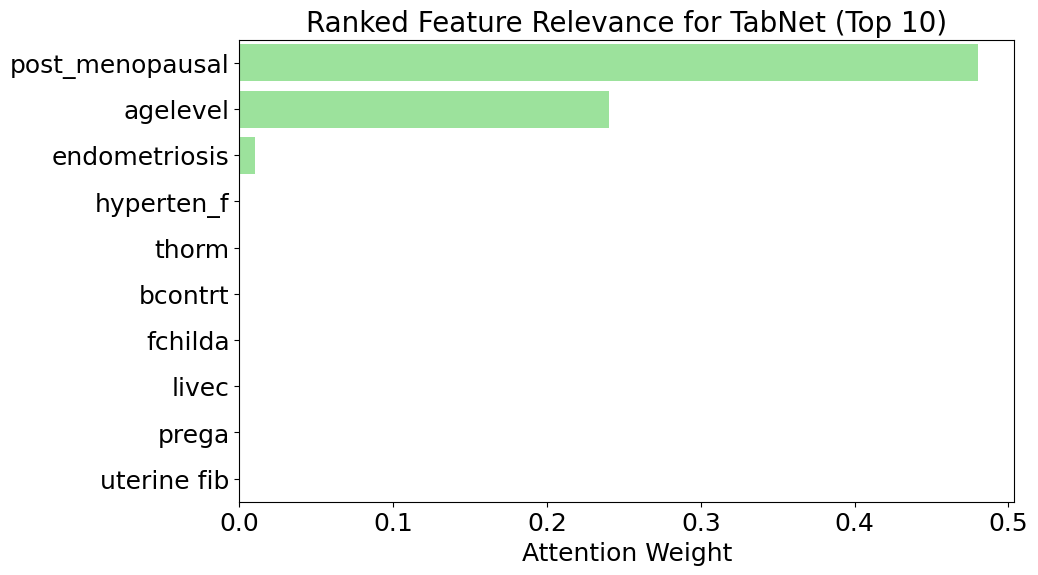

In [31]:
# visualization feature Relevance by TabNet (top10 features)
top_feature_names_tabnet = sorted_feature_names[:10]
top_attention_weights_tabnet = sorted_attention_weights[:10]
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names_tabnet, top_attention_weights_tabnet, color='lightgreen')
plt.gca().tick_params(labelsize=18)
plt.xlabel('Attention Weight', fontsize=18)
plt.title('Ranked feature relevance for TabNet (Top 10)', fontsize=20)
plt.gca().invert_yaxis()  
plt.show()

In [34]:
# 4. Rectifier Network
param_dist = {
    'hidden_layer_sizes': [(64, 128), (8, 16, 32), (16, 32, 64), (32, 64, 128), (64, 128, 256), 
                           (32, 64, 128, 256), (64, 128, 256, 512), (128, 256, 512, 1024)],
    'max_iter': randint(2000, 5000),  
    'early_stopping': [True],
    'n_iter_no_change': randint(100, 200),  
    'validation_fraction': uniform(0.1, 0.3),  
    'activation': ['relu'],
    'learning_rate_init': uniform(1e-6, 1e-2), 
    'alpha': uniform(1e-7, 1e-3),  
    'beta_1': [0.9, 0.95],
    'beta_2': [0.999, 0.9999],
    'epsilon': [1e-8],
}

# Hyperparameter optimization
search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=random_state),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Rectifier network training
search_mlp.fit(X_train_scaled, y_train)
best_params_mlp = search_mlp.best_params_
print("Best Parameters for MLP:", best_params_mlp)
print("Best f1-score for Rectifier Network using undersampled data during training: ",  search_mlp.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for MLP: {'activation': 'relu', 'alpha': 4.7280769062835714e-05, 'beta_1': 0.95, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (16, 32, 64), 'learning_rate_init': 2.660989531623558e-05, 'max_iter': 3253, 'n_iter_no_change': 130, 'validation_fraction': 0.357563394779037}


In [35]:
# Rectifier Network testing
best_mlp_model =search_mlp.best_estimator_
y_pred_mlp =best_mlp_model.predict(X_test_scaled)

# Rectifier Network Performance evaluation
print("\nEvaluation Metrics for Rectified network:")
accuracy = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_mlp)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_mlp)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_mlp)
print("F1 Score:", f1)
f_beta = fbeta_score(y_test, y_pred_mlp, beta=2)
print("F2 Score:", f_beta)
auc = roc_auc_score(y_test, best_mlp_model.predict_proba(X_test_scaled)[:, 1])
print("AUC:", auc)


Evaluation Metrics for Rectified network:
Accuracy: 0.526611027500342
Precision: 0.06562320505456634
Recall: 0.5252873563218391
F1 Score: 0.11667092162369161
F1 Score: 0.11667092162369161
AUC: 0.5381410545818158


In [36]:
#feed fwd weights- Local linear models
def mlp_relu_interpretation(model, x):
    w_list, b_list = model.coefs_, model.intercepts_

    layers = range(len(w_list))
    layer_j = np.copy(x)
    activation_pattern = []
    for j in layers:
        if j == len(w_list) - 1:
            continue
        layer_j = layer_j @ w_list[j] + b_list[j]
        layer_j[layer_j <= 0] = 0
        activation_pattern.extend(np.where(layer_j > 0))

    for j in layers:
        if j == 0:
            feature_weights_layer = w_list[j][:, activation_pattern[j]]
            intercepts_layer = b_list[j][activation_pattern[j]]
        elif 0 < j < len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            layer_j_w_active_output = layer_j_w_active_input[:, activation_pattern[j]]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_output
            intercepts_layer = intercepts_layer @ layer_j_w_active_output + b_list[j][activation_pattern[j]]
        elif j == len(w_list) - 1:
            layer_j_w_active_input = w_list[j][activation_pattern[j-1], :]
            feature_weights_layer = feature_weights_layer @ layer_j_w_active_input
            intercepts_layer = intercepts_layer @ layer_j_w_active_input + b_list[j]

    return feature_weights_layer, intercepts_layer

In [32]:
# Model prediction Local interpretation of feed fwd weights(Local linear models)
prediction = best_mlp_model.predict(instance_to_explain)[0]
print(f"Model Prediction: {prediction}")
feature_weights, intercepts = mlp_relu_interpretation(best_mlp_model, instance_to_explain)
feature_weights_tuples = [(feature_index, weight) for feature_index, weight in enumerate(feature_weights.flatten())]
sorted_feature_weights = sorted(feature_weights_tuples, key=lambda x: abs(x[1]), reverse=True)
feature_index_to_name = {i: name for i, name in enumerate(feature_names)}

sorted_feature_names = [feature_index_to_name.get(index, f'Unknown Feature {index}') for index, _ in sorted_feature_weights]
absolute_weights = [abs(weight) for _, weight in sorted_feature_weights]

Model Prediction: 0


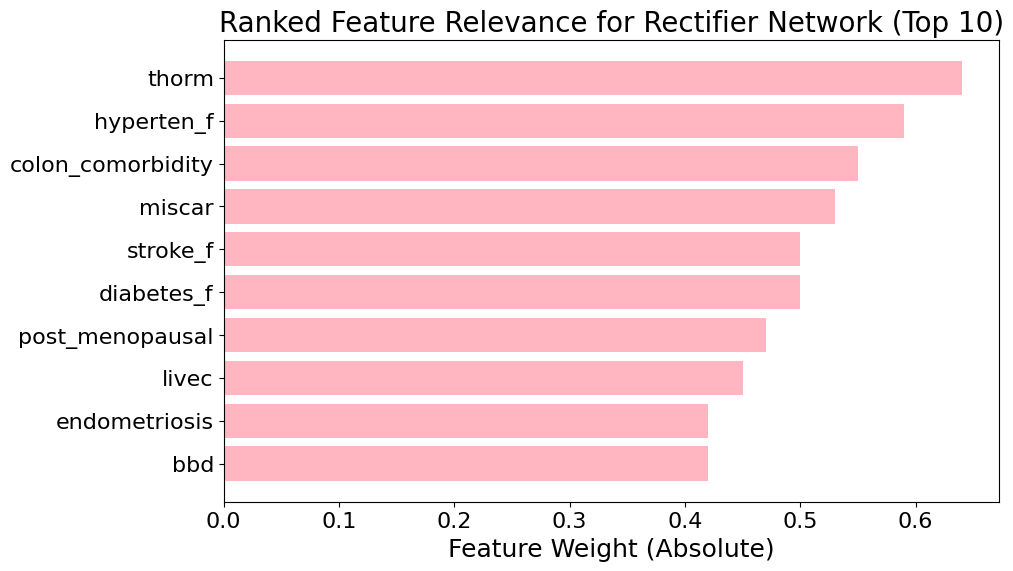

In [33]:
# Visualization of Feature relevance by Rectifier Network using absolute weights for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:10], absolute_weights[:10], color='lightpink')
plt.gca().tick_params(labelsize=16)
plt.xlabel('Feature Weight (Absolute)', fontsize=18)
plt.title('Ranked feature relevance for Rectifier Network (Top10)', fontsize=20)
plt.gca().invert_yaxis()  
plt.show()